#**Question 2** 

**Denoising Autoencoder**

In [5]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import torchvision.datasets as datasets
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import torchvision.transforms as T

In [6]:
(X_train,Y_train),(X_test,Y_test)=mnist.load_data()
X_train,X_valid,Y_train,Y_valid = train_test_split(X_train,Y_train,test_size=0.2,random_state=21)


In [7]:
print("X_train:",X_train.shape)
print("X_valid:",X_valid.shape)
print("X_test:",X_test.shape)
print("Y_train:",Y_train.shape)
print("Y_valid:",Y_valid.shape)
print("Y_test:",Y_test.shape)

X_train: (48000, 28, 28)
X_valid: (12000, 28, 28)
X_test: (10000, 28, 28)
Y_train: (48000,)
Y_valid: (12000,)
Y_test: (10000,)


## salt-pepper noise

In [ ]:
class MNIST(Dataset):

  def __init__(self,image_dataset,transform=None,target_transform=None):

      self.image_dataset = image_dataset
      self.transform = transform
      self.target_transform = target_transform
  
  def __len__(self):
    return len(self.image_dataset)

  def __getitem__(self,idx):

    pure_image = self.image_dataset[idx]

    if self.transform:
      noisy_image = self.transform(pure_image)
    
    if self.target_transform:
      pure_image = self.target_transform(pure_image)
    
    return noisy_image,pure_image
    

class ToTransform:

  def __call__(self,image):
    
    ## adding gaussian noise 
    def gaussian_noise(img):
      row,col=28,28
      img=img.astype(np.float32)
      mean=0
      var=10
      sigma=var**0.5
      noise=np.random.normal(-5.9,5.9,img.shape)
      noise=noise.reshape(row,col)
      noisy_img=img+noise
      # print("noisy_img:",noisy_img.shape)
      # plt.imshow(noisy_img)
      # plt.show()
      return noisy_img

    ## adding salt and pepper noise
    def salt_pepper_noise(img):
      row,col,ch = 28,28,1 #img.shape
      s_vs_p = 0.5
      amount = 0.04
      out = np.copy(img)
      # Salt mode
      num_salt = np.ceil(amount * img.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in img.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* img.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in img.shape]
      out[coords] = 0
      noisy_img = out
      # print("noisy_img:",noisy_img.shape)
      # plt.imshow(noisy_img)
      # plt.show()
      return noisy_img
      
    trans = T.Compose([ 
    T.ToTensor()
    ]) 

    # noisy_image = gaussian_noise(image)
    noisy_image = salt_pepper_noise(image)
    noisy_image = trans(noisy_image)

    return noisy_image


class TargetTransform:

  def __call__(self,image):

    pure_image = image
    trans = T.Compose([
    T.ToTensor()
    ])

    pure_image = trans(pure_image)

    return pure_image


train_dataset = MNIST(X_train,transform = ToTransform(),target_transform = TargetTransform())
valid_dataset = MNIST(X_valid,transform = ToTransform(),target_transform = TargetTransform())
test_dataset = MNIST(X_test,transform = ToTransform(),target_transform = TargetTransform())

batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers = 0, shuffle=True)#,worker_init_fn = np.random.seed(42))
valid_dataloader = DataLoader(valid_dataset,batch_size=batch_size,num_workers = 0, shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers = 0,shuffle=False)



In [ ]:
class autoencoder(nn.Module):

  def __init__(self):
    super(autoencoder,self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Linear(28*28,256),
        nn.ReLU(True),
        nn.Linear(256,128),
        nn.ReLU(True),
        nn.Linear(128,64),
        nn.ReLU(True)
    )

    self.decoder = nn.Sequential(
        nn.Linear(64,128),
        nn.ReLU(True),
        nn.Linear(128,256),
        nn.ReLU(True),
        nn.Linear(256,28*28),
        nn.Sigmoid()
    )

  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        for noisy_image,pure_image in dataloader:
            noisy_image = noisy_image.view(noisy_image.size(0),-1).type(torch.FloatTensor)
            pure_image = pure_image.view(pure_image.size(0),-1).type(torch.FloatTensor)
            noisy_image = noisy_image.to(device)
            pure_image = pure_image.to(device)
            out = model(noisy_image)
            loss = criterion(out,pure_image)

            test_loss += loss.item()
                
        test_loss = test_loss/float(len(dataloader)*batch_size)

        if purpose == "test": 
          
            # print(f'test loss:{test_loss:.4f}')
            
            f,axes = plt.subplots(10,3,figsize=(20,20))
            axes[0,0].set_title("Pure image")
            axes[0,1].set_title("noisy image")
            axes[0,2].set_title("denoised image")

            for i in range(10):
              actual_img = pure_image[i]
              noise_img = noisy_image[i]
              denoised_img = out[i]

              actual_img_disp = actual_img.view(1,28,28).permute(1,2,0).squeeze(2).detach().cpu().numpy()
              noise_img_disp = noise_img.view(1,28,28).permute(1,2,0).squeeze(2).detach().cpu().numpy()
              denoised_img_disp = denoised_img.view(1,28,28).permute(1,2,0).squeeze(2).detach().cpu().numpy()

              axes[i,0].imshow(actual_img_disp,cmap='gray') 
              axes[i,1].imshow(noise_img_disp,cmap='gray') 
              axes[i,2].imshow(denoised_img_disp,cmap='gray') 
            
            return test_loss
    
    return test_loss

  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
100%|██████████| 750/750 [00:20<00:00, 36.49it/s, batch_loss=0.059876129031181335]



epoch: 0  Train Loss: 0.001250276945453758  Validation Loss: 0.0009564707201826287 



100%|██████████| 750/750 [00:18<00:00, 40.93it/s, batch_loss=0.05228550359606743]



epoch: 1  Train Loss: 0.0008667956911958754  Validation Loss: 0.0007560729523476689 



100%|██████████| 750/750 [00:18<00:00, 40.90it/s, batch_loss=0.03711229935288429]



epoch: 2  Train Loss: 0.0006473753405734897  Validation Loss: 0.000570428369447906 



100%|██████████| 750/750 [00:18<00:00, 40.62it/s, batch_loss=0.031707778573036194]



epoch: 3  Train Loss: 0.0005366197006854539  Validation Loss: 0.0004971052162061901 



100%|██████████| 750/750 [00:18<00:00, 39.76it/s, batch_loss=0.027499791234731674]



epoch: 4  Train Loss: 0.00047138528312401225  Validation Loss: 0.00044550153920971887 



100%|██████████| 750/750 [00:22<00:00, 33.63it/s, batch_loss=0.026877330616116524]



epoch: 5  Train Loss: 0.0004333424855722114  Validation Loss: 0.0004169592447145446 



100%|██████████| 750/750 [00:19<00:00, 37.95it/s, batch_loss=0.025106780230998993]



epoch: 6  Train Loss: 0.0004078760613532116  Validation Loss: 0.0003935819000384691 



100%|██████████| 750/750 [00:18<00:00, 40.68it/s, batch_loss=0.023447878658771515]



epoch: 7  Train Loss: 0.0003863728190384184  Validation Loss: 0.00037204100350363855 



100%|██████████| 750/750 [00:18<00:00, 41.12it/s, batch_loss=0.02360716089606285]



epoch: 8  Train Loss: 0.0003630290647270158  Validation Loss: 0.0003475297963496872 



100%|██████████| 750/750 [00:18<00:00, 41.50it/s, batch_loss=0.02049698680639267]



epoch: 9  Train Loss: 0.00033973935223184523  Validation Loss: 0.0003294669810937658 



100%|██████████| 750/750 [00:21<00:00, 34.73it/s, batch_loss=0.018910499289631844]



epoch: 10  Train Loss: 0.000320081343408674  Validation Loss: 0.0003094468426771779 



100%|██████████| 750/750 [00:19<00:00, 38.31it/s, batch_loss=0.01616089977324009]



epoch: 11  Train Loss: 0.0003061996244359761  Validation Loss: 0.0002982923668125605 



100%|██████████| 750/750 [00:19<00:00, 39.15it/s, batch_loss=0.018902450799942017]



epoch: 12  Train Loss: 0.00029606995306676254  Validation Loss: 0.00029032788687742296 



100%|██████████| 750/750 [00:21<00:00, 34.42it/s, batch_loss=0.016787825152277946]



epoch: 13  Train Loss: 0.00028762264002580196  Validation Loss: 0.00028248423118481137 



100%|██████████| 750/750 [00:24<00:00, 30.96it/s, batch_loss=0.017931733280420303]



epoch: 14  Train Loss: 0.0002800492873454156  Validation Loss: 0.00027508946631643724 



100%|██████████| 750/750 [00:19<00:00, 37.53it/s, batch_loss=0.016938427463173866]



epoch: 15  Train Loss: 0.0002732101013728728  Validation Loss: 0.0002689665460375762 



100%|██████████| 750/750 [00:18<00:00, 39.80it/s, batch_loss=0.01701546646654606]



epoch: 16  Train Loss: 0.00026681176311103627  Validation Loss: 0.00026401548831849955 



100%|██████████| 750/750 [00:25<00:00, 29.19it/s, batch_loss=0.018604012206196785]



epoch: 17  Train Loss: 0.00026104117307113484  Validation Loss: 0.0002580759836301366 



100%|██████████| 750/750 [00:20<00:00, 37.14it/s, batch_loss=0.013829885050654411]



epoch: 18  Train Loss: 0.0002559918676464197  Validation Loss: 0.00025325002028926354 



100%|██████████| 750/750 [00:24<00:00, 31.17it/s, batch_loss=0.014912678860127926]



epoch: 19  Train Loss: 0.0002507978113911425  Validation Loss: 0.0002476484201287484 



100%|██████████| 750/750 [00:19<00:00, 38.45it/s, batch_loss=0.018339158967137337]



epoch: 20  Train Loss: 0.00024585995223606004  Validation Loss: 0.00024336092030082115 



100%|██████████| 750/750 [00:20<00:00, 35.95it/s, batch_loss=0.015498833730816841]



epoch: 21  Train Loss: 0.000240888318240953  Validation Loss: 0.00023781883778320527 



100%|██████████| 750/750 [00:18<00:00, 39.53it/s, batch_loss=0.012981736101210117]



epoch: 22  Train Loss: 0.00023565591796068474  Validation Loss: 0.00023376464540636702 



100%|██████████| 750/750 [00:19<00:00, 39.03it/s, batch_loss=0.013762488029897213]



epoch: 23  Train Loss: 0.00023062388649365553  Validation Loss: 0.00022929329126317828 



100%|██████████| 750/750 [00:18<00:00, 39.71it/s, batch_loss=0.01456546038389206]



epoch: 24  Train Loss: 0.00022573106574903554  Validation Loss: 0.0002238189034811667 



100%|██████████| 750/750 [00:36<00:00, 20.76it/s, batch_loss=0.015238851308822632]



epoch: 25  Train Loss: 0.00022080524700383345  Validation Loss: 0.00021916731597268656 



100%|██████████| 750/750 [00:22<00:00, 33.01it/s, batch_loss=0.013026545755565166]



epoch: 26  Train Loss: 0.0002160761384293437  Validation Loss: 0.00021532987112221505 



100%|██████████| 750/750 [00:37<00:00, 20.12it/s, batch_loss=0.015094834379851818]



epoch: 27  Train Loss: 0.00021134191988191257  Validation Loss: 0.00021072187317916727 



100%|██████████| 750/750 [00:25<00:00, 29.58it/s, batch_loss=0.013083920814096928]



epoch: 28  Train Loss: 0.00020724969535755616  Validation Loss: 0.00020663652112682727 



100%|██████████| 750/750 [00:22<00:00, 33.49it/s, batch_loss=0.013723823241889477]



epoch: 29  Train Loss: 0.00020342993484033894  Validation Loss: 0.00020261510105635177 



100%|██████████| 750/750 [00:29<00:00, 25.73it/s, batch_loss=0.011741350404918194]



epoch: 30  Train Loss: 0.00019974274677224456  Validation Loss: 0.00019911076587766032 



100%|██████████| 750/750 [00:18<00:00, 40.59it/s, batch_loss=0.014282632619142532]



epoch: 31  Train Loss: 0.00019640641197717437  Validation Loss: 0.0001959330033098516 



100%|██████████| 750/750 [00:18<00:00, 40.11it/s, batch_loss=0.010994745418429375]



epoch: 32  Train Loss: 0.00019327123604792482  Validation Loss: 0.00019328386971461983 



100%|██████████| 750/750 [00:18<00:00, 40.40it/s, batch_loss=0.013190477155148983]



epoch: 33  Train Loss: 0.00019018932715213546  Validation Loss: 0.00019044543598206376 



100%|██████████| 750/750 [00:20<00:00, 35.73it/s, batch_loss=0.012029370293021202]



epoch: 34  Train Loss: 0.0001871349480934441  Validation Loss: 0.00018800222847432374 



100%|██████████| 750/750 [00:21<00:00, 34.49it/s, batch_loss=0.010432137176394463]



epoch: 35  Train Loss: 0.00018415589673289408  Validation Loss: 0.00018411501382906088 



100%|██████████| 750/750 [00:30<00:00, 24.26it/s, batch_loss=0.009613827802240849]



epoch: 36  Train Loss: 0.00018123574446265897  Validation Loss: 0.00018213942693112953 



100%|██████████| 750/750 [00:22<00:00, 33.88it/s, batch_loss=0.011229018680751324]



epoch: 37  Train Loss: 0.00017846129970469822  Validation Loss: 0.00017875862698580952 



100%|██████████| 750/750 [00:21<00:00, 34.64it/s, batch_loss=0.01283514965325594]



epoch: 38  Train Loss: 0.000175464513420593  Validation Loss: 0.0001758186674046459 



100%|██████████| 750/750 [00:19<00:00, 38.47it/s, batch_loss=0.009990123100578785]



epoch: 39  Train Loss: 0.00017270663840463385  Validation Loss: 0.0001727623147165472 



100%|██████████| 750/750 [00:19<00:00, 37.71it/s, batch_loss=0.012674200348556042]



epoch: 40  Train Loss: 0.00016994675444827106  Validation Loss: 0.0001707005169319405 



100%|██████████| 750/750 [00:32<00:00, 22.83it/s, batch_loss=0.011118914000689983]



epoch: 41  Train Loss: 0.0001675753269616204  Validation Loss: 0.00016833471996273767 



100%|██████████| 750/750 [00:18<00:00, 40.31it/s, batch_loss=0.009442160837352276]



epoch: 42  Train Loss: 0.00016526984854135662  Validation Loss: 0.00016570729999233316 



100%|██████████| 750/750 [00:18<00:00, 40.70it/s, batch_loss=0.010170815512537956]



epoch: 43  Train Loss: 0.000163187775023592  Validation Loss: 0.00016448259788027846 



100%|██████████| 750/750 [00:18<00:00, 40.24it/s, batch_loss=0.009997373446822166]



epoch: 44  Train Loss: 0.00016108778427587823  Validation Loss: 0.000162329842885114 



100%|██████████| 750/750 [00:22<00:00, 33.89it/s, batch_loss=0.01153597142547369]



epoch: 45  Train Loss: 0.00015926464909959273  Validation Loss: 0.00016060579729766802 



100%|██████████| 750/750 [00:29<00:00, 25.07it/s, batch_loss=0.009731562808156013]



epoch: 46  Train Loss: 0.0001574271626304835  Validation Loss: 0.0001589981798810805 



100%|██████████| 750/750 [00:36<00:00, 20.48it/s, batch_loss=0.00954368244856596]



epoch: 47  Train Loss: 0.00015580857699387706  Validation Loss: 0.0001569639185772951 



100%|██████████| 750/750 [00:19<00:00, 39.29it/s, batch_loss=0.010693206451833248]



epoch: 48  Train Loss: 0.00015414266216491038  Validation Loss: 0.00015569844346944282 



100%|██████████| 750/750 [00:23<00:00, 32.15it/s, batch_loss=0.009699278511106968]



epoch: 49  Train Loss: 0.0001526426842416792  Validation Loss: 0.00015400858048567588 



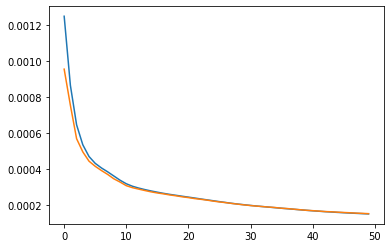

In [ ]:
from tqdm import tqdm
train_loss = []
validation_loss = []
num_epochs = 50
learning_rate = 0.0001

model = autoencoder().to(device)
# print("model:",model)
model.train()
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)#,weight_decay=1e-6)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
for epoch in range(num_epochs):
  running_loss = 0.0

  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      noisy_image,pure_image = batch
      noisy_image = noisy_image.view(noisy_image.size(0),-1).type(torch.FloatTensor)
      pure_image = pure_image.view(pure_image.size(0),-1).type(torch.FloatTensor)

      noisy_image = noisy_image.to(device)
      pure_image = pure_image.to(device)
      out = model(noisy_image)
      loss = criterion(out,pure_image)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  val_loss = test(valid_dataloader,model,criterion,purpose="valid")
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  validation_loss.append(val_loss)
  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Validation Loss:",val_loss,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


test loss: 0.0001493283309903334


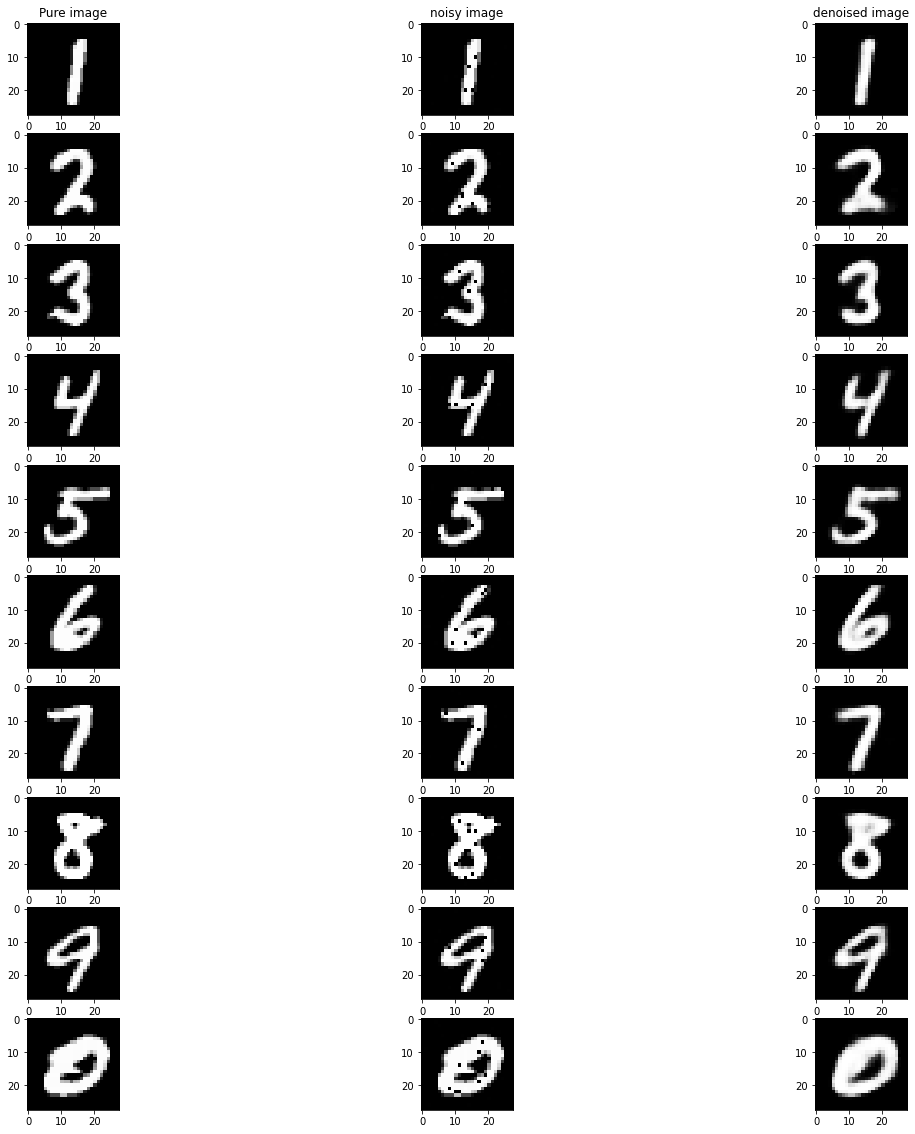

In [ ]:
model.eval()
test_loss = test(test_dataloader,model,criterion,purpose="test")
print("test loss:",test_loss)

## gaussian noise

In [9]:
class MNIST(Dataset):

  def __init__(self,image_dataset,transform=None,target_transform=None):

      self.image_dataset = image_dataset
      self.transform = transform
      self.target_transform = target_transform
  
  def __len__(self):
    return len(self.image_dataset)

  def __getitem__(self,idx):

    pure_image = self.image_dataset[idx]

    if self.transform:
      noisy_image = self.transform(pure_image)
    
    if self.target_transform:
      pure_image = self.target_transform(pure_image)
    
    return noisy_image,pure_image
    

class ToTransform:

  def __call__(self,image):
    
    ## adding gaussian noise 
    def gaussian_noise(img):
      row,col=28,28
      img=img.astype(np.float32)
      mean=0
      var=10
      sigma=var**0.5
      noise=np.random.normal(-5.9,5.9,img.shape)
      noise=noise.reshape(row,col)
      noisy_img=img+noise
      # print("noisy_img:",noisy_img.shape)
      # plt.imshow(noisy_img)
      # plt.show()
      return noisy_img

    ## adding salt and pepper noise
    def salt_pepper_noise(img):
      row,col,ch = 28,28,1 #img.shape
      s_vs_p = 0.5
      amount = 0.04
      out = np.copy(img)
      # Salt mode
      num_salt = np.ceil(amount * img.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in img.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* img.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in img.shape]
      out[coords] = 0
      noisy_img = out
      # print("noisy_img:",noisy_img.shape)
      # plt.imshow(noisy_img)
      # plt.show()
      return noisy_img
      
    trans = T.Compose([ 
    T.ToTensor()
    ]) 

    noisy_image = gaussian_noise(image)
    # noisy_image = salt_pepper_noise(image)
    noisy_image = trans(noisy_image)

    return noisy_image


class TargetTransform:

  def __call__(self,image):

    pure_image = image
    trans = T.Compose([
    T.ToTensor()
    ])

    pure_image = trans(pure_image)

    return pure_image


train_dataset = MNIST(X_train,transform = ToTransform(),target_transform = TargetTransform())
valid_dataset = MNIST(X_valid,transform = ToTransform(),target_transform = TargetTransform())
test_dataset = MNIST(X_test,transform = ToTransform(),target_transform = TargetTransform())

batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers = 0, shuffle=True)#,worker_init_fn = np.random.seed(42))
valid_dataloader = DataLoader(valid_dataset,batch_size=batch_size,num_workers = 0, shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers = 0,shuffle=False)



cuda


100%|██████████| 750/750 [00:20<00:00, 36.43it/s, batch_loss=0.025430815294384956]



epoch: 0  Train Loss: 0.0007246260442382966  Validation Loss: 0.0003643942025596613 



100%|██████████| 750/750 [00:17<00:00, 42.34it/s, batch_loss=0.01605466566979885]



epoch: 1  Train Loss: 0.00030404183871966475  Validation Loss: 0.00025928104878403246 



100%|██████████| 750/750 [00:16<00:00, 44.81it/s, batch_loss=0.015178835019469261]



epoch: 2  Train Loss: 0.00023706451514347767  Validation Loss: 0.0002172790088305656 



100%|██████████| 750/750 [00:17<00:00, 41.84it/s, batch_loss=0.011102926917374134]



epoch: 3  Train Loss: 0.00020553328009555118  Validation Loss: 0.00019471087928631025 



100%|██████████| 750/750 [00:16<00:00, 44.78it/s, batch_loss=0.011031311005353928]



epoch: 4  Train Loss: 0.00018622545377972225  Validation Loss: 0.00018014994171569422 



100%|██████████| 750/750 [00:14<00:00, 51.64it/s, batch_loss=0.009843635372817516]



epoch: 5  Train Loss: 0.00017266762138266737  Validation Loss: 0.00016674953440087847 



100%|██████████| 750/750 [00:15<00:00, 49.64it/s, batch_loss=0.01165572926402092]



epoch: 6  Train Loss: 0.00016172858995075026  Validation Loss: 0.0001582715459393357 



100%|██████████| 750/750 [00:14<00:00, 51.45it/s, batch_loss=0.009810741059482098]



epoch: 7  Train Loss: 0.00015330357199612384  Validation Loss: 0.00015050169856701184 



100%|██████████| 750/750 [00:14<00:00, 52.04it/s, batch_loss=0.009195192717015743]



epoch: 8  Train Loss: 0.0001461337705841288  Validation Loss: 0.0001441622509756076 



100%|██████████| 750/750 [00:14<00:00, 52.52it/s, batch_loss=0.0086209150031209]



epoch: 9  Train Loss: 0.0001401002349545403  Validation Loss: 0.00013843142365426212 



100%|██████████| 750/750 [00:14<00:00, 52.86it/s, batch_loss=0.008668559603393078]



epoch: 10  Train Loss: 0.0001347070679087968  Validation Loss: 0.00013402060184044455 



100%|██████████| 750/750 [00:14<00:00, 52.25it/s, batch_loss=0.008490653708577156]



epoch: 11  Train Loss: 0.00013021469288893665  Validation Loss: 0.00013053096897257344 



100%|██████████| 750/750 [00:15<00:00, 49.71it/s, batch_loss=0.007513608783483505]



epoch: 12  Train Loss: 0.0001264706395061997  Validation Loss: 0.00012580350379179668 



100%|██████████| 750/750 [00:14<00:00, 52.36it/s, batch_loss=0.007406608667224646]



epoch: 13  Train Loss: 0.00012286215422985453  Validation Loss: 0.00012244357152512556 



100%|██████████| 750/750 [00:14<00:00, 51.84it/s, batch_loss=0.008093913085758686]



epoch: 14  Train Loss: 0.00011952350324524256  Validation Loss: 0.00011967707294079059 



100%|██████████| 750/750 [00:14<00:00, 52.20it/s, batch_loss=0.0076775276102125645]



epoch: 15  Train Loss: 0.00011694923649580839  Validation Loss: 0.00011758090163602127 



100%|██████████| 750/750 [00:14<00:00, 51.39it/s, batch_loss=0.006986502557992935]



epoch: 16  Train Loss: 0.00011473821044395057  Validation Loss: 0.000114721756270886 



100%|██████████| 750/750 [00:14<00:00, 51.09it/s, batch_loss=0.007313204929232597]



epoch: 17  Train Loss: 0.00011225737993178579  Validation Loss: 0.00011283277552215719 



100%|██████████| 750/750 [00:14<00:00, 51.11it/s, batch_loss=0.006951476912945509]



epoch: 18  Train Loss: 0.00011016671027755365  Validation Loss: 0.00011155104480263966 



100%|██████████| 750/750 [00:14<00:00, 51.31it/s, batch_loss=0.006544418167322874]



epoch: 19  Train Loss: 0.0001083639884503403  Validation Loss: 0.00010926003438300463 



100%|██████████| 750/750 [00:14<00:00, 51.66it/s, batch_loss=0.006401143968105316]



epoch: 20  Train Loss: 0.00010611331875164372  Validation Loss: 0.00010714366776773339 



100%|██████████| 750/750 [00:14<00:00, 51.97it/s, batch_loss=0.00669937813654542]



epoch: 21  Train Loss: 0.00010454272516653873  Validation Loss: 0.00010643058088502817 



100%|██████████| 750/750 [00:14<00:00, 51.56it/s, batch_loss=0.0069367606192827225]



epoch: 22  Train Loss: 0.00010264919578912668  Validation Loss: 0.00010387172086995362 



100%|██████████| 750/750 [00:14<00:00, 51.37it/s, batch_loss=0.006812206003814936]



epoch: 23  Train Loss: 0.00010136037001696725  Validation Loss: 0.00010296616590571926 



100%|██████████| 750/750 [00:14<00:00, 51.66it/s, batch_loss=0.006312762852758169]



epoch: 24  Train Loss: 0.00010015537996271936  Validation Loss: 0.00010240175899835254 



100%|██████████| 750/750 [00:14<00:00, 51.06it/s, batch_loss=0.006118330173194408]



epoch: 25  Train Loss: 9.88147419023638e-05  Validation Loss: 0.00010066272052620449 



100%|██████████| 750/750 [00:14<00:00, 51.34it/s, batch_loss=0.006277034524828196]



epoch: 26  Train Loss: 9.766495523702664e-05  Validation Loss: 9.913474078781834e-05 



100%|██████████| 750/750 [00:14<00:00, 51.13it/s, batch_loss=0.006623866502195597]



epoch: 27  Train Loss: 9.650182116699095e-05  Validation Loss: 9.843569367806962e-05 



100%|██████████| 750/750 [00:14<00:00, 51.22it/s, batch_loss=0.005963262636214495]



epoch: 28  Train Loss: 9.549714124295861e-05  Validation Loss: 9.76719664786868e-05 



100%|██████████| 750/750 [00:14<00:00, 50.97it/s, batch_loss=0.005821220576763153]



epoch: 29  Train Loss: 9.465211230174948e-05  Validation Loss: 9.742887998575671e-05 



100%|██████████| 750/750 [00:14<00:00, 51.10it/s, batch_loss=0.007030113600194454]



epoch: 30  Train Loss: 9.384403382622016e-05  Validation Loss: 9.614379737189317e-05 



100%|██████████| 750/750 [00:14<00:00, 51.26it/s, batch_loss=0.006529371254146099]



epoch: 31  Train Loss: 9.279393706431922e-05  Validation Loss: 9.480978088562396e-05 



100%|██████████| 750/750 [00:14<00:00, 51.29it/s, batch_loss=0.0056727672927081585]



epoch: 32  Train Loss: 9.198561180771019e-05  Validation Loss: 9.392788826439659e-05 



100%|██████████| 750/750 [00:14<00:00, 51.33it/s, batch_loss=0.006519622635096312]



epoch: 33  Train Loss: 9.109290232299828e-05  Validation Loss: 9.378510293708075e-05 



100%|██████████| 750/750 [00:14<00:00, 50.96it/s, batch_loss=0.006280629429966211]



epoch: 34  Train Loss: 9.054902031978903e-05  Validation Loss: 9.310422722185823e-05 



100%|██████████| 750/750 [00:14<00:00, 50.64it/s, batch_loss=0.005175361875444651]



epoch: 35  Train Loss: 9.007633766547467e-05  Validation Loss: 9.198152292810846e-05 



100%|██████████| 750/750 [00:14<00:00, 50.48it/s, batch_loss=0.005715867038816214]



epoch: 36  Train Loss: 8.931522244044269e-05  Validation Loss: 9.165187289677016e-05 



100%|██████████| 750/750 [00:14<00:00, 51.02it/s, batch_loss=0.005593178793787956]



epoch: 37  Train Loss: 8.874452273206165e-05  Validation Loss: 9.181414780540124e-05 



100%|██████████| 750/750 [00:14<00:00, 51.17it/s, batch_loss=0.005303885322064161]



epoch: 38  Train Loss: 8.80557631899137e-05  Validation Loss: 9.111673302578176e-05 



100%|██████████| 750/750 [00:14<00:00, 51.06it/s, batch_loss=0.005890635773539543]



epoch: 39  Train Loss: 8.714355133512678e-05  Validation Loss: 8.96192020863577e-05 



100%|██████████| 750/750 [00:14<00:00, 51.75it/s, batch_loss=0.005350042134523392]



epoch: 40  Train Loss: 8.64565561253888e-05  Validation Loss: 8.964667056793683e-05 



100%|██████████| 750/750 [00:14<00:00, 50.92it/s, batch_loss=0.004688785411417484]



epoch: 41  Train Loss: 8.577074650869084e-05  Validation Loss: 8.841105769301686e-05 



100%|██████████| 750/750 [00:14<00:00, 51.08it/s, batch_loss=0.005726921372115612]



epoch: 42  Train Loss: 8.500941073483167e-05  Validation Loss: 8.77821690045629e-05 



100%|██████████| 750/750 [00:14<00:00, 51.26it/s, batch_loss=0.005996237974613905]



epoch: 43  Train Loss: 8.458981451500828e-05  Validation Loss: 8.739701630436181e-05 



100%|██████████| 750/750 [00:14<00:00, 50.96it/s, batch_loss=0.0051241181790828705]



epoch: 44  Train Loss: 8.380596506564567e-05  Validation Loss: 8.709428166571826e-05 



100%|██████████| 750/750 [00:14<00:00, 50.76it/s, batch_loss=0.005658064503222704]



epoch: 45  Train Loss: 8.342954156493457e-05  Validation Loss: 8.587783950714127e-05 



100%|██████████| 750/750 [00:14<00:00, 50.57it/s, batch_loss=0.004904404282569885]



epoch: 46  Train Loss: 8.288162233657204e-05  Validation Loss: 8.611594742607384e-05 



100%|██████████| 750/750 [00:14<00:00, 50.50it/s, batch_loss=0.005140392109751701]



epoch: 47  Train Loss: 8.234602822146068e-05  Validation Loss: 8.487783700129899e-05 



100%|██████████| 750/750 [00:14<00:00, 50.87it/s, batch_loss=0.0049855466932058334]



epoch: 48  Train Loss: 8.192259656304184e-05  Validation Loss: 8.437399233987386e-05 



100%|██████████| 750/750 [00:14<00:00, 50.73it/s, batch_loss=0.005354761146008968]



epoch: 49  Train Loss: 8.134743824484758e-05  Validation Loss: 8.526646195876194e-05 

test loss: 8.240724992282113e-05


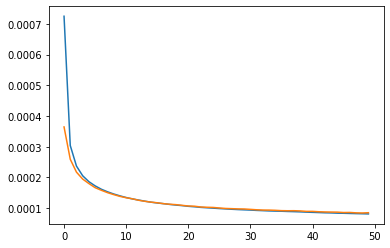

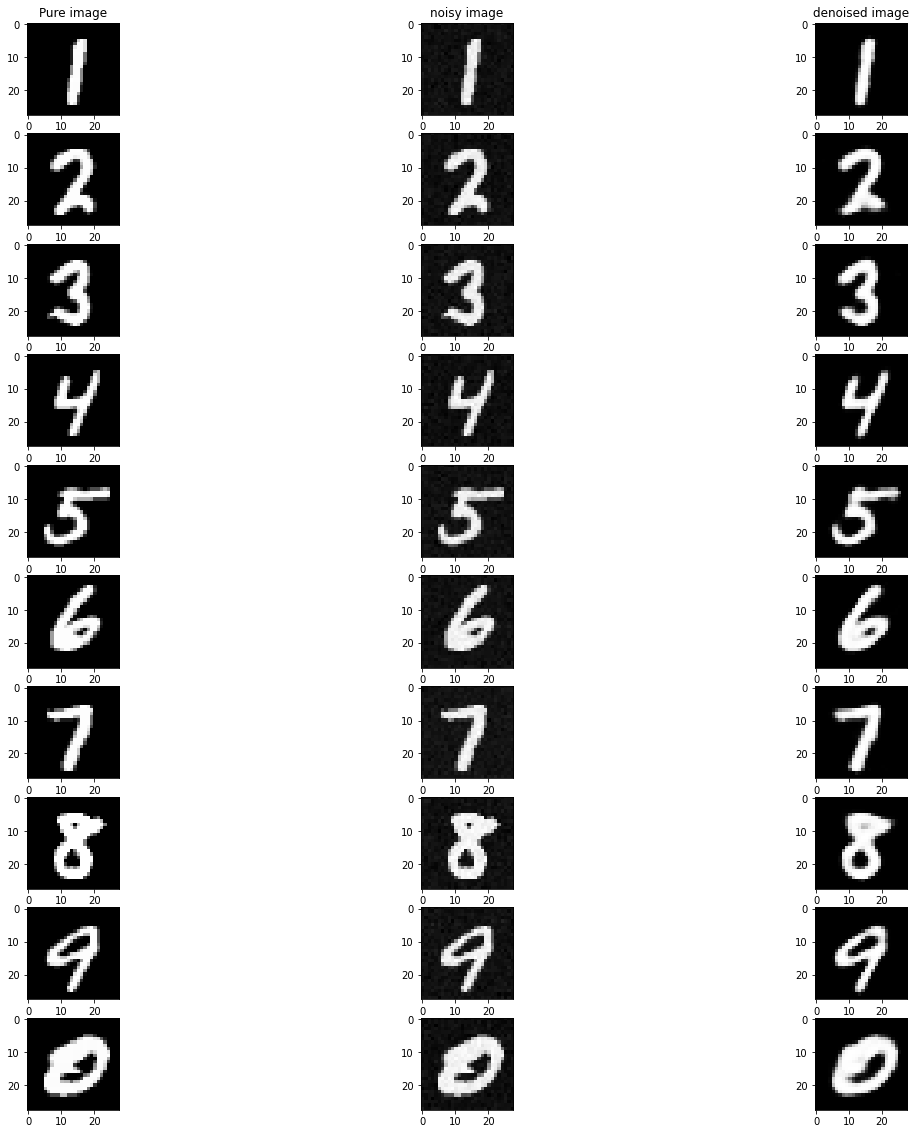

In [10]:
class autoencoder(nn.Module):

  def __init__(self):
    super(autoencoder,self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Linear(28*28,256),
        nn.ReLU(True),
        nn.Linear(256,128),
        nn.ReLU(True),
        nn.Linear(128,64),
        nn.ReLU(True)
    )

    self.decoder = nn.Sequential(
        nn.Linear(64,128),
        nn.ReLU(True),
        nn.Linear(128,256),
        nn.ReLU(True),
        nn.Linear(256,28*28),
        nn.Sigmoid()
    )

  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        for noisy_image,pure_image in dataloader:
            noisy_image = noisy_image.view(noisy_image.size(0),-1).type(torch.FloatTensor)
            pure_image = pure_image.view(pure_image.size(0),-1).type(torch.FloatTensor)
            noisy_image = noisy_image.to(device)
            pure_image = pure_image.to(device)
            out = model(noisy_image)
            loss = criterion(out,pure_image)

            test_loss += loss.item()
                
        test_loss = test_loss/float(len(dataloader)*batch_size)

        if purpose == "test": 
          
            # print(f'test loss:{test_loss:.4f}')
            
            f,axes = plt.subplots(10,3,figsize=(20,20))
            axes[0,0].set_title("Pure image")
            axes[0,1].set_title("noisy image")
            axes[0,2].set_title("denoised image")

            for i in range(10):
              actual_img = pure_image[i]
              noise_img = noisy_image[i]
              denoised_img = out[i]

              actual_img_disp = actual_img.view(1,28,28).permute(1,2,0).squeeze(2).detach().cpu().numpy()
              noise_img_disp = noise_img.view(1,28,28).permute(1,2,0).squeeze(2).detach().cpu().numpy()
              denoised_img_disp = denoised_img.view(1,28,28).permute(1,2,0).squeeze(2).detach().cpu().numpy()

              axes[i,0].imshow(actual_img_disp,cmap='gray') 
              axes[i,1].imshow(noise_img_disp,cmap='gray') 
              axes[i,2].imshow(denoised_img_disp,cmap='gray') 
            
            return test_loss
    
    return test_loss

from tqdm import tqdm
train_loss = []
validation_loss = []
num_epochs = 50
learning_rate = 0.0001

model = autoencoder().to(device)
# print("model:",model)
model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
for epoch in range(num_epochs):
  running_loss = 0.0

  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      noisy_image,pure_image = batch
      noisy_image = noisy_image.view(noisy_image.size(0),-1).type(torch.FloatTensor)
      pure_image = pure_image.view(pure_image.size(0),-1).type(torch.FloatTensor)

      noisy_image = noisy_image.to(device)
      pure_image = pure_image.to(device)
      out = model(noisy_image)
      loss = criterion(out,pure_image)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  val_loss = test(valid_dataloader,model,criterion,purpose="valid")
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  validation_loss.append(val_loss)
  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Validation Loss:",val_loss,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)


model.eval()
test_loss = test(test_dataloader,model,criterion,purpose="test")
print("test loss:",test_loss)


#**Question 2** 

**Classification Task: 3 Layers**

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import torchvision.datasets as datasets
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import torchvision.transforms as T

In [ ]:
(X_train,Y_train),(X_test,Y_test)=mnist.load_data()
X_train,X_valid,Y_train,Y_valid = train_test_split(X_train,Y_train,test_size=0.2,random_state=21)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
print("X_train:",X_train.shape)
print("X_valid:",X_valid.shape)
print("X_test:",X_test.shape)
print("Y_train:",Y_train.shape)
print("Y_valid:",Y_valid.shape)
print("Y_test:",Y_test.shape)

X_train: (48000, 28, 28)
X_valid: (12000, 28, 28)
X_test: (10000, 28, 28)
Y_train: (48000,)
Y_valid: (12000,)
Y_test: (10000,)


In [ ]:
class MNIST(Dataset):

  def __init__(self,image_dataset,labels,transform=None,target_transform=None):

      self.image_dataset = image_dataset
      self.labels = labels
      self.transform = transform
      self.target_transform = target_transform
  
  def __len__(self):
    return len(self.image_dataset)

  def __getitem__(self,idx):

    image = self.image_dataset[idx]
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)
    
    if self.target_transform:
      label = self.target_transform(label)
    
    return image,label
    

class ToTransform:

  def __call__(self,image):
      
    trans = T.Compose([ 
    T.ToTensor(),
    T.Normalize(
        mean = [0.5],
        std = [0.5]
        ) 
    ]) 

    image = trans(image)

    return image


class TargetTransform:

  def __call__(self,y):
    
    y = torch.tensor(y)

    return y


train_dataset = MNIST(X_train,Y_train,transform = ToTransform(),target_transform = TargetTransform())
valid_dataset = MNIST(X_valid,Y_valid,transform = ToTransform(),target_transform = TargetTransform())
test_dataset = MNIST(X_test,Y_test,transform = ToTransform(),target_transform = TargetTransform())

batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers = 0, shuffle=True)#,worker_init_fn = np.random.seed(42))
valid_dataloader = DataLoader(valid_dataset,batch_size=batch_size,num_workers = 0, shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers = 0,shuffle=False)



In [ ]:
class ClasificationNetwork3L(nn.Module):

  def __init__(self):
    super(ClasificationNetwork3L,self).__init__()
    
    self.fc = nn.Sequential(
        nn.Linear(28*28,256),
        nn.ReLU(True),
        nn.Linear(256,128),
        nn.ReLU(True),
        nn.Linear(128,64),
        nn.ReLU(True),
        nn.Linear(64,10)
    )

  def forward(self,x):
    x=self.fc(x)
    return x

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        for imgs,lbls in dataloader:
            imgs = imgs.view(imgs.size(0),-1).type(torch.FloatTensor)
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls)
            
        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))

        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img)
              pred_lbl = out

              img_disp = img.view(1,28,28).permute(1,2,0).squeeze(2).detach().cpu().numpy()
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp)
              plt.imshow(img_disp,cmap='gray')
              plt.show()
                        
            return test_loss,test_acc
    
    return test_loss,test_acc

100%|██████████| 750/750 [00:14<00:00, 50.08it/s, batch_Accuracy=0.890625, batch_loss=0.39700907468795776]



epoch: 0  Train Loss: 0.0121281369968007  Train Accuracy: tensor(0.7975, device='cuda:0')  Validation Loss: 0.005840493241037698  Validation Accuracy: 0.8910405585106383 



100%|██████████| 750/750 [00:15<00:00, 49.78it/s, batch_Accuracy=0.953125, batch_loss=0.20412960648536682]



epoch: 1  Train Loss: 0.005286830708229293  Train Accuracy: tensor(0.9019, device='cuda:0')  Validation Loss: 0.004693217351388662  Validation Accuracy: 0.9127327127659575 



100%|██████████| 750/750 [00:14<00:00, 50.08it/s, batch_Accuracy=0.890625, batch_loss=0.3846789300441742]



epoch: 2  Train Loss: 0.004379448460880667  Train Accuracy: tensor(0.9186, device='cuda:0')  Validation Loss: 0.004002406166499837  Validation Accuracy: 0.9232047872340425 



100%|██████████| 750/750 [00:14<00:00, 50.29it/s, batch_Accuracy=0.921875, batch_loss=0.18384243547916412]



epoch: 3  Train Loss: 0.0037543053795428324  Train Accuracy: tensor(0.9294, device='cuda:0')  Validation Loss: 0.00354088641649875  Validation Accuracy: 0.9317652925531915 



100%|██████████| 750/750 [00:15<00:00, 49.63it/s, batch_Accuracy=0.953125, batch_loss=0.18209706246852875]



epoch: 4  Train Loss: 0.0032158775543794037  Train Accuracy: tensor(0.9393, device='cuda:0')  Validation Loss: 0.003098221845612762  Validation Accuracy: 0.9375 



100%|██████████| 750/750 [00:15<00:00, 49.83it/s, batch_Accuracy=0.984375, batch_loss=0.06299905478954315]



epoch: 5  Train Loss: 0.0028217583449246983  Train Accuracy: tensor(0.9470, device='cuda:0')  Validation Loss: 0.0027775296856565003  Validation Accuracy: 0.9446476063829787 



100%|██████████| 750/750 [00:15<00:00, 49.01it/s, batch_Accuracy=0.90625, batch_loss=0.21817930042743683]



epoch: 6  Train Loss: 0.002487160270490373  Train Accuracy: tensor(0.9527, device='cuda:0')  Validation Loss: 0.002561336369600464  Validation Accuracy: 0.9482214095744681 



100%|██████████| 750/750 [00:15<00:00, 49.44it/s, batch_Accuracy=0.984375, batch_loss=0.06968971341848373]



epoch: 7  Train Loss: 0.0022321217361604795  Train Accuracy: tensor(0.9580, device='cuda:0')  Validation Loss: 0.0024349763554439166  Validation Accuracy: 0.9512134308510638 



100%|██████████| 750/750 [00:14<00:00, 50.04it/s, batch_Accuracy=0.984375, batch_loss=0.08121637254953384]



epoch: 8  Train Loss: 0.0019931730506165574  Train Accuracy: tensor(0.9620, device='cuda:0')  Validation Loss: 0.002143056146915695  Validation Accuracy: 0.956283244680851 



100%|██████████| 750/750 [00:14<00:00, 50.17it/s, batch_Accuracy=1.0, batch_loss=0.06074342131614685]



epoch: 9  Train Loss: 0.00182263686399286  Train Accuracy: tensor(0.9657, device='cuda:0')  Validation Loss: 0.0020593358569114687  Validation Accuracy: 0.9583610372340425 



100%|██████████| 750/750 [00:14<00:00, 50.49it/s, batch_Accuracy=0.953125, batch_loss=0.10640651732683182]



epoch: 10  Train Loss: 0.0016578497356968  Train Accuracy: tensor(0.9682, device='cuda:0')  Validation Loss: 0.0020000430849130622  Validation Accuracy: 0.9594414893617021 



100%|██████████| 750/750 [00:14<00:00, 50.43it/s, batch_Accuracy=0.9375, batch_loss=0.14763899147510529]



epoch: 11  Train Loss: 0.0015313277125242166  Train Accuracy: tensor(0.9711, device='cuda:0')  Validation Loss: 0.0018558631013450956  Validation Accuracy: 0.9616023936170213 



100%|██████████| 750/750 [00:15<00:00, 49.01it/s, batch_Accuracy=1.0, batch_loss=0.048241760581731796]



epoch: 12  Train Loss: 0.0014067396659811493  Train Accuracy: tensor(0.9739, device='cuda:0')  Validation Loss: 0.0017909562617553982  Validation Accuracy: 0.9625997340425532 



100%|██████████| 750/750 [00:15<00:00, 48.76it/s, batch_Accuracy=0.96875, batch_loss=0.10685626417398453]



epoch: 13  Train Loss: 0.0012925048875331413  Train Accuracy: tensor(0.9756, device='cuda:0')  Validation Loss: 0.0016523415045199689  Validation Accuracy: 0.9661735372340425 



100%|██████████| 750/750 [00:15<00:00, 48.39it/s, batch_Accuracy=0.984375, batch_loss=0.05986574664711952]



epoch: 14  Train Loss: 0.0011845232148189097  Train Accuracy: tensor(0.9780, device='cuda:0')  Validation Loss: 0.001659607174239701  Validation Accuracy: 0.965591755319149 



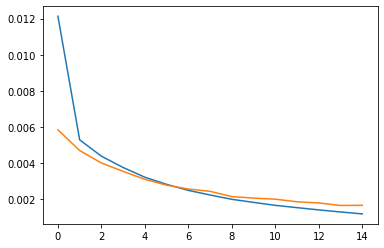

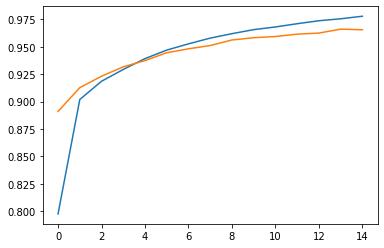

In [ ]:
from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 14
learning_rate = 0.0001

model = ClasificationNetwork3L().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)#,weight_decay=1e-6)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs.view(imgs.size(0),-1).type(torch.FloatTensor)
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      running_acc += acc

      pbar.set_postfix(batch_loss='{}'.format(loss.item()),batch_Accuracy='{}'.format(float(acc.item()/batch_size)))
      pbar.update(1)      
  
  val_loss,val_acc = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size)," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()


actual_label: 1 predicted_label: 1


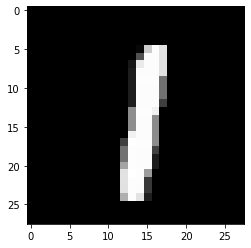

actual_label: 2 predicted_label: 2


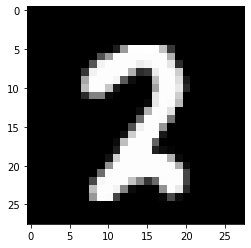

actual_label: 3 predicted_label: 3


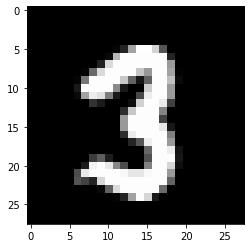

actual_label: 4 predicted_label: 4


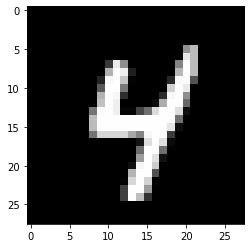

actual_label: 5 predicted_label: 5


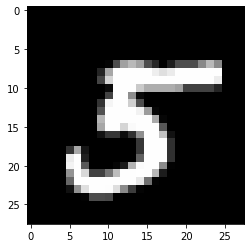

actual_label: 6 predicted_label: 6


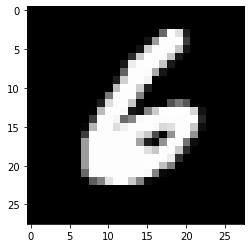

actual_label: 7 predicted_label: 7


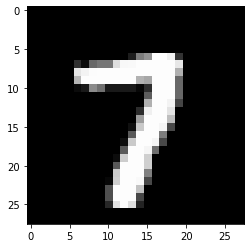

actual_label: 8 predicted_label: 8


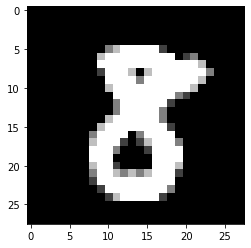

actual_label: 9 predicted_label: 9


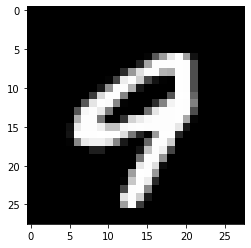

actual_label: 0 predicted_label: 0


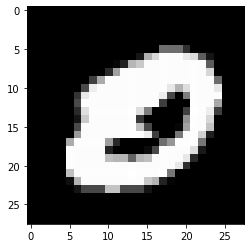


 test loss: 0.001521271012795186 test acc: 0.9658638535031847


In [ ]:
model.eval()
test_loss,test_acc = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc)

**tanh 3L**

cuda


100%|██████████| 750/750 [00:13<00:00, 54.89it/s, batch_Accuracy=0.921875, batch_loss=0.36395353078842163]



epoch: 0  Train Loss: 0.01321765553082029  Train Accuracy: tensor(0.8110, device='cuda:0')  Validation Loss: 0.006199735049604181  Validation Accuracy: 0.8992686170212766 



100%|██████████| 750/750 [00:13<00:00, 55.13it/s, batch_Accuracy=0.953125, batch_loss=0.18638211488723755]



epoch: 1  Train Loss: 0.005088397106776635  Train Accuracy: tensor(0.9128, device='cuda:0')  Validation Loss: 0.004214379801464445  Validation Accuracy: 0.9240359042553191 



100%|██████████| 750/750 [00:13<00:00, 55.05it/s, batch_Accuracy=0.90625, batch_loss=0.2553545832633972]



epoch: 2  Train Loss: 0.003781399014405906  Train Accuracy: tensor(0.9322, device='cuda:0')  Validation Loss: 0.0034066311615033747  Validation Accuracy: 0.9351728723404256 



100%|██████████| 750/750 [00:13<00:00, 55.17it/s, batch_Accuracy=0.9375, batch_loss=0.23689338564872742]



epoch: 3  Train Loss: 0.0030462857986179493  Train Accuracy: tensor(0.9442, device='cuda:0')  Validation Loss: 0.0027871383799913715  Validation Accuracy: 0.9471409574468085 



100%|██████████| 750/750 [00:13<00:00, 54.65it/s, batch_Accuracy=0.953125, batch_loss=0.12517748773097992]



epoch: 4  Train Loss: 0.002526284982760747  Train Accuracy: tensor(0.9533, device='cuda:0')  Validation Loss: 0.002508398365264045  Validation Accuracy: 0.9509640957446809 



100%|██████████| 750/750 [00:13<00:00, 53.87it/s, batch_Accuracy=0.953125, batch_loss=0.12871688604354858]



epoch: 5  Train Loss: 0.0021283584277067952  Train Accuracy: tensor(0.9613, device='cuda:0')  Validation Loss: 0.002149462578366164  Validation Accuracy: 0.9566988031914894 



100%|██████████| 750/750 [00:13<00:00, 55.12it/s, batch_Accuracy=0.9375, batch_loss=0.22037942707538605]



epoch: 6  Train Loss: 0.0018369090634708604  Train Accuracy: tensor(0.9669, device='cuda:0')  Validation Loss: 0.001927161943774294  Validation Accuracy: 0.9610206117021277 



100%|██████████| 750/750 [00:13<00:00, 54.29it/s, batch_Accuracy=0.984375, batch_loss=0.0556807667016983]



epoch: 7  Train Loss: 0.0016223079168315355  Train Accuracy: tensor(0.9704, device='cuda:0')  Validation Loss: 0.0018738186398045496  Validation Accuracy: 0.9605219414893617 



100%|██████████| 750/750 [00:13<00:00, 54.85it/s, batch_Accuracy=0.984375, batch_loss=0.04888444393873215]



epoch: 8  Train Loss: 0.0014071285182532544  Train Accuracy: tensor(0.9745, device='cuda:0')  Validation Loss: 0.0016930433340987408  Validation Accuracy: 0.9645113031914894 



100%|██████████| 750/750 [00:13<00:00, 54.57it/s, batch_Accuracy=0.96875, batch_loss=0.11493375897407532]



epoch: 9  Train Loss: 0.0012539375999282736  Train Accuracy: tensor(0.9775, device='cuda:0')  Validation Loss: 0.0015540853372782448  Validation Accuracy: 0.9665059840425532 



100%|██████████| 750/750 [00:13<00:00, 54.92it/s, batch_Accuracy=0.984375, batch_loss=0.03350163623690605]



epoch: 10  Train Loss: 0.001103542542133558  Train Accuracy: tensor(0.9796, device='cuda:0')  Validation Loss: 0.001483335022559449  Validation Accuracy: 0.96875 



100%|██████████| 750/750 [00:13<00:00, 54.80it/s, batch_Accuracy=0.984375, batch_loss=0.03737965598702431]



epoch: 11  Train Loss: 0.001005659695181142  Train Accuracy: tensor(0.9820, device='cuda:0')  Validation Loss: 0.001470735942619169  Validation Accuracy: 0.968251329787234 



100%|██████████| 750/750 [00:13<00:00, 55.56it/s, batch_Accuracy=1.0, batch_loss=0.03526405617594719]



epoch: 12  Train Loss: 0.0008954919678896355  Train Accuracy: tensor(0.9839, device='cuda:0')  Validation Loss: 0.0014270567005448182  Validation Accuracy: 0.9704953457446809 



100%|██████████| 750/750 [00:13<00:00, 54.73it/s, batch_Accuracy=1.0, batch_loss=0.040070902556180954]



epoch: 13  Train Loss: 0.000806175239563648  Train Accuracy: tensor(0.9854, device='cuda:0')  Validation Loss: 0.0013569800290458667  Validation Accuracy: 0.9704953457446809 



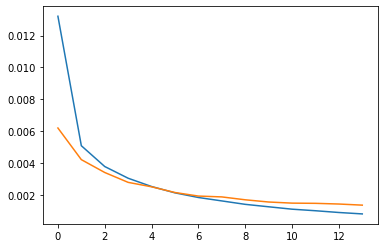

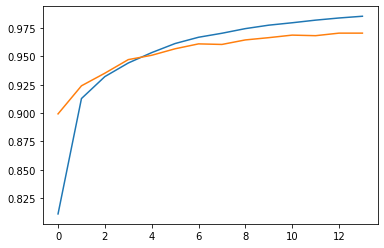

actual_label: 1 predicted_label: 1


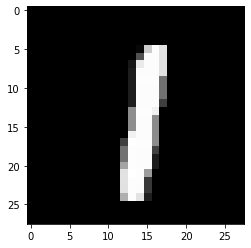

actual_label: 2 predicted_label: 2


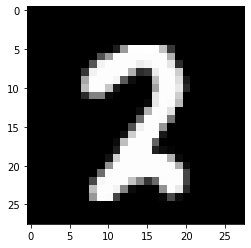

actual_label: 3 predicted_label: 3


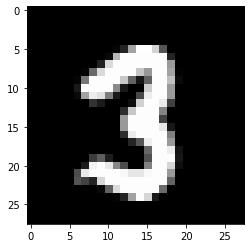

actual_label: 4 predicted_label: 4


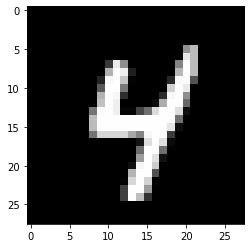

actual_label: 5 predicted_label: 5


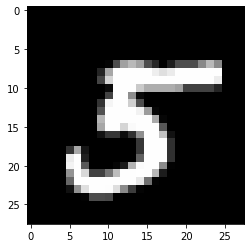

actual_label: 6 predicted_label: 6


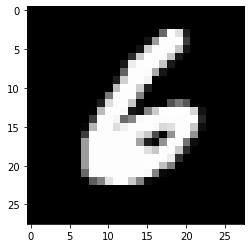

actual_label: 7 predicted_label: 7


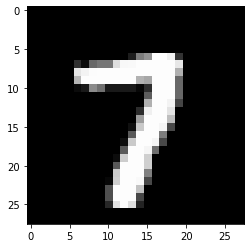

actual_label: 8 predicted_label: 8


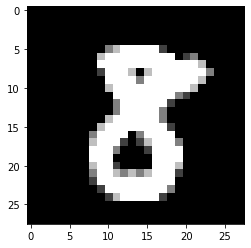

actual_label: 9 predicted_label: 9


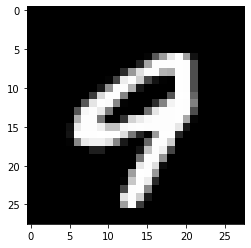

actual_label: 0 predicted_label: 0


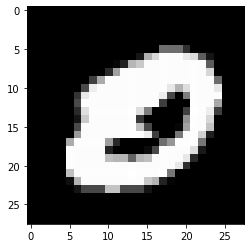


 test loss: 0.0012625255281111941 test acc: 0.9694466560509554


In [ ]:
class ClasificationNetwork3L(nn.Module):

  def __init__(self):
    super(ClasificationNetwork3L,self).__init__()
    
    self.fc = nn.Sequential(
        nn.Linear(28*28,256),
        nn.Tanh(),
        nn.Linear(256,128),
        nn.Tanh(),
        nn.Linear(128,64),
        nn.Tanh(),
        nn.Linear(64,10)
    )

  def forward(self,x):
    x=self.fc(x)
    return x
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        for imgs,lbls in dataloader:
            imgs = imgs.view(imgs.size(0),-1).type(torch.FloatTensor)
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls)
            
        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))

        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img)
              pred_lbl = out

              img_disp = img.view(1,28,28).permute(1,2,0).squeeze(2).detach().cpu().numpy()
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp)
              plt.imshow(img_disp,cmap='gray')
              plt.show()
                        
            return test_loss,test_acc
    
    return test_loss,test_acc


from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 14
learning_rate = 0.0001

model = ClasificationNetwork3L().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)#,weight_decay=1e-6)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs.view(imgs.size(0),-1).type(torch.FloatTensor)
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      running_acc += acc

      pbar.set_postfix(batch_loss='{}'.format(loss.item()),batch_Accuracy='{}'.format(float(acc.item()/batch_size)))
      pbar.update(1)      
  
  val_loss,val_acc = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size)," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()

model.eval()
test_loss,test_acc = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc)

#**Question 2** 

**Classification Task: 1 Layer**

In [ ]:

(X_train,Y_train),(X_test,Y_test)=mnist.load_data()
X_train,X_valid,Y_train,Y_valid = train_test_split(X_train,Y_train,test_size=0.2,random_state=21)

print("X_train:",X_train.shape)
print("X_valid:",X_valid.shape)
print("X_test:",X_test.shape)
print("Y_train:",Y_train.shape)
print("Y_valid:",Y_valid.shape)
print("Y_test:",Y_test.shape)

X_train: (48000, 28, 28)
X_valid: (12000, 28, 28)
X_test: (10000, 28, 28)
Y_train: (48000,)
Y_valid: (12000,)
Y_test: (10000,)


In [ ]:
class MNIST(Dataset):

  def __init__(self,image_dataset,labels,transform=None,target_transform=None):

      self.image_dataset = image_dataset
      self.labels = labels
      self.transform = transform
      self.target_transform = target_transform
  
  def __len__(self):
    return len(self.image_dataset)

  def __getitem__(self,idx):

    image = self.image_dataset[idx]
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)
    
    if self.target_transform:
      label = self.target_transform(label)
    
    return image,label
    

class ToTransform:

  def __call__(self,image):
      
    trans = T.Compose([ 
    T.ToTensor(),
    T.Normalize(
        mean = [0.5],
        std = [0.5]
        ) 
    ]) 

    image = trans(image)

    return image


class TargetTransform:

  def __call__(self,y):
    
    y = torch.tensor(y)

    return y


train_dataset = MNIST(X_train,Y_train,transform = ToTransform(),target_transform = TargetTransform())
valid_dataset = MNIST(X_valid,Y_valid,transform = ToTransform(),target_transform = TargetTransform())
test_dataset = MNIST(X_test,Y_test,transform = ToTransform(),target_transform = TargetTransform())

batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers = 0, shuffle=True)#,worker_init_fn = np.random.seed(42))
valid_dataloader = DataLoader(valid_dataset,batch_size=batch_size,num_workers = 0, shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers = 0,shuffle=False)



In [ ]:
class ClasificationNetwork1L(nn.Module):

  def __init__(self):
    super(ClasificationNetwork1L,self).__init__()
    
    self.fc = nn.Sequential(
        nn.Linear(28*28,128),
        nn.ReLU(True),
        nn.Linear(128,10)
    )

  def forward(self,x):
    x=self.fc(x)
    return x

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        for imgs,lbls in dataloader:
            imgs = imgs.view(imgs.size(0),-1).type(torch.FloatTensor)
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls)

        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))

        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img)
              pred_lbl = out

              img_disp = img.view(1,28,28).permute(1,2,0).squeeze(2).detach().cpu().numpy()
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp)
              plt.imshow(img_disp,cmap='gray')
              plt.show()
                        
            return test_loss,test_acc
    
    return test_loss,test_acc

100%|██████████| 750/750 [00:14<00:00, 51.87it/s, batch_Accuracy=0.875, batch_loss=0.362278550863266]



epoch: 0  Train Loss: 0.013031464238961538  Train Accuracy: tensor(0.8047, device='cuda:0') %  Validation Loss: 0.006790927579091426  Validation Accuracy: 0.882313829787234 % 



100%|██████████| 750/750 [00:14<00:00, 51.70it/s, batch_Accuracy=0.90625, batch_loss=0.4478852152824402]



epoch: 1  Train Loss: 0.006051335275483628  Train Accuracy: tensor(0.8932, device='cuda:0') %  Validation Loss: 0.005371353657732896  Validation Accuracy: 0.9005984042553191 % 



100%|██████████| 750/750 [00:14<00:00, 52.41it/s, batch_Accuracy=0.921875, batch_loss=0.29267048835754395]



epoch: 2  Train Loss: 0.005144727648856739  Train Accuracy: tensor(0.9050, device='cuda:0') %  Validation Loss: 0.004894824250244555  Validation Accuracy: 0.9088264627659575 % 



100%|██████████| 750/750 [00:14<00:00, 52.66it/s, batch_Accuracy=0.9375, batch_loss=0.1976761519908905]



epoch: 3  Train Loss: 0.004637663461733609  Train Accuracy: tensor(0.9149, device='cuda:0') %  Validation Loss: 0.004387678437930671  Validation Accuracy: 0.9173869680851063 % 



100%|██████████| 750/750 [00:14<00:00, 52.30it/s, batch_Accuracy=0.921875, batch_loss=0.2558833360671997]



epoch: 4  Train Loss: 0.004253004471150537  Train Accuracy: tensor(0.9224, device='cuda:0') %  Validation Loss: 0.004058163531342561  Validation Accuracy: 0.9254488031914894 % 



100%|██████████| 750/750 [00:14<00:00, 52.69it/s, batch_Accuracy=0.875, batch_loss=0.2912656366825104]



epoch: 5  Train Loss: 0.003921778318316986  Train Accuracy: tensor(0.9291, device='cuda:0') %  Validation Loss: 0.0038239572440556427  Validation Accuracy: 0.929188829787234 % 



100%|██████████| 750/750 [00:14<00:00, 52.83it/s, batch_Accuracy=0.875, batch_loss=0.36165204644203186]



epoch: 6  Train Loss: 0.003617363190666462  Train Accuracy: tensor(0.9345, device='cuda:0') %  Validation Loss: 0.0035096719542746136  Validation Accuracy: 0.9345079787234043 % 



100%|██████████| 750/750 [00:14<00:00, 52.46it/s, batch_Accuracy=0.953125, batch_loss=0.21789142489433289]



epoch: 7  Train Loss: 0.003368629925108204  Train Accuracy: tensor(0.9389, device='cuda:0') %  Validation Loss: 0.003340117482560132  Validation Accuracy: 0.9370844414893617 % 



100%|██████████| 750/750 [00:14<00:00, 52.42it/s, batch_Accuracy=0.984375, batch_loss=0.12982280552387238]



epoch: 8  Train Loss: 0.003134347644634545  Train Accuracy: tensor(0.9435, device='cuda:0') %  Validation Loss: 0.0031031759098504095  Validation Accuracy: 0.9414893617021277 % 



100%|██████████| 750/750 [00:14<00:00, 51.55it/s, batch_Accuracy=0.96875, batch_loss=0.10562581568956375]



epoch: 9  Train Loss: 0.0029244934115558864  Train Accuracy: tensor(0.9468, device='cuda:0') %  Validation Loss: 0.002928692735719217  Validation Accuracy: 0.9446476063829787 % 



100%|██████████| 750/750 [00:14<00:00, 52.67it/s, batch_Accuracy=0.984375, batch_loss=0.10489533841609955]



epoch: 10  Train Loss: 0.0027473287798153857  Train Accuracy: tensor(0.9498, device='cuda:0') %  Validation Loss: 0.002779589830947287  Validation Accuracy: 0.9475565159574468 % 



100%|██████████| 750/750 [00:14<00:00, 52.85it/s, batch_Accuracy=0.921875, batch_loss=0.30392253398895264]



epoch: 11  Train Loss: 0.002569653636853521  Train Accuracy: tensor(0.9536, device='cuda:0') %  Validation Loss: 0.002668129318292213  Validation Accuracy: 0.9491356382978723 % 



100%|██████████| 750/750 [00:14<00:00, 53.21it/s, batch_Accuracy=0.96875, batch_loss=0.14186005294322968]



epoch: 12  Train Loss: 0.002426062084773245  Train Accuracy: tensor(0.9561, device='cuda:0') %  Validation Loss: 0.0025398293782540773  Validation Accuracy: 0.9507978723404256 % 



100%|██████████| 750/750 [00:14<00:00, 53.25it/s, batch_Accuracy=0.984375, batch_loss=0.06938029080629349]



epoch: 13  Train Loss: 0.0022859988211033247  Train Accuracy: tensor(0.9587, device='cuda:0') %  Validation Loss: 0.0024149739270177767  Validation Accuracy: 0.9529587765957447 % 



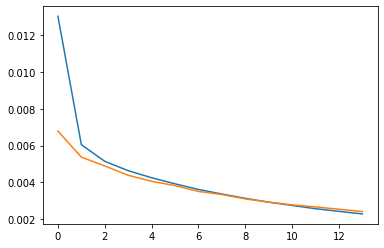

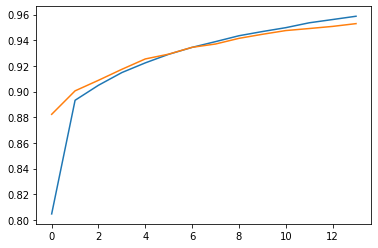

In [ ]:
from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 14
learning_rate = 0.0001

model = ClasificationNetwork1L().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)#,weight_decay=1e-6)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs.view(imgs.size(0),-1).type(torch.FloatTensor)
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      running_acc += acc

      pbar.set_postfix(batch_loss='{}'.format(loss.item()),batch_Accuracy='{}'.format(float(acc.item()/batch_size)))
      pbar.update(1)      
  
  val_loss,val_acc = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size),"%"," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"%","\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()


actual_label: 1 predicted_label: 1


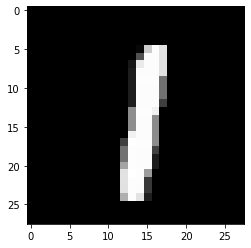

actual_label: 2 predicted_label: 2


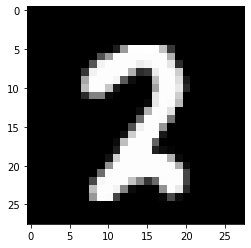

actual_label: 3 predicted_label: 3


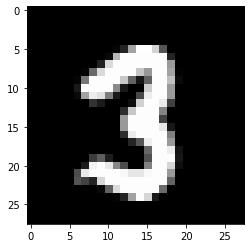

actual_label: 4 predicted_label: 4


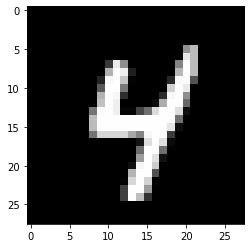

actual_label: 5 predicted_label: 5


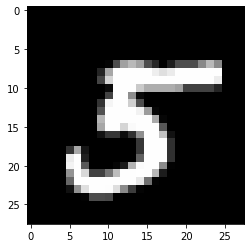

actual_label: 6 predicted_label: 6


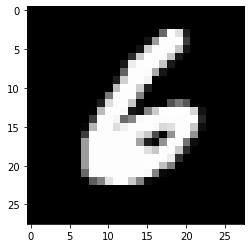

actual_label: 7 predicted_label: 7


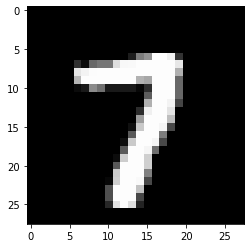

actual_label: 8 predicted_label: 8


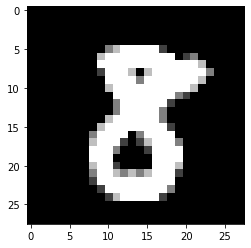

actual_label: 9 predicted_label: 9


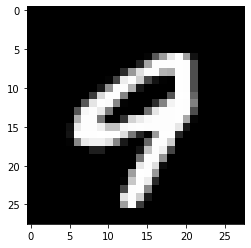

actual_label: 0 predicted_label: 0


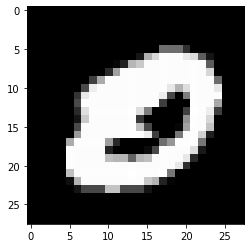


 test loss: 0.0022934300921487348 test acc: 0.9539211783439491 %


In [ ]:
model.eval()
test_loss,test_acc = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc,"%")

**tanh 1L**

cuda


100%|██████████| 750/750 [00:14<00:00, 51.70it/s, batch_Accuracy=0.9375, batch_loss=0.2747921347618103]



epoch: 0  Train Loss: 0.0128007235173136  Train Accuracy: tensor(0.8155, device='cuda:0') %  Validation Loss: 0.006851188761697329  Validation Accuracy: 0.8863031914893617 % 



100%|██████████| 750/750 [00:14<00:00, 51.99it/s, batch_Accuracy=0.890625, batch_loss=0.30221492052078247]



epoch: 1  Train Loss: 0.0059187524278337756  Train Accuracy: tensor(0.8969, device='cuda:0') %  Validation Loss: 0.0052119531232784405  Validation Accuracy: 0.9053357712765957 % 



100%|██████████| 750/750 [00:14<00:00, 52.45it/s, batch_Accuracy=0.953125, batch_loss=0.1646205633878708]



epoch: 2  Train Loss: 0.004855003276839852  Train Accuracy: tensor(0.9120, device='cuda:0') %  Validation Loss: 0.004495532469244357  Validation Accuracy: 0.9168882978723404 % 



100%|██████████| 750/750 [00:14<00:00, 53.31it/s, batch_Accuracy=0.90625, batch_loss=0.28098437190055847]



epoch: 3  Train Loss: 0.004288262899344166  Train Accuracy: tensor(0.9215, device='cuda:0') %  Validation Loss: 0.004068306376018185  Validation Accuracy: 0.9251163563829787 % 



100%|██████████| 750/750 [00:14<00:00, 50.97it/s, batch_Accuracy=0.953125, batch_loss=0.1728162169456482]



epoch: 4  Train Loss: 0.0038796235914342106  Train Accuracy: tensor(0.9289, device='cuda:0') %  Validation Loss: 0.0037462405666604916  Validation Accuracy: 0.9298537234042553 % 



100%|██████████| 750/750 [00:14<00:00, 51.80it/s, batch_Accuracy=0.96875, batch_loss=0.25725898146629333]



epoch: 5  Train Loss: 0.0035460985138391454  Train Accuracy: tensor(0.9359, device='cuda:0') %  Validation Loss: 0.0035148467144066903  Validation Accuracy: 0.9325132978723404 % 



100%|██████████| 750/750 [00:14<00:00, 51.20it/s, batch_Accuracy=0.984375, batch_loss=0.1455496996641159]



epoch: 6  Train Loss: 0.0032655222708514583  Train Accuracy: tensor(0.9406, device='cuda:0') %  Validation Loss: 0.0032803939452315583  Validation Accuracy: 0.9375831117021277 % 



100%|██████████| 750/750 [00:14<00:00, 51.21it/s, batch_Accuracy=0.953125, batch_loss=0.2929471731185913]



epoch: 7  Train Loss: 0.0030222757329853873  Train Accuracy: tensor(0.9454, device='cuda:0') %  Validation Loss: 0.0031107767491893685  Validation Accuracy: 0.9410738031914894 % 



100%|██████████| 750/750 [00:14<00:00, 51.42it/s, batch_Accuracy=0.984375, batch_loss=0.08886368572711945]



epoch: 8  Train Loss: 0.0028167017463905115  Train Accuracy: tensor(0.9491, device='cuda:0') %  Validation Loss: 0.002928362297639746  Validation Accuracy: 0.9437333776595744 % 



100%|██████████| 750/750 [00:14<00:00, 51.11it/s, batch_Accuracy=0.9375, batch_loss=0.24520522356033325]



epoch: 9  Train Loss: 0.002632205035847922  Train Accuracy: tensor(0.9522, device='cuda:0') %  Validation Loss: 0.002754369361122991  Validation Accuracy: 0.9457280585106383 % 



100%|██████████| 750/750 [00:14<00:00, 51.89it/s, batch_Accuracy=0.953125, batch_loss=0.10236618667840958]



epoch: 10  Train Loss: 0.0024711308256955816  Train Accuracy: tensor(0.9556, device='cuda:0') %  Validation Loss: 0.002639503792260199  Validation Accuracy: 0.9490525265957447 % 



100%|██████████| 750/750 [00:14<00:00, 52.69it/s, batch_Accuracy=0.984375, batch_loss=0.05724562704563141]



epoch: 11  Train Loss: 0.002324783538118936  Train Accuracy: tensor(0.9581, device='cuda:0') %  Validation Loss: 0.002526004535227796  Validation Accuracy: 0.9506316489361702 % 



100%|██████████| 750/750 [00:14<00:00, 52.63it/s, batch_Accuracy=0.953125, batch_loss=0.185522198677063]



epoch: 12  Train Loss: 0.002195434890454635  Train Accuracy: tensor(0.9603, device='cuda:0') %  Validation Loss: 0.0024390996678700138  Validation Accuracy: 0.9515458776595744 % 



100%|██████████| 750/750 [00:14<00:00, 52.56it/s, batch_Accuracy=1.0, batch_loss=0.025222446769475937]



epoch: 13  Train Loss: 0.0020682115325471387  Train Accuracy: tensor(0.9635, device='cuda:0') %  Validation Loss: 0.002352954668861051  Validation Accuracy: 0.952875664893617 % 



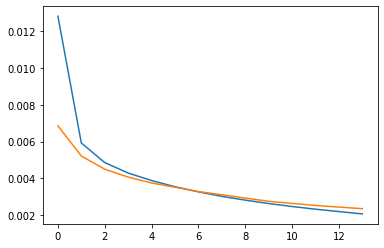

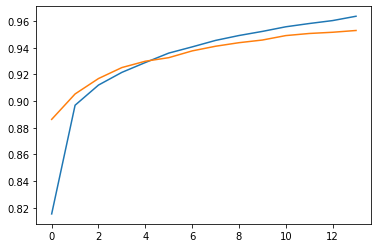

actual_label: 1 predicted_label: 1


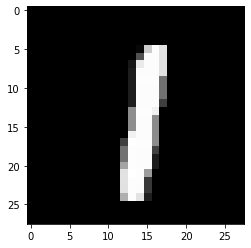

actual_label: 2 predicted_label: 2


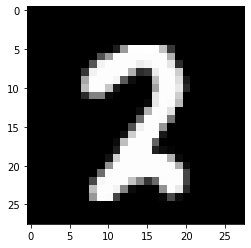

actual_label: 3 predicted_label: 3


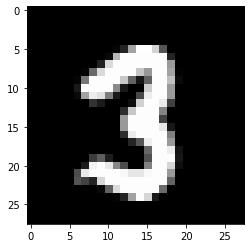

actual_label: 4 predicted_label: 4


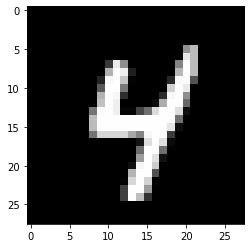

actual_label: 5 predicted_label: 5


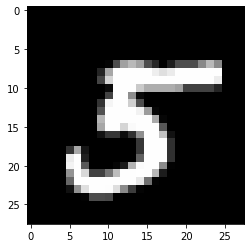

actual_label: 6 predicted_label: 6


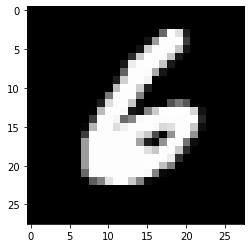

actual_label: 7 predicted_label: 7


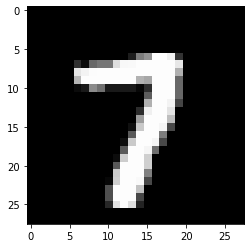

actual_label: 8 predicted_label: 8


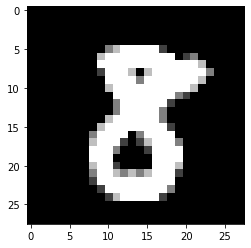

actual_label: 9 predicted_label: 9


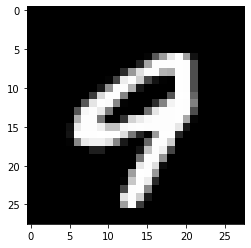

actual_label: 0 predicted_label: 0


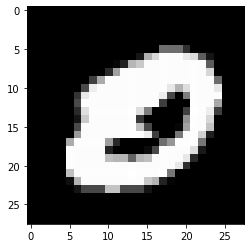


 test loss: 0.0022056165056664255 test acc: 0.955015923566879 %


In [ ]:
class ClasificationNetwork1L(nn.Module):

  def __init__(self):
    super(ClasificationNetwork1L,self).__init__()
    
    self.fc = nn.Sequential(
        nn.Linear(28*28,128),
        nn.Tanh(),
        nn.Linear(128,10)
    )

  def forward(self,x):
    x=self.fc(x)
    return x

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        for imgs,lbls in dataloader:
            imgs = imgs.view(imgs.size(0),-1).type(torch.FloatTensor)
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls)

        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))

        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img)
              pred_lbl = out

              img_disp = img.view(1,28,28).permute(1,2,0).squeeze(2).detach().cpu().numpy()
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp)
              plt.imshow(img_disp,cmap='gray')
              plt.show()
                        
            return test_loss,test_acc
    
    return test_loss,test_acc

from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 14
learning_rate = 0.0001

model = ClasificationNetwork1L().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)#,weight_decay=1e-6)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs.view(imgs.size(0),-1).type(torch.FloatTensor)
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      running_acc += acc

      pbar.set_postfix(batch_loss='{}'.format(loss.item()),batch_Accuracy='{}'.format(float(acc.item()/batch_size)))
      pbar.update(1)      
  
  val_loss,val_acc = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size),"%"," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"%","\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()

model.eval()
test_loss,test_acc = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc,"%")

#**Question 3** 

**1. Conv-Conv-Pool-Conv-Conv-Pool-FC-FC**



In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import torchvision.datasets as datasets
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
from torch.utils.data import random_split


# (a)
**maxpool - (2,2)**

**stride - 1**

Files already downloaded and verified
Files already downloaded and verified
trainset: 45000
validationset: 5000
testset: 10000


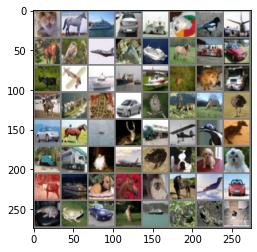

tensor([3, 7, 8, 1, 8, 5, 2, 0, 7, 2, 0, 2, 8, 7, 9, 1, 4, 0, 8, 8, 0, 4, 5, 9,
        7, 8, 6, 1, 2, 4, 5, 2, 1, 7, 8, 4, 9, 0, 2, 2, 9, 9, 3, 0, 6, 5, 5, 5,
        4, 8, 5, 7, 5, 7, 0, 1, 3, 6, 1, 4, 8, 6, 6, 3])
cuda


100%|██████████| 704/704 [00:21<00:00, 32.59it/s, batch_loss=2.244810104370117]



epoch: 0  Train Loss: 0.0354652411240915  Train Accuracy: 0.16306374289772727 train_correct: 7347 train_incorrect: 37653  Validation Loss: 0.0343491901891141  Validation Accuracy: 0.21281645569620253 correct: 1076 incorrect: 3924 



100%|██████████| 704/704 [00:21<00:00, 32.52it/s, batch_loss=2.1499271392822266]



epoch: 1  Train Loss: 0.03322229280390523  Train Accuracy: 0.23677201704545456 train_correct: 10668 train_incorrect: 34332  Validation Loss: 0.03268483637160138  Validation Accuracy: 0.24861550632911392 correct: 1257 incorrect: 3743 



100%|██████████| 704/704 [00:22<00:00, 31.50it/s, batch_loss=1.9241317510604858]



epoch: 2  Train Loss: 0.032128804860721255  Train Accuracy: 0.2689763849431818 train_correct: 12119 train_incorrect: 32881  Validation Loss: 0.031862142106777507  Validation Accuracy: 0.2735363924050633 correct: 1383 incorrect: 3617 



100%|██████████| 704/704 [00:21<00:00, 32.53it/s, batch_loss=1.8591525554656982]



epoch: 3  Train Loss: 0.03134122615235604  Train Accuracy: 0.2911931818181818 train_correct: 13120 train_incorrect: 31880  Validation Loss: 0.03099205151577539  Validation Accuracy: 0.29489715189873417 correct: 1491 incorrect: 3509 



100%|██████████| 704/704 [00:21<00:00, 32.63it/s, batch_loss=1.4642609357833862]



epoch: 4  Train Loss: 0.030446719370295548  Train Accuracy: 0.313720703125 train_correct: 14135 train_incorrect: 30865  Validation Loss: 0.030063371563070936  Validation Accuracy: 0.3142800632911392 correct: 1589 incorrect: 3411 



100%|██████████| 704/704 [00:21<00:00, 32.70it/s, batch_loss=1.833138108253479]



epoch: 5  Train Loss: 0.02939794300155799  Train Accuracy: 0.3396661931818182 train_correct: 15304 train_incorrect: 29696  Validation Loss: 0.028952325210918353  Validation Accuracy: 0.34117879746835444 correct: 1725 incorrect: 3275 



100%|██████████| 704/704 [00:21<00:00, 32.55it/s, batch_loss=1.84697687625885]



epoch: 6  Train Loss: 0.028557368183762512  Train Accuracy: 0.3557794744318182 train_correct: 16030 train_incorrect: 28970  Validation Loss: 0.028241471304923674  Validation Accuracy: 0.3583860759493671 correct: 1812 incorrect: 3188 



100%|██████████| 704/704 [00:21<00:00, 32.84it/s, batch_loss=2.0847675800323486]



epoch: 7  Train Loss: 0.027888897637074642  Train Accuracy: 0.3698064630681818 train_correct: 16662 train_incorrect: 28338  Validation Loss: 0.02763905395058137  Validation Accuracy: 0.36985759493670883 correct: 1870 incorrect: 3130 



100%|██████████| 704/704 [00:21<00:00, 32.67it/s, batch_loss=1.5433052778244019]



epoch: 8  Train Loss: 0.027291871908925135  Train Accuracy: 0.38398881392045453 train_correct: 17301 train_incorrect: 27699  Validation Loss: 0.02714055637487128  Validation Accuracy: 0.37994462025316456 correct: 1921 incorrect: 3079 



100%|██████████| 704/704 [00:21<00:00, 32.63it/s, batch_loss=1.5725088119506836]



epoch: 9  Train Loss: 0.02686897962121293  Train Accuracy: 0.39066938920454547 train_correct: 17602 train_incorrect: 27398  Validation Loss: 0.026896325541259366  Validation Accuracy: 0.38350474683544306 correct: 1939 incorrect: 3061 



100%|██████████| 704/704 [00:21<00:00, 32.57it/s, batch_loss=1.5449310541152954]



epoch: 10  Train Loss: 0.02654877355036495  Train Accuracy: 0.3974831321022727 train_correct: 17909 train_incorrect: 27091  Validation Loss: 0.02653363629986968  Validation Accuracy: 0.3912183544303797 correct: 1978 incorrect: 3022 



100%|██████████| 704/704 [00:21<00:00, 32.65it/s, batch_loss=2.024833917617798]



epoch: 11  Train Loss: 0.026300103197255256  Train Accuracy: 0.4037863991477273 train_correct: 18193 train_incorrect: 26807  Validation Loss: 0.02640240882299369  Validation Accuracy: 0.395371835443038 correct: 1999 incorrect: 3001 



100%|██████████| 704/704 [00:21<00:00, 32.58it/s, batch_loss=1.8498339653015137]



epoch: 12  Train Loss: 0.026065377859843218  Train Accuracy: 0.4062721946022727 train_correct: 18305 train_incorrect: 26695  Validation Loss: 0.026080040756282927  Validation Accuracy: 0.40704113924050633 correct: 2058 incorrect: 2942 



100%|██████████| 704/704 [00:21<00:00, 32.40it/s, batch_loss=2.6601908206939697]



epoch: 13  Train Loss: 0.025821899947583337  Train Accuracy: 0.4135520241477273 train_correct: 18633 train_incorrect: 26367  Validation Loss: 0.025964799136677874  Validation Accuracy: 0.40625 correct: 2054 incorrect: 2946 



100%|██████████| 704/704 [00:21<00:00, 32.53it/s, batch_loss=1.365138053894043]



epoch: 14  Train Loss: 0.02557311309713193  Train Accuracy: 0.41834605823863635 train_correct: 18849 train_incorrect: 26151  Validation Loss: 0.02564752132549316  Validation Accuracy: 0.4143591772151899 correct: 2095 incorrect: 2905 



100%|██████████| 704/704 [00:21<00:00, 32.22it/s, batch_loss=1.3704538345336914]



epoch: 15  Train Loss: 0.025332768212220715  Train Accuracy: 0.42305131392045453 train_correct: 19061 train_incorrect: 25939  Validation Loss: 0.02575195627876475  Validation Accuracy: 0.4129746835443038 correct: 2088 incorrect: 2912 



100%|██████████| 704/704 [00:21<00:00, 32.42it/s, batch_loss=1.0603994131088257]



epoch: 16  Train Loss: 0.02505502549783242  Train Accuracy: 0.4297096946022727 train_correct: 19361 train_incorrect: 25639  Validation Loss: 0.02528034695247306  Validation Accuracy: 0.42444620253164556 correct: 2146 incorrect: 2854 



100%|██████████| 704/704 [00:21<00:00, 32.99it/s, batch_loss=1.3553627729415894]



epoch: 17  Train Loss: 0.02476224179686555  Train Accuracy: 0.43641246448863635 train_correct: 19663 train_incorrect: 25337  Validation Loss: 0.024960388134740576  Validation Accuracy: 0.42583069620253167 correct: 2153 incorrect: 2847 



100%|██████████| 704/704 [00:21<00:00, 32.76it/s, batch_loss=2.0120596885681152]



epoch: 18  Train Loss: 0.02451565525949594  Train Accuracy: 0.44145063920454547 train_correct: 19890 train_incorrect: 25110  Validation Loss: 0.025206482344413104  Validation Accuracy: 0.42147943037974683 correct: 2131 incorrect: 2869 



100%|██████████| 704/704 [00:21<00:00, 32.57it/s, batch_loss=1.0797046422958374]



epoch: 19  Train Loss: 0.02428977793897502  Train Accuracy: 0.4469992897727273 train_correct: 20140 train_incorrect: 24860  Validation Loss: 0.024740388899852958  Validation Accuracy: 0.43473101265822783 correct: 2198 incorrect: 2802 



100%|██████████| 704/704 [00:21<00:00, 32.69it/s, batch_loss=1.228271245956421]



epoch: 20  Train Loss: 0.02407494561471553  Train Accuracy: 0.44941850142045453 train_correct: 20249 train_incorrect: 24751  Validation Loss: 0.024708563815566558  Validation Accuracy: 0.4365110759493671 correct: 2207 incorrect: 2793 



100%|██████████| 704/704 [00:21<00:00, 32.62it/s, batch_loss=2.197782039642334]



epoch: 21  Train Loss: 0.02384197701361369  Train Accuracy: 0.4566317471590909 train_correct: 20574 train_incorrect: 24426  Validation Loss: 0.024100214148624035  Validation Accuracy: 0.4408623417721519 correct: 2229 incorrect: 2771 



100%|██████████| 704/704 [00:21<00:00, 32.66it/s, batch_loss=1.3585147857666016]



epoch: 22  Train Loss: 0.02358508841346272  Train Accuracy: 0.4626242897727273 train_correct: 20844 train_incorrect: 24156  Validation Loss: 0.02394073739459243  Validation Accuracy: 0.4465981012658228 correct: 2258 incorrect: 2742 



100%|██████████| 704/704 [00:21<00:00, 32.83it/s, batch_loss=1.2454454898834229]



epoch: 23  Train Loss: 0.023417563778242435  Train Accuracy: 0.46937144886363635 train_correct: 21148 train_incorrect: 23852  Validation Loss: 0.023730331748912606  Validation Accuracy: 0.45154272151898733 correct: 2283 incorrect: 2717 



100%|██████████| 704/704 [00:21<00:00, 32.56it/s, batch_loss=1.6228407621383667]



epoch: 24  Train Loss: 0.023243327672720294  Train Accuracy: 0.47099165482954547 train_correct: 21221 train_incorrect: 23779  Validation Loss: 0.0238644030841091  Validation Accuracy: 0.4553006329113924 correct: 2302 incorrect: 2698 



100%|██████████| 704/704 [00:21<00:00, 32.59it/s, batch_loss=0.9070377945899963]



epoch: 25  Train Loss: 0.023024896801375275  Train Accuracy: 0.4781161221590909 train_correct: 21542 train_incorrect: 23458  Validation Loss: 0.02368327850310863  Validation Accuracy: 0.4541139240506329 correct: 2296 incorrect: 2704 



100%|██████████| 704/704 [00:21<00:00, 32.33it/s, batch_loss=1.4797961711883545]



epoch: 26  Train Loss: 0.022825178867523475  Train Accuracy: 0.4811789772727273 train_correct: 21680 train_incorrect: 23320  Validation Loss: 0.02321326426124271  Validation Accuracy: 0.4634098101265823 correct: 2343 incorrect: 2657 



100%|██████████| 704/704 [00:21<00:00, 32.59it/s, batch_loss=1.7551984786987305]



epoch: 27  Train Loss: 0.022654490516288206  Train Accuracy: 0.4873046875 train_correct: 21956 train_incorrect: 23044  Validation Loss: 0.02302528592416003  Validation Accuracy: 0.4697389240506329 correct: 2375 incorrect: 2625 



100%|██████████| 704/704 [00:21<00:00, 32.26it/s, batch_loss=1.7386059761047363]



epoch: 28  Train Loss: 0.022393624422627247  Train Accuracy: 0.4921653053977273 train_correct: 22175 train_incorrect: 22825  Validation Loss: 0.02283401577438735  Validation Accuracy: 0.4729034810126582 correct: 2391 incorrect: 2609 



100%|██████████| 704/704 [00:21<00:00, 32.36it/s, batch_loss=1.2253819704055786]



epoch: 29  Train Loss: 0.022226404679134826  Train Accuracy: 0.4996892755681818 train_correct: 22514 train_incorrect: 22486  Validation Loss: 0.022572819685822802  Validation Accuracy: 0.4825949367088608 correct: 2440 incorrect: 2560 



100%|██████████| 704/704 [00:21<00:00, 33.25it/s, batch_loss=1.215728759765625]



epoch: 30  Train Loss: 0.022025286765049466  Train Accuracy: 0.5044389204545454 train_correct: 22728 train_incorrect: 22272  Validation Loss: 0.022586458563050138  Validation Accuracy: 0.484375 correct: 2449 incorrect: 2551 



100%|██████████| 704/704 [00:21<00:00, 32.82it/s, batch_loss=1.402619481086731]



epoch: 31  Train Loss: 0.02184375575267371  Train Accuracy: 0.5096102627840909 train_correct: 22961 train_incorrect: 22039  Validation Loss: 0.022207449626507638  Validation Accuracy: 0.49683544303797467 correct: 2512 incorrect: 2488 



100%|██████████| 704/704 [00:21<00:00, 32.36it/s, batch_loss=0.8080220818519592]



epoch: 32  Train Loss: 0.02165862985235766  Train Accuracy: 0.5126731178977273 train_correct: 23099 train_incorrect: 21901  Validation Loss: 0.022304408417283733  Validation Accuracy: 0.4853639240506329 correct: 2454 incorrect: 2546 



100%|██████████| 704/704 [00:21<00:00, 32.74it/s, batch_loss=0.8278527855873108]



epoch: 33  Train Loss: 0.021487665628559294  Train Accuracy: 0.5179110440340909 train_correct: 23335 train_incorrect: 21665  Validation Loss: 0.021889702216545237  Validation Accuracy: 0.5021756329113924 correct: 2539 incorrect: 2461 



100%|██████████| 704/704 [00:21<00:00, 32.90it/s, batch_loss=1.3263723850250244]



epoch: 34  Train Loss: 0.021301744144610977  Train Accuracy: 0.5218838778409091 train_correct: 23514 train_incorrect: 21486  Validation Loss: 0.021939950488224814  Validation Accuracy: 0.5011867088607594 correct: 2534 incorrect: 2466 



100%|██████████| 704/704 [00:21<00:00, 32.88it/s, batch_loss=0.9391157627105713]



epoch: 35  Train Loss: 0.02113467486263041  Train Accuracy: 0.5253684303977273 train_correct: 23671 train_incorrect: 21329  Validation Loss: 0.02172598068284083  Validation Accuracy: 0.5112737341772152 correct: 2585 incorrect: 2415 



100%|██████████| 704/704 [00:21<00:00, 32.42it/s, batch_loss=1.4471474885940552]



epoch: 36  Train Loss: 0.02092899444555356  Train Accuracy: 0.5333806818181818 train_correct: 24032 train_incorrect: 20968  Validation Loss: 0.02155602049035362  Validation Accuracy: 0.5172072784810127 correct: 2615 incorrect: 2385 



100%|██████████| 704/704 [00:21<00:00, 32.42it/s, batch_loss=0.9164116978645325]



epoch: 37  Train Loss: 0.020764023031171582  Train Accuracy: 0.5361772017045454 train_correct: 24158 train_incorrect: 20842  Validation Loss: 0.021371455108628996  Validation Accuracy: 0.521756329113924 correct: 2638 incorrect: 2362 



100%|██████████| 704/704 [00:21<00:00, 32.07it/s, batch_loss=1.959404706954956]



epoch: 38  Train Loss: 0.020583414450150238  Train Accuracy: 0.5401056463068182 train_correct: 24335 train_incorrect: 20665  Validation Loss: 0.02130849192602725  Validation Accuracy: 0.5215585443037974 correct: 2637 incorrect: 2363 



100%|██████████| 704/704 [00:21<00:00, 32.30it/s, batch_loss=1.8294799327850342]



epoch: 39  Train Loss: 0.020426327668246813  Train Accuracy: 0.5459872159090909 train_correct: 24600 train_incorrect: 20400  Validation Loss: 0.021243729593255854  Validation Accuracy: 0.5296677215189873 correct: 2678 incorrect: 2322 



100%|██████████| 704/704 [00:22<00:00, 31.96it/s, batch_loss=1.430428147315979]



epoch: 40  Train Loss: 0.02026064405535263  Train Accuracy: 0.5484952059659091 train_correct: 24713 train_incorrect: 20287  Validation Loss: 0.020975596731222127  Validation Accuracy: 0.5322389240506329 correct: 2691 incorrect: 2309 



100%|██████████| 704/704 [00:22<00:00, 31.99it/s, batch_loss=1.632201910018921]



epoch: 41  Train Loss: 0.020096975403827277  Train Accuracy: 0.5517800071022727 train_correct: 24861 train_incorrect: 20139  Validation Loss: 0.02056942601935773  Validation Accuracy: 0.5423259493670886 correct: 2742 incorrect: 2258 



100%|██████████| 704/704 [00:22<00:00, 31.88it/s, batch_loss=1.0343526601791382]



epoch: 42  Train Loss: 0.019980751341790892  Train Accuracy: 0.5552201704545454 train_correct: 25016 train_incorrect: 19984  Validation Loss: 0.020551522781105735  Validation Accuracy: 0.542128164556962 correct: 2741 incorrect: 2259 



100%|██████████| 704/704 [00:21<00:00, 32.46it/s, batch_loss=1.9758944511413574]



epoch: 43  Train Loss: 0.019821694548061878  Train Accuracy: 0.5579944957386364 train_correct: 25141 train_incorrect: 19859  Validation Loss: 0.020373639273398286  Validation Accuracy: 0.5460838607594937 correct: 2761 incorrect: 2239 



100%|██████████| 704/704 [00:21<00:00, 32.71it/s, batch_loss=1.4910986423492432]



epoch: 44  Train Loss: 0.01968143810518086  Train Accuracy: 0.5611683238636364 train_correct: 25284 train_incorrect: 19716  Validation Loss: 0.02070525171871804  Validation Accuracy: 0.5338212025316456 correct: 2699 incorrect: 2301 



100%|██████████| 704/704 [00:21<00:00, 32.26it/s, batch_loss=1.2131247520446777]



epoch: 45  Train Loss: 0.01957824819096872  Train Accuracy: 0.5658735795454546 train_correct: 25496 train_incorrect: 19504  Validation Loss: 0.02027122943980407  Validation Accuracy: 0.5490506329113924 correct: 2776 incorrect: 2224 



100%|██████████| 704/704 [00:21<00:00, 32.52it/s, batch_loss=2.3047566413879395]



epoch: 46  Train Loss: 0.019447855737367223  Train Accuracy: 0.5690252130681818 train_correct: 25638 train_incorrect: 19362  Validation Loss: 0.02012975414908385  Validation Accuracy: 0.5537974683544303 correct: 2800 incorrect: 2200 



100%|██████████| 704/704 [00:21<00:00, 32.12it/s, batch_loss=1.4588338136672974]



epoch: 47  Train Loss: 0.01931671994547783  Train Accuracy: 0.56982421875 train_correct: 25674 train_incorrect: 19326  Validation Loss: 0.019892528158011315  Validation Accuracy: 0.5561708860759493 correct: 2812 incorrect: 2188 



100%|██████████| 704/704 [00:21<00:00, 32.17it/s, batch_loss=0.8694973587989807]



epoch: 48  Train Loss: 0.01921021617520389  Train Accuracy: 0.5732199928977273 train_correct: 25827 train_incorrect: 19173  Validation Loss: 0.019972377421357965  Validation Accuracy: 0.5514240506329114 correct: 2788 incorrect: 2212 



100%|██████████| 704/704 [00:21<00:00, 32.37it/s, batch_loss=1.083857536315918]



epoch: 49  Train Loss: 0.019129393775735727  Train Accuracy: 0.5764825994318182 train_correct: 25974 train_incorrect: 19026  Validation Loss: 0.0198100489340251  Validation Accuracy: 0.5591376582278481 correct: 2827 incorrect: 2173 



100%|██████████| 704/704 [00:21<00:00, 32.32it/s, batch_loss=0.5795551538467407]



epoch: 50  Train Loss: 0.019048992662150835  Train Accuracy: 0.5774813565340909 train_correct: 26019 train_incorrect: 18981  Validation Loss: 0.019677744860041747  Validation Accuracy: 0.5706091772151899 correct: 2885 incorrect: 2115 



100%|██████████| 704/704 [00:21<00:00, 32.66it/s, batch_loss=0.7339537143707275]



epoch: 51  Train Loss: 0.018921329559155063  Train Accuracy: 0.5810324928977273 train_correct: 26179 train_incorrect: 18821  Validation Loss: 0.019915327052526837  Validation Accuracy: 0.5595332278481012 correct: 2829 incorrect: 2171 



100%|██████████| 704/704 [00:21<00:00, 32.45it/s, batch_loss=1.780535340309143]



epoch: 52  Train Loss: 0.01885109370711937  Train Accuracy: 0.5818093039772727 train_correct: 26214 train_incorrect: 18786  Validation Loss: 0.01978700490126127  Validation Accuracy: 0.5623022151898734 correct: 2843 incorrect: 2157 



100%|██████████| 704/704 [00:21<00:00, 32.86it/s, batch_loss=1.1699457168579102]



epoch: 53  Train Loss: 0.018728586613592182  Train Accuracy: 0.5856711647727273 train_correct: 26388 train_incorrect: 18612  Validation Loss: 0.019717861921821213  Validation Accuracy: 0.5640822784810127 correct: 2852 incorrect: 2148 



100%|██████████| 704/704 [00:21<00:00, 32.60it/s, batch_loss=0.9994610548019409]



epoch: 54  Train Loss: 0.01864289938451045  Train Accuracy: 0.5872913707386364 train_correct: 26461 train_incorrect: 18539  Validation Loss: 0.019595225718862647  Validation Accuracy: 0.5621044303797469 correct: 2842 incorrect: 2158 



100%|██████████| 704/704 [00:21<00:00, 32.39it/s, batch_loss=1.893616795539856]



epoch: 55  Train Loss: 0.018580824986036696  Train Accuracy: 0.5897327769886364 train_correct: 26571 train_incorrect: 18429  Validation Loss: 0.01931275103146894  Validation Accuracy: 0.571993670886076 correct: 2892 incorrect: 2108 



100%|██████████| 704/704 [00:21<00:00, 32.24it/s, batch_loss=0.5967287421226501]



epoch: 56  Train Loss: 0.018496836816087703  Train Accuracy: 0.5883567116477273 train_correct: 26509 train_incorrect: 18491  Validation Loss: 0.019468249658806416  Validation Accuracy: 0.5690268987341772 correct: 2877 incorrect: 2123 



100%|██████████| 704/704 [00:21<00:00, 32.41it/s, batch_loss=1.5287221670150757]



epoch: 57  Train Loss: 0.0184115278349385  Train Accuracy: 0.5929953835227273 train_correct: 26718 train_incorrect: 18282  Validation Loss: 0.019091937985695615  Validation Accuracy: 0.5749604430379747 correct: 2907 incorrect: 2093 



100%|██████████| 704/704 [00:21<00:00, 32.50it/s, batch_loss=1.0590921640396118]



epoch: 58  Train Loss: 0.018332155311575414  Train Accuracy: 0.5935946377840909 train_correct: 26745 train_incorrect: 18255  Validation Loss: 0.01913030881764768  Validation Accuracy: 0.5739715189873418 correct: 2902 incorrect: 2098 



100%|██████████| 704/704 [00:21<00:00, 32.76it/s, batch_loss=1.267558217048645]



epoch: 59  Train Loss: 0.01824663630263372  Train Accuracy: 0.5968128551136364 train_correct: 26890 train_incorrect: 18110  Validation Loss: 0.01924155836429777  Validation Accuracy: 0.568631329113924 correct: 2875 incorrect: 2125 



100%|██████████| 704/704 [00:21<00:00, 32.64it/s, batch_loss=1.6710293292999268]



epoch: 60  Train Loss: 0.018163168244593016  Train Accuracy: 0.5999422940340909 train_correct: 27031 train_incorrect: 17969  Validation Loss: 0.01904190200840748  Validation Accuracy: 0.5761471518987342 correct: 2913 incorrect: 2087 



100%|██████████| 704/704 [00:21<00:00, 32.38it/s, batch_loss=2.5653419494628906]



epoch: 61  Train Loss: 0.018109032832646997  Train Accuracy: 0.5999422940340909 train_correct: 27031 train_incorrect: 17969  Validation Loss: 0.018766101944861533  Validation Accuracy: 0.5901898734177216 correct: 2984 incorrect: 2016 



100%|██████████| 704/704 [00:21<00:00, 32.16it/s, batch_loss=1.6606638431549072]



epoch: 62  Train Loss: 0.018028358357365836  Train Accuracy: 0.5992542613636364 train_correct: 27000 train_incorrect: 18000  Validation Loss: 0.019100167293431638  Validation Accuracy: 0.5708069620253164 correct: 2886 incorrect: 2114 



100%|██████████| 704/704 [00:21<00:00, 32.51it/s, batch_loss=0.8933790326118469]



epoch: 63  Train Loss: 0.017925506543675016  Train Accuracy: 0.603515625 train_correct: 27192 train_incorrect: 17808  Validation Loss: 0.018816881235453147  Validation Accuracy: 0.5834651898734177 correct: 2950 incorrect: 2050 



100%|██████████| 704/704 [00:21<00:00, 32.44it/s, batch_loss=1.0292565822601318]



epoch: 64  Train Loss: 0.01788789667824114  Train Accuracy: 0.6064675071022727 train_correct: 27325 train_incorrect: 17675  Validation Loss: 0.019004524944798103  Validation Accuracy: 0.580498417721519 correct: 2935 incorrect: 2065 



100%|██████████| 704/704 [00:21<00:00, 32.54it/s, batch_loss=0.8190825581550598]



epoch: 65  Train Loss: 0.017810790552175604  Train Accuracy: 0.6072887073863636 train_correct: 27362 train_incorrect: 17638  Validation Loss: 0.01877960806736086  Validation Accuracy: 0.580498417721519 correct: 2935 incorrect: 2065 



100%|██████████| 704/704 [00:21<00:00, 32.62it/s, batch_loss=1.1823549270629883]



epoch: 66  Train Loss: 0.01772267091754739  Train Accuracy: 0.6083318536931818 train_correct: 27409 train_incorrect: 17591  Validation Loss: 0.01868087098096745  Validation Accuracy: 0.5858386075949367 correct: 2962 incorrect: 2038 



100%|██████████| 704/704 [00:21<00:00, 32.56it/s, batch_loss=1.0709508657455444]



epoch: 67  Train Loss: 0.01766149652989539  Train Accuracy: 0.6107954545454546 train_correct: 27520 train_incorrect: 17480  Validation Loss: 0.018642511513508573  Validation Accuracy: 0.5870253164556962 correct: 2968 incorrect: 2032 



100%|██████████| 704/704 [00:21<00:00, 32.12it/s, batch_loss=0.9741167426109314]



epoch: 68  Train Loss: 0.017574347769947384  Train Accuracy: 0.6119495738636364 train_correct: 27572 train_incorrect: 17428  Validation Loss: 0.01892816060800341  Validation Accuracy: 0.5793117088607594 correct: 2929 incorrect: 2071 



100%|██████████| 704/704 [00:22<00:00, 31.81it/s, batch_loss=1.2413852214813232]



epoch: 69  Train Loss: 0.01751687069322956  Train Accuracy: 0.6151455965909091 train_correct: 27716 train_incorrect: 17284  Validation Loss: 0.018508407228355166  Validation Accuracy: 0.5872231012658228 correct: 2969 incorrect: 2031 



100%|██████████| 704/704 [00:22<00:00, 31.77it/s, batch_loss=1.0210386514663696]



epoch: 70  Train Loss: 0.01743528619805478  Train Accuracy: 0.6162331321022727 train_correct: 27765 train_incorrect: 17235  Validation Loss: 0.018246783992817886  Validation Accuracy: 0.5971123417721519 correct: 3019 incorrect: 1981 



100%|██████████| 704/704 [00:22<00:00, 31.98it/s, batch_loss=1.250109076499939]



epoch: 71  Train Loss: 0.01737782352641013  Train Accuracy: 0.618896484375 train_correct: 27885 train_incorrect: 17115  Validation Loss: 0.018436584527356716  Validation Accuracy: 0.5905854430379747 correct: 2986 incorrect: 2014 



100%|██████████| 704/704 [00:21<00:00, 32.56it/s, batch_loss=0.9636418223381042]



epoch: 72  Train Loss: 0.01730856569404502  Train Accuracy: 0.6183194247159091 train_correct: 27859 train_incorrect: 17141  Validation Loss: 0.01823438015542453  Validation Accuracy: 0.5965189873417721 correct: 3016 incorrect: 1984 



100%|██████████| 704/704 [00:21<00:00, 32.51it/s, batch_loss=1.0849940776824951]



epoch: 73  Train Loss: 0.01726341054679572  Train Accuracy: 0.6195623224431818 train_correct: 27915 train_incorrect: 17085  Validation Loss: 0.018229858749369277  Validation Accuracy: 0.5941455696202531 correct: 3004 incorrect: 1996 



100%|██████████| 704/704 [00:21<00:00, 32.11it/s, batch_loss=0.8817859888076782]



epoch: 74  Train Loss: 0.017160619714890014  Train Accuracy: 0.6242453835227273 train_correct: 28126 train_incorrect: 16874  Validation Loss: 0.018315917788710022  Validation Accuracy: 0.5921677215189873 correct: 2994 incorrect: 2006 



100%|██████████| 704/704 [00:21<00:00, 32.10it/s, batch_loss=1.313597321510315]



epoch: 75  Train Loss: 0.017105172963717698  Train Accuracy: 0.6237349076704546 train_correct: 28103 train_incorrect: 16897  Validation Loss: 0.018189681552444832  Validation Accuracy: 0.5988924050632911 correct: 3028 incorrect: 1972 



100%|██████████| 704/704 [00:21<00:00, 32.24it/s, batch_loss=0.6787537932395935]



epoch: 76  Train Loss: 0.017008639016156932  Train Accuracy: 0.6256436434659091 train_correct: 28189 train_incorrect: 16811  Validation Loss: 0.018025438218742987  Validation Accuracy: 0.5975079113924051 correct: 3021 incorrect: 1979 



100%|██████████| 704/704 [00:21<00:00, 32.40it/s, batch_loss=0.3945039212703705]



epoch: 77  Train Loss: 0.016970664050445936  Train Accuracy: 0.6256880326704546 train_correct: 28191 train_incorrect: 16809  Validation Loss: 0.018106190629209144  Validation Accuracy: 0.5996835443037974 correct: 3032 incorrect: 1968 



100%|██████████| 704/704 [00:21<00:00, 32.30it/s, batch_loss=0.6792532801628113]



epoch: 78  Train Loss: 0.016887017954352566  Train Accuracy: 0.630126953125 train_correct: 28391 train_incorrect: 16609  Validation Loss: 0.018432667431763455  Validation Accuracy: 0.5836629746835443 correct: 2951 incorrect: 2049 



100%|██████████| 704/704 [00:21<00:00, 32.85it/s, batch_loss=1.4789257049560547]



epoch: 79  Train Loss: 0.01685535769899037  Train Accuracy: 0.6286399147727273 train_correct: 28324 train_incorrect: 16676  Validation Loss: 0.017883897393564635  Validation Accuracy: 0.6012658227848101 correct: 3040 incorrect: 1960 



100%|██████████| 704/704 [00:21<00:00, 32.33it/s, batch_loss=1.077763319015503]



epoch: 80  Train Loss: 0.016756437651400283  Train Accuracy: 0.6312366832386364 train_correct: 28441 train_incorrect: 16559  Validation Loss: 0.017777109660113914  Validation Accuracy: 0.6066060126582279 correct: 3067 incorrect: 1933 



100%|██████████| 704/704 [00:21<00:00, 32.15it/s, batch_loss=1.0567317008972168]



epoch: 81  Train Loss: 0.016696053283257326  Train Accuracy: 0.6324573863636364 train_correct: 28496 train_incorrect: 16504  Validation Loss: 0.017883343244843846  Validation Accuracy: 0.6064082278481012 correct: 3066 incorrect: 1934 



100%|██████████| 704/704 [00:21<00:00, 32.50it/s, batch_loss=1.183577537536621]



epoch: 82  Train Loss: 0.016624615784332327  Train Accuracy: 0.6344327059659091 train_correct: 28585 train_incorrect: 16415  Validation Loss: 0.01796275539960288  Validation Accuracy: 0.6034414556962026 correct: 3051 incorrect: 1949 



100%|██████████| 704/704 [00:21<00:00, 32.39it/s, batch_loss=1.198610544204712]



epoch: 83  Train Loss: 0.01654530079924205  Train Accuracy: 0.6361194957386364 train_correct: 28661 train_incorrect: 16339  Validation Loss: 0.01780777554251725  Validation Accuracy: 0.6073971518987342 correct: 3071 incorrect: 1929 



100%|██████████| 704/704 [00:21<00:00, 32.19it/s, batch_loss=1.0653607845306396]



epoch: 84  Train Loss: 0.01651318891328463  Train Accuracy: 0.63623046875 train_correct: 28666 train_incorrect: 16334  Validation Loss: 0.017708729598906976  Validation Accuracy: 0.6089794303797469 correct: 3079 incorrect: 1921 



100%|██████████| 704/704 [00:22<00:00, 31.98it/s, batch_loss=1.4386942386627197]



epoch: 85  Train Loss: 0.016428125999730335  Train Accuracy: 0.6383389559659091 train_correct: 28761 train_incorrect: 16239  Validation Loss: 0.017830521021557005  Validation Accuracy: 0.6081882911392406 correct: 3075 incorrect: 1925 



100%|██████████| 704/704 [00:25<00:00, 27.91it/s, batch_loss=0.7425493597984314]



epoch: 86  Train Loss: 0.01636263277561573  Train Accuracy: 0.638671875 train_correct: 28776 train_incorrect: 16224  Validation Loss: 0.017649193624435348  Validation Accuracy: 0.6101661392405063 correct: 3085 incorrect: 1915 



100%|██████████| 704/704 [00:23<00:00, 30.15it/s, batch_loss=1.0873974561691284]



epoch: 87  Train Loss: 0.0162792122785256  Train Accuracy: 0.6434437144886364 train_correct: 28991 train_incorrect: 16009  Validation Loss: 0.017599804209002964  Validation Accuracy: 0.609375 correct: 3081 incorrect: 1919 



100%|██████████| 704/704 [00:22<00:00, 31.81it/s, batch_loss=1.3337957859039307]



epoch: 88  Train Loss: 0.016232851036792537  Train Accuracy: 0.6453746448863636 train_correct: 29078 train_incorrect: 15922  Validation Loss: 0.01755036733148596  Validation Accuracy: 0.6162974683544303 correct: 3116 incorrect: 1884 



100%|██████████| 704/704 [00:21<00:00, 32.09it/s, batch_loss=1.504703402519226]



epoch: 89  Train Loss: 0.016192027753938666  Train Accuracy: 0.6453302556818182 train_correct: 29076 train_incorrect: 15924  Validation Loss: 0.01759394561235286  Validation Accuracy: 0.6121439873417721 correct: 3095 incorrect: 1905 



100%|██████████| 704/704 [00:22<00:00, 31.76it/s, batch_loss=0.748890221118927]



epoch: 90  Train Loss: 0.01612339770045682  Train Accuracy: 0.6473055752840909 train_correct: 29165 train_incorrect: 15835  Validation Loss: 0.017444393715432174  Validation Accuracy: 0.6145174050632911 correct: 3107 incorrect: 1893 



100%|██████████| 704/704 [00:22<00:00, 31.79it/s, batch_loss=0.7569125294685364]



epoch: 91  Train Loss: 0.016028539613630113  Train Accuracy: 0.6487704190340909 train_correct: 29231 train_incorrect: 15769  Validation Loss: 0.017407677324983894  Validation Accuracy: 0.6194620253164557 correct: 3132 incorrect: 1868 



100%|██████████| 704/704 [00:21<00:00, 32.05it/s, batch_loss=1.7933756113052368]



epoch: 92  Train Loss: 0.015970193946321324  Train Accuracy: 0.6512340198863636 train_correct: 29342 train_incorrect: 15658  Validation Loss: 0.017381917237292363  Validation Accuracy: 0.614121835443038 correct: 3105 incorrect: 1895 



100%|██████████| 704/704 [00:22<00:00, 31.95it/s, batch_loss=1.714748501777649]



epoch: 93  Train Loss: 0.015912805996115574  Train Accuracy: 0.6495250355113636 train_correct: 29265 train_incorrect: 15735  Validation Loss: 0.017551516135565087  Validation Accuracy: 0.6101661392405063 correct: 3085 incorrect: 1915 



100%|██████████| 704/704 [00:22<00:00, 31.90it/s, batch_loss=1.5881989002227783]



epoch: 94  Train Loss: 0.015865211039040747  Train Accuracy: 0.6514781605113636 train_correct: 29353 train_incorrect: 15647  Validation Loss: 0.01739769550394031  Validation Accuracy: 0.6151107594936709 correct: 3110 incorrect: 1890 



100%|██████████| 704/704 [00:22<00:00, 31.67it/s, batch_loss=0.7316814661026001]



epoch: 95  Train Loss: 0.01577208894013893  Train Accuracy: 0.653564453125 train_correct: 29447 train_incorrect: 15553  Validation Loss: 0.01739407555919282  Validation Accuracy: 0.6196598101265823 correct: 3133 incorrect: 1867 



100%|██████████| 704/704 [00:21<00:00, 32.16it/s, batch_loss=0.6640480160713196]



epoch: 96  Train Loss: 0.01570764153571376  Train Accuracy: 0.6545188210227273 train_correct: 29490 train_incorrect: 15510  Validation Loss: 0.017295155957152572  Validation Accuracy: 0.6186708860759493 correct: 3128 incorrect: 1872 



100%|██████████| 704/704 [00:22<00:00, 31.94it/s, batch_loss=1.038688063621521]



epoch: 97  Train Loss: 0.015653207567414607  Train Accuracy: 0.6579811789772727 train_correct: 29646 train_incorrect: 15354  Validation Loss: 0.017276092809683914  Validation Accuracy: 0.6228243670886076 correct: 3149 incorrect: 1851 



100%|██████████| 704/704 [00:21<00:00, 32.48it/s, batch_loss=0.7823231816291809]



epoch: 98  Train Loss: 0.015594087416750634  Train Accuracy: 0.65576171875 train_correct: 29546 train_incorrect: 15454  Validation Loss: 0.0173615581132  Validation Accuracy: 0.6174841772151899 correct: 3122 incorrect: 1878 



100%|██████████| 704/704 [00:21<00:00, 32.46it/s, batch_loss=0.9314981698989868]



epoch: 99  Train Loss: 0.01551169709074946  Train Accuracy: 0.6598455255681818 train_correct: 29730 train_incorrect: 15270  Validation Loss: 0.017131713761276084  Validation Accuracy: 0.6192642405063291 correct: 3131 incorrect: 1869 



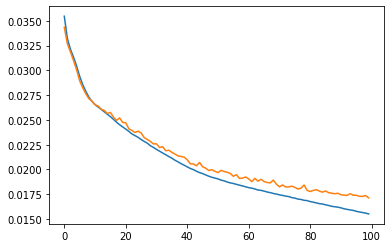

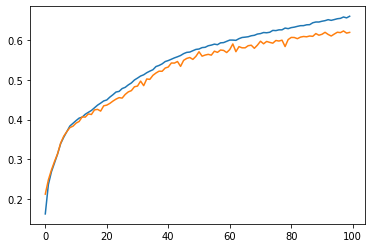

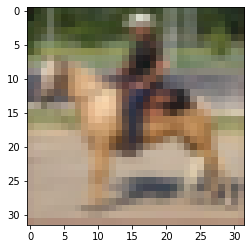

actual_label: 7 predicted_label: 7 actual_class: plane predicted_class: plane


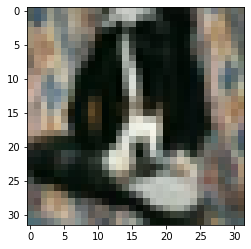

actual_label: 5 predicted_label: 9 actual_class: dog predicted_class: bird


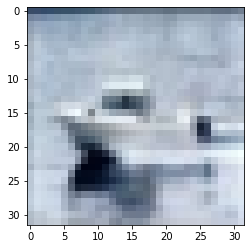

actual_label: 8 predicted_label: 8 actual_class: horse predicted_class: horse


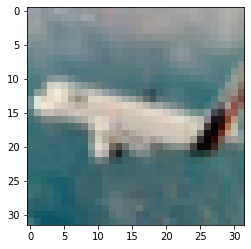

actual_label: 0 predicted_label: 0 actual_class: cat predicted_class: cat


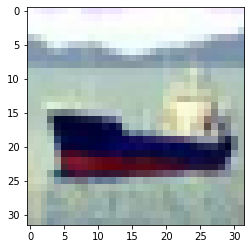

actual_label: 8 predicted_label: 8 actual_class: horse predicted_class: horse


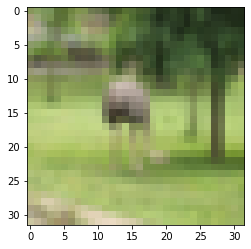

actual_label: 2 predicted_label: 4 actual_class: ship predicted_class: ship


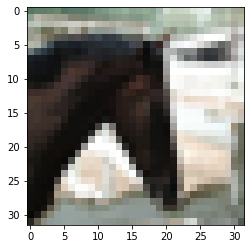

actual_label: 7 predicted_label: 7 actual_class: plane predicted_class: plane


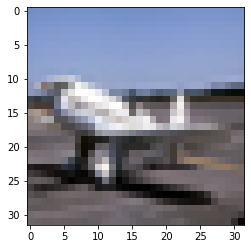

actual_label: 0 predicted_label: 0 actual_class: cat predicted_class: cat


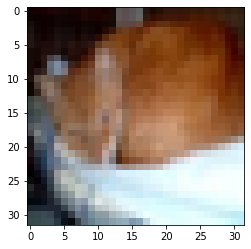

actual_label: 3 predicted_label: 3 actual_class: car predicted_class: car


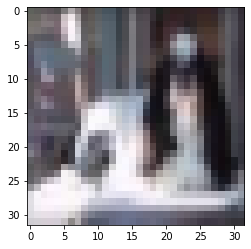

actual_label: 5 predicted_label: 5 actual_class: dog predicted_class: dog

 test loss: 0.017001388375024507 test acc: 0.6253980891719745 correct: 6284 incorrect: 3716


In [ ]:
batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

torch.manual_seed(42)
validation_size = 5000
train_size = len(trainset)-validation_size
train_set, validation_set = random_split(trainset, [train_size, validation_size])


train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True,num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=64,shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False)

print("trainset:",len(train_set))
print("validationset:",len(validation_set))
print("testset:",len(test_set))

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



dataiter = iter(train_dataloader)
images, labels = dataiter.next()


def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(labels)


class ConvolutionNetwork1(nn.Module):

  def __init__(self):
    super(ConvolutionNetwork1,self).__init__()
    
    self.flatten_shape =  64*14*14

    self.conv = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5,stride=1),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5,stride=1),
          nn.MaxPool2d(kernel_size=2,stride=1),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5,stride=1),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5,stride=1),
          nn.MaxPool2d(kernel_size=2,stride=1)
    )

    self.fc = nn.Sequential( 
        nn.Linear(in_features=self.flatten_shape, out_features=128),
        nn.Linear(in_features=128, out_features=64),
        nn.Linear(in_features=64, out_features=10)
    )

  def forward(self,x):
    x = self.conv(x)
    flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
    print("ff:",x.shape,flat_features.shape)
    x=self.fc(flat_features)
    return x

  def forward(self,x):
    x = self.conv(x)
    flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
    # print("ff:",x.shape,flat_features.shape)
    x=self.fc(flat_features)
    return x


device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        correct = 0
        incorrect = 0
        for imgs,lbls in dataloader:
            imgs = imgs
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls).item()
            correct += torch.sum(test_pred == lbls).item()
            incorrect += torch.sum(test_pred != lbls).item()

        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))
        
        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img.unsqueeze(0))
              pred_lbl = out
              imshow(img.cpu().detach())
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp,"actual_class:",classes[actual_lbl_disp],"predicted_class:",classes[pred_lbl_disp])
                        
            return test_loss,test_acc,correct,incorrect
    
    return test_loss,test_acc,correct,incorrect


from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 100
learning_rate = 0.0001

model = ConvolutionNetwork1().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  train_correct = 0
  train_incorrect = 0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      train_correct += torch.sum(torch.argmax(out, dim=1) == lbls).item()
      train_incorrect += torch.sum(torch.argmax(out, dim=1) != lbls).item()
      running_acc += acc.item()

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  val_loss,val_acc,correct,incorrect = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size),"train_correct:",train_correct,"train_incorrect:",train_incorrect," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"correct:",correct,"incorrect:",incorrect,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()

model.eval()
test_loss,test_acc,test_correct,test_incorrect = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc,"correct:",test_correct,"incorrect:",test_incorrect)




# (a)
**maxpool - (1,1)**

**stride - 2**

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
trainset: 45000
validationset: 5000
testset: 10000


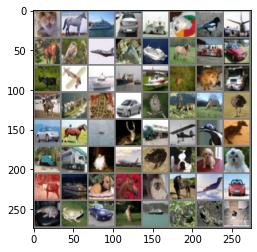

tensor([3, 7, 8, 1, 8, 5, 2, 0, 7, 2, 0, 2, 8, 7, 9, 1, 4, 0, 8, 8, 0, 4, 5, 9,
        7, 8, 6, 1, 2, 4, 5, 2, 1, 7, 8, 4, 9, 0, 2, 2, 9, 9, 3, 0, 6, 5, 5, 5,
        4, 8, 5, 7, 5, 7, 0, 1, 3, 6, 1, 4, 8, 6, 6, 3])
cpu


100%|██████████| 704/704 [00:18<00:00, 37.16it/s, batch_loss=2.301508903503418]



epoch: 0  Train Loss: 0.035957341257017106  Train Accuracy: 0.11494584517045454 train_correct: 5179 train_incorrect: 39821  Validation Loss: 0.0359100755539876  Validation Accuracy: 0.127373417721519 correct: 644 incorrect: 4356 



100%|██████████| 704/704 [00:17<00:00, 40.60it/s, batch_loss=2.3016421794891357]



epoch: 1  Train Loss: 0.03579481282610108  Train Accuracy: 0.1473721590909091 train_correct: 6640 train_incorrect: 38360  Validation Loss: 0.03560885824734652  Validation Accuracy: 0.14082278481012658 correct: 712 incorrect: 4288 



100%|██████████| 704/704 [00:17<00:00, 40.55it/s, batch_loss=2.308694362640381]



epoch: 2  Train Loss: 0.03512068326711993  Train Accuracy: 0.14628462357954544 train_correct: 6591 train_incorrect: 38409  Validation Loss: 0.03485013176746006  Validation Accuracy: 0.14556962025316456 correct: 736 incorrect: 4264 



100%|██████████| 704/704 [00:17<00:00, 40.12it/s, batch_loss=2.134965658187866]



epoch: 3  Train Loss: 0.03465190460503271  Train Accuracy: 0.15283203125 train_correct: 6886 train_incorrect: 38114  Validation Loss: 0.034538711739491815  Validation Accuracy: 0.15763449367088608 correct: 797 incorrect: 4203 



100%|██████████| 704/704 [00:17<00:00, 40.31it/s, batch_loss=2.1365928649902344]



epoch: 4  Train Loss: 0.034263104369694534  Train Accuracy: 0.1629305752840909 train_correct: 7341 train_incorrect: 37659  Validation Loss: 0.03406714280194874  Validation Accuracy: 0.16218354430379747 correct: 820 incorrect: 4180 



100%|██████████| 704/704 [00:17<00:00, 39.80it/s, batch_loss=2.1686606407165527]



epoch: 5  Train Loss: 0.03392227119184099  Train Accuracy: 0.15995649857954544 train_correct: 7207 train_incorrect: 37793  Validation Loss: 0.033896288068234165  Validation Accuracy: 0.15783227848101267 correct: 798 incorrect: 4202 



100%|██████████| 704/704 [00:17<00:00, 40.10it/s, batch_loss=2.1045777797698975]



epoch: 6  Train Loss: 0.03384524264468134  Train Accuracy: 0.16643732244318182 train_correct: 7499 train_incorrect: 37501  Validation Loss: 0.03384090686523462  Validation Accuracy: 0.17543512658227847 correct: 887 incorrect: 4113 



100%|██████████| 704/704 [00:17<00:00, 39.77it/s, batch_loss=2.386366605758667]



epoch: 7  Train Loss: 0.033816936579321256  Train Accuracy: 0.17351740056818182 train_correct: 7818 train_incorrect: 37182  Validation Loss: 0.03379917698853378  Validation Accuracy: 0.18117088607594936 correct: 916 incorrect: 4084 



100%|██████████| 704/704 [00:17<00:00, 39.17it/s, batch_loss=2.231398105621338]



epoch: 8  Train Loss: 0.033788896832530474  Train Accuracy: 0.17975408380681818 train_correct: 8099 train_incorrect: 36901  Validation Loss: 0.03377511107091662  Validation Accuracy: 0.17840189873417722 correct: 902 incorrect: 4098 



100%|██████████| 704/704 [00:17<00:00, 40.02it/s, batch_loss=1.9747475385665894]



epoch: 9  Train Loss: 0.03375275801094672  Train Accuracy: 0.18310546875 train_correct: 8250 train_incorrect: 36750  Validation Loss: 0.03373688482974149  Validation Accuracy: 0.18374208860759494 correct: 929 incorrect: 4071 



100%|██████████| 704/704 [00:17<00:00, 39.75it/s, batch_loss=1.9977318048477173]



epoch: 10  Train Loss: 0.033726992458634246  Train Accuracy: 0.18312766335227273 train_correct: 8251 train_incorrect: 36749  Validation Loss: 0.03370810884840881  Validation Accuracy: 0.17602848101265822 correct: 890 incorrect: 4110 



100%|██████████| 704/704 [00:17<00:00, 39.38it/s, batch_loss=2.164123058319092]



epoch: 11  Train Loss: 0.03370650350222026  Train Accuracy: 0.18463689630681818 train_correct: 8319 train_incorrect: 36681  Validation Loss: 0.033683515755058846  Validation Accuracy: 0.18334651898734178 correct: 927 incorrect: 4073 



100%|██████████| 704/704 [00:17<00:00, 39.53it/s, batch_loss=1.9208041429519653]



epoch: 12  Train Loss: 0.03368525123964487  Train Accuracy: 0.18519176136363635 train_correct: 8344 train_incorrect: 36656  Validation Loss: 0.03367833977070036  Validation Accuracy: 0.18136867088607594 correct: 917 incorrect: 4083 



100%|██████████| 704/704 [00:17<00:00, 39.83it/s, batch_loss=2.27492618560791]



epoch: 13  Train Loss: 0.03367907282981006  Train Accuracy: 0.18516956676136365 train_correct: 8343 train_incorrect: 36657  Validation Loss: 0.033655955161474925  Validation Accuracy: 0.18156645569620253 correct: 918 incorrect: 4082 



100%|██████████| 704/704 [00:17<00:00, 39.83it/s, batch_loss=2.2827377319335938]



epoch: 14  Train Loss: 0.033668038578153675  Train Accuracy: 0.185302734375 train_correct: 8349 train_incorrect: 36651  Validation Loss: 0.03365498917955387  Validation Accuracy: 0.18829113924050633 correct: 952 incorrect: 4048 



100%|██████████| 704/704 [00:17<00:00, 39.62it/s, batch_loss=2.1616153717041016]



epoch: 15  Train Loss: 0.03365666840479455  Train Accuracy: 0.18703391335227273 train_correct: 8427 train_incorrect: 36573  Validation Loss: 0.03362533827371235  Validation Accuracy: 0.18453322784810128 correct: 933 incorrect: 4067 



100%|██████████| 704/704 [00:17<00:00, 39.54it/s, batch_loss=2.061858654022217]



epoch: 16  Train Loss: 0.03364710665350272  Train Accuracy: 0.18767755681818182 train_correct: 8456 train_incorrect: 36544  Validation Loss: 0.03362091475083858  Validation Accuracy: 0.1944224683544304 correct: 983 incorrect: 4017 



100%|██████████| 704/704 [00:17<00:00, 39.92it/s, batch_loss=2.182579278945923]



epoch: 17  Train Loss: 0.033643888563595035  Train Accuracy: 0.1888094815340909 train_correct: 8507 train_incorrect: 36493  Validation Loss: 0.03361346216612979  Validation Accuracy: 0.18730221518987342 correct: 947 incorrect: 4053 



100%|██████████| 704/704 [00:17<00:00, 39.66it/s, batch_loss=2.180105686187744]



epoch: 18  Train Loss: 0.03363122125897049  Train Accuracy: 0.1875 train_correct: 8448 train_incorrect: 36552  Validation Loss: 0.033582698483067226  Validation Accuracy: 0.18829113924050633 correct: 952 incorrect: 4048 



100%|██████████| 704/704 [00:17<00:00, 39.70it/s, batch_loss=2.4266128540039062]



epoch: 19  Train Loss: 0.03361986943160777  Train Accuracy: 0.18865411931818182 train_correct: 8500 train_incorrect: 36500  Validation Loss: 0.03357721301668053  Validation Accuracy: 0.19046677215189872 correct: 963 incorrect: 4037 



100%|██████████| 704/704 [00:17<00:00, 40.34it/s, batch_loss=2.1538901329040527]



epoch: 20  Train Loss: 0.033595069118415595  Train Accuracy: 0.19140625 train_correct: 8624 train_incorrect: 36376  Validation Loss: 0.033540445556746255  Validation Accuracy: 0.1863132911392405 correct: 942 incorrect: 4058 



100%|██████████| 704/704 [00:19<00:00, 36.72it/s, batch_loss=2.2762973308563232]



epoch: 21  Train Loss: 0.03357565634227781  Train Accuracy: 0.19022993607954544 train_correct: 8571 train_incorrect: 36429  Validation Loss: 0.033518123169299925  Validation Accuracy: 0.18947784810126583 correct: 958 incorrect: 4042 



100%|██████████| 704/704 [00:18<00:00, 37.83it/s, batch_loss=2.437443971633911]



epoch: 22  Train Loss: 0.03355136374276216  Train Accuracy: 0.19138405539772727 train_correct: 8623 train_incorrect: 36377  Validation Loss: 0.03349362176996243  Validation Accuracy: 0.19541139240506328 correct: 988 incorrect: 4012 



100%|██████████| 704/704 [00:18<00:00, 38.90it/s, batch_loss=2.2636444568634033]



epoch: 23  Train Loss: 0.03352000024593012  Train Accuracy: 0.19342595880681818 train_correct: 8715 train_incorrect: 36285  Validation Loss: 0.03346520087009744  Validation Accuracy: 0.19007120253164558 correct: 961 incorrect: 4039 



100%|██████████| 704/704 [00:18<00:00, 38.13it/s, batch_loss=2.064321756362915]



epoch: 24  Train Loss: 0.033502751220525664  Train Accuracy: 0.19267134232954544 train_correct: 8681 train_incorrect: 36319  Validation Loss: 0.033468688826394984  Validation Accuracy: 0.18908227848101267 correct: 956 incorrect: 4044 



100%|██████████| 704/704 [00:18<00:00, 38.59it/s, batch_loss=1.9603315591812134]



epoch: 25  Train Loss: 0.03349113243960098  Train Accuracy: 0.19455788352272727 train_correct: 8766 train_incorrect: 36234  Validation Loss: 0.033460448955810525  Validation Accuracy: 0.19106012658227847 correct: 966 incorrect: 4034 



100%|██████████| 704/704 [00:18<00:00, 38.44it/s, batch_loss=2.27194881439209]



epoch: 26  Train Loss: 0.03348853998944502  Train Accuracy: 0.19426935369318182 train_correct: 8753 train_incorrect: 36247  Validation Loss: 0.03343991522641876  Validation Accuracy: 0.1920490506329114 correct: 971 incorrect: 4029 



100%|██████████| 704/704 [00:18<00:00, 38.52it/s, batch_loss=1.9512064456939697]



epoch: 27  Train Loss: 0.03347572696194137  Train Accuracy: 0.1944912997159091 train_correct: 8763 train_incorrect: 36237  Validation Loss: 0.0334419443071643  Validation Accuracy: 0.1932357594936709 correct: 977 incorrect: 4023 



100%|██████████| 704/704 [00:18<00:00, 37.91it/s, batch_loss=2.272716760635376]



epoch: 28  Train Loss: 0.033484006348193034  Train Accuracy: 0.19315962357954544 train_correct: 8703 train_incorrect: 36297  Validation Loss: 0.033444437941041176  Validation Accuracy: 0.19284018987341772 correct: 975 incorrect: 4025 



100%|██████████| 704/704 [00:18<00:00, 38.05it/s, batch_loss=2.119840621948242]



epoch: 29  Train Loss: 0.03348357543687929  Train Accuracy: 0.19422496448863635 train_correct: 8751 train_incorrect: 36249  Validation Loss: 0.03344284240863746  Validation Accuracy: 0.1918512658227848 correct: 970 incorrect: 4030 



100%|██████████| 704/704 [00:18<00:00, 38.23it/s, batch_loss=1.9709988832473755]



epoch: 30  Train Loss: 0.033477558484512636  Train Accuracy: 0.19482421875 train_correct: 8778 train_incorrect: 36222  Validation Loss: 0.03344337248443803  Validation Accuracy: 0.19481803797468356 correct: 985 incorrect: 4015 



100%|██████████| 704/704 [00:18<00:00, 38.55it/s, batch_loss=2.0295584201812744]



epoch: 31  Train Loss: 0.03348015004303306  Train Accuracy: 0.19517933238636365 train_correct: 8794 train_incorrect: 36206  Validation Loss: 0.033434593885005276  Validation Accuracy: 0.1908623417721519 correct: 965 incorrect: 4035 



100%|██████████| 704/704 [00:18<00:00, 38.39it/s, batch_loss=2.234607219696045]



epoch: 32  Train Loss: 0.03348600451929749  Train Accuracy: 0.19267134232954544 train_correct: 8681 train_incorrect: 36319  Validation Loss: 0.03344021490008771  Validation Accuracy: 0.19224683544303797 correct: 972 incorrect: 4028 



100%|██████████| 704/704 [00:18<00:00, 38.18it/s, batch_loss=1.8165725469589233]



epoch: 33  Train Loss: 0.03347204660001973  Train Accuracy: 0.19551225142045456 train_correct: 8809 train_incorrect: 36191  Validation Loss: 0.03344261523666261  Validation Accuracy: 0.19679588607594936 correct: 995 incorrect: 4005 



100%|██████████| 704/704 [00:18<00:00, 38.03it/s, batch_loss=2.4157891273498535]



epoch: 34  Train Loss: 0.033488470153480936  Train Accuracy: 0.19386985085227273 train_correct: 8735 train_incorrect: 36265  Validation Loss: 0.0334255072417893  Validation Accuracy: 0.19699367088607594 correct: 996 incorrect: 4004 



100%|██████████| 704/704 [00:18<00:00, 38.25it/s, batch_loss=2.116499662399292]



epoch: 35  Train Loss: 0.03347700699867511  Train Accuracy: 0.19489080255681818 train_correct: 8781 train_incorrect: 36219  Validation Loss: 0.033441299077453496  Validation Accuracy: 0.19402689873417722 correct: 981 incorrect: 4019 



100%|██████████| 704/704 [00:18<00:00, 38.28it/s, batch_loss=1.9848616123199463]



epoch: 36  Train Loss: 0.0334749007967978  Train Accuracy: 0.1937588778409091 train_correct: 8730 train_incorrect: 36270  Validation Loss: 0.03343887004671218  Validation Accuracy: 0.19343354430379747 correct: 978 incorrect: 4022 



100%|██████████| 704/704 [00:18<00:00, 38.24it/s, batch_loss=1.771867036819458]



epoch: 37  Train Loss: 0.03347370037491518  Train Accuracy: 0.19591175426136365 train_correct: 8827 train_incorrect: 36173  Validation Loss: 0.03343832346646092  Validation Accuracy: 0.1930379746835443 correct: 976 incorrect: 4024 



100%|██████████| 704/704 [00:18<00:00, 38.12it/s, batch_loss=1.7125904560089111]



epoch: 38  Train Loss: 0.03347354022182778  Train Accuracy: 0.19347034801136365 train_correct: 8717 train_incorrect: 36283  Validation Loss: 0.033435098449640634  Validation Accuracy: 0.1930379746835443 correct: 976 incorrect: 4024 



100%|██████████| 704/704 [00:18<00:00, 37.75it/s, batch_loss=2.168682336807251]



epoch: 39  Train Loss: 0.03348170973847366  Train Accuracy: 0.19511274857954544 train_correct: 8791 train_incorrect: 36209  Validation Loss: 0.033425737573187564  Validation Accuracy: 0.1962025316455696 correct: 992 incorrect: 4008 



100%|██████████| 704/704 [00:18<00:00, 37.87it/s, batch_loss=2.3885865211486816]



epoch: 40  Train Loss: 0.0334844829657496  Train Accuracy: 0.19500177556818182 train_correct: 8786 train_incorrect: 36214  Validation Loss: 0.033435913675193545  Validation Accuracy: 0.19145569620253164 correct: 968 incorrect: 4032 



100%|██████████| 704/704 [00:19<00:00, 37.04it/s, batch_loss=1.9461815357208252]



epoch: 41  Train Loss: 0.03347769603715278  Train Accuracy: 0.19440252130681818 train_correct: 8759 train_incorrect: 36241  Validation Loss: 0.0334423576964985  Validation Accuracy: 0.19521360759493672 correct: 987 incorrect: 4013 



100%|██████████| 704/704 [00:18<00:00, 37.26it/s, batch_loss=2.0203170776367188]



epoch: 42  Train Loss: 0.033480099074288526  Train Accuracy: 0.19529030539772727 train_correct: 8799 train_incorrect: 36201  Validation Loss: 0.033444202917663354  Validation Accuracy: 0.18908227848101267 correct: 956 incorrect: 4044 



100%|██████████| 704/704 [00:18<00:00, 37.12it/s, batch_loss=2.589026689529419]



epoch: 43  Train Loss: 0.03349095979832451  Train Accuracy: 0.195556640625 train_correct: 8811 train_incorrect: 36189  Validation Loss: 0.03343038791436938  Validation Accuracy: 0.19046677215189872 correct: 963 incorrect: 4037 



100%|██████████| 704/704 [00:18<00:00, 37.44it/s, batch_loss=2.324950933456421]



epoch: 44  Train Loss: 0.03348529186703011  Train Accuracy: 0.19331498579545456 train_correct: 8710 train_incorrect: 36290  Validation Loss: 0.03343209320137018  Validation Accuracy: 0.18967563291139242 correct: 959 incorrect: 4041 



100%|██████████| 704/704 [00:18<00:00, 37.94it/s, batch_loss=1.9982339143753052]



epoch: 45  Train Loss: 0.033480275043984875  Train Accuracy: 0.19329279119318182 train_correct: 8709 train_incorrect: 36291  Validation Loss: 0.03343090525816513  Validation Accuracy: 0.19541139240506328 correct: 988 incorrect: 4012 



100%|██████████| 704/704 [00:18<00:00, 38.12it/s, batch_loss=2.216458559036255]



epoch: 46  Train Loss: 0.03348320212469182  Train Accuracy: 0.19406960227272727 train_correct: 8744 train_incorrect: 36256  Validation Loss: 0.03344569131260431  Validation Accuracy: 0.19462025316455697 correct: 984 incorrect: 4016 



100%|██████████| 704/704 [00:18<00:00, 37.78it/s, batch_loss=1.9647653102874756]



epoch: 47  Train Loss: 0.03347375636010177  Train Accuracy: 0.19582297585227273 train_correct: 8823 train_incorrect: 36177  Validation Loss: 0.033448510225626484  Validation Accuracy: 0.19402689873417722 correct: 981 incorrect: 4019 



100%|██████████| 704/704 [00:18<00:00, 37.51it/s, batch_loss=2.2339847087860107]



epoch: 48  Train Loss: 0.03348756771248935  Train Accuracy: 0.193603515625 train_correct: 8723 train_incorrect: 36277  Validation Loss: 0.03344786384060413  Validation Accuracy: 0.1908623417721519 correct: 965 incorrect: 4035 



100%|██████████| 704/704 [00:19<00:00, 37.04it/s, batch_loss=2.242647171020508]



epoch: 49  Train Loss: 0.03348145293421112  Train Accuracy: 0.19568980823863635 train_correct: 8817 train_incorrect: 36183  Validation Loss: 0.03344093588522718  Validation Accuracy: 0.1932357594936709 correct: 977 incorrect: 4023 



100%|██████████| 704/704 [00:18<00:00, 38.01it/s, batch_loss=2.3332622051239014]



epoch: 50  Train Loss: 0.03348681112402119  Train Accuracy: 0.1924715909090909 train_correct: 8672 train_incorrect: 36328  Validation Loss: 0.033428661030115964  Validation Accuracy: 0.1962025316455696 correct: 992 incorrect: 4008 



100%|██████████| 704/704 [00:18<00:00, 37.30it/s, batch_loss=1.9931855201721191]



epoch: 51  Train Loss: 0.0334754042824815  Train Accuracy: 0.1942471590909091 train_correct: 8752 train_incorrect: 36248  Validation Loss: 0.033446103735249255  Validation Accuracy: 0.1975870253164557 correct: 999 incorrect: 4001 



100%|██████████| 704/704 [00:21<00:00, 33.26it/s, batch_loss=2.3211007118225098]



epoch: 52  Train Loss: 0.03348454112578607  Train Accuracy: 0.19287109375 train_correct: 8690 train_incorrect: 36310  Validation Loss: 0.033444347095829025  Validation Accuracy: 0.1932357594936709 correct: 977 incorrect: 4023 



100%|██████████| 704/704 [00:18<00:00, 38.19it/s, batch_loss=2.3854143619537354]



epoch: 53  Train Loss: 0.03348423560435714  Train Accuracy: 0.1943359375 train_correct: 8756 train_incorrect: 36244  Validation Loss: 0.03342247704822052  Validation Accuracy: 0.19343354430379747 correct: 978 incorrect: 4022 



100%|██████████| 704/704 [00:18<00:00, 37.84it/s, batch_loss=2.3569893836975098]



epoch: 54  Train Loss: 0.03348425812278451  Train Accuracy: 0.19444691051136365 train_correct: 8761 train_incorrect: 36239  Validation Loss: 0.03343049549981009  Validation Accuracy: 0.19224683544303797 correct: 972 incorrect: 4028 



100%|██████████| 704/704 [00:18<00:00, 37.68it/s, batch_loss=1.9299530982971191]



epoch: 55  Train Loss: 0.03347593839068643  Train Accuracy: 0.19384765625 train_correct: 8734 train_incorrect: 36266  Validation Loss: 0.03343429503655886  Validation Accuracy: 0.19600474683544303 correct: 991 incorrect: 4009 



100%|██████████| 704/704 [00:18<00:00, 37.48it/s, batch_loss=1.8675527572631836]



epoch: 56  Train Loss: 0.03347393259173259  Train Accuracy: 0.19657759232954544 train_correct: 8857 train_incorrect: 36143  Validation Loss: 0.033451273895894425  Validation Accuracy: 0.19363132911392406 correct: 979 incorrect: 4021 



100%|██████████| 704/704 [00:18<00:00, 37.98it/s, batch_loss=2.262415885925293]



epoch: 57  Train Loss: 0.03348535351423462  Train Accuracy: 0.19431374289772727 train_correct: 8755 train_incorrect: 36245  Validation Loss: 0.0334372987286954  Validation Accuracy: 0.1932357594936709 correct: 977 incorrect: 4023 



100%|██████████| 704/704 [00:18<00:00, 37.24it/s, batch_loss=2.078770160675049]



epoch: 58  Train Loss: 0.03347756157481027  Train Accuracy: 0.19451349431818182 train_correct: 8764 train_incorrect: 36236  Validation Loss: 0.03343619708018967  Validation Accuracy: 0.19284018987341772 correct: 975 incorrect: 4025 



100%|██████████| 704/704 [00:18<00:00, 37.47it/s, batch_loss=2.046170234680176]



epoch: 59  Train Loss: 0.03347707471005957  Train Accuracy: 0.19453568892045456 train_correct: 8765 train_incorrect: 36235  Validation Loss: 0.033436350241492066  Validation Accuracy: 0.19481803797468356 correct: 985 incorrect: 4015 



100%|██████████| 704/704 [00:18<00:00, 37.82it/s, batch_loss=1.9943606853485107]



epoch: 60  Train Loss: 0.03347728278921833  Train Accuracy: 0.19582297585227273 train_correct: 8823 train_incorrect: 36177  Validation Loss: 0.033436493193612825  Validation Accuracy: 0.19125791139240506 correct: 967 incorrect: 4033 



100%|██████████| 704/704 [00:18<00:00, 37.78it/s, batch_loss=2.1009364128112793]



epoch: 61  Train Loss: 0.033478196355810556  Train Accuracy: 0.19500177556818182 train_correct: 8786 train_incorrect: 36214  Validation Loss: 0.03345949893605105  Validation Accuracy: 0.19501582278481014 correct: 986 incorrect: 4014 



100%|██████████| 704/704 [00:18<00:00, 37.99it/s, batch_loss=2.439622640609741]



epoch: 62  Train Loss: 0.03348507701197046  Train Accuracy: 0.19426935369318182 train_correct: 8753 train_incorrect: 36247  Validation Loss: 0.03343394870245004  Validation Accuracy: 0.1942246835443038 correct: 982 incorrect: 4018 



100%|██████████| 704/704 [00:19<00:00, 37.01it/s, batch_loss=2.2574334144592285]



epoch: 63  Train Loss: 0.03348111164682037  Train Accuracy: 0.19542347301136365 train_correct: 8805 train_incorrect: 36195  Validation Loss: 0.033442942614230926  Validation Accuracy: 0.19125791139240506 correct: 967 incorrect: 4033 



100%|██████████| 704/704 [00:18<00:00, 37.54it/s, batch_loss=2.591707944869995]



epoch: 64  Train Loss: 0.03348627584372563  Train Accuracy: 0.19615589488636365 train_correct: 8838 train_incorrect: 36162  Validation Loss: 0.03344732586624501  Validation Accuracy: 0.1964003164556962 correct: 993 incorrect: 4007 



100%|██████████| 704/704 [00:18<00:00, 37.12it/s, batch_loss=2.3965253829956055]



epoch: 65  Train Loss: 0.033483989608198914  Train Accuracy: 0.195068359375 train_correct: 8789 train_incorrect: 36211  Validation Loss: 0.03342600353062153  Validation Accuracy: 0.18947784810126583 correct: 958 incorrect: 4042 



100%|██████████| 704/704 [00:19<00:00, 37.02it/s, batch_loss=2.3746047019958496]



epoch: 66  Train Loss: 0.03348485387025655  Train Accuracy: 0.19537908380681818 train_correct: 8803 train_incorrect: 36197  Validation Loss: 0.03343359640316118  Validation Accuracy: 0.18928006329113925 correct: 957 incorrect: 4043 



100%|██████████| 704/704 [00:18<00:00, 37.57it/s, batch_loss=2.1272902488708496]



epoch: 67  Train Loss: 0.033480146651113915  Train Accuracy: 0.19495738636363635 train_correct: 8784 train_incorrect: 36216  Validation Loss: 0.03342884757756433  Validation Accuracy: 0.19106012658227847 correct: 966 incorrect: 4034 



100%|██████████| 704/704 [00:18<00:00, 37.46it/s, batch_loss=2.109941005706787]



epoch: 68  Train Loss: 0.03347714779242365  Train Accuracy: 0.19484641335227273 train_correct: 8779 train_incorrect: 36221  Validation Loss: 0.03343304463579685  Validation Accuracy: 0.19916930379746836 correct: 1007 incorrect: 3993 



100%|██████████| 704/704 [00:18<00:00, 37.59it/s, batch_loss=1.9356706142425537]



epoch: 69  Train Loss: 0.0334745164569044  Train Accuracy: 0.19435813210227273 train_correct: 8757 train_incorrect: 36243  Validation Loss: 0.03343215261739266  Validation Accuracy: 0.19224683544303797 correct: 972 incorrect: 4028 



100%|██████████| 704/704 [00:18<00:00, 37.20it/s, batch_loss=1.9793815612792969]



epoch: 70  Train Loss: 0.033475629236570305  Train Accuracy: 0.1941805752840909 train_correct: 8749 train_incorrect: 36251  Validation Loss: 0.033434836028874676  Validation Accuracy: 0.19224683544303797 correct: 972 incorrect: 4028 



100%|██████████| 704/704 [00:18<00:00, 37.27it/s, batch_loss=1.9929345846176147]



epoch: 71  Train Loss: 0.03347648147610016  Train Accuracy: 0.19440252130681818 train_correct: 8759 train_incorrect: 36241  Validation Loss: 0.03343890508330321  Validation Accuracy: 0.19224683544303797 correct: 972 incorrect: 4028 



100%|██████████| 704/704 [00:18<00:00, 37.89it/s, batch_loss=1.9723098278045654]



epoch: 72  Train Loss: 0.03347533304688775  Train Accuracy: 0.19207208806818182 train_correct: 8654 train_incorrect: 36346  Validation Loss: 0.03344804043822651  Validation Accuracy: 0.19402689873417722 correct: 981 incorrect: 4019 



100%|██████████| 704/704 [00:18<00:00, 37.64it/s, batch_loss=2.0099635124206543]



epoch: 73  Train Loss: 0.03347383641680195  Train Accuracy: 0.19353693181818182 train_correct: 8720 train_incorrect: 36280  Validation Loss: 0.033440052755648576  Validation Accuracy: 0.19244462025316456 correct: 973 incorrect: 4027 



100%|██████████| 704/704 [00:18<00:00, 37.45it/s, batch_loss=1.7652432918548584]



epoch: 74  Train Loss: 0.033471777775875206  Train Accuracy: 0.19411399147727273 train_correct: 8746 train_incorrect: 36254  Validation Loss: 0.03343742484627645  Validation Accuracy: 0.19165348101265822 correct: 969 incorrect: 4031 



100%|██████████| 704/704 [00:18<00:00, 37.57it/s, batch_loss=1.819665789604187]



epoch: 75  Train Loss: 0.033469839402559126  Train Accuracy: 0.1944247159090909 train_correct: 8760 train_incorrect: 36240  Validation Loss: 0.0334423704520811  Validation Accuracy: 0.19284018987341772 correct: 975 incorrect: 4025 



100%|██████████| 704/704 [00:18<00:00, 37.70it/s, batch_loss=2.3587520122528076]



epoch: 76  Train Loss: 0.03348339081276208  Train Accuracy: 0.1941805752840909 train_correct: 8749 train_incorrect: 36251  Validation Loss: 0.03344326454533052  Validation Accuracy: 0.19560917721518986 correct: 989 incorrect: 4011 



100%|██████████| 704/704 [00:18<00:00, 37.36it/s, batch_loss=1.8996772766113281]



epoch: 77  Train Loss: 0.03347275209803642  Train Accuracy: 0.19429154829545456 train_correct: 8754 train_incorrect: 36246  Validation Loss: 0.033439301402319835  Validation Accuracy: 0.18908227848101267 correct: 956 incorrect: 4044 



100%|██████████| 704/704 [00:18<00:00, 37.27it/s, batch_loss=1.868699312210083]



epoch: 78  Train Loss: 0.033474671879296446  Train Accuracy: 0.19364790482954544 train_correct: 8725 train_incorrect: 36275  Validation Loss: 0.033435555599346946  Validation Accuracy: 0.1918512658227848 correct: 970 incorrect: 4030 



100%|██████████| 704/704 [00:18<00:00, 37.62it/s, batch_loss=1.7850285768508911]



epoch: 79  Train Loss: 0.03347123646844094  Train Accuracy: 0.19462446732954544 train_correct: 8769 train_incorrect: 36231  Validation Loss: 0.033434633024131195  Validation Accuracy: 0.19224683544303797 correct: 972 incorrect: 4028 



100%|██████████| 704/704 [00:19<00:00, 37.00it/s, batch_loss=2.1249849796295166]



epoch: 80  Train Loss: 0.033474927074910905  Train Accuracy: 0.19462446732954544 train_correct: 8769 train_incorrect: 36231  Validation Loss: 0.033445634466560584  Validation Accuracy: 0.19264240506329114 correct: 974 incorrect: 4026 



100%|██████████| 704/704 [00:19<00:00, 36.42it/s, batch_loss=2.034435749053955]



epoch: 81  Train Loss: 0.033476562397977846  Train Accuracy: 0.19568980823863635 train_correct: 8817 train_incorrect: 36183  Validation Loss: 0.0334270053036228  Validation Accuracy: 0.19363132911392406 correct: 979 incorrect: 4021 



100%|██████████| 704/704 [00:18<00:00, 37.20it/s, batch_loss=2.549276351928711]



epoch: 82  Train Loss: 0.033485990136713634  Train Accuracy: 0.19477982954545456 train_correct: 8776 train_incorrect: 36224  Validation Loss: 0.0334338337371621  Validation Accuracy: 0.19224683544303797 correct: 972 incorrect: 4028 



100%|██████████| 704/704 [00:20<00:00, 34.31it/s, batch_loss=2.2122304439544678]



epoch: 83  Train Loss: 0.03347751990077086  Train Accuracy: 0.19382546164772727 train_correct: 8733 train_incorrect: 36267  Validation Loss: 0.03343505075177814  Validation Accuracy: 0.19244462025316456 correct: 973 incorrect: 4027 



100%|██████████| 704/704 [00:18<00:00, 37.68it/s, batch_loss=2.51948618888855]



epoch: 84  Train Loss: 0.033485906844196674  Train Accuracy: 0.19438032670454544 train_correct: 8758 train_incorrect: 36242  Validation Loss: 0.03343193560744388  Validation Accuracy: 0.19501582278481014 correct: 986 incorrect: 4014 



100%|██████████| 704/704 [00:18<00:00, 37.39it/s, batch_loss=2.2175049781799316]



epoch: 85  Train Loss: 0.03348165701027028  Train Accuracy: 0.19526811079545456 train_correct: 8798 train_incorrect: 36202  Validation Loss: 0.03343613207623174  Validation Accuracy: 0.19521360759493672 correct: 987 incorrect: 4013 



100%|██████████| 704/704 [00:18<00:00, 37.78it/s, batch_loss=2.26762056350708]



epoch: 86  Train Loss: 0.03348137352044101  Train Accuracy: 0.19493519176136365 train_correct: 8783 train_incorrect: 36217  Validation Loss: 0.033425390272389485  Validation Accuracy: 0.19046677215189872 correct: 963 incorrect: 4037 



100%|██████████| 704/704 [00:18<00:00, 37.30it/s, batch_loss=2.1224024295806885]



epoch: 87  Train Loss: 0.03347617172932422  Train Accuracy: 0.19411399147727273 train_correct: 8746 train_incorrect: 36254  Validation Loss: 0.03343402179358881  Validation Accuracy: 0.19462025316455697 correct: 984 incorrect: 4016 



100%|██████████| 704/704 [00:19<00:00, 36.67it/s, batch_loss=2.4878737926483154]



epoch: 88  Train Loss: 0.033482135284099386  Train Accuracy: 0.19573419744318182 train_correct: 8819 train_incorrect: 36181  Validation Loss: 0.03344440151336072  Validation Accuracy: 0.1944224683544304 correct: 983 incorrect: 4017 



100%|██████████| 704/704 [00:18<00:00, 37.32it/s, batch_loss=2.0937583446502686]



epoch: 89  Train Loss: 0.033474854892119765  Train Accuracy: 0.19307084517045456 train_correct: 8699 train_incorrect: 36301  Validation Loss: 0.03344246761614009  Validation Accuracy: 0.19363132911392406 correct: 979 incorrect: 4021 



100%|██████████| 704/704 [00:19<00:00, 36.96it/s, batch_loss=2.12445330619812]



epoch: 90  Train Loss: 0.03347789384001358  Train Accuracy: 0.19602272727272727 train_correct: 8832 train_incorrect: 36168  Validation Loss: 0.033431176379134384  Validation Accuracy: 0.189873417721519 correct: 960 incorrect: 4040 



100%|██████████| 704/704 [00:18<00:00, 37.27it/s, batch_loss=2.21058988571167]



epoch: 91  Train Loss: 0.033480156572874294  Train Accuracy: 0.19420276988636365 train_correct: 8750 train_incorrect: 36250  Validation Loss: 0.033428562734323215  Validation Accuracy: 0.1932357594936709 correct: 977 incorrect: 4023 



100%|██████████| 704/704 [00:18<00:00, 37.39it/s, batch_loss=2.406557083129883]



epoch: 92  Train Loss: 0.03348325097150254  Train Accuracy: 0.19438032670454544 train_correct: 8758 train_incorrect: 36242  Validation Loss: 0.03343351065075096  Validation Accuracy: 0.1908623417721519 correct: 965 incorrect: 4035 



100%|██████████| 704/704 [00:18<00:00, 37.31it/s, batch_loss=2.277277946472168]



epoch: 93  Train Loss: 0.03348199515973895  Train Accuracy: 0.1944912997159091 train_correct: 8763 train_incorrect: 36237  Validation Loss: 0.03343876783700683  Validation Accuracy: 0.19402689873417722 correct: 981 incorrect: 4019 



100%|██████████| 704/704 [00:18<00:00, 37.48it/s, batch_loss=2.414374828338623]



epoch: 94  Train Loss: 0.03348511509565552  Train Accuracy: 0.19471324573863635 train_correct: 8773 train_incorrect: 36227  Validation Loss: 0.03342903209732303  Validation Accuracy: 0.18888449367088608 correct: 955 incorrect: 4045 



100%|██████████| 704/704 [00:18<00:00, 37.34it/s, batch_loss=2.102700710296631]



epoch: 95  Train Loss: 0.033479015073019334  Train Accuracy: 0.19471324573863635 train_correct: 8773 train_incorrect: 36227  Validation Loss: 0.033443673289840735  Validation Accuracy: 0.19007120253164558 correct: 961 incorrect: 4039 



100%|██████████| 704/704 [00:18<00:00, 37.40it/s, batch_loss=2.021430730819702]



epoch: 96  Train Loss: 0.03347697802184319  Train Accuracy: 0.19608931107954544 train_correct: 8835 train_incorrect: 36165  Validation Loss: 0.033449149843824064  Validation Accuracy: 0.1942246835443038 correct: 982 incorrect: 4018 



100%|██████████| 704/704 [00:18<00:00, 37.18it/s, batch_loss=2.066758155822754]



epoch: 97  Train Loss: 0.03347591986212964  Train Accuracy: 0.19422496448863635 train_correct: 8751 train_incorrect: 36249  Validation Loss: 0.03343348893560941  Validation Accuracy: 0.19224683544303797 correct: 972 incorrect: 4028 



100%|██████████| 704/704 [00:18<00:00, 37.34it/s, batch_loss=1.97736394405365]



epoch: 98  Train Loss: 0.03347269281088798  Train Accuracy: 0.19549005681818182 train_correct: 8808 train_incorrect: 36192  Validation Loss: 0.0334332281888663  Validation Accuracy: 0.18809335443037975 correct: 951 incorrect: 4049 



100%|██████████| 704/704 [00:18<00:00, 37.11it/s, batch_loss=1.990702748298645]



epoch: 99  Train Loss: 0.033474516197615725  Train Accuracy: 0.1947354403409091 train_correct: 8774 train_incorrect: 36226  Validation Loss: 0.03343091332176818  Validation Accuracy: 0.1906645569620253 correct: 964 incorrect: 4036 



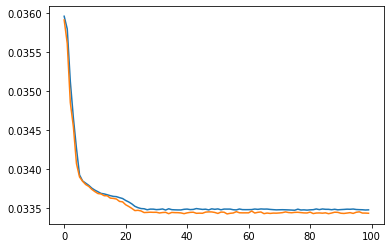

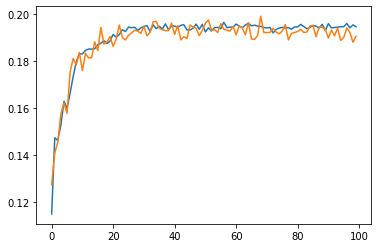

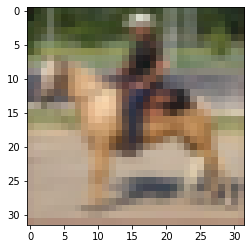

actual_label: 7 predicted_label: 5 actual_class: plane predicted_class: dog


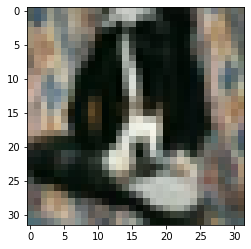

actual_label: 5 predicted_label: 4 actual_class: dog predicted_class: ship


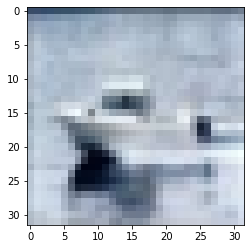

actual_label: 8 predicted_label: 0 actual_class: horse predicted_class: cat


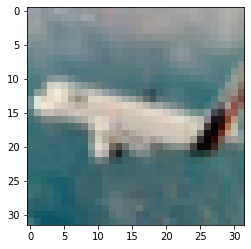

actual_label: 0 predicted_label: 9 actual_class: cat predicted_class: bird


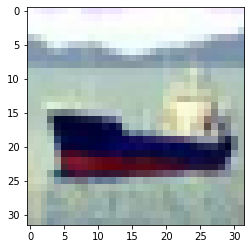

actual_label: 8 predicted_label: 9 actual_class: horse predicted_class: bird


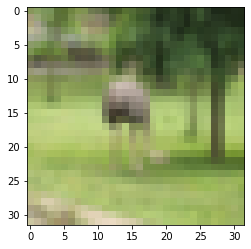

actual_label: 2 predicted_label: 2 actual_class: ship predicted_class: ship


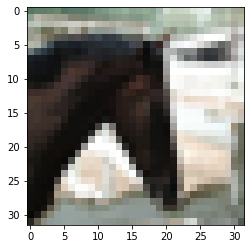

actual_label: 7 predicted_label: 4 actual_class: plane predicted_class: ship


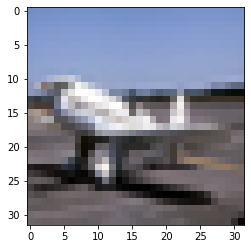

actual_label: 0 predicted_label: 0 actual_class: cat predicted_class: cat


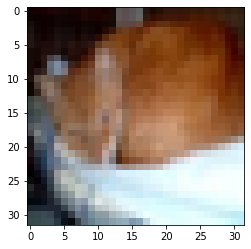

actual_label: 3 predicted_label: 5 actual_class: car predicted_class: dog


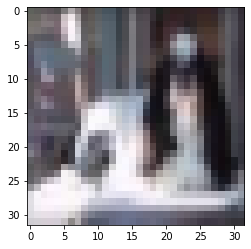

actual_label: 5 predicted_label: 5 actual_class: dog predicted_class: dog

 test loss: 0.033335891071778194 test acc: 0.18949044585987262 correct: 1904 incorrect: 8096


In [ ]:
batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

torch.manual_seed(42)
validation_size = 5000
train_size = len(trainset)-validation_size
train_set, validation_set = random_split(trainset, [train_size, validation_size])


train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True,num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=64,shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False)

print("trainset:",len(train_set))
print("validationset:",len(validation_set))
print("testset:",len(test_set))

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


dataiter = iter(train_dataloader)
images, labels = dataiter.next()


def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(labels)


class ConvolutionNetwork1(nn.Module):

  def __init__(self):
    super(ConvolutionNetwork1,self).__init__()
    
    self.flatten_shape =  64*1*1

    self.conv = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=8, kernel_size=1,stride=2),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1,stride=2),
          nn.MaxPool2d(kernel_size=1,stride=2),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1,stride=2),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1,stride=2),
          nn.MaxPool2d(kernel_size=1,stride=2)
    )

    self.fc = nn.Sequential( 
        nn.Linear(in_features=self.flatten_shape, out_features=128),
        nn.Linear(in_features=128, out_features=64),
        nn.Linear(in_features=64, out_features=10)
    )

  def forward(self,x):
    x = self.conv(x)
    flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
    # print("ff:",x.shape,flat_features.shape)
    x=self.fc(flat_features)
    return x



device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        correct = 0
        incorrect = 0
        for imgs,lbls in dataloader:
            imgs = imgs
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls).item()
            correct += torch.sum(test_pred == lbls).item()
            incorrect += torch.sum(test_pred != lbls).item()

        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))
        
        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img.unsqueeze(0))
              pred_lbl = out
              imshow(img.cpu().detach())
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp,"actual_class:",classes[actual_lbl_disp],"predicted_class:",classes[pred_lbl_disp])
                        
            return test_loss,test_acc,correct,incorrect
    
    return test_loss,test_acc,correct,incorrect


from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 100
learning_rate = 0.0001 #0.001

model = ConvolutionNetwork1().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  train_correct = 0
  train_incorrect = 0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      train_correct += torch.sum(torch.argmax(out, dim=1) == lbls).item()
      train_incorrect += torch.sum(torch.argmax(out, dim=1) != lbls).item()
      running_acc += acc.item()

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  val_loss,val_acc,correct,incorrect = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size),"train_correct:",train_correct,"train_incorrect:",train_incorrect," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"correct:",correct,"incorrect:",incorrect,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()

model.eval()
test_loss,test_acc,test_correct,test_incorrect = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc,"correct:",test_correct,"incorrect:",test_incorrect)




# (a)
**avgpool - (5,5)**

**stride - 1**

Files already downloaded and verified
Files already downloaded and verified
trainset: 45000
validationset: 5000
testset: 10000


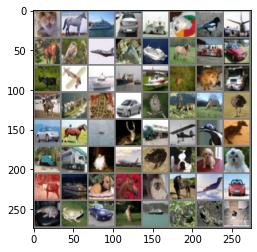

tensor([3, 7, 8, 1, 8, 5, 2, 0, 7, 2, 0, 2, 8, 7, 9, 1, 4, 0, 8, 8, 0, 4, 5, 9,
        7, 8, 6, 1, 2, 4, 5, 2, 1, 7, 8, 4, 9, 0, 2, 2, 9, 9, 3, 0, 6, 5, 5, 5,
        4, 8, 5, 7, 5, 7, 0, 1, 3, 6, 1, 4, 8, 6, 6, 3])
cuda


100%|██████████| 704/704 [00:21<00:00, 33.52it/s, batch_loss=2.247857093811035]



epoch: 0  Train Loss: 0.03547608030600135  Train Accuracy: 0.16193181818181818 train_correct: 7296 train_incorrect: 37704  Validation Loss: 0.034376385044070736  Validation Accuracy: 0.21083860759493672 correct: 1066 incorrect: 3934 



100%|██████████| 704/704 [00:21<00:00, 32.64it/s, batch_loss=2.1610610485076904]



epoch: 1  Train Loss: 0.03326856131686575  Train Accuracy: 0.23322088068181818 train_correct: 10508 train_incorrect: 34492  Validation Loss: 0.03276722699026518  Validation Accuracy: 0.24643987341772153 correct: 1246 incorrect: 3754 



100%|██████████| 704/704 [00:21<00:00, 32.28it/s, batch_loss=1.9072182178497314]



epoch: 2  Train Loss: 0.03226998341746035  Train Accuracy: 0.2640713778409091 train_correct: 11898 train_incorrect: 33102  Validation Loss: 0.03207617059727259  Validation Accuracy: 0.2713607594936709 correct: 1372 incorrect: 3628 



100%|██████████| 704/704 [00:21<00:00, 32.38it/s, batch_loss=1.9255849123001099]



epoch: 3  Train Loss: 0.03169104034896009  Train Accuracy: 0.28062855113636365 train_correct: 12644 train_incorrect: 32356  Validation Loss: 0.03147520209792294  Validation Accuracy: 0.2818433544303797 correct: 1425 incorrect: 3575 



100%|██████████| 704/704 [00:21<00:00, 32.59it/s, batch_loss=1.5355618000030518]



epoch: 4  Train Loss: 0.031152259164214643  Train Accuracy: 0.2955655184659091 train_correct: 13317 train_incorrect: 31683  Validation Loss: 0.031071456644353988  Validation Accuracy: 0.294501582278481 correct: 1489 incorrect: 3511 



100%|██████████| 704/704 [00:21<00:00, 32.85it/s, batch_loss=1.9625575542449951]



epoch: 5  Train Loss: 0.03075004516127096  Train Accuracy: 0.3098810369318182 train_correct: 13962 train_incorrect: 31038  Validation Loss: 0.030670911191573627  Validation Accuracy: 0.30814873417721517 correct: 1558 incorrect: 3442 



100%|██████████| 704/704 [00:21<00:00, 32.98it/s, batch_loss=2.03885817527771]



epoch: 6  Train Loss: 0.030328159204641866  Train Accuracy: 0.3207120028409091 train_correct: 14450 train_incorrect: 30550  Validation Loss: 0.030196223455139354  Validation Accuracy: 0.31962025316455694 correct: 1616 incorrect: 3384 



100%|██████████| 704/704 [00:21<00:00, 32.89it/s, batch_loss=2.126189947128296]



epoch: 7  Train Loss: 0.029912801811323417  Train Accuracy: 0.33094371448863635 train_correct: 14911 train_incorrect: 30089  Validation Loss: 0.029780109943468358  Validation Accuracy: 0.3293117088607595 correct: 1665 incorrect: 3335 



100%|██████████| 704/704 [00:21<00:00, 32.60it/s, batch_loss=1.7035024166107178]



epoch: 8  Train Loss: 0.02955834605381824  Train Accuracy: 0.33988813920454547 train_correct: 15314 train_incorrect: 29686  Validation Loss: 0.02942900878341892  Validation Accuracy: 0.339003164556962 correct: 1714 incorrect: 3286 



100%|██████████| 704/704 [00:21<00:00, 32.32it/s, batch_loss=1.9312163591384888]



epoch: 9  Train Loss: 0.029316391301108524  Train Accuracy: 0.34508167613636365 train_correct: 15548 train_incorrect: 29452  Validation Loss: 0.02924909360140939  Validation Accuracy: 0.33880537974683544 correct: 1713 incorrect: 3287 



100%|██████████| 704/704 [00:21<00:00, 32.34it/s, batch_loss=1.5185344219207764]



epoch: 10  Train Loss: 0.02911935810169036  Train Accuracy: 0.3486550071022727 train_correct: 15709 train_incorrect: 29291  Validation Loss: 0.02904335048662711  Validation Accuracy: 0.3395965189873418 correct: 1717 incorrect: 3283 



100%|██████████| 704/704 [00:21<00:00, 32.19it/s, batch_loss=2.171725034713745]



epoch: 11  Train Loss: 0.02898849055319178  Train Accuracy: 0.35291637073863635 train_correct: 15901 train_incorrect: 29099  Validation Loss: 0.028952565798653834  Validation Accuracy: 0.3425632911392405 correct: 1732 incorrect: 3268 



100%|██████████| 704/704 [00:21<00:00, 32.59it/s, batch_loss=2.0072057247161865]



epoch: 12  Train Loss: 0.028860721562523395  Train Accuracy: 0.3561789772727273 train_correct: 16048 train_incorrect: 28952  Validation Loss: 0.028763939921237245  Validation Accuracy: 0.3479034810126582 correct: 1759 incorrect: 3241 



100%|██████████| 704/704 [00:21<00:00, 32.17it/s, batch_loss=2.824192762374878]



epoch: 13  Train Loss: 0.02875297525050965  Train Accuracy: 0.35888671875 train_correct: 16170 train_incorrect: 28830  Validation Loss: 0.0287173248214435  Validation Accuracy: 0.35106803797468356 correct: 1775 incorrect: 3225 



100%|██████████| 704/704 [00:21<00:00, 32.70it/s, batch_loss=1.5283632278442383]



epoch: 14  Train Loss: 0.028633247380970384  Train Accuracy: 0.36268199573863635 train_correct: 16341 train_incorrect: 28659  Validation Loss: 0.02859883166000813  Validation Accuracy: 0.3528481012658228 correct: 1784 incorrect: 3216 



100%|██████████| 704/704 [00:21<00:00, 32.32it/s, batch_loss=1.6891894340515137]



epoch: 15  Train Loss: 0.028562243660086428  Train Accuracy: 0.3635031960227273 train_correct: 16378 train_incorrect: 28622  Validation Loss: 0.02852045138708398  Validation Accuracy: 0.359375 correct: 1817 incorrect: 3183 



100%|██████████| 704/704 [00:21<00:00, 32.30it/s, batch_loss=1.281246542930603]



epoch: 16  Train Loss: 0.0284876670550809  Train Accuracy: 0.3667879971590909 train_correct: 16526 train_incorrect: 28474  Validation Loss: 0.02850810577503488  Validation Accuracy: 0.357001582278481 correct: 1805 incorrect: 3195 



100%|██████████| 704/704 [00:21<00:00, 32.56it/s, batch_loss=1.530774474143982]



epoch: 17  Train Loss: 0.028430175909306854  Train Accuracy: 0.3682528409090909 train_correct: 16592 train_incorrect: 28408  Validation Loss: 0.028440690540437456  Validation Accuracy: 0.35858386075949367 correct: 1813 incorrect: 3187 



100%|██████████| 704/704 [00:21<00:00, 32.27it/s, batch_loss=2.002784252166748]



epoch: 18  Train Loss: 0.028385673750149595  Train Accuracy: 0.3703835227272727 train_correct: 16688 train_incorrect: 28312  Validation Loss: 0.028364391455167455  Validation Accuracy: 0.36313291139240506 correct: 1836 incorrect: 3164 



100%|██████████| 704/704 [00:21<00:00, 32.91it/s, batch_loss=2.0865681171417236]



epoch: 19  Train Loss: 0.028349951856811953  Train Accuracy: 0.3716042258522727 train_correct: 16743 train_incorrect: 28257  Validation Loss: 0.0283849934658295  Validation Accuracy: 0.3692642405063291 correct: 1867 incorrect: 3133 



100%|██████████| 704/704 [00:21<00:00, 32.02it/s, batch_loss=1.5098711252212524]



epoch: 20  Train Loss: 0.028286707640456207  Train Accuracy: 0.3725807883522727 train_correct: 16787 train_incorrect: 28213  Validation Loss: 0.028306229959560347  Validation Accuracy: 0.3674841772151899 correct: 1858 incorrect: 3142 



100%|██████████| 704/704 [00:21<00:00, 32.25it/s, batch_loss=2.523007869720459]



epoch: 21  Train Loss: 0.02827285636819645  Train Accuracy: 0.3755548650568182 train_correct: 16921 train_incorrect: 28079  Validation Loss: 0.02828627713967728  Validation Accuracy: 0.3708465189873418 correct: 1875 incorrect: 3125 



100%|██████████| 704/704 [00:21<00:00, 32.71it/s, batch_loss=1.594328761100769]



epoch: 22  Train Loss: 0.02821402476878244  Train Accuracy: 0.37715287642045453 train_correct: 16993 train_incorrect: 28007  Validation Loss: 0.02827434505842909  Validation Accuracy: 0.3686708860759494 correct: 1864 incorrect: 3136 



100%|██████████| 704/704 [00:21<00:00, 32.17it/s, batch_loss=1.4709300994873047]



epoch: 23  Train Loss: 0.0281865017446266  Train Accuracy: 0.3767977627840909 train_correct: 16977 train_incorrect: 28023  Validation Loss: 0.02821803085883207  Validation Accuracy: 0.3761867088607595 correct: 1902 incorrect: 3098 



100%|██████████| 704/704 [00:21<00:00, 32.27it/s, batch_loss=2.1330370903015137]



epoch: 24  Train Loss: 0.028174374728802253  Train Accuracy: 0.3755548650568182 train_correct: 16921 train_incorrect: 28079  Validation Loss: 0.028141339415613607  Validation Accuracy: 0.370253164556962 correct: 1872 incorrect: 3128 



100%|██████████| 704/704 [00:21<00:00, 32.24it/s, batch_loss=1.2805715799331665]



epoch: 25  Train Loss: 0.028125796811020173  Train Accuracy: 0.3778631036931818 train_correct: 17025 train_incorrect: 27975  Validation Loss: 0.028150618217791183  Validation Accuracy: 0.375 correct: 1896 incorrect: 3104 



100%|██████████| 704/704 [00:21<00:00, 32.14it/s, batch_loss=1.9059492349624634]



epoch: 26  Train Loss: 0.028116117435274646  Train Accuracy: 0.3791281960227273 train_correct: 17082 train_incorrect: 27918  Validation Loss: 0.028124390240711502  Validation Accuracy: 0.375 correct: 1896 incorrect: 3104 



100%|██████████| 704/704 [00:21<00:00, 32.42it/s, batch_loss=1.60841965675354]



epoch: 27  Train Loss: 0.028083613290536134  Train Accuracy: 0.378662109375 train_correct: 17061 train_incorrect: 27939  Validation Loss: 0.028147532050556773  Validation Accuracy: 0.37875791139240506 correct: 1915 incorrect: 3085 



100%|██████████| 704/704 [00:21<00:00, 32.24it/s, batch_loss=2.0360376834869385]



epoch: 28  Train Loss: 0.028074255472430112  Train Accuracy: 0.37959428267045453 train_correct: 17103 train_incorrect: 27897  Validation Loss: 0.028071731753364394  Validation Accuracy: 0.377373417721519 correct: 1908 incorrect: 3092 



100%|██████████| 704/704 [00:21<00:00, 32.57it/s, batch_loss=1.2817277908325195]



epoch: 29  Train Loss: 0.028039779283889486  Train Accuracy: 0.38105912642045453 train_correct: 17169 train_incorrect: 27831  Validation Loss: 0.028020372920775714  Validation Accuracy: 0.38093354430379744 correct: 1926 incorrect: 3074 



100%|██████████| 704/704 [00:21<00:00, 32.06it/s, batch_loss=1.5274583101272583]



epoch: 30  Train Loss: 0.02801635755829259  Train Accuracy: 0.3815252130681818 train_correct: 17190 train_incorrect: 27810  Validation Loss: 0.028062928845233554  Validation Accuracy: 0.379746835443038 correct: 1920 incorrect: 3080 



100%|██████████| 704/704 [00:21<00:00, 32.63it/s, batch_loss=1.7505296468734741]



epoch: 31  Train Loss: 0.027995340817142278  Train Accuracy: 0.38310102982954547 train_correct: 17261 train_incorrect: 27739  Validation Loss: 0.027961469644421262  Validation Accuracy: 0.38330696202531644 correct: 1938 incorrect: 3062 



100%|██████████| 704/704 [00:21<00:00, 32.50it/s, batch_loss=1.4880629777908325]



epoch: 32  Train Loss: 0.027967799124202098  Train Accuracy: 0.38236860795454547 train_correct: 17228 train_incorrect: 27772  Validation Loss: 0.027989309493310844  Validation Accuracy: 0.38330696202531644 correct: 1938 incorrect: 3062 



100%|██████████| 704/704 [00:21<00:00, 32.20it/s, batch_loss=1.8605999946594238]



epoch: 33  Train Loss: 0.02796020894046788  Train Accuracy: 0.3815252130681818 train_correct: 17190 train_incorrect: 27810  Validation Loss: 0.028001916111458705  Validation Accuracy: 0.3872626582278481 correct: 1958 incorrect: 3042 



100%|██████████| 704/704 [00:21<00:00, 32.35it/s, batch_loss=1.3219107389450073]



epoch: 34  Train Loss: 0.027927179556255313  Train Accuracy: 0.3830344460227273 train_correct: 17258 train_incorrect: 27742  Validation Loss: 0.027960137075072604  Validation Accuracy: 0.38666930379746833 correct: 1955 incorrect: 3045 



100%|██████████| 704/704 [00:21<00:00, 32.19it/s, batch_loss=1.4879815578460693]



epoch: 35  Train Loss: 0.02790407844639214  Train Accuracy: 0.38432173295454547 train_correct: 17316 train_incorrect: 27684  Validation Loss: 0.02796890504092355  Validation Accuracy: 0.38548259493670883 correct: 1949 incorrect: 3051 



100%|██████████| 704/704 [00:21<00:00, 32.13it/s, batch_loss=1.48386812210083]



epoch: 36  Train Loss: 0.027889584770574318  Train Accuracy: 0.3843661221590909 train_correct: 17318 train_incorrect: 27682  Validation Loss: 0.027862841522769084  Validation Accuracy: 0.38627373417721517 correct: 1953 incorrect: 3047 



100%|██████████| 704/704 [00:21<00:00, 32.07it/s, batch_loss=1.352700114250183]



epoch: 37  Train Loss: 0.02786539259514856  Train Accuracy: 0.3851873224431818 train_correct: 17355 train_incorrect: 27645  Validation Loss: 0.027938471776963788  Validation Accuracy: 0.38113132911392406 correct: 1927 incorrect: 3073 



100%|██████████| 704/704 [00:22<00:00, 31.75it/s, batch_loss=1.8702995777130127]



epoch: 38  Train Loss: 0.0278548821198373  Train Accuracy: 0.3848544034090909 train_correct: 17340 train_incorrect: 27660  Validation Loss: 0.027860558980816526  Validation Accuracy: 0.3872626582278481 correct: 1958 incorrect: 3042 



100%|██████████| 704/704 [00:21<00:00, 32.10it/s, batch_loss=2.256728172302246]



epoch: 39  Train Loss: 0.02783832304306667  Train Accuracy: 0.3877175071022727 train_correct: 17469 train_incorrect: 27531  Validation Loss: 0.027864164802469785  Validation Accuracy: 0.3912183544303797 correct: 1978 incorrect: 3022 



100%|██████████| 704/704 [00:21<00:00, 32.03it/s, batch_loss=1.7500286102294922]



epoch: 40  Train Loss: 0.02781277377190153  Train Accuracy: 0.38618607954545453 train_correct: 17400 train_incorrect: 27600  Validation Loss: 0.027836441616468793  Validation Accuracy: 0.39200949367088606 correct: 1982 incorrect: 3018 



100%|██████████| 704/704 [00:22<00:00, 31.91it/s, batch_loss=1.7044860124588013]



epoch: 41  Train Loss: 0.027797433492113752  Train Accuracy: 0.38749556107954547 train_correct: 17459 train_incorrect: 27541  Validation Loss: 0.027835315093398094  Validation Accuracy: 0.38805379746835444 correct: 1962 incorrect: 3038 



100%|██████████| 704/704 [00:22<00:00, 31.89it/s, batch_loss=1.9168024063110352]



epoch: 42  Train Loss: 0.02778025981652635  Train Accuracy: 0.3891823508522727 train_correct: 17535 train_incorrect: 27465  Validation Loss: 0.02783712518366077  Validation Accuracy: 0.38568037974683544 correct: 1950 incorrect: 3050 



100%|██████████| 704/704 [00:21<00:00, 32.11it/s, batch_loss=2.2043094635009766]



epoch: 43  Train Loss: 0.027770762937672607  Train Accuracy: 0.38878284801136365 train_correct: 17517 train_incorrect: 27483  Validation Loss: 0.0278185796747102  Validation Accuracy: 0.3888449367088608 correct: 1966 incorrect: 3034 



100%|██████████| 704/704 [00:21<00:00, 32.49it/s, batch_loss=2.109726905822754]



epoch: 44  Train Loss: 0.027752762668321586  Train Accuracy: 0.3882057883522727 train_correct: 17491 train_incorrect: 27509  Validation Loss: 0.02772757696294332  Validation Accuracy: 0.388251582278481 correct: 1963 incorrect: 3037 



100%|██████████| 704/704 [00:21<00:00, 32.42it/s, batch_loss=1.4912630319595337]



epoch: 45  Train Loss: 0.02771843302021311  Train Accuracy: 0.3894708806818182 train_correct: 17548 train_incorrect: 27452  Validation Loss: 0.027745611871345135  Validation Accuracy: 0.3924050632911392 correct: 1984 incorrect: 3016 



100%|██████████| 704/704 [00:22<00:00, 31.87it/s, batch_loss=2.336360454559326]



epoch: 46  Train Loss: 0.027712390226290816  Train Accuracy: 0.3909579190340909 train_correct: 17615 train_incorrect: 27385  Validation Loss: 0.02769245313409763  Validation Accuracy: 0.3894382911392405 correct: 1969 incorrect: 3031 



100%|██████████| 704/704 [00:21<00:00, 32.08it/s, batch_loss=2.1443979740142822]



epoch: 47  Train Loss: 0.027696252961918202  Train Accuracy: 0.3896262428977273 train_correct: 17555 train_incorrect: 27445  Validation Loss: 0.027689610006688518  Validation Accuracy: 0.392998417721519 correct: 1987 incorrect: 3013 



100%|██████████| 704/704 [00:22<00:00, 31.47it/s, batch_loss=1.198278546333313]



epoch: 48  Train Loss: 0.02766474489313127  Train Accuracy: 0.3897150213068182 train_correct: 17559 train_incorrect: 27441  Validation Loss: 0.027767586392126505  Validation Accuracy: 0.39220727848101267 correct: 1983 incorrect: 3017 



100%|██████████| 704/704 [00:21<00:00, 32.42it/s, batch_loss=1.746834397315979]



epoch: 49  Train Loss: 0.027650516130961478  Train Accuracy: 0.39342151988636365 train_correct: 17726 train_incorrect: 27274  Validation Loss: 0.02770720964557008  Validation Accuracy: 0.390625 correct: 1975 incorrect: 3025 



100%|██████████| 704/704 [00:21<00:00, 32.12it/s, batch_loss=1.8249273300170898]



epoch: 50  Train Loss: 0.027645361062075772  Train Accuracy: 0.390625 train_correct: 17600 train_incorrect: 27400  Validation Loss: 0.02764532842402217  Validation Accuracy: 0.3924050632911392 correct: 1984 incorrect: 3016 



100%|██████████| 704/704 [00:21<00:00, 32.02it/s, batch_loss=2.355961322784424]



epoch: 51  Train Loss: 0.027625572462883694  Train Accuracy: 0.39326615767045453 train_correct: 17719 train_incorrect: 27281  Validation Loss: 0.027741644979466365  Validation Accuracy: 0.3872626582278481 correct: 1958 incorrect: 3042 



100%|██████████| 704/704 [00:22<00:00, 31.94it/s, batch_loss=1.8619012832641602]



epoch: 52  Train Loss: 0.027602755049222404  Train Accuracy: 0.39204545454545453 train_correct: 17664 train_incorrect: 27336  Validation Loss: 0.027621468882771987  Validation Accuracy: 0.3959651898734177 correct: 2002 incorrect: 2998 



100%|██████████| 704/704 [00:22<00:00, 31.95it/s, batch_loss=2.0186634063720703]



epoch: 53  Train Loss: 0.027588466076519002  Train Accuracy: 0.3929998224431818 train_correct: 17707 train_incorrect: 27293  Validation Loss: 0.027591890596513506  Validation Accuracy: 0.39675632911392406 correct: 2006 incorrect: 2994 



100%|██████████| 704/704 [00:21<00:00, 32.15it/s, batch_loss=1.492713451385498]



epoch: 54  Train Loss: 0.027563227840635755  Train Accuracy: 0.39537464488636365 train_correct: 17814 train_incorrect: 27186  Validation Loss: 0.027578446377493158  Validation Accuracy: 0.39556962025316456 correct: 2000 incorrect: 3000 



100%|██████████| 704/704 [00:22<00:00, 31.78it/s, batch_loss=1.6209495067596436]



epoch: 55  Train Loss: 0.02754882158478722  Train Accuracy: 0.39570756392045453 train_correct: 17829 train_incorrect: 27171  Validation Loss: 0.02757538456611241  Validation Accuracy: 0.39497626582278483 correct: 1997 incorrect: 3003 



100%|██████████| 704/704 [00:21<00:00, 32.09it/s, batch_loss=1.4359989166259766]



epoch: 56  Train Loss: 0.027531495249025862  Train Accuracy: 0.39501953125 train_correct: 17798 train_incorrect: 27202  Validation Loss: 0.027614046053230007  Validation Accuracy: 0.39141613924050633 correct: 1979 incorrect: 3021 



100%|██████████| 704/704 [00:21<00:00, 32.40it/s, batch_loss=1.9668711423873901]



epoch: 57  Train Loss: 0.02752206265259619  Train Accuracy: 0.39661754261363635 train_correct: 17870 train_incorrect: 27130  Validation Loss: 0.027587237496730647  Validation Accuracy: 0.388251582278481 correct: 1963 incorrect: 3037 



100%|██████████| 704/704 [00:22<00:00, 31.87it/s, batch_loss=1.8158836364746094]



epoch: 58  Train Loss: 0.027510277400407093  Train Accuracy: 0.3954856178977273 train_correct: 17819 train_incorrect: 27181  Validation Loss: 0.02760149149483518  Validation Accuracy: 0.40367879746835444 correct: 2041 incorrect: 2959 



100%|██████████| 704/704 [00:21<00:00, 32.06it/s, batch_loss=2.038411855697632]



epoch: 59  Train Loss: 0.027492639439349823  Train Accuracy: 0.3962180397727273 train_correct: 17852 train_incorrect: 27148  Validation Loss: 0.027541294151657743  Validation Accuracy: 0.3941851265822785 correct: 1993 incorrect: 3007 



100%|██████████| 704/704 [00:22<00:00, 31.78it/s, batch_loss=2.196397304534912]



epoch: 60  Train Loss: 0.027482233624058692  Train Accuracy: 0.39710582386363635 train_correct: 17892 train_incorrect: 27108  Validation Loss: 0.027512525102194353  Validation Accuracy: 0.3916139240506329 correct: 1980 incorrect: 3020 



100%|██████████| 704/704 [00:22<00:00, 31.42it/s, batch_loss=2.8492848873138428]



epoch: 61  Train Loss: 0.02747489590811628  Train Accuracy: 0.39832652698863635 train_correct: 17947 train_incorrect: 27053  Validation Loss: 0.027521795204168635  Validation Accuracy: 0.3961629746835443 correct: 2003 incorrect: 2997 



100%|██████████| 704/704 [00:22<00:00, 31.23it/s, batch_loss=2.024080514907837]



epoch: 62  Train Loss: 0.027450944995507598  Train Accuracy: 0.3985928622159091 train_correct: 17959 train_incorrect: 27041  Validation Loss: 0.027535979624224615  Validation Accuracy: 0.3995253164556962 correct: 2020 incorrect: 2980 



100%|██████████| 704/704 [00:22<00:00, 31.73it/s, batch_loss=1.6016552448272705]



epoch: 63  Train Loss: 0.027432007535191424  Train Accuracy: 0.397216796875 train_correct: 17897 train_incorrect: 27103  Validation Loss: 0.027472567968542062  Validation Accuracy: 0.39794303797468356 correct: 2012 incorrect: 2988 



100%|██████████| 704/704 [00:21<00:00, 32.31it/s, batch_loss=1.879831314086914]



epoch: 64  Train Loss: 0.027426813879918136  Train Accuracy: 0.3992587002840909 train_correct: 17989 train_incorrect: 27011  Validation Loss: 0.027498227296562136  Validation Accuracy: 0.392998417721519 correct: 1987 incorrect: 3013 



100%|██████████| 704/704 [00:22<00:00, 31.55it/s, batch_loss=1.227588415145874]



epoch: 65  Train Loss: 0.027397538746961138  Train Accuracy: 0.3984153053977273 train_correct: 17951 train_incorrect: 27049  Validation Loss: 0.027461361328635036  Validation Accuracy: 0.4007120253164557 correct: 2026 incorrect: 2974 



100%|██████████| 704/704 [00:22<00:00, 31.71it/s, batch_loss=1.8164615631103516]



epoch: 66  Train Loss: 0.0273917851657395  Train Accuracy: 0.3985262784090909 train_correct: 17956 train_incorrect: 27044  Validation Loss: 0.02747124376930768  Validation Accuracy: 0.3971518987341772 correct: 2008 incorrect: 2992 



100%|██████████| 704/704 [00:22<00:00, 31.16it/s, batch_loss=1.7589924335479736]



epoch: 67  Train Loss: 0.02738130050817166  Train Accuracy: 0.3995916193181818 train_correct: 18004 train_incorrect: 26996  Validation Loss: 0.027472769039907034  Validation Accuracy: 0.39220727848101267 correct: 1983 incorrect: 3017 



100%|██████████| 704/704 [00:22<00:00, 30.61it/s, batch_loss=1.4824315309524536]



epoch: 68  Train Loss: 0.0273496568181806  Train Accuracy: 0.3991477272727273 train_correct: 17984 train_incorrect: 27016  Validation Loss: 0.027474168145769758  Validation Accuracy: 0.3995253164556962 correct: 2020 incorrect: 2980 



100%|██████████| 704/704 [00:22<00:00, 30.78it/s, batch_loss=1.6702473163604736]



epoch: 69  Train Loss: 0.02734427167028612  Train Accuracy: 0.3997247869318182 train_correct: 18010 train_incorrect: 26990  Validation Loss: 0.027457803888600085  Validation Accuracy: 0.39675632911392406 correct: 2006 incorrect: 2994 



100%|██████████| 704/704 [00:22<00:00, 31.12it/s, batch_loss=1.3597184419631958]



epoch: 70  Train Loss: 0.027327770774718374  Train Accuracy: 0.4011896306818182 train_correct: 18076 train_incorrect: 26924  Validation Loss: 0.027391512866450262  Validation Accuracy: 0.3981408227848101 correct: 2013 incorrect: 2987 



100%|██████████| 704/704 [00:23<00:00, 30.55it/s, batch_loss=1.8512439727783203]



epoch: 71  Train Loss: 0.027326069769597696  Train Accuracy: 0.4033425071022727 train_correct: 18173 train_incorrect: 26827  Validation Loss: 0.027392028489067584  Validation Accuracy: 0.39893196202531644 correct: 2017 incorrect: 2983 



100%|██████████| 704/704 [00:22<00:00, 30.79it/s, batch_loss=1.608159065246582]



epoch: 72  Train Loss: 0.027316917715573007  Train Accuracy: 0.40147816051136365 train_correct: 18089 train_incorrect: 26911  Validation Loss: 0.02741883386256574  Validation Accuracy: 0.3987341772151899 correct: 2016 incorrect: 2984 



100%|██████████| 704/704 [00:22<00:00, 30.81it/s, batch_loss=2.0691282749176025]



epoch: 73  Train Loss: 0.027313044186237014  Train Accuracy: 0.4009011008522727 train_correct: 18063 train_incorrect: 26937  Validation Loss: 0.027367128577979304  Validation Accuracy: 0.4032832278481013 correct: 2039 incorrect: 2961 



100%|██████████| 704/704 [00:22<00:00, 30.99it/s, batch_loss=1.5705835819244385]



epoch: 74  Train Loss: 0.027283723548118196  Train Accuracy: 0.402587890625 train_correct: 18139 train_incorrect: 26861  Validation Loss: 0.02740971824224991  Validation Accuracy: 0.3985363924050633 correct: 2015 incorrect: 2985 



100%|██████████| 704/704 [00:22<00:00, 30.80it/s, batch_loss=1.7074445486068726]



epoch: 75  Train Loss: 0.027280259131326933  Train Accuracy: 0.4025213068181818 train_correct: 18136 train_incorrect: 26864  Validation Loss: 0.02735397898698155  Validation Accuracy: 0.3987341772151899 correct: 2016 incorrect: 2984 



100%|██████████| 704/704 [00:22<00:00, 31.07it/s, batch_loss=0.9909000992774963]



epoch: 76  Train Loss: 0.027250116782273504  Train Accuracy: 0.4025213068181818 train_correct: 18136 train_incorrect: 26864  Validation Loss: 0.02733252996791013  Validation Accuracy: 0.3987341772151899 correct: 2016 incorrect: 2984 



100%|██████████| 704/704 [00:23<00:00, 30.59it/s, batch_loss=0.9129620790481567]



epoch: 77  Train Loss: 0.02724342185485346  Train Accuracy: 0.4022549715909091 train_correct: 18124 train_incorrect: 26876  Validation Loss: 0.027357932604566405  Validation Accuracy: 0.3997231012658228 correct: 2021 incorrect: 2979 



100%|██████████| 704/704 [00:22<00:00, 31.31it/s, batch_loss=1.4683730602264404]



epoch: 78  Train Loss: 0.027240738039836287  Train Accuracy: 0.40391956676136365 train_correct: 18199 train_incorrect: 26801  Validation Loss: 0.02734358064075814  Validation Accuracy: 0.3969541139240506 correct: 2007 incorrect: 2993 



100%|██████████| 704/704 [00:22<00:00, 31.24it/s, batch_loss=2.0923755168914795]



epoch: 79  Train Loss: 0.027248557379194113  Train Accuracy: 0.4042302911931818 train_correct: 18213 train_incorrect: 26787  Validation Loss: 0.027293996932574466  Validation Accuracy: 0.4009098101265823 correct: 2027 incorrect: 2973 



100%|██████████| 704/704 [00:21<00:00, 32.20it/s, batch_loss=1.5403660535812378]



epoch: 80  Train Loss: 0.02722795779912055  Train Accuracy: 0.40376420454545453 train_correct: 18192 train_incorrect: 26808  Validation Loss: 0.027296945452690125  Validation Accuracy: 0.40189873417721517 correct: 2032 incorrect: 2968 



100%|██████████| 704/704 [00:22<00:00, 31.32it/s, batch_loss=2.5894603729248047]



epoch: 81  Train Loss: 0.027228693800597368  Train Accuracy: 0.4038973721590909 train_correct: 18198 train_incorrect: 26802  Validation Loss: 0.027311436572595486  Validation Accuracy: 0.4005142405063291 correct: 2025 incorrect: 2975 



100%|██████████| 704/704 [00:22<00:00, 31.30it/s, batch_loss=2.410958766937256]



epoch: 82  Train Loss: 0.027220382910772143  Train Accuracy: 0.4031427556818182 train_correct: 18164 train_incorrect: 26836  Validation Loss: 0.027315485255816317  Validation Accuracy: 0.40249208860759494 correct: 2035 incorrect: 2965 



100%|██████████| 704/704 [00:22<00:00, 31.58it/s, batch_loss=1.907368779182434]



epoch: 83  Train Loss: 0.027197060360446234  Train Accuracy: 0.40514026988636365 train_correct: 18254 train_incorrect: 26746  Validation Loss: 0.027284368613286862  Validation Accuracy: 0.40189873417721517 correct: 2032 incorrect: 2968 



100%|██████████| 704/704 [00:22<00:00, 31.19it/s, batch_loss=1.6938172578811646]



epoch: 84  Train Loss: 0.02719308274787512  Train Accuracy: 0.40687144886363635 train_correct: 18332 train_incorrect: 26668  Validation Loss: 0.027312590021498596  Validation Accuracy: 0.40110759493670883 correct: 2028 incorrect: 2972 



100%|██████████| 704/704 [00:22<00:00, 31.48it/s, batch_loss=2.074483633041382]



epoch: 85  Train Loss: 0.027184157193088056  Train Accuracy: 0.40638316761363635 train_correct: 18310 train_incorrect: 26690  Validation Loss: 0.027341642216602458  Validation Accuracy: 0.3987341772151899 correct: 2016 incorrect: 2984 



100%|██████████| 704/704 [00:22<00:00, 31.08it/s, batch_loss=1.6262638568878174]



epoch: 86  Train Loss: 0.02717474820780229  Train Accuracy: 0.4059392755681818 train_correct: 18290 train_incorrect: 26710  Validation Loss: 0.027331366946425618  Validation Accuracy: 0.40011867088607594 correct: 2023 incorrect: 2977 



100%|██████████| 704/704 [00:22<00:00, 31.79it/s, batch_loss=1.3681457042694092]



epoch: 87  Train Loss: 0.027158273579764435  Train Accuracy: 0.404541015625 train_correct: 18227 train_incorrect: 26773  Validation Loss: 0.02726886256397525  Validation Accuracy: 0.40229430379746833 correct: 2034 incorrect: 2966 



100%|██████████| 704/704 [00:22<00:00, 31.55it/s, batch_loss=1.762431263923645]



epoch: 88  Train Loss: 0.027154353325551547  Train Accuracy: 0.4064053622159091 train_correct: 18311 train_incorrect: 26689  Validation Loss: 0.027310016529658174  Validation Accuracy: 0.3997231012658228 correct: 2021 incorrect: 2979 



100%|██████████| 704/704 [00:22<00:00, 31.24it/s, batch_loss=1.868760347366333]



epoch: 89  Train Loss: 0.027148982076059012  Train Accuracy: 0.4058283025568182 train_correct: 18285 train_incorrect: 26715  Validation Loss: 0.027237203891707373  Validation Accuracy: 0.403876582278481 correct: 2042 incorrect: 2958 



100%|██████████| 704/704 [00:22<00:00, 31.39it/s, batch_loss=1.7112014293670654]



epoch: 90  Train Loss: 0.027131848016076467  Train Accuracy: 0.4061612215909091 train_correct: 18300 train_incorrect: 26700  Validation Loss: 0.02720076314916339  Validation Accuracy: 0.4040743670886076 correct: 2043 incorrect: 2957 



100%|██████████| 704/704 [00:22<00:00, 31.60it/s, batch_loss=2.031592845916748]



epoch: 91  Train Loss: 0.027132665368051014  Train Accuracy: 0.40662730823863635 train_correct: 18321 train_incorrect: 26679  Validation Loss: 0.02719689120503166  Validation Accuracy: 0.3995253164556962 correct: 2020 incorrect: 2980 



100%|██████████| 704/704 [00:22<00:00, 30.95it/s, batch_loss=1.5591576099395752]



epoch: 92  Train Loss: 0.027116638994564048  Train Accuracy: 0.4078924005681818 train_correct: 18378 train_incorrect: 26622  Validation Loss: 0.027256182548177393  Validation Accuracy: 0.40427215189873417 correct: 2044 incorrect: 2956 



100%|██████████| 704/704 [00:22<00:00, 31.02it/s, batch_loss=1.6877292394638062]



epoch: 93  Train Loss: 0.02710995627355508  Train Accuracy: 0.406494140625 train_correct: 18315 train_incorrect: 26685  Validation Loss: 0.0272147153044426  Validation Accuracy: 0.4032832278481013 correct: 2039 incorrect: 2961 



100%|██████████| 704/704 [00:22<00:00, 31.12it/s, batch_loss=1.5919584035873413]



epoch: 94  Train Loss: 0.02710740667217496  Train Accuracy: 0.4070046164772727 train_correct: 18338 train_incorrect: 26662  Validation Loss: 0.02719684041847911  Validation Accuracy: 0.3983386075949367 correct: 2014 incorrect: 2986 



100%|██████████| 704/704 [00:22<00:00, 31.46it/s, batch_loss=1.4262878894805908]



epoch: 95  Train Loss: 0.027091047197411008  Train Accuracy: 0.4081365411931818 train_correct: 18389 train_incorrect: 26611  Validation Loss: 0.027195144939837577  Validation Accuracy: 0.40545886075949367 correct: 2050 incorrect: 2950 



100%|██████████| 704/704 [00:22<00:00, 31.15it/s, batch_loss=1.7576918601989746]



epoch: 96  Train Loss: 0.027088234449779106  Train Accuracy: 0.40751509232954547 train_correct: 18361 train_incorrect: 26639  Validation Loss: 0.027177362643842455  Validation Accuracy: 0.4028876582278481 correct: 2037 incorrect: 2963 



100%|██████████| 704/704 [00:22<00:00, 31.21it/s, batch_loss=1.9497900009155273]



epoch: 97  Train Loss: 0.027089692482894116  Train Accuracy: 0.4085138494318182 train_correct: 18406 train_incorrect: 26594  Validation Loss: 0.02722088219244269  Validation Accuracy: 0.40605221518987344 correct: 2053 incorrect: 2947 



100%|██████████| 704/704 [00:22<00:00, 31.30it/s, batch_loss=1.777335286140442]



epoch: 98  Train Loss: 0.027070422627730295  Train Accuracy: 0.4096013849431818 train_correct: 18455 train_incorrect: 26545  Validation Loss: 0.027179422304977344  Validation Accuracy: 0.40348101265822783 correct: 2040 incorrect: 2960 



100%|██████████| 704/704 [00:22<00:00, 31.48it/s, batch_loss=1.1178191900253296]



epoch: 99  Train Loss: 0.027054174448659814  Train Accuracy: 0.40782581676136365 train_correct: 18375 train_incorrect: 26625  Validation Loss: 0.02715582108195824  Validation Accuracy: 0.40704113924050633 correct: 2058 incorrect: 2942 



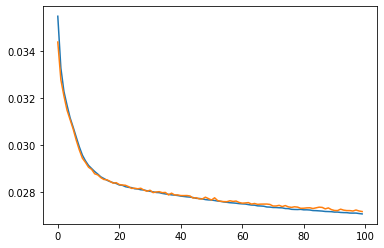

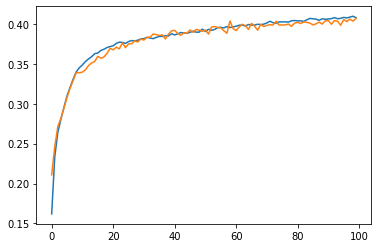

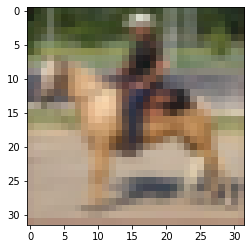

actual_label: 7 predicted_label: 4 actual_class: plane predicted_class: ship


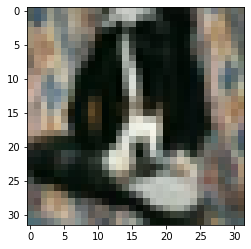

actual_label: 5 predicted_label: 6 actual_class: dog predicted_class: bird


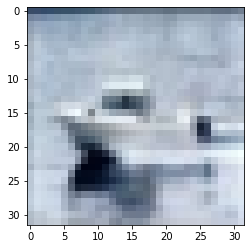

actual_label: 8 predicted_label: 0 actual_class: horse predicted_class: cat


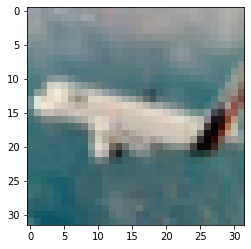

actual_label: 0 predicted_label: 8 actual_class: cat predicted_class: horse


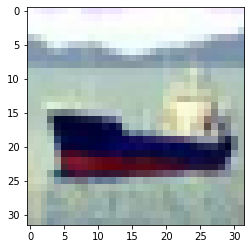

actual_label: 8 predicted_label: 9 actual_class: horse predicted_class: bird


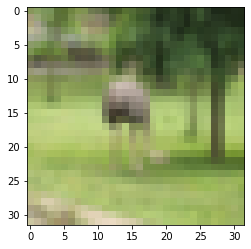

actual_label: 2 predicted_label: 4 actual_class: ship predicted_class: ship


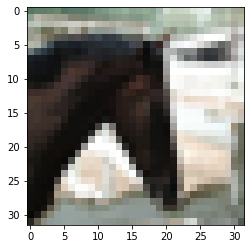

actual_label: 7 predicted_label: 2 actual_class: plane predicted_class: ship


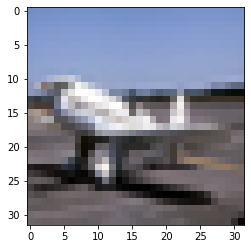

actual_label: 0 predicted_label: 9 actual_class: cat predicted_class: bird


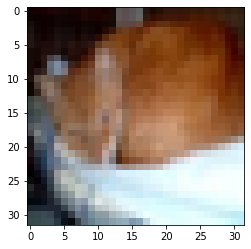

actual_label: 3 predicted_label: 5 actual_class: car predicted_class: dog


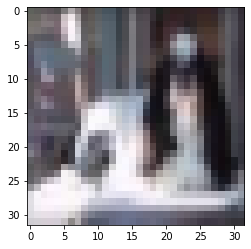

actual_label: 5 predicted_label: 3 actual_class: dog predicted_class: car

 test loss: 0.027204170668865466 test acc: 0.39460589171974525 correct: 3965 incorrect: 6035


In [ ]:
batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

torch.manual_seed(42)
validation_size = 5000
train_size = len(trainset)-validation_size
train_set, validation_set = random_split(trainset, [train_size, validation_size])


train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True,num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=64,shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False)

print("trainset:",len(train_set))
print("validationset:",len(validation_set))
print("testset:",len(test_set))

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

dataiter = iter(train_dataloader)
images, labels = dataiter.next()


def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(labels)


class ConvolutionNetwork1(nn.Module):

  def __init__(self):
    super(ConvolutionNetwork1,self).__init__()
    
    self.flatten_shape =  64*14*14

    self.conv = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5,stride=1),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5,stride=1),
          nn.AvgPool2d(kernel_size=2,stride=1),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5,stride=1),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5,stride=1),
          nn.AvgPool2d(kernel_size=2,stride=1)
    )

    self.fc = nn.Sequential( 
        nn.Linear(in_features=self.flatten_shape, out_features=128),
        nn.Linear(in_features=128, out_features=64),
        nn.Linear(in_features=64, out_features=10)
    )


  def forward(self,x):
    x = self.conv(x)
    flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
    # print("ff:",x.shape,flat_features.shape)
    x=self.fc(flat_features)
    return x


device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        correct = 0
        incorrect = 0
        for imgs,lbls in dataloader:
            imgs = imgs
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls).item()
            correct += torch.sum(test_pred == lbls).item()
            incorrect += torch.sum(test_pred != lbls).item()

        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))
        
        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img.unsqueeze(0))
              pred_lbl = out
              imshow(img.cpu().detach())
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp,"actual_class:",classes[actual_lbl_disp],"predicted_class:",classes[pred_lbl_disp])

            return test_loss,test_acc,correct,incorrect
    
    return test_loss,test_acc,correct,incorrect


from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 100
learning_rate = 0.0001

model = ConvolutionNetwork1().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  train_correct = 0
  train_incorrect = 0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      train_correct += torch.sum(torch.argmax(out, dim=1) == lbls).item()
      train_incorrect += torch.sum(torch.argmax(out, dim=1) != lbls).item()
      running_acc += acc.item()

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  val_loss,val_acc,correct,incorrect = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size),"train_correct:",train_correct,"train_incorrect:",train_incorrect," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"correct:",correct,"incorrect:",incorrect,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()

model.eval()
test_loss,test_acc,test_correct,test_incorrect = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc,"correct:",test_correct,"incorrect:",test_incorrect)




#**Question 3** 

**2. Conv-Pool-BatchNormalization-ReLU-Conv-Pool-BatchNormalization-ReLU-FC**



# (b)
**maxpool - (5,5)**

**stride - 1**

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import torchvision.datasets as datasets
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
from torch.utils.data import random_split


Files already downloaded and verified
Files already downloaded and verified
trainset: 45000
validationset: 5000
testset: 10000


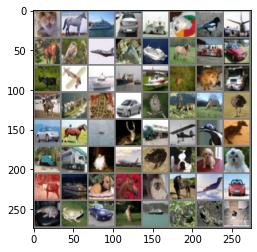

tensor([3, 7, 8, 1, 8, 5, 2, 0, 7, 2, 0, 2, 8, 7, 9, 1, 4, 0, 8, 8, 0, 4, 5, 9,
        7, 8, 6, 1, 2, 4, 5, 2, 1, 7, 8, 4, 9, 0, 2, 2, 9, 9, 3, 0, 6, 5, 5, 5,
        4, 8, 5, 7, 5, 7, 0, 1, 3, 6, 1, 4, 8, 6, 6, 3])
cuda


100%|██████████| 704/704 [00:18<00:00, 38.88it/s, batch_loss=1.621299147605896]



epoch: 0  Train Loss: 0.029859023134287618  Train Accuracy: 0.3246182528409091 train_correct: 14626 train_incorrect: 30374  Validation Loss: 0.026761722031839286  Validation Accuracy: 0.38330696202531644 correct: 1938 incorrect: 3062 



100%|██████████| 704/704 [00:18<00:00, 39.09it/s, batch_loss=1.4627001285552979]



epoch: 1  Train Loss: 0.025269228917419572  Train Accuracy: 0.4225408380681818 train_correct: 19038 train_incorrect: 25962  Validation Loss: 0.024473526173188716  Validation Accuracy: 0.43136867088607594 correct: 2181 incorrect: 2819 



100%|██████████| 704/704 [00:18<00:00, 38.76it/s, batch_loss=1.3430445194244385]



epoch: 2  Train Loss: 0.023462639849061485  Train Accuracy: 0.462890625 train_correct: 20856 train_incorrect: 24144  Validation Loss: 0.023224445649340182  Validation Accuracy: 0.4620253164556962 correct: 2336 incorrect: 2664 



100%|██████████| 704/704 [00:18<00:00, 38.95it/s, batch_loss=1.133334755897522]



epoch: 3  Train Loss: 0.022381240806267175  Train Accuracy: 0.4873934659090909 train_correct: 21960 train_incorrect: 23040  Validation Loss: 0.022365364305014852  Validation Accuracy: 0.4853639240506329 correct: 2454 incorrect: 2546 



100%|██████████| 704/704 [00:18<00:00, 38.60it/s, batch_loss=1.525264859199524]



epoch: 4  Train Loss: 0.02151594412333163  Train Accuracy: 0.5099431818181818 train_correct: 22976 train_incorrect: 22024  Validation Loss: 0.02168403419701359  Validation Accuracy: 0.5027689873417721 correct: 2542 incorrect: 2458 



100%|██████████| 704/704 [00:19<00:00, 36.51it/s, batch_loss=0.9386410713195801]



epoch: 5  Train Loss: 0.020794141696321523  Train Accuracy: 0.5273215553977273 train_correct: 23759 train_incorrect: 21241  Validation Loss: 0.02115108530166783  Validation Accuracy: 0.5152294303797469 correct: 2605 incorrect: 2395 



100%|██████████| 704/704 [00:18<00:00, 39.03it/s, batch_loss=1.7958585023880005]



epoch: 6  Train Loss: 0.02018355213460216  Train Accuracy: 0.5426358309659091 train_correct: 24449 train_incorrect: 20551  Validation Loss: 0.020563696581823162  Validation Accuracy: 0.5332278481012658 correct: 2696 incorrect: 2304 



100%|██████████| 704/704 [00:18<00:00, 38.39it/s, batch_loss=0.9619033932685852]



epoch: 7  Train Loss: 0.019568339937408877  Train Accuracy: 0.5577503551136364 train_correct: 25130 train_incorrect: 19870  Validation Loss: 0.019991685718863825  Validation Accuracy: 0.5446993670886076 correct: 2754 incorrect: 2246 



100%|██████████| 704/704 [00:18<00:00, 38.48it/s, batch_loss=1.6745398044586182]



epoch: 8  Train Loss: 0.01900893405730709  Train Accuracy: 0.5713112571022727 train_correct: 25741 train_incorrect: 19259  Validation Loss: 0.01948358393215303  Validation Accuracy: 0.5634889240506329 correct: 2849 incorrect: 2151 



100%|██████████| 704/704 [00:18<00:00, 38.69it/s, batch_loss=1.8275749683380127]



epoch: 9  Train Loss: 0.01852366609223695  Train Accuracy: 0.5856045809659091 train_correct: 26385 train_incorrect: 18615  Validation Loss: 0.01919118281972559  Validation Accuracy: 0.5664556962025317 correct: 2864 incorrect: 2136 



100%|██████████| 704/704 [00:18<00:00, 38.55it/s, batch_loss=1.4937931299209595]



epoch: 10  Train Loss: 0.01809269852211318  Train Accuracy: 0.5954811789772727 train_correct: 26830 train_incorrect: 18170  Validation Loss: 0.018797104070080988  Validation Accuracy: 0.578125 correct: 2923 incorrect: 2077 



100%|██████████| 704/704 [00:18<00:00, 38.76it/s, batch_loss=0.6662724614143372]



epoch: 11  Train Loss: 0.017707586272577333  Train Accuracy: 0.602783203125 train_correct: 27159 train_incorrect: 17841  Validation Loss: 0.018529588179780714  Validation Accuracy: 0.5797072784810127 correct: 2931 incorrect: 2069 



100%|██████████| 704/704 [00:18<00:00, 38.50it/s, batch_loss=1.010495662689209]



epoch: 12  Train Loss: 0.017408680033192715  Train Accuracy: 0.6104847301136364 train_correct: 27506 train_incorrect: 17494  Validation Loss: 0.018375451146047328  Validation Accuracy: 0.5846518987341772 correct: 2956 incorrect: 2044 



100%|██████████| 704/704 [00:18<00:00, 38.49it/s, batch_loss=0.7067509889602661]



epoch: 13  Train Loss: 0.01712405780430841  Train Accuracy: 0.6168767755681818 train_correct: 27794 train_incorrect: 17206  Validation Loss: 0.018050061185148698  Validation Accuracy: 0.5886075949367089 correct: 2976 incorrect: 2024 



100%|██████████| 704/704 [00:18<00:00, 38.50it/s, batch_loss=1.53044593334198]



epoch: 14  Train Loss: 0.01691665336362679  Train Accuracy: 0.620361328125 train_correct: 27951 train_incorrect: 17049  Validation Loss: 0.017876031278054927  Validation Accuracy: 0.5953322784810127 correct: 3010 incorrect: 1990 



100%|██████████| 704/704 [00:18<00:00, 38.38it/s, batch_loss=1.1519088745117188]



epoch: 15  Train Loss: 0.016672805937229317  Train Accuracy: 0.6271528764204546 train_correct: 28257 train_incorrect: 16743  Validation Loss: 0.01777789830171232  Validation Accuracy: 0.5941455696202531 correct: 3004 incorrect: 1996 



100%|██████████| 704/704 [00:18<00:00, 38.92it/s, batch_loss=0.681685745716095]



epoch: 16  Train Loss: 0.01643613937829452  Train Accuracy: 0.6334117542613636 train_correct: 28539 train_incorrect: 16461  Validation Loss: 0.01781429060369353  Validation Accuracy: 0.5957278481012658 correct: 3012 incorrect: 1988 



100%|██████████| 704/704 [00:18<00:00, 38.36it/s, batch_loss=1.146881341934204]



epoch: 17  Train Loss: 0.016248527084826492  Train Accuracy: 0.6363192471590909 train_correct: 28670 train_incorrect: 16330  Validation Loss: 0.017413904784318014  Validation Accuracy: 0.6034414556962026 correct: 3051 incorrect: 1949 



100%|██████████| 704/704 [00:18<00:00, 38.82it/s, batch_loss=0.6176998615264893]



epoch: 18  Train Loss: 0.016017639083491467  Train Accuracy: 0.641357421875 train_correct: 28897 train_incorrect: 16103  Validation Loss: 0.017563818505953385  Validation Accuracy: 0.6002768987341772 correct: 3035 incorrect: 1965 



100%|██████████| 704/704 [00:18<00:00, 38.25it/s, batch_loss=1.6710519790649414]



epoch: 19  Train Loss: 0.0159029802730815  Train Accuracy: 0.6468616832386364 train_correct: 29145 train_incorrect: 15855  Validation Loss: 0.017232121274912658  Validation Accuracy: 0.6050237341772152 correct: 3059 incorrect: 1941 



100%|██████████| 704/704 [00:18<00:00, 38.16it/s, batch_loss=1.2555623054504395]



epoch: 20  Train Loss: 0.015731896461643788  Train Accuracy: 0.6490145596590909 train_correct: 29242 train_incorrect: 15758  Validation Loss: 0.01718152150558897  Validation Accuracy: 0.6042325949367089 correct: 3055 incorrect: 1945 



100%|██████████| 704/704 [00:18<00:00, 38.87it/s, batch_loss=1.879037857055664]



epoch: 21  Train Loss: 0.015601398863840255  Train Accuracy: 0.6536532315340909 train_correct: 29451 train_incorrect: 15549  Validation Loss: 0.01696634423459255  Validation Accuracy: 0.6113528481012658 correct: 3091 incorrect: 1909 



100%|██████████| 704/704 [00:18<00:00, 38.31it/s, batch_loss=0.7919222116470337]



epoch: 22  Train Loss: 0.015423405586096289  Train Accuracy: 0.6569602272727273 train_correct: 29600 train_incorrect: 15400  Validation Loss: 0.017034398415420628  Validation Accuracy: 0.6034414556962026 correct: 3051 incorrect: 1949 



100%|██████████| 704/704 [00:18<00:00, 38.24it/s, batch_loss=0.8107088804244995]



epoch: 23  Train Loss: 0.01526571826649491  Train Accuracy: 0.6592018821022727 train_correct: 29701 train_incorrect: 15299  Validation Loss: 0.0168835522041102  Validation Accuracy: 0.6115506329113924 correct: 3092 incorrect: 1908 



100%|██████████| 704/704 [00:18<00:00, 38.27it/s, batch_loss=0.8094385862350464]



epoch: 24  Train Loss: 0.015133114825320345  Train Accuracy: 0.6640181107954546 train_correct: 29918 train_incorrect: 15082  Validation Loss: 0.016969606280326843  Validation Accuracy: 0.6133306962025317 correct: 3101 incorrect: 1899 



100%|██████████| 704/704 [00:18<00:00, 38.09it/s, batch_loss=0.3451173007488251]



epoch: 25  Train Loss: 0.014974339085297701  Train Accuracy: 0.6681685014204546 train_correct: 30105 train_incorrect: 14895  Validation Loss: 0.016774436352845236  Validation Accuracy: 0.616495253164557 correct: 3117 incorrect: 1883 



100%|██████████| 704/704 [00:18<00:00, 38.34it/s, batch_loss=1.2269837856292725]



epoch: 26  Train Loss: 0.014880373622872867  Train Accuracy: 0.6675470525568182 train_correct: 30077 train_incorrect: 14923  Validation Loss: 0.01673256315856795  Validation Accuracy: 0.6127373417721519 correct: 3098 incorrect: 1902 



100%|██████████| 704/704 [00:18<00:00, 38.02it/s, batch_loss=1.4341788291931152]



epoch: 27  Train Loss: 0.014772147315935317  Train Accuracy: 0.6736949573863636 train_correct: 30354 train_incorrect: 14646  Validation Loss: 0.01655760822416861  Validation Accuracy: 0.6212420886075949 correct: 3141 incorrect: 1859 



100%|██████████| 704/704 [00:18<00:00, 38.22it/s, batch_loss=1.5518357753753662]



epoch: 28  Train Loss: 0.014637628709103657  Train Accuracy: 0.6744273792613636 train_correct: 30387 train_incorrect: 14613  Validation Loss: 0.016591460361510893  Validation Accuracy: 0.6186708860759493 correct: 3128 incorrect: 1872 



100%|██████████| 704/704 [00:18<00:00, 38.23it/s, batch_loss=1.0205090045928955]



epoch: 29  Train Loss: 0.014481281538874928  Train Accuracy: 0.6784446022727273 train_correct: 30568 train_incorrect: 14432  Validation Loss: 0.01654402547386251  Validation Accuracy: 0.617879746835443 correct: 3124 incorrect: 1876 



100%|██████████| 704/704 [00:18<00:00, 38.11it/s, batch_loss=1.1093369722366333]



epoch: 30  Train Loss: 0.014355664456326684  Train Accuracy: 0.6808638139204546 train_correct: 30677 train_incorrect: 14323  Validation Loss: 0.016491902650251418  Validation Accuracy: 0.6190664556962026 correct: 3130 incorrect: 1870 



100%|██████████| 704/704 [00:18<00:00, 38.41it/s, batch_loss=0.7969393730163574]



epoch: 31  Train Loss: 0.014239279170975682  Train Accuracy: 0.68212890625 train_correct: 30734 train_incorrect: 14266  Validation Loss: 0.016393335158877736  Validation Accuracy: 0.6210443037974683 correct: 3140 incorrect: 1860 



100%|██████████| 704/704 [00:18<00:00, 37.91it/s, batch_loss=1.1021699905395508]



epoch: 32  Train Loss: 0.014155499721792612  Train Accuracy: 0.6883433948863636 train_correct: 31014 train_incorrect: 13986  Validation Loss: 0.01639351844080264  Validation Accuracy: 0.6214398734177216 correct: 3142 incorrect: 1858 



100%|██████████| 704/704 [00:18<00:00, 38.12it/s, batch_loss=0.9779160618782043]



epoch: 33  Train Loss: 0.014035361378443089  Train Accuracy: 0.6886319247159091 train_correct: 31027 train_incorrect: 13973  Validation Loss: 0.016309239736557762  Validation Accuracy: 0.6212420886075949 correct: 3141 incorrect: 1859 



100%|██████████| 704/704 [00:18<00:00, 38.07it/s, batch_loss=0.8569272756576538]



epoch: 34  Train Loss: 0.013939225347712636  Train Accuracy: 0.6911843039772727 train_correct: 31142 train_incorrect: 13858  Validation Loss: 0.016376992840838583  Validation Accuracy: 0.6174841772151899 correct: 3122 incorrect: 1878 



100%|██████████| 704/704 [00:18<00:00, 37.47it/s, batch_loss=1.2471638917922974]



epoch: 35  Train Loss: 0.013843511210077188  Train Accuracy: 0.6938698508522727 train_correct: 31263 train_incorrect: 13737  Validation Loss: 0.01644566656337886  Validation Accuracy: 0.6238132911392406 correct: 3154 incorrect: 1846 



100%|██████████| 704/704 [00:18<00:00, 37.88it/s, batch_loss=0.4812469184398651]



epoch: 36  Train Loss: 0.013694135749326299  Train Accuracy: 0.6961558948863636 train_correct: 31366 train_incorrect: 13634  Validation Loss: 0.016305752346127092  Validation Accuracy: 0.627373417721519 correct: 3172 incorrect: 1828 



100%|██████████| 704/704 [00:18<00:00, 37.88it/s, batch_loss=1.2416596412658691]



epoch: 37  Train Loss: 0.013647401159025983  Train Accuracy: 0.6987082741477273 train_correct: 31481 train_incorrect: 13519  Validation Loss: 0.016217981771672073  Validation Accuracy: 0.6240110759493671 correct: 3155 incorrect: 1845 



100%|██████████| 704/704 [00:18<00:00, 37.74it/s, batch_loss=1.338325023651123]



epoch: 38  Train Loss: 0.013529177487891337  Train Accuracy: 0.700439453125 train_correct: 31559 train_incorrect: 13441  Validation Loss: 0.016182104396763482  Validation Accuracy: 0.625 correct: 3160 incorrect: 1840 



100%|██████████| 704/704 [00:18<00:00, 37.52it/s, batch_loss=0.8511670231819153]



epoch: 39  Train Loss: 0.01341416432445509  Train Accuracy: 0.7020818536931818 train_correct: 31633 train_incorrect: 13367  Validation Loss: 0.016359018916382067  Validation Accuracy: 0.6279667721518988 correct: 3175 incorrect: 1825 



100%|██████████| 704/704 [00:18<00:00, 37.83it/s, batch_loss=0.44169846177101135]



epoch: 40  Train Loss: 0.013296490834777202  Train Accuracy: 0.7052778764204546 train_correct: 31777 train_incorrect: 13223  Validation Loss: 0.016153668949404097  Validation Accuracy: 0.6275712025316456 correct: 3173 incorrect: 1827 



100%|██████████| 704/704 [00:18<00:00, 37.93it/s, batch_loss=0.5119161009788513]



epoch: 41  Train Loss: 0.013249736792534928  Train Accuracy: 0.7064763849431818 train_correct: 31831 train_incorrect: 13169  Validation Loss: 0.016292933303909966  Validation Accuracy: 0.6285601265822784 correct: 3178 incorrect: 1822 



100%|██████████| 704/704 [00:18<00:00, 37.43it/s, batch_loss=0.3220716416835785]



epoch: 42  Train Loss: 0.013154670205866833  Train Accuracy: 0.7116255326704546 train_correct: 32063 train_incorrect: 12937  Validation Loss: 0.016386235026713415  Validation Accuracy: 0.6251977848101266 correct: 3161 incorrect: 1839 



100%|██████████| 704/704 [00:18<00:00, 37.98it/s, batch_loss=1.1357425451278687]



epoch: 43  Train Loss: 0.01304792954496489  Train Accuracy: 0.7126686789772727 train_correct: 32110 train_incorrect: 12890  Validation Loss: 0.01609398865530008  Validation Accuracy: 0.6325158227848101 correct: 3198 incorrect: 1802 



100%|██████████| 704/704 [00:18<00:00, 37.96it/s, batch_loss=0.623448371887207]



epoch: 44  Train Loss: 0.012966675421921536  Train Accuracy: 0.7148881392045454 train_correct: 32210 train_incorrect: 12790  Validation Loss: 0.016327709442924096  Validation Accuracy: 0.6240110759493671 correct: 3155 incorrect: 1845 



100%|██████████| 704/704 [00:18<00:00, 38.05it/s, batch_loss=0.8793647289276123]



epoch: 45  Train Loss: 0.012880242825221185  Train Accuracy: 0.7154430042613636 train_correct: 32235 train_incorrect: 12765  Validation Loss: 0.01624248301775395  Validation Accuracy: 0.6287579113924051 correct: 3179 incorrect: 1821 



100%|██████████| 704/704 [00:18<00:00, 37.99it/s, batch_loss=0.954992949962616]



epoch: 46  Train Loss: 0.012803076243885285  Train Accuracy: 0.7199041193181818 train_correct: 32436 train_incorrect: 12564  Validation Loss: 0.016110596742150905  Validation Accuracy: 0.631131329113924 correct: 3191 incorrect: 1809 



100%|██████████| 704/704 [00:18<00:00, 37.92it/s, batch_loss=0.6037520170211792]



epoch: 47  Train Loss: 0.012694801221104253  Train Accuracy: 0.720458984375 train_correct: 32461 train_incorrect: 12539  Validation Loss: 0.016144253242808052  Validation Accuracy: 0.627373417721519 correct: 3172 incorrect: 1828 



100%|██████████| 704/704 [00:18<00:00, 37.99it/s, batch_loss=0.7699406743049622]



epoch: 48  Train Loss: 0.012608395053989212  Train Accuracy: 0.7232998934659091 train_correct: 32589 train_incorrect: 12411  Validation Loss: 0.01616046486917553  Validation Accuracy: 0.6303401898734177 correct: 3187 incorrect: 1813 



100%|██████████| 704/704 [00:18<00:00, 37.83it/s, batch_loss=0.46769627928733826]



epoch: 49  Train Loss: 0.012571830474454064  Train Accuracy: 0.7227672230113636 train_correct: 32565 train_incorrect: 12435  Validation Loss: 0.01612588282250151  Validation Accuracy: 0.6269778481012658 correct: 3170 incorrect: 1830 



100%|██████████| 704/704 [00:18<00:00, 37.79it/s, batch_loss=0.7727557420730591]



epoch: 50  Train Loss: 0.012431176533441017  Train Accuracy: 0.7276500355113636 train_correct: 32785 train_incorrect: 12215  Validation Loss: 0.016094595052396195  Validation Accuracy: 0.629746835443038 correct: 3184 incorrect: 1816 



100%|██████████| 704/704 [00:18<00:00, 37.96it/s, batch_loss=0.3386733829975128]



epoch: 51  Train Loss: 0.012353363464089025  Train Accuracy: 0.7280051491477273 train_correct: 32801 train_incorrect: 12199  Validation Loss: 0.016265671287627913  Validation Accuracy: 0.6333069620253164 correct: 3202 incorrect: 1798 



100%|██████████| 704/704 [00:18<00:00, 37.97it/s, batch_loss=1.17387855052948]



epoch: 52  Train Loss: 0.01233722202067094  Train Accuracy: 0.7285822088068182 train_correct: 32827 train_incorrect: 12173  Validation Loss: 0.016303997510407543  Validation Accuracy: 0.6275712025316456 correct: 3173 incorrect: 1827 



100%|██████████| 704/704 [00:18<00:00, 37.40it/s, batch_loss=1.1957703828811646]



epoch: 53  Train Loss: 0.012233074139327404  Train Accuracy: 0.7317338423295454 train_correct: 32969 train_incorrect: 12031  Validation Loss: 0.016534568942328798  Validation Accuracy: 0.6240110759493671 correct: 3155 incorrect: 1845 



100%|██████████| 704/704 [00:18<00:00, 37.81it/s, batch_loss=0.8802279829978943]



epoch: 54  Train Loss: 0.012194188376518221  Train Accuracy: 0.7326882102272727 train_correct: 33012 train_incorrect: 11988  Validation Loss: 0.016484257163880748  Validation Accuracy: 0.6244066455696202 correct: 3157 incorrect: 1843 



100%|██████████| 704/704 [00:18<00:00, 37.35it/s, batch_loss=0.7921333909034729]



epoch: 55  Train Loss: 0.0120649346671681  Train Accuracy: 0.7373046875 train_correct: 33220 train_incorrect: 11780  Validation Loss: 0.01630701852042841  Validation Accuracy: 0.6283623417721519 correct: 3177 incorrect: 1823 



100%|██████████| 704/704 [00:18<00:00, 37.71it/s, batch_loss=0.47070738673210144]



epoch: 56  Train Loss: 0.011994506881985051  Train Accuracy: 0.7375932173295454 train_correct: 33233 train_incorrect: 11767  Validation Loss: 0.016430288517871237  Validation Accuracy: 0.6216376582278481 correct: 3143 incorrect: 1857 



100%|██████████| 704/704 [00:18<00:00, 37.70it/s, batch_loss=0.843647301197052]



epoch: 57  Train Loss: 0.011922883882520679  Train Accuracy: 0.7385919744318182 train_correct: 33278 train_incorrect: 11722  Validation Loss: 0.01636864639865824  Validation Accuracy: 0.6295490506329114 correct: 3183 incorrect: 1817 



100%|██████████| 704/704 [00:18<00:00, 37.56it/s, batch_loss=0.5836881995201111]



epoch: 58  Train Loss: 0.011823360437781295  Train Accuracy: 0.7406782670454546 train_correct: 33372 train_incorrect: 11628  Validation Loss: 0.016325348717030844  Validation Accuracy: 0.6267800632911392 correct: 3169 incorrect: 1831 



100%|██████████| 704/704 [00:18<00:00, 37.38it/s, batch_loss=0.9754481315612793]



epoch: 59  Train Loss: 0.011725104128179903  Train Accuracy: 0.7437411221590909 train_correct: 33510 train_incorrect: 11490  Validation Loss: 0.016454890287846705  Validation Accuracy: 0.6253955696202531 correct: 3162 incorrect: 1838 



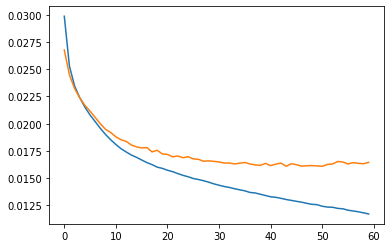

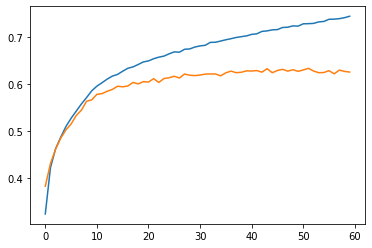

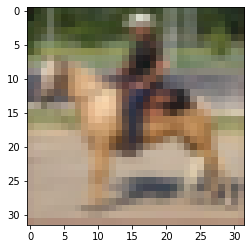

actual_label: 7 predicted_label: 7 actual_class: plane predicted_class: plane


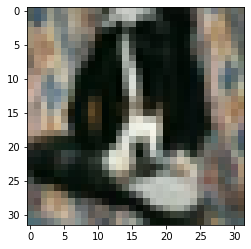

actual_label: 5 predicted_label: 3 actual_class: dog predicted_class: car


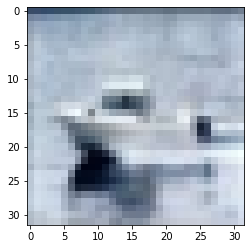

actual_label: 8 predicted_label: 8 actual_class: horse predicted_class: horse


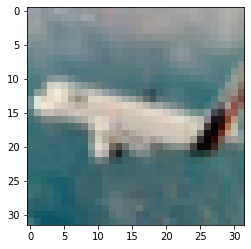

actual_label: 0 predicted_label: 0 actual_class: cat predicted_class: cat


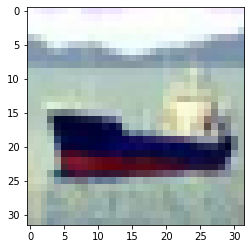

actual_label: 8 predicted_label: 0 actual_class: horse predicted_class: cat


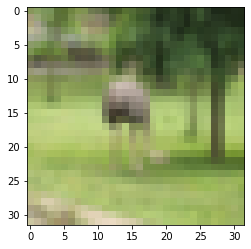

actual_label: 2 predicted_label: 7 actual_class: ship predicted_class: plane


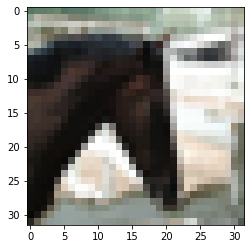

actual_label: 7 predicted_label: 5 actual_class: plane predicted_class: dog


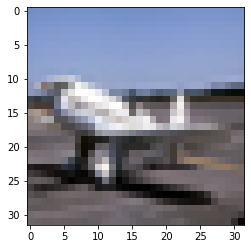

actual_label: 0 predicted_label: 9 actual_class: cat predicted_class: bird


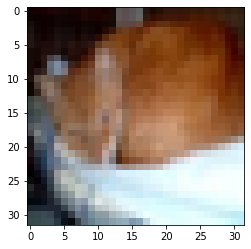

actual_label: 3 predicted_label: 6 actual_class: car predicted_class: bird


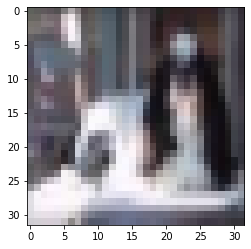

actual_label: 5 predicted_label: 3 actual_class: dog predicted_class: car

 test loss: 0.016407584937609684 test acc: 0.6359474522292994 correct: 6390 incorrect: 3610


In [ ]:
batch_szie=64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

torch.manual_seed(42)
validation_size = 5000
train_size = len(trainset)-validation_size
train_set, validation_set = random_split(trainset, [train_size, validation_size])


train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True,num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=64,shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False)

print("trainset:",len(train_set))
print("validationset:",len(validation_set))
print("testset:",len(test_set))

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

dataiter = iter(train_dataloader)
images, labels = dataiter.next()


def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(labels)

class ConvolutionNetwork1(nn.Module):

  def __init__(self):
    super(ConvolutionNetwork1,self).__init__()
    
    self.flatten_shape =  16*22*22

    self.conv = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5,stride=1),
          nn.MaxPool2d(kernel_size=(2,2),stride=1),
          nn.BatchNorm2d(8),
          nn.ReLU(True),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5,stride=1),
          nn.MaxPool2d(kernel_size=(2,2),stride=1),
          nn.BatchNorm2d(16),
          nn.ReLU(True)
    )

    self.fc = nn.Sequential( 
        nn.Linear(in_features=self.flatten_shape, out_features=128),
        nn.Linear(in_features=128, out_features=10)
    )

  def forward(self,x):
    x = self.conv(x)
    flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
    # print("ff:",x.shape,flat_features.shape)
    x=self.fc(flat_features)
    return x


device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        correct = 0
        incorrect = 0
        for imgs,lbls in dataloader:
            imgs = imgs
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls).item()
            correct += torch.sum(test_pred == lbls).item()
            incorrect += torch.sum(test_pred != lbls).item()

        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))
        
        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img.unsqueeze(0))
              pred_lbl = out
              imshow(img.cpu().detach())
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp,"actual_class:",classes[actual_lbl_disp],"predicted_class:",classes[pred_lbl_disp])#classes[labels[pred_lbl_disp]])
                        
            return test_loss,test_acc,correct,incorrect
    
    return test_loss,test_acc,correct,incorrect


from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 60
learning_rate = 0.0001

model = ConvolutionNetwork1().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  train_correct = 0
  train_incorrect = 0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      train_correct += torch.sum(torch.argmax(out, dim=1) == lbls).item()
      train_incorrect += torch.sum(torch.argmax(out, dim=1) != lbls).item()
      running_acc += acc.item()

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  val_loss,val_acc,correct,incorrect = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size),"train_correct:",train_correct,"train_incorrect:",train_incorrect," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"correct:",correct,"incorrect:",incorrect,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()

model.eval()
test_loss,test_acc,test_correct,test_incorrect = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc,"correct:",test_correct,"incorrect:",test_incorrect)




# (b)
**maxpool - (1,1)**

**stride - 2**

Files already downloaded and verified
Files already downloaded and verified
trainset: 45000
validationset: 5000
testset: 10000


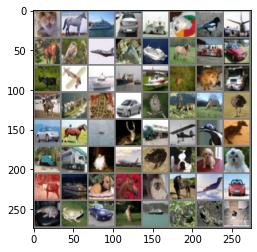

tensor([3, 7, 8, 1, 8, 5, 2, 0, 7, 2, 0, 2, 8, 7, 9, 1, 4, 0, 8, 8, 0, 4, 5, 9,
        7, 8, 6, 1, 2, 4, 5, 2, 1, 7, 8, 4, 9, 0, 2, 2, 9, 9, 3, 0, 6, 5, 5, 5,
        4, 8, 5, 7, 5, 7, 0, 1, 3, 6, 1, 4, 8, 6, 6, 3])
cuda


100%|██████████| 704/704 [00:17<00:00, 39.69it/s, batch_loss=2.2920243740081787]



epoch: 0  Train Loss: 0.03564379121367396  Train Accuracy: 0.14808238636363635 train_correct: 6672 train_incorrect: 38328  Validation Loss: 0.0349853444325773  Validation Accuracy: 0.17029272151898733 correct: 861 incorrect: 4139 



100%|██████████| 704/704 [00:17<00:00, 40.06it/s, batch_loss=2.2669637203216553]



epoch: 1  Train Loss: 0.03460827017922632  Train Accuracy: 0.19014115767045456 train_correct: 8567 train_incorrect: 36433  Validation Loss: 0.034212440063681786  Validation Accuracy: 0.20589398734177214 correct: 1041 incorrect: 3959 



100%|██████████| 704/704 [00:17<00:00, 39.77it/s, batch_loss=2.0144155025482178]



epoch: 2  Train Loss: 0.033928663284644826  Train Accuracy: 0.21142578125 train_correct: 9526 train_incorrect: 35474  Validation Loss: 0.03363905243481262  Validation Accuracy: 0.21617879746835442 correct: 1093 incorrect: 3907 



100%|██████████| 704/704 [00:17<00:00, 40.16it/s, batch_loss=2.383315086364746]



epoch: 3  Train Loss: 0.033418049056887285  Train Accuracy: 0.2220126065340909 train_correct: 10003 train_incorrect: 34997  Validation Loss: 0.0331889783751361  Validation Accuracy: 0.22626582278481014 correct: 1144 incorrect: 3856 



100%|██████████| 704/704 [00:17<00:00, 39.78it/s, batch_loss=2.076878547668457]



epoch: 4  Train Loss: 0.03300860361196101  Train Accuracy: 0.22960316051136365 train_correct: 10345 train_incorrect: 34655  Validation Loss: 0.03284735480158389  Validation Accuracy: 0.22943037974683544 correct: 1160 incorrect: 3840 



100%|██████████| 704/704 [00:17<00:00, 40.02it/s, batch_loss=2.0396628379821777]



epoch: 5  Train Loss: 0.03272349812852388  Train Accuracy: 0.23655007102272727 train_correct: 10658 train_incorrect: 34342  Validation Loss: 0.032588062524984154  Validation Accuracy: 0.23635284810126583 correct: 1195 incorrect: 3805 



100%|██████████| 704/704 [00:17<00:00, 39.64it/s, batch_loss=2.3269565105438232]



epoch: 6  Train Loss: 0.03249298739088276  Train Accuracy: 0.2433194247159091 train_correct: 10963 train_incorrect: 34037  Validation Loss: 0.0323745301582768  Validation Accuracy: 0.24050632911392406 correct: 1216 incorrect: 3784 



100%|██████████| 704/704 [00:17<00:00, 39.68it/s, batch_loss=2.1385483741760254]



epoch: 7  Train Loss: 0.0322687261055266  Train Accuracy: 0.25244140625 train_correct: 11374 train_incorrect: 33626  Validation Loss: 0.032185606493414204  Validation Accuracy: 0.25 correct: 1264 incorrect: 3736 



100%|██████████| 704/704 [00:17<00:00, 40.02it/s, batch_loss=1.6568517684936523]



epoch: 8  Train Loss: 0.03209772450976412  Train Accuracy: 0.257080078125 train_correct: 11583 train_incorrect: 33417  Validation Loss: 0.03201518596821948  Validation Accuracy: 0.2555379746835443 correct: 1292 incorrect: 3708 



100%|██████████| 704/704 [00:17<00:00, 39.46it/s, batch_loss=1.8464772701263428]



epoch: 9  Train Loss: 0.03192488865567033  Train Accuracy: 0.26109730113636365 train_correct: 11764 train_incorrect: 33236  Validation Loss: 0.031850846955859206  Validation Accuracy: 0.25850474683544306 correct: 1307 incorrect: 3693 



100%|██████████| 704/704 [00:17<00:00, 39.94it/s, batch_loss=2.370006799697876]



epoch: 10  Train Loss: 0.03178406686426818  Train Accuracy: 0.26615767045454547 train_correct: 11992 train_incorrect: 33008  Validation Loss: 0.031696562808525716  Validation Accuracy: 0.26186708860759494 correct: 1324 incorrect: 3676 



100%|██████████| 704/704 [00:17<00:00, 39.96it/s, batch_loss=1.6832540035247803]



epoch: 11  Train Loss: 0.03164402229330418  Train Accuracy: 0.2684659090909091 train_correct: 12096 train_incorrect: 32904  Validation Loss: 0.031550966368257244  Validation Accuracy: 0.26285601265822783 correct: 1329 incorrect: 3671 



100%|██████████| 704/704 [00:17<00:00, 39.47it/s, batch_loss=1.4197642803192139]



epoch: 12  Train Loss: 0.03148163748185404  Train Accuracy: 0.2723943536931818 train_correct: 12273 train_incorrect: 32727  Validation Loss: 0.031411246762056894  Validation Accuracy: 0.2644382911392405 correct: 1337 incorrect: 3663 



100%|██████████| 704/704 [00:17<00:00, 39.60it/s, batch_loss=2.346609354019165]



epoch: 13  Train Loss: 0.03134521568162282  Train Accuracy: 0.2778542258522727 train_correct: 12519 train_incorrect: 32481  Validation Loss: 0.031271096295382404  Validation Accuracy: 0.2689873417721519 correct: 1360 incorrect: 3640 



100%|██████████| 704/704 [00:17<00:00, 39.26it/s, batch_loss=2.0433921813964844]



epoch: 14  Train Loss: 0.03121072891305878  Train Accuracy: 0.2788973721590909 train_correct: 12566 train_incorrect: 32434  Validation Loss: 0.03113439601339117  Validation Accuracy: 0.2719541139240506 correct: 1375 incorrect: 3625 



100%|██████████| 704/704 [00:17<00:00, 39.75it/s, batch_loss=2.010043144226074]



epoch: 15  Train Loss: 0.031067289983515035  Train Accuracy: 0.2832919034090909 train_correct: 12764 train_incorrect: 32236  Validation Loss: 0.03100630695212491  Validation Accuracy: 0.2757120253164557 correct: 1394 incorrect: 3606 



100%|██████████| 704/704 [00:17<00:00, 39.60it/s, batch_loss=1.9396820068359375]



epoch: 16  Train Loss: 0.03095171470406719  Train Accuracy: 0.28544477982954547 train_correct: 12861 train_incorrect: 32139  Validation Loss: 0.03087798296179198  Validation Accuracy: 0.28204113924050633 correct: 1426 incorrect: 3574 



100%|██████████| 704/704 [00:17<00:00, 39.58it/s, batch_loss=2.0508034229278564]



epoch: 17  Train Loss: 0.03084438383865001  Train Accuracy: 0.2883966619318182 train_correct: 12994 train_incorrect: 32006  Validation Loss: 0.030761564857786215  Validation Accuracy: 0.28283227848101267 correct: 1430 incorrect: 3570 



100%|██████████| 704/704 [00:17<00:00, 39.47it/s, batch_loss=2.2007265090942383]



epoch: 18  Train Loss: 0.030729112109508027  Train Accuracy: 0.2916814630681818 train_correct: 13142 train_incorrect: 31858  Validation Loss: 0.030653884870153438  Validation Accuracy: 0.28560126582278483 correct: 1444 incorrect: 3556 



100%|██████████| 704/704 [00:17<00:00, 39.75it/s, batch_loss=1.6472547054290771]



epoch: 19  Train Loss: 0.030636893508596007  Train Accuracy: 0.29219193892045453 train_correct: 13165 train_incorrect: 31835  Validation Loss: 0.030558699341137197  Validation Accuracy: 0.2899525316455696 correct: 1466 incorrect: 3534 



100%|██████████| 704/704 [00:17<00:00, 39.61it/s, batch_loss=2.1759207248687744]



epoch: 20  Train Loss: 0.030566755422941325  Train Accuracy: 0.2937899502840909 train_correct: 13237 train_incorrect: 31763  Validation Loss: 0.030475637462886073  Validation Accuracy: 0.2913370253164557 correct: 1473 incorrect: 3527 



100%|██████████| 704/704 [00:17<00:00, 39.59it/s, batch_loss=1.8080583810806274]



epoch: 21  Train Loss: 0.030480253563093192  Train Accuracy: 0.297119140625 train_correct: 13387 train_incorrect: 31613  Validation Loss: 0.030395557726674443  Validation Accuracy: 0.2903481012658228 correct: 1468 incorrect: 3532 



100%|██████████| 704/704 [00:17<00:00, 40.01it/s, batch_loss=1.7748762369155884]



epoch: 22  Train Loss: 0.030409542298664084  Train Accuracy: 0.2959872159090909 train_correct: 13336 train_incorrect: 31664  Validation Loss: 0.030323957930071446  Validation Accuracy: 0.2927215189873418 correct: 1480 incorrect: 3520 



100%|██████████| 704/704 [00:17<00:00, 39.28it/s, batch_loss=1.8360038995742798]



epoch: 23  Train Loss: 0.030338286414255643  Train Accuracy: 0.29944957386363635 train_correct: 13492 train_incorrect: 31508  Validation Loss: 0.030262474630829653  Validation Accuracy: 0.29489715189873417 correct: 1491 incorrect: 3509 



100%|██████████| 704/704 [00:17<00:00, 39.80it/s, batch_loss=1.8460729122161865]



epoch: 24  Train Loss: 0.03026721602972512  Train Accuracy: 0.30131392045454547 train_correct: 13576 train_incorrect: 31424  Validation Loss: 0.030203461057589025  Validation Accuracy: 0.29489715189873417 correct: 1491 incorrect: 3509 



100%|██████████| 704/704 [00:17<00:00, 39.83it/s, batch_loss=1.7554020881652832]



epoch: 25  Train Loss: 0.030221430693266237  Train Accuracy: 0.3012029474431818 train_correct: 13571 train_incorrect: 31429  Validation Loss: 0.030144995573578002  Validation Accuracy: 0.2950949367088608 correct: 1492 incorrect: 3508 



100%|██████████| 704/704 [00:17<00:00, 39.45it/s, batch_loss=1.8163032531738281]



epoch: 26  Train Loss: 0.03017304433425042  Train Accuracy: 0.302490234375 train_correct: 13629 train_incorrect: 31371  Validation Loss: 0.03009213582624363  Validation Accuracy: 0.29608386075949367 correct: 1497 incorrect: 3503 



100%|██████████| 704/704 [00:17<00:00, 39.74it/s, batch_loss=2.0338141918182373]



epoch: 27  Train Loss: 0.03013109264958819  Train Accuracy: 0.303466796875 train_correct: 13673 train_incorrect: 31327  Validation Loss: 0.030052208966469464  Validation Accuracy: 0.29410601265822783 correct: 1487 incorrect: 3513 



100%|██████████| 704/704 [00:17<00:00, 39.64it/s, batch_loss=2.243166923522949]



epoch: 28  Train Loss: 0.03008785929573192  Train Accuracy: 0.30419921875 train_correct: 13706 train_incorrect: 31294  Validation Loss: 0.030006812295958966  Validation Accuracy: 0.2956882911392405 correct: 1495 incorrect: 3505 



100%|██████████| 704/704 [00:17<00:00, 39.60it/s, batch_loss=1.9191875457763672]



epoch: 29  Train Loss: 0.03005972227600234  Train Accuracy: 0.30570845170454547 train_correct: 13774 train_incorrect: 31226  Validation Loss: 0.02997247681398935  Validation Accuracy: 0.296875 correct: 1501 incorrect: 3499 



100%|██████████| 704/704 [00:17<00:00, 39.31it/s, batch_loss=1.3691177368164062]



epoch: 30  Train Loss: 0.030015388583044776  Train Accuracy: 0.3056418678977273 train_correct: 13771 train_incorrect: 31229  Validation Loss: 0.029934617325286322  Validation Accuracy: 0.2974683544303797 correct: 1504 incorrect: 3496 



100%|██████████| 704/704 [00:17<00:00, 39.63it/s, batch_loss=1.8300360441207886]



epoch: 31  Train Loss: 0.030003034956859086  Train Accuracy: 0.30408824573863635 train_correct: 13701 train_incorrect: 31299  Validation Loss: 0.02990797312953804  Validation Accuracy: 0.29964398734177217 correct: 1515 incorrect: 3485 



100%|██████████| 704/704 [00:17<00:00, 39.51it/s, batch_loss=1.8702841997146606]



epoch: 32  Train Loss: 0.029941302351124414  Train Accuracy: 0.30652965198863635 train_correct: 13811 train_incorrect: 31189  Validation Loss: 0.02987590783476075  Validation Accuracy: 0.2986550632911392 correct: 1510 incorrect: 3490 



100%|██████████| 704/704 [00:17<00:00, 39.57it/s, batch_loss=1.903888463973999]



epoch: 33  Train Loss: 0.029921979082494297  Train Accuracy: 0.3069069602272727 train_correct: 13828 train_incorrect: 31172  Validation Loss: 0.029843930131461048  Validation Accuracy: 0.2990506329113924 correct: 1512 incorrect: 3488 



100%|██████████| 704/704 [00:17<00:00, 39.19it/s, batch_loss=1.5370670557022095]



epoch: 34  Train Loss: 0.02989316067065705  Train Accuracy: 0.3071954900568182 train_correct: 13841 train_incorrect: 31159  Validation Loss: 0.02981770941633967  Validation Accuracy: 0.2974683544303797 correct: 1504 incorrect: 3496 



100%|██████████| 704/704 [00:17<00:00, 39.37it/s, batch_loss=1.4905186891555786]



epoch: 35  Train Loss: 0.029854459666901013  Train Accuracy: 0.3084161931818182 train_correct: 13896 train_incorrect: 31104  Validation Loss: 0.029796255870333202  Validation Accuracy: 0.29944620253164556 correct: 1514 incorrect: 3486 



100%|██████████| 704/704 [00:17<00:00, 40.11it/s, batch_loss=1.9477360248565674]



epoch: 36  Train Loss: 0.02985839550489221  Train Accuracy: 0.3076393821022727 train_correct: 13861 train_incorrect: 31139  Validation Loss: 0.029774867399018023  Validation Accuracy: 0.3002373417721519 correct: 1518 incorrect: 3482 



100%|██████████| 704/704 [00:17<00:00, 39.84it/s, batch_loss=1.7372194528579712]



epoch: 37  Train Loss: 0.02984953475904397  Train Accuracy: 0.30823863636363635 train_correct: 13888 train_incorrect: 31112  Validation Loss: 0.02975159065349947  Validation Accuracy: 0.30003955696202533 correct: 1517 incorrect: 3483 



100%|██████████| 704/704 [00:17<00:00, 39.73it/s, batch_loss=1.6071617603302002]



epoch: 38  Train Loss: 0.029806855494495143  Train Accuracy: 0.30970348011363635 train_correct: 13954 train_incorrect: 31046  Validation Loss: 0.02973624764458288  Validation Accuracy: 0.3002373417721519 correct: 1518 incorrect: 3482 



100%|██████████| 704/704 [00:17<00:00, 39.57it/s, batch_loss=2.163600444793701]



epoch: 39  Train Loss: 0.029797175655734132  Train Accuracy: 0.31059126420454547 train_correct: 13994 train_incorrect: 31006  Validation Loss: 0.029709366963634007  Validation Accuracy: 0.30063291139240506 correct: 1520 incorrect: 3480 



100%|██████████| 704/704 [00:18<00:00, 38.97it/s, batch_loss=2.0966973304748535]



epoch: 40  Train Loss: 0.02978111343955706  Train Accuracy: 0.30908203125 train_correct: 13926 train_incorrect: 31074  Validation Loss: 0.029693904556805574  Validation Accuracy: 0.30122626582278483 correct: 1523 incorrect: 3477 



100%|██████████| 704/704 [00:17<00:00, 39.45it/s, batch_loss=1.68677818775177]



epoch: 41  Train Loss: 0.02976170493374494  Train Accuracy: 0.30943714488636365 train_correct: 13942 train_incorrect: 31058  Validation Loss: 0.029677233741253237  Validation Accuracy: 0.30003955696202533 correct: 1517 incorrect: 3483 



100%|██████████| 704/704 [00:18<00:00, 38.95it/s, batch_loss=1.8434264659881592]



epoch: 42  Train Loss: 0.0297530168609228  Train Accuracy: 0.30992542613636365 train_correct: 13964 train_incorrect: 31036  Validation Loss: 0.02965725361829317  Validation Accuracy: 0.3049841772151899 correct: 1542 incorrect: 3458 



100%|██████████| 704/704 [00:18<00:00, 38.89it/s, batch_loss=1.8408464193344116]



epoch: 43  Train Loss: 0.029719855800398032  Train Accuracy: 0.30961470170454547 train_correct: 13950 train_incorrect: 31050  Validation Loss: 0.02964580151004882  Validation Accuracy: 0.3061708860759494 correct: 1548 incorrect: 3452 



100%|██████████| 704/704 [00:17<00:00, 39.30it/s, batch_loss=1.95854914188385]



epoch: 44  Train Loss: 0.029714051477970894  Train Accuracy: 0.31181196732954547 train_correct: 14049 train_incorrect: 30951  Validation Loss: 0.029629803321595434  Validation Accuracy: 0.3049841772151899 correct: 1542 incorrect: 3458 



100%|██████████| 704/704 [00:17<00:00, 39.21it/s, batch_loss=1.938737392425537]



epoch: 45  Train Loss: 0.029698831449918958  Train Accuracy: 0.31016956676136365 train_correct: 13975 train_incorrect: 31025  Validation Loss: 0.02961352561848073  Validation Accuracy: 0.3043908227848101 correct: 1539 incorrect: 3461 



100%|██████████| 704/704 [00:18<00:00, 38.82it/s, batch_loss=2.345106363296509]



epoch: 46  Train Loss: 0.029684473503783174  Train Accuracy: 0.3121892755681818 train_correct: 14066 train_incorrect: 30934  Validation Loss: 0.029597004851962948  Validation Accuracy: 0.30419303797468356 correct: 1538 incorrect: 3462 



100%|██████████| 704/704 [00:18<00:00, 38.90it/s, batch_loss=1.7603840827941895]



epoch: 47  Train Loss: 0.029655196672220798  Train Accuracy: 0.31187855113636365 train_correct: 14052 train_incorrect: 30948  Validation Loss: 0.029589553846965863  Validation Accuracy: 0.3071598101265823 correct: 1553 incorrect: 3447 



100%|██████████| 704/704 [00:17<00:00, 39.56it/s, batch_loss=2.7279157638549805]



epoch: 48  Train Loss: 0.029658310014796865  Train Accuracy: 0.31334339488636365 train_correct: 14118 train_incorrect: 30882  Validation Loss: 0.029566764336409448  Validation Accuracy: 0.3059731012658228 correct: 1547 incorrect: 3453 



100%|██████████| 704/704 [00:18<00:00, 39.05it/s, batch_loss=2.4354000091552734]



epoch: 49  Train Loss: 0.029633911667836153  Train Accuracy: 0.3149636008522727 train_correct: 14191 train_incorrect: 30809  Validation Loss: 0.029552982153394556  Validation Accuracy: 0.3069620253164557 correct: 1552 incorrect: 3448 



100%|██████████| 704/704 [00:17<00:00, 39.28it/s, batch_loss=2.304924249649048]



epoch: 50  Train Loss: 0.029632257321447305  Train Accuracy: 0.3129660866477273 train_correct: 14101 train_incorrect: 30899  Validation Loss: 0.029538954030486602  Validation Accuracy: 0.30973101265822783 correct: 1566 incorrect: 3434 



100%|██████████| 704/704 [00:17<00:00, 39.54it/s, batch_loss=2.26385235786438]



epoch: 51  Train Loss: 0.029622547738571568  Train Accuracy: 0.3124334161931818 train_correct: 14077 train_incorrect: 30923  Validation Loss: 0.029531741491224194  Validation Accuracy: 0.3069620253164557 correct: 1552 incorrect: 3448 



100%|██████████| 704/704 [00:17<00:00, 39.38it/s, batch_loss=2.0617806911468506]



epoch: 52  Train Loss: 0.029587756482545625  Train Accuracy: 0.3133877840909091 train_correct: 14120 train_incorrect: 30880  Validation Loss: 0.02951988658007187  Validation Accuracy: 0.3057753164556962 correct: 1546 incorrect: 3454 



100%|██████████| 704/704 [00:18<00:00, 39.05it/s, batch_loss=2.058232545852661]



epoch: 53  Train Loss: 0.02958633469163694  Train Accuracy: 0.3143865411931818 train_correct: 14165 train_incorrect: 30835  Validation Loss: 0.02950710975388183  Validation Accuracy: 0.3047863924050633 correct: 1541 incorrect: 3459 



100%|██████████| 704/704 [00:18<00:00, 38.63it/s, batch_loss=1.9032455682754517]



epoch: 54  Train Loss: 0.02954513603683815  Train Accuracy: 0.3134543678977273 train_correct: 14123 train_incorrect: 30877  Validation Loss: 0.02949438319553303  Validation Accuracy: 0.3055775316455696 correct: 1545 incorrect: 3455 



100%|██████████| 704/704 [00:18<00:00, 38.72it/s, batch_loss=2.0492610931396484]



epoch: 55  Train Loss: 0.02954701060662046  Train Accuracy: 0.31383167613636365 train_correct: 14140 train_incorrect: 30860  Validation Loss: 0.029488766542341137  Validation Accuracy: 0.3061708860759494 correct: 1548 incorrect: 3452 



100%|██████████| 704/704 [00:18<00:00, 38.79it/s, batch_loss=1.8539091348648071]



epoch: 56  Train Loss: 0.029539769131753765  Train Accuracy: 0.3147860440340909 train_correct: 14183 train_incorrect: 30817  Validation Loss: 0.029471432129982152  Validation Accuracy: 0.3091376582278481 correct: 1563 incorrect: 3437 



100%|██████████| 704/704 [00:17<00:00, 39.20it/s, batch_loss=2.7193026542663574]



epoch: 57  Train Loss: 0.02952349044128575  Train Accuracy: 0.3160067471590909 train_correct: 14238 train_incorrect: 30762  Validation Loss: 0.029447162217354474  Validation Accuracy: 0.3113132911392405 correct: 1574 incorrect: 3426 



100%|██████████| 704/704 [00:17<00:00, 39.22it/s, batch_loss=1.6587672233581543]



epoch: 58  Train Loss: 0.02951225340736776  Train Accuracy: 0.31678355823863635 train_correct: 14273 train_incorrect: 30727  Validation Loss: 0.029438808159549024  Validation Accuracy: 0.3069620253164557 correct: 1552 incorrect: 3448 



100%|██████████| 704/704 [00:18<00:00, 38.55it/s, batch_loss=1.733789086341858]



epoch: 59  Train Loss: 0.029496164828411896  Train Accuracy: 0.3169167258522727 train_correct: 14279 train_incorrect: 30721  Validation Loss: 0.029427548728977578  Validation Accuracy: 0.307753164556962 correct: 1556 incorrect: 3444 



100%|██████████| 704/704 [00:17<00:00, 39.17it/s, batch_loss=2.1505372524261475]



epoch: 60  Train Loss: 0.029493142633741212  Train Accuracy: 0.31782670454545453 train_correct: 14320 train_incorrect: 30680  Validation Loss: 0.029418834190391287  Validation Accuracy: 0.30854430379746833 correct: 1560 incorrect: 3440 



100%|██████████| 704/704 [00:18<00:00, 38.70it/s, batch_loss=1.559000849723816]



epoch: 61  Train Loss: 0.029465746486411346  Train Accuracy: 0.31787109375 train_correct: 14322 train_incorrect: 30678  Validation Loss: 0.02940493197286431  Validation Accuracy: 0.310126582278481 correct: 1568 incorrect: 3432 



100%|██████████| 704/704 [00:18<00:00, 37.85it/s, batch_loss=1.4725865125656128]



epoch: 62  Train Loss: 0.029464812700594353  Train Accuracy: 0.3161843039772727 train_correct: 14246 train_incorrect: 30754  Validation Loss: 0.02939476662232906  Validation Accuracy: 0.30874208860759494 correct: 1561 incorrect: 3439 



100%|██████████| 704/704 [00:18<00:00, 38.37it/s, batch_loss=1.7663017511367798]



epoch: 63  Train Loss: 0.029443046803035857  Train Accuracy: 0.3174050071022727 train_correct: 14301 train_incorrect: 30699  Validation Loss: 0.029380010936079146  Validation Accuracy: 0.3079509493670886 correct: 1557 incorrect: 3443 



100%|██████████| 704/704 [00:18<00:00, 38.44it/s, batch_loss=2.3013856410980225]



epoch: 64  Train Loss: 0.029452790355373345  Train Accuracy: 0.3154296875 train_correct: 14212 train_incorrect: 30788  Validation Loss: 0.02935709115825122  Validation Accuracy: 0.3107199367088608 correct: 1571 incorrect: 3429 



100%|██████████| 704/704 [00:18<00:00, 38.28it/s, batch_loss=1.9247071743011475]



epoch: 65  Train Loss: 0.02943505900276994  Train Accuracy: 0.31651722301136365 train_correct: 14261 train_incorrect: 30739  Validation Loss: 0.029360743003744114  Validation Accuracy: 0.3079509493670886 correct: 1557 incorrect: 3443 



100%|██████████| 704/704 [00:18<00:00, 38.69it/s, batch_loss=1.917352318763733]



epoch: 66  Train Loss: 0.029399997253097932  Train Accuracy: 0.31880326704545453 train_correct: 14364 train_incorrect: 30636  Validation Loss: 0.029347895632816267  Validation Accuracy: 0.30755537974683544 correct: 1555 incorrect: 3445 



100%|██████████| 704/704 [00:18<00:00, 38.83it/s, batch_loss=1.7711225748062134]



epoch: 67  Train Loss: 0.02938122509195554  Train Accuracy: 0.31847034801136365 train_correct: 14349 train_incorrect: 30651  Validation Loss: 0.029324440309141254  Validation Accuracy: 0.30992879746835444 correct: 1567 incorrect: 3433 



100%|██████████| 704/704 [00:18<00:00, 38.67it/s, batch_loss=1.6132853031158447]



epoch: 68  Train Loss: 0.02937899620155804  Train Accuracy: 0.31709428267045453 train_correct: 14287 train_incorrect: 30713  Validation Loss: 0.029313632676118535  Validation Accuracy: 0.31111550632911394 correct: 1573 incorrect: 3427 



100%|██████████| 704/704 [00:18<00:00, 38.46it/s, batch_loss=2.004502058029175]



epoch: 69  Train Loss: 0.029369063371136275  Train Accuracy: 0.31977982954545453 train_correct: 14408 train_incorrect: 30592  Validation Loss: 0.02929715458539468  Validation Accuracy: 0.31170886075949367 correct: 1576 incorrect: 3424 



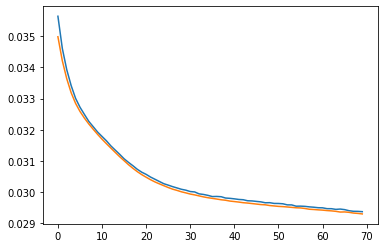

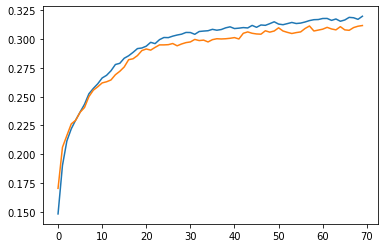

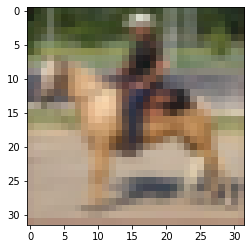

actual_label: 7 predicted_label: 7 actual_class: plane predicted_class: plane


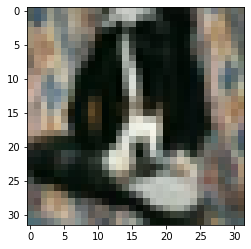

actual_label: 5 predicted_label: 9 actual_class: dog predicted_class: bird


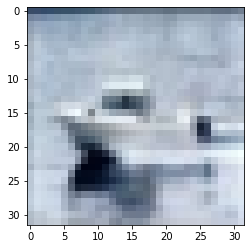

actual_label: 8 predicted_label: 5 actual_class: horse predicted_class: dog


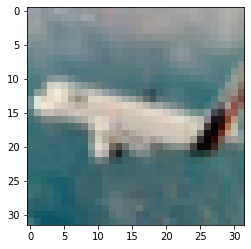

actual_label: 0 predicted_label: 6 actual_class: cat predicted_class: bird


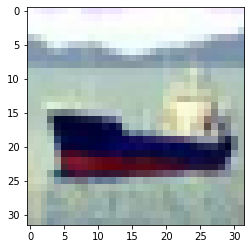

actual_label: 8 predicted_label: 9 actual_class: horse predicted_class: bird


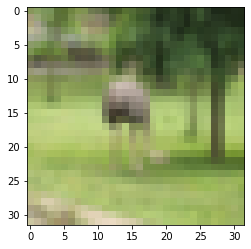

actual_label: 2 predicted_label: 2 actual_class: ship predicted_class: ship


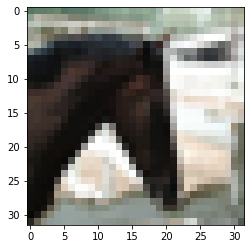

actual_label: 7 predicted_label: 5 actual_class: plane predicted_class: dog


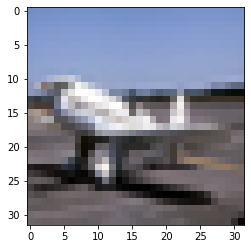

actual_label: 0 predicted_label: 9 actual_class: cat predicted_class: bird


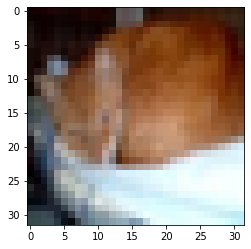

actual_label: 3 predicted_label: 4 actual_class: car predicted_class: ship


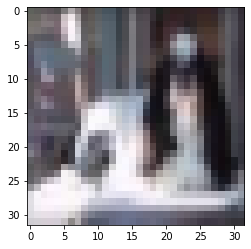

actual_label: 5 predicted_label: 1 actual_class: dog predicted_class: horse

 test loss: 0.02921404993268335 test acc: 0.3213574840764331 correct: 3229 incorrect: 6771


In [ ]:
batch_size=64
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

torch.manual_seed(42)
validation_size = 5000
train_size = len(trainset)-validation_size
train_set, validation_set = random_split(trainset, [train_size, validation_size])


train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True,num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=64,shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False)

print("trainset:",len(train_set))
print("validationset:",len(validation_set))
print("testset:",len(test_set))

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


dataiter = iter(train_dataloader)
images, labels = dataiter.next()


def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(labels)


class ConvolutionNetwork1(nn.Module):

  def __init__(self):
    super(ConvolutionNetwork1,self).__init__()
    
    self.flatten_shape = 16*2*2

    self.conv = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=8, kernel_size=1,stride=2),
          nn.MaxPool2d(kernel_size=1,stride=2),
          nn.BatchNorm2d(8),
          nn.ReLU(True),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1,stride=2),
          nn.MaxPool2d(kernel_size=1,stride=2),
          nn.BatchNorm2d(16),
          nn.ReLU(True)
    )

    self.fc = nn.Sequential( 
        nn.Linear(in_features=self.flatten_shape, out_features=128),
        nn.Linear(in_features=128, out_features=10)
    )

  def forward(self,x):
    x = self.conv(x)
    flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
    # print("ff:",x.shape,flat_features.shape)
    x=self.fc(flat_features)
    return x

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        correct = 0
        incorrect = 0
        for imgs,lbls in dataloader:
            imgs = imgs
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls).item()
            correct += torch.sum(test_pred == lbls).item()
            incorrect += torch.sum(test_pred != lbls).item()

        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))
        
        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img.unsqueeze(0))
              pred_lbl = out
              imshow(img.cpu().detach())
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp,"actual_class:",classes[actual_lbl_disp],"predicted_class:",classes[pred_lbl_disp])
                        
            return test_loss,test_acc,correct,incorrect
    
    return test_loss,test_acc,correct,incorrect


from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 70
learning_rate = 0.0001

model = ConvolutionNetwork1().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  train_correct = 0
  train_incorrect = 0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      train_correct += torch.sum(torch.argmax(out, dim=1) == lbls).item()
      train_incorrect += torch.sum(torch.argmax(out, dim=1) != lbls).item()
      running_acc += acc.item()

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  val_loss,val_acc,correct,incorrect = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size),"train_correct:",train_correct,"train_incorrect:",train_incorrect," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"correct:",correct,"incorrect:",incorrect,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()

model.eval()
test_loss,test_acc,test_correct,test_incorrect = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc,"correct:",test_correct,"incorrect:",test_incorrect)




# (b)
**avgpool - (2,2)**

**stride - 1**

Files already downloaded and verified
Files already downloaded and verified
trainset: 45000
validationset: 5000
testset: 10000


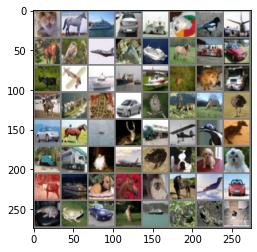

tensor([3, 7, 8, 1, 8, 5, 2, 0, 7, 2, 0, 2, 8, 7, 9, 1, 4, 0, 8, 8, 0, 4, 5, 9,
        7, 8, 6, 1, 2, 4, 5, 2, 1, 7, 8, 4, 9, 0, 2, 2, 9, 9, 3, 0, 6, 5, 5, 5,
        4, 8, 5, 7, 5, 7, 0, 1, 3, 6, 1, 4, 8, 6, 6, 3])
cuda


100%|██████████| 704/704 [00:17<00:00, 39.29it/s, batch_loss=1.787065029144287]



epoch: 0  Train Loss: 0.030171721329679713  Train Accuracy: 0.3233309659090909 train_correct: 14568 train_incorrect: 30432  Validation Loss: 0.027397981998098047  Validation Accuracy: 0.3686708860759494 correct: 1864 incorrect: 3136 



100%|██████████| 704/704 [00:18<00:00, 38.78it/s, batch_loss=1.351074457168579]



epoch: 1  Train Loss: 0.02596308733601208  Train Accuracy: 0.4096457741477273 train_correct: 18457 train_incorrect: 26543  Validation Loss: 0.025133622055755384  Validation Accuracy: 0.42029272151898733 correct: 2125 incorrect: 2875 



100%|██████████| 704/704 [00:18<00:00, 38.46it/s, batch_loss=1.2564520835876465]



epoch: 2  Train Loss: 0.02411426291324791  Train Accuracy: 0.4509499289772727 train_correct: 20318 train_incorrect: 24682  Validation Loss: 0.02378376585113097  Validation Accuracy: 0.45510284810126583 correct: 2301 incorrect: 2699 



100%|██████████| 704/704 [00:18<00:00, 38.68it/s, batch_loss=1.211472749710083]



epoch: 3  Train Loss: 0.023044639341109854  Train Accuracy: 0.47358842329545453 train_correct: 21338 train_incorrect: 23662  Validation Loss: 0.02300740410632725  Validation Accuracy: 0.4697389240506329 correct: 2375 incorrect: 2625 



100%|██████████| 704/704 [00:18<00:00, 38.57it/s, batch_loss=1.677154779434204]



epoch: 4  Train Loss: 0.02230129076369022  Train Accuracy: 0.4893465909090909 train_correct: 22048 train_incorrect: 22952  Validation Loss: 0.02245218615648867  Validation Accuracy: 0.48358386075949367 correct: 2445 incorrect: 2555 



100%|██████████| 704/704 [00:18<00:00, 38.34it/s, batch_loss=1.1020232439041138]



epoch: 5  Train Loss: 0.02174026111871089  Train Accuracy: 0.5037952769886364 train_correct: 22699 train_incorrect: 22301  Validation Loss: 0.022072078778019436  Validation Accuracy: 0.48872626582278483 correct: 2471 incorrect: 2529 



100%|██████████| 704/704 [00:18<00:00, 38.83it/s, batch_loss=1.796707272529602]



epoch: 6  Train Loss: 0.021356839238168588  Train Accuracy: 0.5120960582386364 train_correct: 23073 train_incorrect: 21927  Validation Loss: 0.02174496506871302  Validation Accuracy: 0.49386867088607594 correct: 2497 incorrect: 2503 



100%|██████████| 704/704 [00:17<00:00, 39.11it/s, batch_loss=0.716277003288269]



epoch: 7  Train Loss: 0.020990750286728144  Train Accuracy: 0.5229048295454546 train_correct: 23560 train_incorrect: 21440  Validation Loss: 0.021388686203126665  Validation Accuracy: 0.5037579113924051 correct: 2547 incorrect: 2453 



100%|██████████| 704/704 [00:18<00:00, 38.56it/s, batch_loss=1.6576604843139648]



epoch: 8  Train Loss: 0.020702210905834694  Train Accuracy: 0.5292524857954546 train_correct: 23846 train_incorrect: 21154  Validation Loss: 0.02122677702315246  Validation Accuracy: 0.508504746835443 correct: 2571 incorrect: 2429 



100%|██████████| 704/704 [00:18<00:00, 38.76it/s, batch_loss=1.5990334749221802]



epoch: 9  Train Loss: 0.020402262128878978  Train Accuracy: 0.5380637428977273 train_correct: 24243 train_incorrect: 20757  Validation Loss: 0.021112038860026792  Validation Accuracy: 0.5130537974683544 correct: 2594 incorrect: 2406 



100%|██████████| 704/704 [00:18<00:00, 38.73it/s, batch_loss=1.644346833229065]



epoch: 10  Train Loss: 0.020130892675793308  Train Accuracy: 0.5438343394886364 train_correct: 24503 train_incorrect: 20497  Validation Loss: 0.020805511364265332  Validation Accuracy: 0.5158227848101266 correct: 2608 incorrect: 2392 



100%|██████████| 704/704 [00:18<00:00, 38.66it/s, batch_loss=0.8070820569992065]



epoch: 11  Train Loss: 0.01983313404013064  Train Accuracy: 0.5490500710227273 train_correct: 24738 train_incorrect: 20262  Validation Loss: 0.020727936343490322  Validation Accuracy: 0.5223496835443038 correct: 2641 incorrect: 2359 



100%|██████████| 704/704 [00:18<00:00, 38.66it/s, batch_loss=1.1056084632873535]



epoch: 12  Train Loss: 0.019596240193508987  Train Accuracy: 0.5570845170454546 train_correct: 25100 train_incorrect: 19900  Validation Loss: 0.020304320981325227  Validation Accuracy: 0.5278876582278481 correct: 2669 incorrect: 2331 



100%|██████████| 704/704 [00:18<00:00, 39.10it/s, batch_loss=0.7222541570663452]



epoch: 13  Train Loss: 0.019382674429586834  Train Accuracy: 0.5615234375 train_correct: 25300 train_incorrect: 19700  Validation Loss: 0.02011699686887898  Validation Accuracy: 0.533623417721519 correct: 2698 incorrect: 2302 



100%|██████████| 704/704 [00:18<00:00, 38.41it/s, batch_loss=1.4100229740142822]



epoch: 14  Train Loss: 0.019158506355862217  Train Accuracy: 0.5675825639204546 train_correct: 25573 train_incorrect: 19427  Validation Loss: 0.02005637507838539  Validation Accuracy: 0.5363924050632911 correct: 2712 incorrect: 2288 



100%|██████████| 704/704 [00:18<00:00, 38.64it/s, batch_loss=1.1703840494155884]



epoch: 15  Train Loss: 0.018923025030579247  Train Accuracy: 0.5739524147727273 train_correct: 25860 train_incorrect: 19140  Validation Loss: 0.01984873510708537  Validation Accuracy: 0.537381329113924 correct: 2717 incorrect: 2283 



100%|██████████| 704/704 [00:18<00:00, 38.53it/s, batch_loss=0.7931283712387085]



epoch: 16  Train Loss: 0.018647634180855344  Train Accuracy: 0.5810546875 train_correct: 26180 train_incorrect: 18820  Validation Loss: 0.019648237613654588  Validation Accuracy: 0.5435126582278481 correct: 2748 incorrect: 2252 



100%|██████████| 704/704 [00:18<00:00, 38.90it/s, batch_loss=1.5517175197601318]



epoch: 17  Train Loss: 0.018481192186961627  Train Accuracy: 0.585205078125 train_correct: 26367 train_incorrect: 18633  Validation Loss: 0.01954981479558009  Validation Accuracy: 0.5448971518987342 correct: 2755 incorrect: 2245 



100%|██████████| 704/704 [00:18<00:00, 38.75it/s, batch_loss=1.122544527053833]



epoch: 18  Train Loss: 0.018279279904990373  Train Accuracy: 0.5888227982954546 train_correct: 26530 train_incorrect: 18470  Validation Loss: 0.019435119320037244  Validation Accuracy: 0.5462816455696202 correct: 2762 incorrect: 2238 



100%|██████████| 704/704 [00:18<00:00, 38.66it/s, batch_loss=1.6292988061904907]



epoch: 19  Train Loss: 0.01807675255721816  Train Accuracy: 0.5940829190340909 train_correct: 26767 train_incorrect: 18233  Validation Loss: 0.019109225501836854  Validation Accuracy: 0.5611155063291139 correct: 2837 incorrect: 2163 



100%|██████████| 704/704 [00:18<00:00, 38.60it/s, batch_loss=1.1012331247329712]



epoch: 20  Train Loss: 0.01786776317352302  Train Accuracy: 0.5984996448863636 train_correct: 26966 train_incorrect: 18034  Validation Loss: 0.01918917797694478  Validation Accuracy: 0.5551819620253164 correct: 2807 incorrect: 2193 



100%|██████████| 704/704 [00:18<00:00, 38.57it/s, batch_loss=2.294761896133423]



epoch: 21  Train Loss: 0.01771356810588093  Train Accuracy: 0.605712890625 train_correct: 27291 train_incorrect: 17709  Validation Loss: 0.01894633480218015  Validation Accuracy: 0.5623022151898734 correct: 2843 incorrect: 2157 



100%|██████████| 704/704 [00:18<00:00, 38.37it/s, batch_loss=0.9641990065574646]



epoch: 22  Train Loss: 0.017525850382464177  Train Accuracy: 0.6077325994318182 train_correct: 27382 train_incorrect: 17618  Validation Loss: 0.018736164462811584  Validation Accuracy: 0.5712025316455697 correct: 2888 incorrect: 2112 



100%|██████████| 704/704 [00:18<00:00, 38.24it/s, batch_loss=0.9337782859802246]



epoch: 23  Train Loss: 0.017323697578500618  Train Accuracy: 0.6131480823863636 train_correct: 27626 train_incorrect: 17374  Validation Loss: 0.01884829936714112  Validation Accuracy: 0.5708069620253164 correct: 2886 incorrect: 2114 



100%|██████████| 704/704 [00:18<00:00, 38.50it/s, batch_loss=0.8587841391563416]



epoch: 24  Train Loss: 0.017171351723267104  Train Accuracy: 0.6156560724431818 train_correct: 27739 train_incorrect: 17261  Validation Loss: 0.018659258673934243  Validation Accuracy: 0.5773338607594937 correct: 2919 incorrect: 2081 



100%|██████████| 704/704 [00:18<00:00, 38.57it/s, batch_loss=0.524832010269165]



epoch: 25  Train Loss: 0.016991077837618915  Train Accuracy: 0.6200506036931818 train_correct: 27937 train_incorrect: 17063  Validation Loss: 0.018621860991550398  Validation Accuracy: 0.5714003164556962 correct: 2889 incorrect: 2111 



100%|██████████| 704/704 [00:18<00:00, 38.40it/s, batch_loss=1.288000464439392]



epoch: 26  Train Loss: 0.016888258858340454  Train Accuracy: 0.6234019886363636 train_correct: 28088 train_incorrect: 16912  Validation Loss: 0.018418223101975797  Validation Accuracy: 0.5816851265822784 correct: 2941 incorrect: 2059 



100%|██████████| 704/704 [00:18<00:00, 38.25it/s, batch_loss=1.4713351726531982]



epoch: 27  Train Loss: 0.01674407500964166  Train Accuracy: 0.6273970170454546 train_correct: 28268 train_incorrect: 16732  Validation Loss: 0.018373102138314067  Validation Accuracy: 0.5862341772151899 correct: 2964 incorrect: 2036 



100%|██████████| 704/704 [00:18<00:00, 38.58it/s, batch_loss=1.6396493911743164]



epoch: 28  Train Loss: 0.01657792675674004  Train Accuracy: 0.6311257102272727 train_correct: 28436 train_incorrect: 16564  Validation Loss: 0.018257987933068334  Validation Accuracy: 0.5830696202531646 correct: 2948 incorrect: 2052 



100%|██████████| 704/704 [00:18<00:00, 38.53it/s, batch_loss=1.1069183349609375]



epoch: 29  Train Loss: 0.016439589666498996  Train Accuracy: 0.6348544034090909 train_correct: 28604 train_incorrect: 16396  Validation Loss: 0.018239149635162533  Validation Accuracy: 0.5848496835443038 correct: 2957 incorrect: 2043 



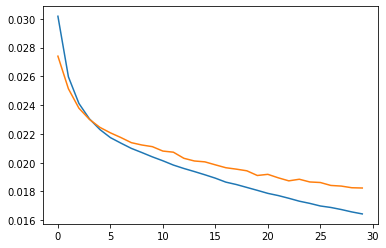

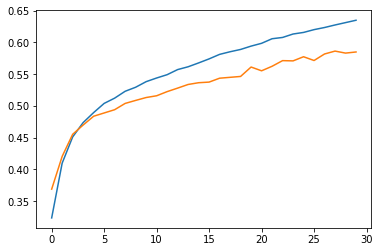

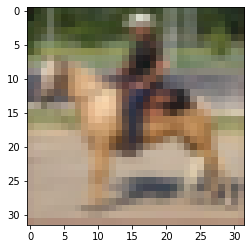

actual_label: 7 predicted_label: 7 actual_class: plane predicted_class: plane


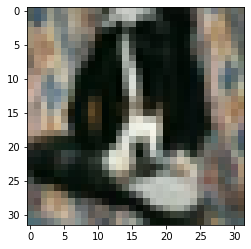

actual_label: 5 predicted_label: 3 actual_class: dog predicted_class: car


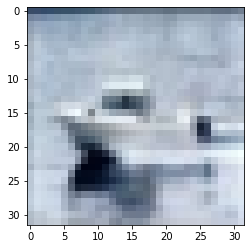

actual_label: 8 predicted_label: 4 actual_class: horse predicted_class: ship


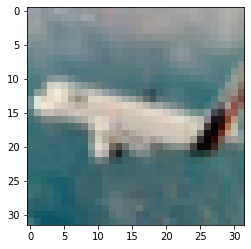

actual_label: 0 predicted_label: 4 actual_class: cat predicted_class: ship


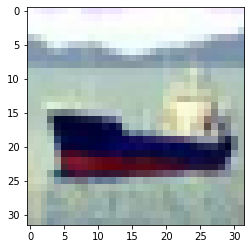

actual_label: 8 predicted_label: 0 actual_class: horse predicted_class: cat


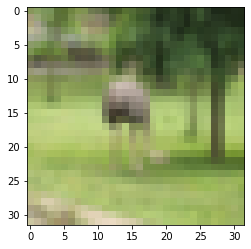

actual_label: 2 predicted_label: 7 actual_class: ship predicted_class: plane


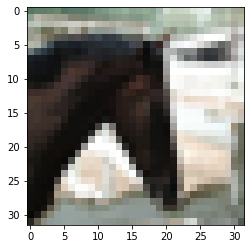

actual_label: 7 predicted_label: 7 actual_class: plane predicted_class: plane


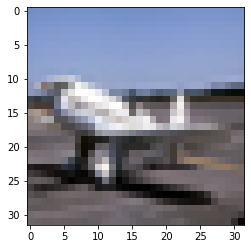

actual_label: 0 predicted_label: 0 actual_class: cat predicted_class: cat


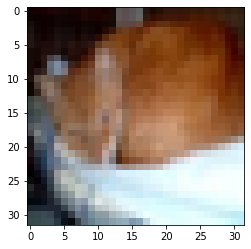

actual_label: 3 predicted_label: 3 actual_class: car predicted_class: car


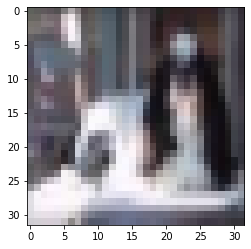

actual_label: 5 predicted_label: 3 actual_class: dog predicted_class: car

 test loss: 0.017985027912221136 test acc: 0.5930533439490446 correct: 5959 incorrect: 4041


In [ ]:
batch_size=64
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

torch.manual_seed(42)
validation_size = 5000
train_size = len(trainset)-validation_size
train_set, validation_set = random_split(trainset, [train_size, validation_size])


train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True,num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=64,shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False)

print("trainset:",len(train_set))
print("validationset:",len(validation_set))
print("testset:",len(test_set))

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

dataiter = iter(train_dataloader)
images, labels = dataiter.next()


def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(labels)

class ConvolutionNetwork1(nn.Module):

  def __init__(self):
    super(ConvolutionNetwork1,self).__init__()
    
    self.flatten_shape =  16*22*22

    self.conv = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5,stride=1),
          nn.AvgPool2d(kernel_size=(2,2),stride=1),
          nn.BatchNorm2d(8),
          nn.ReLU(True),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5,stride=1),
          nn.AvgPool2d(kernel_size=(2,2),stride=1),
          nn.BatchNorm2d(16),
          nn.ReLU(True)
    )

    self.fc = nn.Sequential( 
        nn.Linear(in_features=self.flatten_shape, out_features=128),
        nn.Linear(in_features=128, out_features=10)
    )

  def forward(self,x):
    x = self.conv(x)
    flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
    # print("ff:",x.shape,flat_features.shape)
    x=self.fc(flat_features)
    return x


device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        correct = 0
        incorrect = 0
        for imgs,lbls in dataloader:
            imgs = imgs
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls).item()
            correct += torch.sum(test_pred == lbls).item()
            incorrect += torch.sum(test_pred != lbls).item()

        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))
        
        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img.unsqueeze(0))
              pred_lbl = out
              imshow(img.cpu().detach())
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp,"actual_class:",classes[actual_lbl_disp],"predicted_class:",classes[pred_lbl_disp])
                        
            return test_loss,test_acc,correct,incorrect
    
    return test_loss,test_acc,correct,incorrect


from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 30
learning_rate = 0.0001

model = ConvolutionNetwork1().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  train_correct = 0
  train_incorrect = 0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      train_correct += torch.sum(torch.argmax(out, dim=1) == lbls).item()
      train_incorrect += torch.sum(torch.argmax(out, dim=1) != lbls).item()
      running_acc += acc.item()

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  val_loss,val_acc,correct,incorrect = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size),"train_correct:",train_correct,"train_incorrect:",train_incorrect," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"correct:",correct,"incorrect:",incorrect,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()

model.eval()
test_loss,test_acc,test_correct,test_incorrect = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc,"correct:",test_correct,"incorrect:",test_incorrect)




#**Question 3** 

**3. Conv-BatchNormalization-ReLU-Conv-BatchNormalization-ReLU-FC**



# (c)
**not used - maxpool**

**stride - 1**

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import torchvision.datasets as datasets
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
from torch.utils.data import random_split

Files already downloaded and verified
Files already downloaded and verified
trainset: 45000
validationset: 5000
testset: 10000


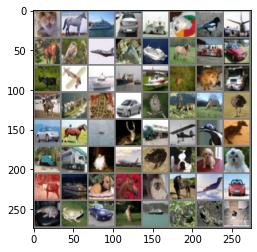

tensor([3, 7, 8, 1, 8, 5, 2, 0, 7, 2, 0, 2, 8, 7, 9, 1, 4, 0, 8, 8, 0, 4, 5, 9,
        7, 8, 6, 1, 2, 4, 5, 2, 1, 7, 8, 4, 9, 0, 2, 2, 9, 9, 3, 0, 6, 5, 5, 5,
        4, 8, 5, 7, 5, 7, 0, 1, 3, 6, 1, 4, 8, 6, 6, 3])
cpu


100%|██████████| 704/704 [00:40<00:00, 17.44it/s, batch_loss=1.647872805595398]



epoch: 0  Train Loss: 0.03039982339197939  Train Accuracy: 0.3132546164772727 train_correct: 14114 train_incorrect: 30886  Validation Loss: 0.02765988947564288  Validation Accuracy: 0.3744066455696203 correct: 1893 incorrect: 3107 



100%|██████████| 704/704 [00:39<00:00, 17.68it/s, batch_loss=1.4926538467407227]



epoch: 1  Train Loss: 0.026201535767706282  Train Accuracy: 0.4097345525568182 train_correct: 18461 train_incorrect: 26539  Validation Loss: 0.02536117250123356  Validation Accuracy: 0.4206882911392405 correct: 2127 incorrect: 2873 



100%|██████████| 704/704 [00:40<00:00, 17.55it/s, batch_loss=1.394392490386963]



epoch: 2  Train Loss: 0.024296424703524364  Train Accuracy: 0.4500399502840909 train_correct: 20277 train_incorrect: 24723  Validation Loss: 0.02391893749089935  Validation Accuracy: 0.44877373417721517 correct: 2269 incorrect: 2731 



100%|██████████| 704/704 [00:39<00:00, 17.65it/s, batch_loss=1.9170479774475098]



epoch: 3  Train Loss: 0.022957914291923356  Train Accuracy: 0.4794699928977273 train_correct: 21603 train_incorrect: 23397  Validation Loss: 0.022911510795732087  Validation Accuracy: 0.4693433544303797 correct: 2373 incorrect: 2627 



100%|██████████| 704/704 [00:39<00:00, 17.61it/s, batch_loss=1.8059303760528564]



epoch: 4  Train Loss: 0.02207697154054503  Train Accuracy: 0.4994229403409091 train_correct: 22502 train_incorrect: 22498  Validation Loss: 0.02219526540440849  Validation Accuracy: 0.4833860759493671 correct: 2444 incorrect: 2556 



100%|██████████| 704/704 [00:40<00:00, 17.37it/s, batch_loss=2.343480110168457]



epoch: 5  Train Loss: 0.021443193483388644  Train Accuracy: 0.5141379616477273 train_correct: 23165 train_incorrect: 21835  Validation Loss: 0.021679614540896838  Validation Accuracy: 0.4964398734177215 correct: 2510 incorrect: 2490 



100%|██████████| 704/704 [00:39<00:00, 17.61it/s, batch_loss=0.8639678955078125]



epoch: 6  Train Loss: 0.020877977417760783  Train Accuracy: 0.5276988636363636 train_correct: 23776 train_incorrect: 21224  Validation Loss: 0.02147224884998949  Validation Accuracy: 0.497626582278481 correct: 2516 incorrect: 2484 



100%|██████████| 704/704 [00:40<00:00, 17.52it/s, batch_loss=1.41879141330719]



epoch: 7  Train Loss: 0.020445078700008293  Train Accuracy: 0.5395729758522727 train_correct: 24311 train_incorrect: 20689  Validation Loss: 0.021038025829799568  Validation Accuracy: 0.5160205696202531 correct: 2609 incorrect: 2391 



100%|██████████| 704/704 [00:40<00:00, 17.47it/s, batch_loss=1.6186494827270508]



epoch: 8  Train Loss: 0.020032184705169955  Train Accuracy: 0.5479403409090909 train_correct: 24688 train_incorrect: 20312  Validation Loss: 0.020875659193607825  Validation Accuracy: 0.5191851265822784 correct: 2625 incorrect: 2375 



100%|██████████| 704/704 [00:39<00:00, 17.65it/s, batch_loss=1.9890849590301514]



epoch: 9  Train Loss: 0.019662276578442703  Train Accuracy: 0.5570845170454546 train_correct: 25100 train_incorrect: 19900  Validation Loss: 0.020530250583645663  Validation Accuracy: 0.5270965189873418 correct: 2665 incorrect: 2335 



100%|██████████| 704/704 [00:39<00:00, 17.66it/s, batch_loss=1.381546974182129]



epoch: 10  Train Loss: 0.019296443048832854  Train Accuracy: 0.5667169744318182 train_correct: 25534 train_incorrect: 19466  Validation Loss: 0.02004498415449752  Validation Accuracy: 0.5395569620253164 correct: 2728 incorrect: 2272 



100%|██████████| 704/704 [00:39<00:00, 17.62it/s, batch_loss=1.2272281646728516]



epoch: 11  Train Loss: 0.018922092435373503  Train Accuracy: 0.57568359375 train_correct: 25938 train_incorrect: 19062  Validation Loss: 0.019766412628225132  Validation Accuracy: 0.5441060126582279 correct: 2751 incorrect: 2249 



100%|██████████| 704/704 [00:40<00:00, 17.56it/s, batch_loss=1.2247134447097778]



epoch: 12  Train Loss: 0.01861358398375821  Train Accuracy: 0.5823863636363636 train_correct: 26240 train_incorrect: 18760  Validation Loss: 0.019545356259693072  Validation Accuracy: 0.5502373417721519 correct: 2782 incorrect: 2218 



100%|██████████| 704/704 [00:39<00:00, 17.67it/s, batch_loss=0.8984504342079163]



epoch: 13  Train Loss: 0.018239547822635028  Train Accuracy: 0.5892666903409091 train_correct: 26550 train_incorrect: 18450  Validation Loss: 0.019270827533983733  Validation Accuracy: 0.5589398734177216 correct: 2826 incorrect: 2174 



100%|██████████| 704/704 [00:40<00:00, 17.51it/s, batch_loss=1.216145396232605]



epoch: 14  Train Loss: 0.017948791928409428  Train Accuracy: 0.5993874289772727 train_correct: 27006 train_incorrect: 17994  Validation Loss: 0.019106651951051965  Validation Accuracy: 0.5654667721518988 correct: 2859 incorrect: 2141 



100%|██████████| 704/704 [00:39<00:00, 17.62it/s, batch_loss=0.982001543045044]



epoch: 15  Train Loss: 0.017636369341000154  Train Accuracy: 0.6060014204545454 train_correct: 27304 train_incorrect: 17696  Validation Loss: 0.01890452209671464  Validation Accuracy: 0.5666534810126582 correct: 2865 incorrect: 2135 



100%|██████████| 704/704 [00:40<00:00, 17.44it/s, batch_loss=1.067457914352417]



epoch: 16  Train Loss: 0.017353031363613394  Train Accuracy: 0.6114169034090909 train_correct: 27548 train_incorrect: 17452  Validation Loss: 0.01860645414577632  Validation Accuracy: 0.5727848101265823 correct: 2896 incorrect: 2104 



100%|██████████| 704/704 [00:40<00:00, 17.44it/s, batch_loss=1.6267967224121094]



epoch: 17  Train Loss: 0.01711123666212767  Train Accuracy: 0.6171653053977273 train_correct: 27807 train_incorrect: 17193  Validation Loss: 0.018624286285212524  Validation Accuracy: 0.5723892405063291 correct: 2894 incorrect: 2106 



100%|██████████| 704/704 [00:40<00:00, 17.25it/s, batch_loss=1.1477348804473877]



epoch: 18  Train Loss: 0.01683221707803155  Train Accuracy: 0.6236905184659091 train_correct: 28101 train_incorrect: 16899  Validation Loss: 0.01848418740673533  Validation Accuracy: 0.5767405063291139 correct: 2916 incorrect: 2084 



100%|██████████| 704/704 [00:40<00:00, 17.28it/s, batch_loss=0.8115582466125488]



epoch: 19  Train Loss: 0.016610978357758457  Train Accuracy: 0.6309259588068182 train_correct: 28427 train_incorrect: 16573  Validation Loss: 0.018155389748325076  Validation Accuracy: 0.5830696202531646 correct: 2948 incorrect: 2052 



100%|██████████| 704/704 [00:41<00:00, 17.06it/s, batch_loss=1.0412935018539429]



epoch: 20  Train Loss: 0.016353825394286436  Train Accuracy: 0.6354758522727273 train_correct: 28632 train_incorrect: 16368  Validation Loss: 0.018297993554438972  Validation Accuracy: 0.5816851265822784 correct: 2941 incorrect: 2059 



100%|██████████| 704/704 [00:40<00:00, 17.42it/s, batch_loss=1.0496662855148315]



epoch: 21  Train Loss: 0.016081377121736296  Train Accuracy: 0.6421786221590909 train_correct: 28934 train_incorrect: 16066  Validation Loss: 0.01785946296693026  Validation Accuracy: 0.5868275316455697 correct: 2967 incorrect: 2033 



100%|██████████| 704/704 [00:40<00:00, 17.43it/s, batch_loss=0.970017671585083]



epoch: 22  Train Loss: 0.015886318938679655  Train Accuracy: 0.6468616832386364 train_correct: 29145 train_incorrect: 15855  Validation Loss: 0.017798101022556613  Validation Accuracy: 0.5909810126582279 correct: 2988 incorrect: 2012 



100%|██████████| 704/704 [00:40<00:00, 17.56it/s, batch_loss=0.7230439782142639]



epoch: 23  Train Loss: 0.015682178537562406  Train Accuracy: 0.6536532315340909 train_correct: 29451 train_incorrect: 15549  Validation Loss: 0.017718223630910433  Validation Accuracy: 0.5903876582278481 correct: 2985 incorrect: 2015 



100%|██████████| 704/704 [00:40<00:00, 17.52it/s, batch_loss=1.427347183227539]



epoch: 24  Train Loss: 0.01549028965448749  Train Accuracy: 0.6578702059659091 train_correct: 29641 train_incorrect: 15359  Validation Loss: 0.017513674789968924  Validation Accuracy: 0.599881329113924 correct: 3033 incorrect: 1967 



100%|██████████| 704/704 [00:40<00:00, 17.42it/s, batch_loss=1.181174874305725]



epoch: 25  Train Loss: 0.015281286271849902  Train Accuracy: 0.6622869318181818 train_correct: 29840 train_incorrect: 15160  Validation Loss: 0.017560164420570755  Validation Accuracy: 0.5986946202531646 correct: 3027 incorrect: 1973 



100%|██████████| 704/704 [00:40<00:00, 17.54it/s, batch_loss=1.6791698932647705]



epoch: 26  Train Loss: 0.015120396160372447  Train Accuracy: 0.6663041548295454 train_correct: 30021 train_incorrect: 14979  Validation Loss: 0.017419266479113436  Validation Accuracy: 0.6020569620253164 correct: 3044 incorrect: 1956 



100%|██████████| 704/704 [00:40<00:00, 17.45it/s, batch_loss=1.541285753250122]



epoch: 27  Train Loss: 0.014931386298320087  Train Accuracy: 0.6692116477272727 train_correct: 30152 train_incorrect: 14848  Validation Loss: 0.017347519851843768  Validation Accuracy: 0.6014636075949367 correct: 3041 incorrect: 1959 



100%|██████████| 704/704 [00:41<00:00, 16.94it/s, batch_loss=1.3013899326324463]



epoch: 28  Train Loss: 0.014723032923277722  Train Accuracy: 0.6764470880681818 train_correct: 30478 train_incorrect: 14522  Validation Loss: 0.017385423890774764  Validation Accuracy: 0.6052215189873418 correct: 3060 incorrect: 1940 



100%|██████████| 704/704 [00:40<00:00, 17.54it/s, batch_loss=0.9092451333999634]



epoch: 29  Train Loss: 0.01454558574583974  Train Accuracy: 0.6784889914772727 train_correct: 30570 train_incorrect: 14430  Validation Loss: 0.01725055806668876  Validation Accuracy: 0.6062104430379747 correct: 3065 incorrect: 1935 



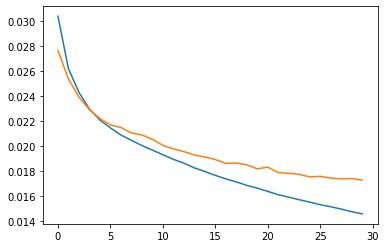

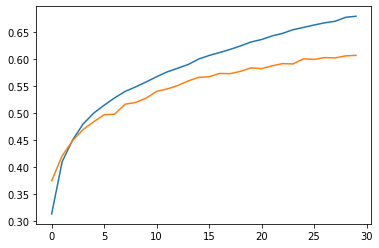

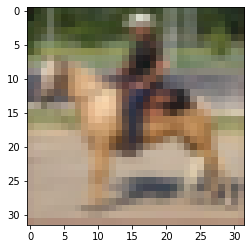

actual_label: 7 predicted_label: 7 actual_class: plane predicted_class: plane


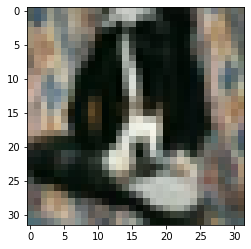

actual_label: 5 predicted_label: 3 actual_class: dog predicted_class: car


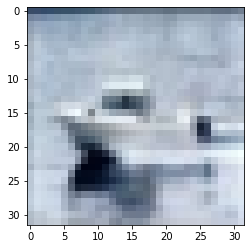

actual_label: 8 predicted_label: 8 actual_class: horse predicted_class: horse


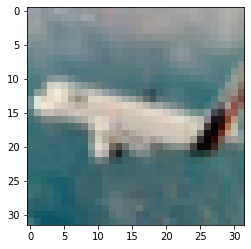

actual_label: 0 predicted_label: 0 actual_class: cat predicted_class: cat


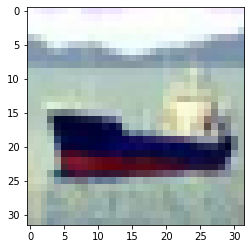

actual_label: 8 predicted_label: 8 actual_class: horse predicted_class: horse


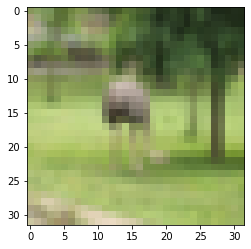

actual_label: 2 predicted_label: 7 actual_class: ship predicted_class: plane


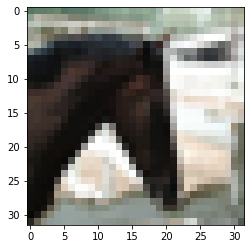

actual_label: 7 predicted_label: 7 actual_class: plane predicted_class: plane


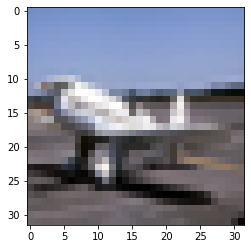

actual_label: 0 predicted_label: 0 actual_class: cat predicted_class: cat


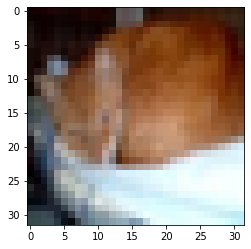

actual_label: 3 predicted_label: 3 actual_class: car predicted_class: car


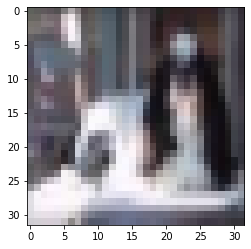

actual_label: 5 predicted_label: 3 actual_class: dog predicted_class: car

 test loss: 0.01710501077709494 test acc: 0.6143511146496815 correct: 6173 incorrect: 3827


In [ ]:
batch_size=64
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

torch.manual_seed(42)
validation_size = 5000
train_size = len(trainset)-validation_size
train_set, validation_set = random_split(trainset, [train_size, validation_size])


train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True,num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=64,shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False)

print("trainset:",len(train_set))
print("validationset:",len(validation_set))
print("testset:",len(test_set))

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


dataiter = iter(train_dataloader)
images, labels = dataiter.next()


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(labels)

class ConvolutionNetwork1(nn.Module):

  def __init__(self):
    super(ConvolutionNetwork1,self).__init__()
    
    self.flatten_shape =  16*24*24

    self.conv = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5,stride=1),
          nn.BatchNorm2d(8),
          nn.ReLU(True),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5,stride=1),
          nn.BatchNorm2d(16),
          nn.ReLU(True)
    )

    self.fc = nn.Sequential( 
        nn.Linear(in_features=self.flatten_shape, out_features=128),
        nn.Linear(in_features=128, out_features=10)
    )

  def forward(self,x):
    x = self.conv(x)
    flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
    # print("ff:",x.shape,flat_features.shape)
    x=self.fc(flat_features)
    return x

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        correct = 0
        incorrect = 0
        for imgs,lbls in dataloader:
            imgs = imgs
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls).item()
            correct += torch.sum(test_pred == lbls).item()
            incorrect += torch.sum(test_pred != lbls).item()

        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))
        
        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img.unsqueeze(0))
              pred_lbl = out
              imshow(img.cpu().detach())
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp,"actual_class:",classes[actual_lbl_disp],"predicted_class:",classes[pred_lbl_disp])
                        
            return test_loss,test_acc,correct,incorrect
    
    return test_loss,test_acc,correct,incorrect


from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 30
learning_rate = 0.0001
batch_size=64

model = ConvolutionNetwork1().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  train_correct = 0
  train_incorrect = 0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      train_correct += torch.sum(torch.argmax(out, dim=1) == lbls).item()
      train_incorrect += torch.sum(torch.argmax(out, dim=1) != lbls).item()
      running_acc += acc.item()

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  val_loss,val_acc,correct,incorrect = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size),"train_correct:",train_correct,"train_incorrect:",train_incorrect," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"correct:",correct,"incorrect:",incorrect,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()

model.eval()
test_loss,test_acc,test_correct,test_incorrect = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc,"correct:",test_correct,"incorrect:",test_incorrect)




# (c)
**not used - maxpool**

**stride - 2**

Files already downloaded and verified
Files already downloaded and verified
trainset: 45000
validationset: 5000
testset: 10000


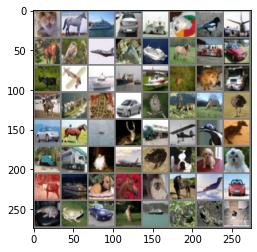

tensor([3, 7, 8, 1, 8, 5, 2, 0, 7, 2, 0, 2, 8, 7, 9, 1, 4, 0, 8, 8, 0, 4, 5, 9,
        7, 8, 6, 1, 2, 4, 5, 2, 1, 7, 8, 4, 9, 0, 2, 2, 9, 9, 3, 0, 6, 5, 5, 5,
        4, 8, 5, 7, 5, 7, 0, 1, 3, 6, 1, 4, 8, 6, 6, 3])
cpu


100%|██████████| 704/704 [00:17<00:00, 40.68it/s, batch_loss=2.2786448001861572]



epoch: 0  Train Loss: 0.03483469290552999  Train Accuracy: 0.17571466619318182 train_correct: 7917 train_incorrect: 37083  Validation Loss: 0.03363031827950779  Validation Accuracy: 0.22844145569620253 correct: 1155 incorrect: 3845 



100%|██████████| 704/704 [00:17<00:00, 41.01it/s, batch_loss=2.3485727310180664]



epoch: 1  Train Loss: 0.032445493336788124  Train Accuracy: 0.2732599431818182 train_correct: 12312 train_incorrect: 32688  Validation Loss: 0.031516843793701524  Validation Accuracy: 0.28322784810126583 correct: 1432 incorrect: 3568 



100%|██████████| 704/704 [00:16<00:00, 42.17it/s, batch_loss=2.0968081951141357]



epoch: 2  Train Loss: 0.03073869898269715  Train Accuracy: 0.31578480113636365 train_correct: 14228 train_incorrect: 30772  Validation Loss: 0.030138628109346463  Validation Accuracy: 0.3130933544303797 correct: 1583 incorrect: 3417 



100%|██████████| 704/704 [00:16<00:00, 42.72it/s, batch_loss=2.0776925086975098]



epoch: 3  Train Loss: 0.029585739139954305  Train Accuracy: 0.3339177911931818 train_correct: 15045 train_incorrect: 29955  Validation Loss: 0.02914729040068916  Validation Accuracy: 0.33089398734177217 correct: 1673 incorrect: 3327 



100%|██████████| 704/704 [00:16<00:00, 42.26it/s, batch_loss=1.7842808961868286]



epoch: 4  Train Loss: 0.028713744099315427  Train Accuracy: 0.3492986505681818 train_correct: 15738 train_incorrect: 29262  Validation Loss: 0.028391650630326212  Validation Accuracy: 0.34572784810126583 correct: 1748 incorrect: 3252 



100%|██████████| 704/704 [00:16<00:00, 42.02it/s, batch_loss=1.9630883932113647]



epoch: 5  Train Loss: 0.027997424034930937  Train Accuracy: 0.362060546875 train_correct: 16313 train_incorrect: 28687  Validation Loss: 0.027762907309622706  Validation Accuracy: 0.35858386075949367 correct: 1813 incorrect: 3187 



100%|██████████| 704/704 [00:16<00:00, 41.66it/s, batch_loss=2.0776472091674805]



epoch: 6  Train Loss: 0.02739990075034174  Train Accuracy: 0.3760653409090909 train_correct: 16944 train_incorrect: 28056  Validation Loss: 0.02721396659182597  Validation Accuracy: 0.3680775316455696 correct: 1861 incorrect: 3139 



100%|██████████| 704/704 [00:16<00:00, 42.33it/s, batch_loss=2.0894577503204346]



epoch: 7  Train Loss: 0.026884537314551628  Train Accuracy: 0.3858309659090909 train_correct: 17384 train_incorrect: 27616  Validation Loss: 0.026764595928260044  Validation Accuracy: 0.3779667721518987 correct: 1911 incorrect: 3089 



100%|██████████| 704/704 [00:16<00:00, 42.24it/s, batch_loss=1.411129355430603]



epoch: 8  Train Loss: 0.026396263822045348  Train Accuracy: 0.39659534801136365 train_correct: 17869 train_incorrect: 27131  Validation Loss: 0.026372428134649614  Validation Accuracy: 0.38568037974683544 correct: 1950 incorrect: 3050 



100%|██████████| 704/704 [00:16<00:00, 42.25it/s, batch_loss=1.449310064315796]



epoch: 9  Train Loss: 0.025998300285374917  Train Accuracy: 0.40400834517045453 train_correct: 18203 train_incorrect: 26797  Validation Loss: 0.025968891014403934  Validation Accuracy: 0.3981408227848101 correct: 2013 incorrect: 2987 



100%|██████████| 704/704 [00:16<00:00, 41.90it/s, batch_loss=1.3056204319000244]



epoch: 10  Train Loss: 0.025628110076385466  Train Accuracy: 0.41157670454545453 train_correct: 18544 train_incorrect: 26456  Validation Loss: 0.025644938213915766  Validation Accuracy: 0.4032832278481013 correct: 2039 incorrect: 2961 



100%|██████████| 704/704 [00:16<00:00, 41.74it/s, batch_loss=2.018348217010498]



epoch: 11  Train Loss: 0.025306643616535108  Train Accuracy: 0.4192116477272727 train_correct: 18888 train_incorrect: 26112  Validation Loss: 0.02534424492358407  Validation Accuracy: 0.4096123417721519 correct: 2071 incorrect: 2929 



100%|██████████| 704/704 [00:16<00:00, 41.48it/s, batch_loss=1.8223533630371094]



epoch: 12  Train Loss: 0.0249752429028211  Train Accuracy: 0.42582563920454547 train_correct: 19186 train_incorrect: 25814  Validation Loss: 0.025058551844728143  Validation Accuracy: 0.4165348101265823 correct: 2106 incorrect: 2894 



100%|██████████| 704/704 [00:16<00:00, 42.30it/s, batch_loss=1.7768754959106445]



epoch: 13  Train Loss: 0.024715670127823778  Train Accuracy: 0.43339399857954547 train_correct: 19527 train_incorrect: 25473  Validation Loss: 0.024780951628956615  Validation Accuracy: 0.42503955696202533 correct: 2149 incorrect: 2851 



100%|██████████| 704/704 [00:16<00:00, 42.05it/s, batch_loss=1.3015104532241821]



epoch: 14  Train Loss: 0.024421396326612343  Train Accuracy: 0.43787730823863635 train_correct: 19729 train_incorrect: 25271  Validation Loss: 0.024565507693192625  Validation Accuracy: 0.42325949367088606 correct: 2140 incorrect: 2860 



100%|██████████| 704/704 [00:16<00:00, 41.75it/s, batch_loss=1.7357158660888672]



epoch: 15  Train Loss: 0.024189466777236455  Train Accuracy: 0.4444025213068182 train_correct: 20023 train_incorrect: 24977  Validation Loss: 0.024291657430084445  Validation Accuracy: 0.4357199367088608 correct: 2203 incorrect: 2797 



100%|██████████| 704/704 [00:16<00:00, 41.55it/s, batch_loss=1.08778715133667]



epoch: 16  Train Loss: 0.023960759680697018  Train Accuracy: 0.45008433948863635 train_correct: 20279 train_incorrect: 24721  Validation Loss: 0.024077505698498293  Validation Accuracy: 0.44125791139240506 correct: 2231 incorrect: 2769 



100%|██████████| 704/704 [00:16<00:00, 41.84it/s, batch_loss=1.1331958770751953]



epoch: 17  Train Loss: 0.02371485165680166  Train Accuracy: 0.45503373579545453 train_correct: 20502 train_incorrect: 24498  Validation Loss: 0.023883908798422993  Validation Accuracy: 0.4442246835443038 correct: 2246 incorrect: 2754 



100%|██████████| 704/704 [00:16<00:00, 42.15it/s, batch_loss=1.521320104598999]



epoch: 18  Train Loss: 0.023526068215935746  Train Accuracy: 0.458251953125 train_correct: 20647 train_incorrect: 24353  Validation Loss: 0.023732719754305066  Validation Accuracy: 0.4485759493670886 correct: 2268 incorrect: 2732 



100%|██████████| 704/704 [00:16<00:00, 42.29it/s, batch_loss=1.788188099861145]



epoch: 19  Train Loss: 0.02331712567088702  Train Accuracy: 0.4636008522727273 train_correct: 20888 train_incorrect: 24112  Validation Loss: 0.02353871778785428  Validation Accuracy: 0.45154272151898733 correct: 2283 incorrect: 2717 



100%|██████████| 704/704 [00:16<00:00, 42.30it/s, batch_loss=1.444310188293457]



epoch: 20  Train Loss: 0.023113716592144392  Train Accuracy: 0.46781782670454547 train_correct: 21078 train_incorrect: 23922  Validation Loss: 0.023460049300065525  Validation Accuracy: 0.45747626582278483 correct: 2313 incorrect: 2687 



100%|██████████| 704/704 [00:16<00:00, 41.72it/s, batch_loss=1.2572906017303467]



epoch: 21  Train Loss: 0.02290906984919936  Train Accuracy: 0.47401012073863635 train_correct: 21357 train_incorrect: 23643  Validation Loss: 0.023182842550398427  Validation Accuracy: 0.4606408227848101 correct: 2329 incorrect: 2671 



100%|██████████| 704/704 [00:16<00:00, 42.09it/s, batch_loss=2.119932174682617]



epoch: 22  Train Loss: 0.02275042663942176  Train Accuracy: 0.4777166193181818 train_correct: 21524 train_incorrect: 23476  Validation Loss: 0.023175205469508714  Validation Accuracy: 0.4634098101265823 correct: 2343 incorrect: 2657 



100%|██████████| 704/704 [00:17<00:00, 41.04it/s, batch_loss=1.3186745643615723]



epoch: 23  Train Loss: 0.022581788536626846  Train Accuracy: 0.4800692471590909 train_correct: 21630 train_incorrect: 23370  Validation Loss: 0.022853641381746607  Validation Accuracy: 0.46894778481012656 correct: 2371 incorrect: 2629 



100%|██████████| 704/704 [00:16<00:00, 41.55it/s, batch_loss=1.462728500366211]



epoch: 24  Train Loss: 0.022416773090795192  Train Accuracy: 0.4839754971590909 train_correct: 21806 train_incorrect: 23194  Validation Loss: 0.022796792461525037  Validation Accuracy: 0.4693433544303797 correct: 2373 incorrect: 2627 



100%|██████████| 704/704 [00:16<00:00, 41.49it/s, batch_loss=1.9499562978744507]



epoch: 25  Train Loss: 0.022266247669573535  Train Accuracy: 0.4884366122159091 train_correct: 22007 train_incorrect: 22993  Validation Loss: 0.022607854673568205  Validation Accuracy: 0.47587025316455694 correct: 2406 incorrect: 2594 



100%|██████████| 704/704 [00:16<00:00, 41.82it/s, batch_loss=1.3228604793548584]



epoch: 26  Train Loss: 0.02211534530083141  Train Accuracy: 0.4893465909090909 train_correct: 22048 train_incorrect: 22952  Validation Loss: 0.022501525504490996  Validation Accuracy: 0.4693433544303797 correct: 2373 incorrect: 2627 



100%|██████████| 704/704 [00:16<00:00, 42.24it/s, batch_loss=1.0538835525512695]



epoch: 27  Train Loss: 0.021977139549562708  Train Accuracy: 0.49573863636363635 train_correct: 22336 train_incorrect: 22664  Validation Loss: 0.022485107419234287  Validation Accuracy: 0.4768591772151899 correct: 2411 incorrect: 2589 



100%|██████████| 704/704 [00:16<00:00, 41.72it/s, batch_loss=1.3697987794876099]



epoch: 28  Train Loss: 0.021839789212787186  Train Accuracy: 0.49809126420454547 train_correct: 22442 train_incorrect: 22558  Validation Loss: 0.0222663312584539  Validation Accuracy: 0.4810126582278481 correct: 2432 incorrect: 2568 



100%|██████████| 704/704 [00:16<00:00, 41.58it/s, batch_loss=1.7840056419372559]



epoch: 29  Train Loss: 0.02173824032863856  Train Accuracy: 0.5003551136363636 train_correct: 22544 train_incorrect: 22456  Validation Loss: 0.022175390768466117  Validation Accuracy: 0.4802215189873418 correct: 2428 incorrect: 2572 



100%|██████████| 704/704 [00:16<00:00, 42.06it/s, batch_loss=1.187913417816162]



epoch: 30  Train Loss: 0.02161556491575373  Train Accuracy: 0.5034623579545454 train_correct: 22684 train_incorrect: 22316  Validation Loss: 0.022095542259608643  Validation Accuracy: 0.4865506329113924 correct: 2460 incorrect: 2540 



100%|██████████| 704/704 [00:16<00:00, 42.06it/s, batch_loss=1.3177741765975952]



epoch: 31  Train Loss: 0.0214808551245369  Train Accuracy: 0.5091441761363636 train_correct: 22940 train_incorrect: 22060  Validation Loss: 0.0219948404244607  Validation Accuracy: 0.4873417721518987 correct: 2464 incorrect: 2536 



100%|██████████| 704/704 [00:17<00:00, 41.32it/s, batch_loss=0.977962851524353]



epoch: 32  Train Loss: 0.021377284852364523  Train Accuracy: 0.5090997869318182 train_correct: 22938 train_incorrect: 22062  Validation Loss: 0.021975469787286806  Validation Accuracy: 0.48457278481012656 correct: 2450 incorrect: 2550 



100%|██████████| 704/704 [00:16<00:00, 41.66it/s, batch_loss=1.5552310943603516]



epoch: 33  Train Loss: 0.021261551422701978  Train Accuracy: 0.5124067826704546 train_correct: 23087 train_incorrect: 21913  Validation Loss: 0.02184325560361524  Validation Accuracy: 0.4877373417721519 correct: 2466 incorrect: 2534 



100%|██████████| 704/704 [00:16<00:00, 41.98it/s, batch_loss=1.3383961915969849]



epoch: 34  Train Loss: 0.021208007616223767  Train Accuracy: 0.5126731178977273 train_correct: 23099 train_incorrect: 21901  Validation Loss: 0.02188988619401485  Validation Accuracy: 0.4936708860759494 correct: 2496 incorrect: 2504 



100%|██████████| 704/704 [00:16<00:00, 42.05it/s, batch_loss=1.308082103729248]



epoch: 35  Train Loss: 0.021103599041287616  Train Accuracy: 0.5154696377840909 train_correct: 23225 train_incorrect: 21775  Validation Loss: 0.021682980741503873  Validation Accuracy: 0.4907041139240506 correct: 2481 incorrect: 2519 



100%|██████████| 704/704 [00:16<00:00, 41.72it/s, batch_loss=1.136934518814087]



epoch: 36  Train Loss: 0.021010551387338306  Train Accuracy: 0.5187544389204546 train_correct: 23373 train_incorrect: 21627  Validation Loss: 0.02168211281959769  Validation Accuracy: 0.49149525316455694 correct: 2485 incorrect: 2515 



100%|██████████| 704/704 [00:16<00:00, 41.43it/s, batch_loss=2.0455992221832275]



epoch: 37  Train Loss: 0.02092685177260798  Train Accuracy: 0.5195534446022727 train_correct: 23409 train_incorrect: 21591  Validation Loss: 0.021513178378720826  Validation Accuracy: 0.4954509493670886 correct: 2505 incorrect: 2495 



100%|██████████| 704/704 [00:17<00:00, 41.34it/s, batch_loss=1.7782883644104004]



epoch: 38  Train Loss: 0.02082941025781276  Train Accuracy: 0.52392578125 train_correct: 23606 train_incorrect: 21394  Validation Loss: 0.021498289477976062  Validation Accuracy: 0.4922863924050633 correct: 2489 incorrect: 2511 



100%|██████████| 704/704 [00:16<00:00, 41.47it/s, batch_loss=1.628730058670044]



epoch: 39  Train Loss: 0.0207509147902866  Train Accuracy: 0.5276988636363636 train_correct: 23776 train_incorrect: 21224  Validation Loss: 0.021448396499964256  Validation Accuracy: 0.49604430379746833 correct: 2508 incorrect: 2492 



100%|██████████| 704/704 [00:16<00:00, 41.92it/s, batch_loss=1.1602281332015991]



epoch: 40  Train Loss: 0.020615284468724647  Train Accuracy: 0.529052734375 train_correct: 23837 train_incorrect: 21163  Validation Loss: 0.02133499217938773  Validation Accuracy: 0.4990110759493671 correct: 2523 incorrect: 2477 



100%|██████████| 704/704 [00:16<00:00, 41.64it/s, batch_loss=1.7851295471191406]



epoch: 41  Train Loss: 0.02056138692106205  Train Accuracy: 0.5287420099431818 train_correct: 23823 train_incorrect: 21177  Validation Loss: 0.021294339548183393  Validation Accuracy: 0.5009889240506329 correct: 2533 incorrect: 2467 



100%|██████████| 704/704 [00:16<00:00, 41.90it/s, batch_loss=1.4032950401306152]



epoch: 42  Train Loss: 0.02044227756877345  Train Accuracy: 0.5311834161931818 train_correct: 23933 train_incorrect: 21067  Validation Loss: 0.021213667561547665  Validation Accuracy: 0.5025712025316456 correct: 2541 incorrect: 2459 



100%|██████████| 704/704 [00:17<00:00, 41.27it/s, batch_loss=0.7563373446464539]



epoch: 43  Train Loss: 0.020329268628054044  Train Accuracy: 0.5350008877840909 train_correct: 24105 train_incorrect: 20895  Validation Loss: 0.021110464146808734  Validation Accuracy: 0.5055379746835443 correct: 2556 incorrect: 2444 



100%|██████████| 704/704 [00:17<00:00, 41.23it/s, batch_loss=1.8034169673919678]



epoch: 44  Train Loss: 0.020284169824497603  Train Accuracy: 0.5372425426136364 train_correct: 24206 train_incorrect: 20794  Validation Loss: 0.021037448787047892  Validation Accuracy: 0.5075158227848101 correct: 2566 incorrect: 2434 



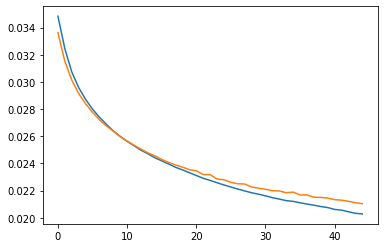

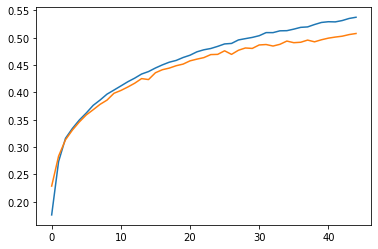

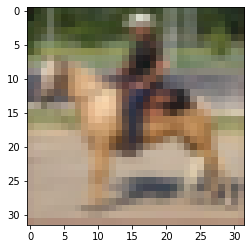

actual_label: 7 predicted_label: 2 actual_class: plane predicted_class: ship


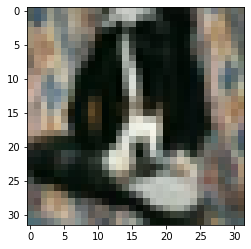

actual_label: 5 predicted_label: 3 actual_class: dog predicted_class: car


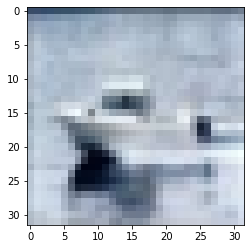

actual_label: 8 predicted_label: 8 actual_class: horse predicted_class: horse


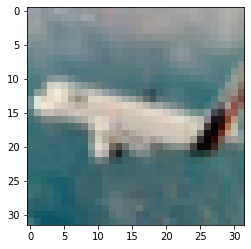

actual_label: 0 predicted_label: 4 actual_class: cat predicted_class: ship


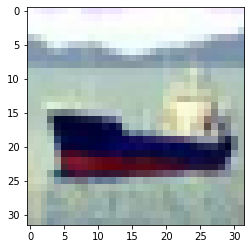

actual_label: 8 predicted_label: 9 actual_class: horse predicted_class: bird


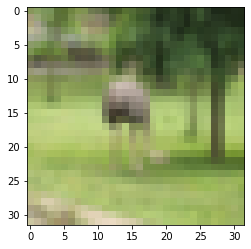

actual_label: 2 predicted_label: 7 actual_class: ship predicted_class: plane


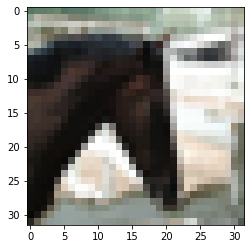

actual_label: 7 predicted_label: 7 actual_class: plane predicted_class: plane


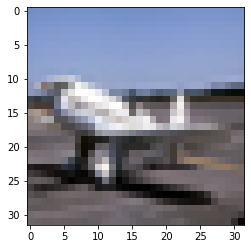

actual_label: 0 predicted_label: 9 actual_class: cat predicted_class: bird


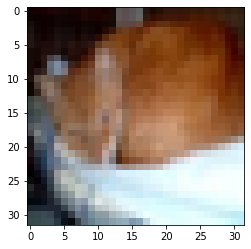

actual_label: 3 predicted_label: 3 actual_class: car predicted_class: car


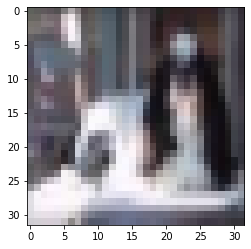

actual_label: 5 predicted_label: 4 actual_class: dog predicted_class: ship

 test loss: 0.02067171887844611 test acc: 0.524781050955414 correct: 5273 incorrect: 4727


In [ ]:
batch_size=64
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

torch.manual_seed(42)
validation_size = 5000
train_size = len(trainset)-validation_size
train_set, validation_set = random_split(trainset, [train_size, validation_size])


train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True,num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=64,shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False)

print("trainset:",len(train_set))
print("validationset:",len(validation_set))
print("testset:",len(test_set))

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

dataiter = iter(train_dataloader)
images, labels = dataiter.next()


def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(labels)

class ConvolutionNetwork1(nn.Module):

  def __init__(self):
    super(ConvolutionNetwork1,self).__init__()
    
    self.flatten_shape =  16*5*5

    self.conv = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5,stride=2),
          nn.BatchNorm2d(8),
          nn.ReLU(True),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5,stride=2),
          nn.BatchNorm2d(16),
          nn.ReLU(True)
    )

    self.fc = nn.Sequential( 
        nn.Linear(in_features=self.flatten_shape, out_features=128),
        nn.Linear(in_features=128, out_features=10)
    )

  def forward(self,x):
    x = self.conv(x)
    flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
    # print("ff:",x.shape,flat_features.shape)
    x=self.fc(flat_features)
    return x

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        correct = 0
        incorrect = 0
        for imgs,lbls in dataloader:
            imgs = imgs
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls).item()
            correct += torch.sum(test_pred == lbls).item()
            incorrect += torch.sum(test_pred != lbls).item()

        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))
        
        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img.unsqueeze(0))
              pred_lbl = out
              imshow(img.cpu().detach())
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp,"actual_class:",classes[actual_lbl_disp],"predicted_class:",classes[pred_lbl_disp])

                        
            return test_loss,test_acc,correct,incorrect
    
    return test_loss,test_acc,correct,incorrect


from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 45
learning_rate = 0.0001
batch_size=64

model = ConvolutionNetwork1().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  train_correct = 0
  train_incorrect = 0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      train_correct += torch.sum(torch.argmax(out, dim=1) == lbls).item()
      train_incorrect += torch.sum(torch.argmax(out, dim=1) != lbls).item()
      running_acc += acc.item()

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  val_loss,val_acc,correct,incorrect = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size),"train_correct:",train_correct,"train_incorrect:",train_incorrect," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"correct:",correct,"incorrect:",incorrect,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()

model.eval()
test_loss,test_acc,test_correct,test_incorrect = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc,"correct:",test_correct,"incorrect:",test_incorrect)




# Question 3

**adding one more extra FC Layer**



**(a)**

**maxpool = (2,2)**

**stride = 1**

**Conv-Conv-Pool-Conv-Conv-Pool-FC-FC-FC**

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import torchvision.datasets as datasets
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
from torch.utils.data import random_split

Files already downloaded and verified
Files already downloaded and verified
trainset: 45000
validationset: 5000
testset: 10000


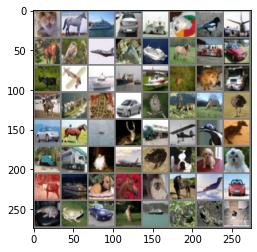

tensor([3, 7, 8, 1, 8, 5, 2, 0, 7, 2, 0, 2, 8, 7, 9, 1, 4, 0, 8, 8, 0, 4, 5, 9,
        7, 8, 6, 1, 2, 4, 5, 2, 1, 7, 8, 4, 9, 0, 2, 2, 9, 9, 3, 0, 6, 5, 5, 5,
        4, 8, 5, 7, 5, 7, 0, 1, 3, 6, 1, 4, 8, 6, 6, 3])
cuda


100%|██████████| 704/704 [00:22<00:00, 31.84it/s, batch_loss=2.3216116428375244]



epoch: 0  Train Loss: 0.03593237992820584  Train Accuracy: 0.106201171875 train_correct: 4785 train_incorrect: 40215  Validation Loss: 0.03578542342668847  Validation Accuracy: 0.12559335443037975 correct: 635 incorrect: 4365 



100%|██████████| 704/704 [00:21<00:00, 32.31it/s, batch_loss=2.088900089263916]



epoch: 1  Train Loss: 0.03506604449781166  Train Accuracy: 0.16807972301136365 train_correct: 7573 train_incorrect: 37427  Validation Loss: 0.03406795755594592  Validation Accuracy: 0.20806962025316456 correct: 1052 incorrect: 3948 



100%|██████████| 704/704 [00:21<00:00, 32.53it/s, batch_loss=2.066516160964966]



epoch: 2  Train Loss: 0.033216664490861476  Train Accuracy: 0.2276278409090909 train_correct: 10256 train_incorrect: 34744  Validation Loss: 0.03278811242950114  Validation Accuracy: 0.23457278481012658 correct: 1186 incorrect: 3814 



100%|██████████| 704/704 [00:21<00:00, 32.18it/s, batch_loss=2.2563095092773438]



epoch: 3  Train Loss: 0.032330098572525785  Train Accuracy: 0.25672496448863635 train_correct: 11567 train_incorrect: 33433  Validation Loss: 0.03212765359048602  Validation Accuracy: 0.26068037974683544 correct: 1318 incorrect: 3682 



100%|██████████| 704/704 [00:21<00:00, 32.72it/s, batch_loss=1.9268467426300049]



epoch: 4  Train Loss: 0.03181523142583584  Train Accuracy: 0.2744806463068182 train_correct: 12367 train_incorrect: 32633  Validation Loss: 0.03172688636504396  Validation Accuracy: 0.270371835443038 correct: 1367 incorrect: 3633 



100%|██████████| 704/704 [00:21<00:00, 32.87it/s, batch_loss=1.6918174028396606]



epoch: 5  Train Loss: 0.03134382153670727  Train Accuracy: 0.2883522727272727 train_correct: 12992 train_incorrect: 32008  Validation Loss: 0.031166931802902042  Validation Accuracy: 0.29074367088607594 correct: 1470 incorrect: 3530 



100%|██████████| 704/704 [00:21<00:00, 32.85it/s, batch_loss=2.2171406745910645]



epoch: 6  Train Loss: 0.030814369923477483  Train Accuracy: 0.30357776988636365 train_correct: 13678 train_incorrect: 31322  Validation Loss: 0.030652634516546998  Validation Accuracy: 0.3055775316455696 correct: 1545 incorrect: 3455 



100%|██████████| 704/704 [00:21<00:00, 33.02it/s, batch_loss=1.9126018285751343]



epoch: 7  Train Loss: 0.030304208569842474  Train Accuracy: 0.3172052556818182 train_correct: 14292 train_incorrect: 30708  Validation Loss: 0.030146364193362526  Validation Accuracy: 0.3160601265822785 correct: 1598 incorrect: 3402 



100%|██████████| 704/704 [00:21<00:00, 32.10it/s, batch_loss=1.2294212579727173]



epoch: 8  Train Loss: 0.02967184792346829  Train Accuracy: 0.33362926136363635 train_correct: 15032 train_incorrect: 29968  Validation Loss: 0.02939756872438932  Validation Accuracy: 0.3326740506329114 correct: 1682 incorrect: 3318 



100%|██████████| 704/704 [00:21<00:00, 32.68it/s, batch_loss=1.9843722581863403]



epoch: 9  Train Loss: 0.02895423554053361  Train Accuracy: 0.3514071377840909 train_correct: 15833 train_incorrect: 29167  Validation Loss: 0.02865907707829264  Validation Accuracy: 0.35106803797468356 correct: 1775 incorrect: 3225 



100%|██████████| 704/704 [00:21<00:00, 32.64it/s, batch_loss=1.9292892217636108]



epoch: 10  Train Loss: 0.02832552716559307  Train Accuracy: 0.36279296875 train_correct: 16346 train_incorrect: 28654  Validation Loss: 0.028090028045109555  Validation Accuracy: 0.35957278481012656 correct: 1818 incorrect: 3182 



100%|██████████| 704/704 [00:21<00:00, 32.57it/s, batch_loss=2.0978527069091797]



epoch: 11  Train Loss: 0.027810386300023474  Train Accuracy: 0.37397904829545453 train_correct: 16850 train_incorrect: 28150  Validation Loss: 0.02769326649700539  Validation Accuracy: 0.36985759493670883 correct: 1870 incorrect: 3130 



100%|██████████| 704/704 [00:21<00:00, 32.63it/s, batch_loss=1.4272574186325073]



epoch: 12  Train Loss: 0.027357141627527944  Train Accuracy: 0.3829678622159091 train_correct: 17255 train_incorrect: 27745  Validation Loss: 0.02723741210714171  Validation Accuracy: 0.38212025316455694 correct: 1932 incorrect: 3068 



100%|██████████| 704/704 [00:21<00:00, 32.65it/s, batch_loss=1.5871517658233643]



epoch: 13  Train Loss: 0.026942516150566833  Train Accuracy: 0.3887384588068182 train_correct: 17515 train_incorrect: 27485  Validation Loss: 0.027063410658436485  Validation Accuracy: 0.3837025316455696 correct: 1940 incorrect: 3060 



100%|██████████| 704/704 [00:21<00:00, 32.99it/s, batch_loss=1.7944130897521973]



epoch: 14  Train Loss: 0.026587953955062072  Train Accuracy: 0.3977272727272727 train_correct: 17920 train_incorrect: 27080  Validation Loss: 0.02676000226807745  Validation Accuracy: 0.39319620253164556 correct: 1988 incorrect: 3012 



100%|██████████| 704/704 [00:21<00:00, 33.13it/s, batch_loss=1.763753890991211]



epoch: 15  Train Loss: 0.026296880162342197  Train Accuracy: 0.40294300426136365 train_correct: 18155 train_incorrect: 26845  Validation Loss: 0.026354793176243577  Validation Accuracy: 0.40011867088607594 correct: 2023 incorrect: 2977 



100%|██████████| 704/704 [00:21<00:00, 33.13it/s, batch_loss=1.7856742143630981]



epoch: 16  Train Loss: 0.02606567946283824  Train Accuracy: 0.4078924005681818 train_correct: 18378 train_incorrect: 26622  Validation Loss: 0.02619128471499757  Validation Accuracy: 0.4017009493670886 correct: 2031 incorrect: 2969 



100%|██████████| 704/704 [00:21<00:00, 33.28it/s, batch_loss=1.5531444549560547]



epoch: 17  Train Loss: 0.02582354330066168  Train Accuracy: 0.41357421875 train_correct: 18634 train_incorrect: 26366  Validation Loss: 0.0260149679040607  Validation Accuracy: 0.408623417721519 correct: 2066 incorrect: 2934 



100%|██████████| 704/704 [00:21<00:00, 33.24it/s, batch_loss=1.4086319208145142]



epoch: 18  Train Loss: 0.025593593219210477  Train Accuracy: 0.415771484375 train_correct: 18733 train_incorrect: 26267  Validation Loss: 0.025863401638933376  Validation Accuracy: 0.41119462025316456 correct: 2079 incorrect: 2921 



100%|██████████| 704/704 [00:21<00:00, 32.81it/s, batch_loss=1.6411024332046509]



epoch: 19  Train Loss: 0.025355247486996548  Train Accuracy: 0.4219637784090909 train_correct: 19012 train_incorrect: 25988  Validation Loss: 0.025598804195281825  Validation Accuracy: 0.41238132911392406 correct: 2085 incorrect: 2915 



100%|██████████| 704/704 [00:21<00:00, 33.39it/s, batch_loss=1.1289737224578857]



epoch: 20  Train Loss: 0.02511332132483155  Train Accuracy: 0.4266912286931818 train_correct: 19225 train_incorrect: 25775  Validation Loss: 0.02537030596993392  Validation Accuracy: 0.42444620253164556 correct: 2146 incorrect: 2854 



100%|██████████| 704/704 [00:21<00:00, 32.96it/s, batch_loss=1.7612709999084473]



epoch: 21  Train Loss: 0.024907845503714107  Train Accuracy: 0.4314186789772727 train_correct: 19438 train_incorrect: 25562  Validation Loss: 0.025128189073521878  Validation Accuracy: 0.42167721518987344 correct: 2132 incorrect: 2868 



100%|██████████| 704/704 [00:21<00:00, 33.03it/s, batch_loss=1.8194352388381958]



epoch: 22  Train Loss: 0.02470760834297504  Train Accuracy: 0.4359463778409091 train_correct: 19642 train_incorrect: 25358  Validation Loss: 0.024971827463824536  Validation Accuracy: 0.4252373417721519 correct: 2150 incorrect: 2850 



100%|██████████| 704/704 [00:21<00:00, 32.91it/s, batch_loss=1.13071870803833]



epoch: 23  Train Loss: 0.024527298463825984  Train Accuracy: 0.4411843039772727 train_correct: 19878 train_incorrect: 25122  Validation Loss: 0.024714651788714567  Validation Accuracy: 0.432753164556962 correct: 2188 incorrect: 2812 



100%|██████████| 704/704 [00:21<00:00, 32.95it/s, batch_loss=1.364688515663147]



epoch: 24  Train Loss: 0.024353149048031562  Train Accuracy: 0.44371448863636365 train_correct: 19992 train_incorrect: 25008  Validation Loss: 0.024632551601227327  Validation Accuracy: 0.43591772151898733 correct: 2204 incorrect: 2796 



100%|██████████| 704/704 [00:21<00:00, 33.15it/s, batch_loss=1.046126365661621]



epoch: 25  Train Loss: 0.024164477408207444  Train Accuracy: 0.4477761008522727 train_correct: 20175 train_incorrect: 24825  Validation Loss: 0.024877811958895452  Validation Accuracy: 0.4321598101265823 correct: 2185 incorrect: 2815 



100%|██████████| 704/704 [00:21<00:00, 32.92it/s, batch_loss=1.69010329246521]



epoch: 26  Train Loss: 0.0240034836249172  Train Accuracy: 0.45177112926136365 train_correct: 20355 train_incorrect: 24645  Validation Loss: 0.02426616050585916  Validation Accuracy: 0.4428401898734177 correct: 2239 incorrect: 2761 



100%|██████████| 704/704 [00:21<00:00, 33.30it/s, batch_loss=1.49319326877594]



epoch: 27  Train Loss: 0.02384352949659594  Train Accuracy: 0.4562766335227273 train_correct: 20558 train_incorrect: 24442  Validation Loss: 0.02421588276194621  Validation Accuracy: 0.4375 correct: 2212 incorrect: 2788 



100%|██████████| 704/704 [00:21<00:00, 33.23it/s, batch_loss=1.0918775796890259]



epoch: 28  Train Loss: 0.023663363173413512  Train Accuracy: 0.4599609375 train_correct: 20724 train_incorrect: 24276  Validation Loss: 0.024182544714665112  Validation Accuracy: 0.44066455696202533 correct: 2228 incorrect: 2772 



100%|██████████| 704/704 [00:21<00:00, 32.26it/s, batch_loss=1.65054452419281]



epoch: 29  Train Loss: 0.023532979436409238  Train Accuracy: 0.4631569602272727 train_correct: 20868 train_incorrect: 24132  Validation Loss: 0.02399264207652098  Validation Accuracy: 0.4464003164556962 correct: 2257 incorrect: 2743 



100%|██████████| 704/704 [00:21<00:00, 32.01it/s, batch_loss=1.4376381635665894]



epoch: 30  Train Loss: 0.023374266874849458  Train Accuracy: 0.4668856534090909 train_correct: 21036 train_incorrect: 23964  Validation Loss: 0.023757117694314524  Validation Accuracy: 0.45174050632911394 correct: 2284 incorrect: 2716 



100%|██████████| 704/704 [00:21<00:00, 32.18it/s, batch_loss=1.4829387664794922]



epoch: 31  Train Loss: 0.023194825170900334  Train Accuracy: 0.4733220880681818 train_correct: 21326 train_incorrect: 23674  Validation Loss: 0.023652737229307996  Validation Accuracy: 0.45510284810126583 correct: 2301 incorrect: 2699 



100%|██████████| 704/704 [00:21<00:00, 32.80it/s, batch_loss=1.4080122709274292]



epoch: 32  Train Loss: 0.023031857224519958  Train Accuracy: 0.47523082386363635 train_correct: 21412 train_incorrect: 23588  Validation Loss: 0.023468750493624544  Validation Accuracy: 0.4576740506329114 correct: 2314 incorrect: 2686 



100%|██████████| 704/704 [00:21<00:00, 32.74it/s, batch_loss=0.8042528033256531]



epoch: 33  Train Loss: 0.02285972916896836  Train Accuracy: 0.4799582741477273 train_correct: 21625 train_incorrect: 23375  Validation Loss: 0.023349307053074052  Validation Accuracy: 0.4610363924050633 correct: 2331 incorrect: 2669 



100%|██████████| 704/704 [00:21<00:00, 33.10it/s, batch_loss=1.3053300380706787]



epoch: 34  Train Loss: 0.022680531335274944  Train Accuracy: 0.4855069247159091 train_correct: 21875 train_incorrect: 23125  Validation Loss: 0.023446330211207837  Validation Accuracy: 0.45391613924050633 correct: 2295 incorrect: 2705 



100%|██████████| 704/704 [00:21<00:00, 32.76it/s, batch_loss=1.3273532390594482]



epoch: 35  Train Loss: 0.022504564448767764  Train Accuracy: 0.48912464488636365 train_correct: 22038 train_incorrect: 22962  Validation Loss: 0.02292328827743289  Validation Accuracy: 0.47151898734177217 correct: 2384 incorrect: 2616 



100%|██████████| 704/704 [00:21<00:00, 32.89it/s, batch_loss=1.7642171382904053]



epoch: 36  Train Loss: 0.022370456622659483  Train Accuracy: 0.49329723011363635 train_correct: 22226 train_incorrect: 22774  Validation Loss: 0.023041651053707812  Validation Accuracy: 0.4693433544303797 correct: 2373 incorrect: 2627 



100%|██████████| 704/704 [00:21<00:00, 32.78it/s, batch_loss=1.6627094745635986]



epoch: 37  Train Loss: 0.022210020855047995  Train Accuracy: 0.4972922585227273 train_correct: 22406 train_incorrect: 22594  Validation Loss: 0.02262244173148765  Validation Accuracy: 0.4776503164556962 correct: 2415 incorrect: 2585 



100%|██████████| 704/704 [00:21<00:00, 32.97it/s, batch_loss=2.9688239097595215]



epoch: 38  Train Loss: 0.022075200056530197  Train Accuracy: 0.5015758167613636 train_correct: 22599 train_incorrect: 22401  Validation Loss: 0.02237649530738215  Validation Accuracy: 0.48417721518987344 correct: 2448 incorrect: 2552 



100%|██████████| 704/704 [00:21<00:00, 32.38it/s, batch_loss=1.994913935661316]



epoch: 39  Train Loss: 0.02186541627319953  Train Accuracy: 0.5071466619318182 train_correct: 22850 train_incorrect: 22150  Validation Loss: 0.02238267084842996  Validation Accuracy: 0.4885284810126582 correct: 2470 incorrect: 2530 



100%|██████████| 704/704 [00:21<00:00, 32.56it/s, batch_loss=2.4685425758361816]



epoch: 40  Train Loss: 0.021686207583777352  Train Accuracy: 0.5127397017045454 train_correct: 23102 train_incorrect: 21898  Validation Loss: 0.022191334044254277  Validation Accuracy: 0.49050632911392406 correct: 2480 incorrect: 2520 



100%|██████████| 704/704 [00:21<00:00, 32.64it/s, batch_loss=1.53166925907135]



epoch: 41  Train Loss: 0.021560324340085077  Train Accuracy: 0.5158025568181818 train_correct: 23240 train_incorrect: 21760  Validation Loss: 0.021836897122520436  Validation Accuracy: 0.5049446202531646 correct: 2553 incorrect: 2447 



100%|██████████| 704/704 [00:21<00:00, 32.70it/s, batch_loss=2.1821563243865967]



epoch: 42  Train Loss: 0.021364610426561823  Train Accuracy: 0.5218394886363636 train_correct: 23512 train_incorrect: 21488  Validation Loss: 0.021884114375408693  Validation Accuracy: 0.4978243670886076 correct: 2517 incorrect: 2483 



100%|██████████| 704/704 [00:21<00:00, 32.85it/s, batch_loss=0.844140350818634]



epoch: 43  Train Loss: 0.021254183959999038  Train Accuracy: 0.5241033380681818 train_correct: 23614 train_incorrect: 21386  Validation Loss: 0.021607036643390413  Validation Accuracy: 0.5114715189873418 correct: 2586 incorrect: 2414 



100%|██████████| 704/704 [00:21<00:00, 32.85it/s, batch_loss=1.1539356708526611]



epoch: 44  Train Loss: 0.021082968915421094  Train Accuracy: 0.5286976207386364 train_correct: 23821 train_incorrect: 21179  Validation Loss: 0.02147780368222466  Validation Accuracy: 0.5164161392405063 correct: 2611 incorrect: 2389 



100%|██████████| 704/704 [00:21<00:00, 32.84it/s, batch_loss=1.45950448513031]



epoch: 45  Train Loss: 0.020947369316920893  Train Accuracy: 0.5330477627840909 train_correct: 24017 train_incorrect: 20983  Validation Loss: 0.02170088828270194  Validation Accuracy: 0.515625 correct: 2607 incorrect: 2393 



100%|██████████| 704/704 [00:21<00:00, 33.03it/s, batch_loss=1.42331862449646]



epoch: 46  Train Loss: 0.020837822300646538  Train Accuracy: 0.5329145951704546 train_correct: 24011 train_incorrect: 20989  Validation Loss: 0.021703912463935115  Validation Accuracy: 0.5100870253164557 correct: 2579 incorrect: 2421 



100%|██████████| 704/704 [00:21<00:00, 33.08it/s, batch_loss=1.548240065574646]



epoch: 47  Train Loss: 0.02071902839419305  Train Accuracy: 0.5364213423295454 train_correct: 24169 train_incorrect: 20831  Validation Loss: 0.021313978830658938  Validation Accuracy: 0.5195806962025317 correct: 2627 incorrect: 2373 



100%|██████████| 704/704 [00:21<00:00, 32.07it/s, batch_loss=1.3757071495056152]



epoch: 48  Train Loss: 0.020579703963118267  Train Accuracy: 0.5418590198863636 train_correct: 24414 train_incorrect: 20586  Validation Loss: 0.02109039442825921  Validation Accuracy: 0.5257120253164557 correct: 2658 incorrect: 2342 



100%|██████████| 704/704 [00:22<00:00, 31.74it/s, batch_loss=1.3292256593704224]



epoch: 49  Train Loss: 0.02044170712443619  Train Accuracy: 0.5419699928977273 train_correct: 24419 train_incorrect: 20581  Validation Loss: 0.021224579620587675  Validation Accuracy: 0.5298655063291139 correct: 2679 incorrect: 2321 



100%|██████████| 704/704 [00:22<00:00, 31.84it/s, batch_loss=0.8669873476028442]



epoch: 50  Train Loss: 0.02028088366866789  Train Accuracy: 0.5471635298295454 train_correct: 24653 train_incorrect: 20347  Validation Loss: 0.020985510789706736  Validation Accuracy: 0.5268987341772152 correct: 2664 incorrect: 2336 



100%|██████████| 704/704 [00:22<00:00, 31.75it/s, batch_loss=1.1957672834396362]



epoch: 51  Train Loss: 0.020149720158025793  Train Accuracy: 0.5513805042613636 train_correct: 24843 train_incorrect: 20157  Validation Loss: 0.02091184633347807  Validation Accuracy: 0.5304588607594937 correct: 2682 incorrect: 2318 



100%|██████████| 704/704 [00:22<00:00, 31.74it/s, batch_loss=0.9554637670516968]



epoch: 52  Train Loss: 0.020025000638931735  Train Accuracy: 0.5545765269886364 train_correct: 24987 train_incorrect: 20013  Validation Loss: 0.020682335689758198  Validation Accuracy: 0.5391613924050633 correct: 2726 incorrect: 2274 



100%|██████████| 704/704 [00:22<00:00, 31.71it/s, batch_loss=1.1905194520950317]



epoch: 53  Train Loss: 0.019886301130596126  Train Accuracy: 0.5564630681818182 train_correct: 25072 train_incorrect: 19928  Validation Loss: 0.020499801522568813  Validation Accuracy: 0.5417325949367089 correct: 2739 incorrect: 2261 



100%|██████████| 704/704 [00:22<00:00, 31.66it/s, batch_loss=1.044485330581665]



epoch: 54  Train Loss: 0.019756609326577745  Train Accuracy: 0.5579057173295454 train_correct: 25137 train_incorrect: 19863  Validation Loss: 0.020554261989419974  Validation Accuracy: 0.5423259493670886 correct: 2742 incorrect: 2258 



100%|██████████| 704/704 [00:22<00:00, 31.79it/s, batch_loss=1.2340645790100098]



epoch: 55  Train Loss: 0.0196356759194962  Train Accuracy: 0.5626775568181818 train_correct: 25352 train_incorrect: 19648  Validation Loss: 0.020404518982749198  Validation Accuracy: 0.5520174050632911 correct: 2791 incorrect: 2209 



100%|██████████| 704/704 [00:22<00:00, 31.28it/s, batch_loss=0.9021674394607544]



epoch: 56  Train Loss: 0.0195050770602062  Train Accuracy: 0.5660955255681818 train_correct: 25506 train_incorrect: 19494  Validation Loss: 0.020302875592267212  Validation Accuracy: 0.5443037974683544 correct: 2752 incorrect: 2248 



100%|██████████| 704/704 [00:22<00:00, 31.48it/s, batch_loss=0.4900520443916321]



epoch: 57  Train Loss: 0.019355965677691114  Train Accuracy: 0.5669167258522727 train_correct: 25543 train_incorrect: 19457  Validation Loss: 0.020038526964998696  Validation Accuracy: 0.551621835443038 correct: 2789 incorrect: 2211 



100%|██████████| 704/704 [00:22<00:00, 31.61it/s, batch_loss=0.9049364328384399]



epoch: 58  Train Loss: 0.01928404152567964  Train Accuracy: 0.5707785866477273 train_correct: 25717 train_incorrect: 19283  Validation Loss: 0.020125402550248406  Validation Accuracy: 0.5559731012658228 correct: 2811 incorrect: 2189 



100%|██████████| 704/704 [00:22<00:00, 31.28it/s, batch_loss=1.441394567489624]



epoch: 59  Train Loss: 0.019209720944424837  Train Accuracy: 0.5756613991477273 train_correct: 25937 train_incorrect: 19063  Validation Loss: 0.019871307206870633  Validation Accuracy: 0.5628955696202531 correct: 2846 incorrect: 2154 



100%|██████████| 704/704 [00:22<00:00, 31.43it/s, batch_loss=1.00174880027771]



epoch: 60  Train Loss: 0.019060359755795533  Train Accuracy: 0.5761052911931818 train_correct: 25957 train_incorrect: 19043  Validation Loss: 0.01964052614484784  Validation Accuracy: 0.5650712025316456 correct: 2857 incorrect: 2143 



100%|██████████| 704/704 [00:22<00:00, 31.35it/s, batch_loss=1.8755896091461182]



epoch: 61  Train Loss: 0.018966422344833103  Train Accuracy: 0.5785245028409091 train_correct: 26066 train_incorrect: 18934  Validation Loss: 0.019612231492241727  Validation Accuracy: 0.5634889240506329 correct: 2849 incorrect: 2151 



100%|██████████| 704/704 [00:22<00:00, 31.29it/s, batch_loss=1.6100605726242065]



epoch: 62  Train Loss: 0.018843306276142936  Train Accuracy: 0.5828746448863636 train_correct: 26262 train_incorrect: 18738  Validation Loss: 0.01972756079763551  Validation Accuracy: 0.564873417721519 correct: 2856 incorrect: 2144 



100%|██████████| 704/704 [00:22<00:00, 31.32it/s, batch_loss=1.020702600479126]



epoch: 63  Train Loss: 0.018739418604210103  Train Accuracy: 0.5846502130681818 train_correct: 26342 train_incorrect: 18658  Validation Loss: 0.019389850122830534  Validation Accuracy: 0.5743670886075949 correct: 2904 incorrect: 2096 



100%|██████████| 704/704 [00:22<00:00, 31.31it/s, batch_loss=1.5643454790115356]



epoch: 64  Train Loss: 0.0186700152434324  Train Accuracy: 0.5879794034090909 train_correct: 26492 train_incorrect: 18508  Validation Loss: 0.01928489678834058  Validation Accuracy: 0.5680379746835443 correct: 2872 incorrect: 2128 



100%|██████████| 704/704 [00:22<00:00, 31.35it/s, batch_loss=0.9295628070831299]



epoch: 65  Train Loss: 0.01854796373597558  Train Accuracy: 0.5875577059659091 train_correct: 26473 train_incorrect: 18527  Validation Loss: 0.019449074269284175  Validation Accuracy: 0.568631329113924 correct: 2875 incorrect: 2125 



100%|██████████| 704/704 [00:22<00:00, 31.46it/s, batch_loss=1.6590139865875244]



epoch: 66  Train Loss: 0.01848648421715056  Train Accuracy: 0.5904873934659091 train_correct: 26605 train_incorrect: 18395  Validation Loss: 0.019420433117524734  Validation Accuracy: 0.5656645569620253 correct: 2860 incorrect: 2140 



100%|██████████| 704/704 [00:22<00:00, 31.46it/s, batch_loss=0.7058568000793457]



epoch: 67  Train Loss: 0.018375743330001238  Train Accuracy: 0.5953924005681818 train_correct: 26826 train_incorrect: 18174  Validation Loss: 0.019220898835625076  Validation Accuracy: 0.5729825949367089 correct: 2897 incorrect: 2103 



100%|██████████| 704/704 [00:22<00:00, 30.77it/s, batch_loss=1.0032010078430176]



epoch: 68  Train Loss: 0.01828510270570405  Train Accuracy: 0.5935724431818182 train_correct: 26744 train_incorrect: 18256  Validation Loss: 0.019136981095505667  Validation Accuracy: 0.5797072784810127 correct: 2931 incorrect: 2069 



100%|██████████| 704/704 [00:22<00:00, 30.64it/s, batch_loss=1.4067226648330688]



epoch: 69  Train Loss: 0.018223981837350453  Train Accuracy: 0.5943936434659091 train_correct: 26781 train_incorrect: 18219  Validation Loss: 0.01914285633807318  Validation Accuracy: 0.5727848101265823 correct: 2896 incorrect: 2104 



100%|██████████| 704/704 [00:23<00:00, 30.58it/s, batch_loss=1.2622801065444946]



epoch: 70  Train Loss: 0.01812046437672424  Train Accuracy: 0.5990101207386364 train_correct: 26989 train_incorrect: 18011  Validation Loss: 0.019013815193991118  Validation Accuracy: 0.5745648734177216 correct: 2905 incorrect: 2095 



100%|██████████| 704/704 [00:22<00:00, 31.26it/s, batch_loss=1.0244197845458984]



epoch: 71  Train Loss: 0.018056925204952924  Train Accuracy: 0.6001642400568182 train_correct: 27041 train_incorrect: 17959  Validation Loss: 0.01888223060795778  Validation Accuracy: 0.5801028481012658 correct: 2933 incorrect: 2067 



100%|██████████| 704/704 [00:22<00:00, 31.09it/s, batch_loss=0.7949842810630798]



epoch: 72  Train Loss: 0.017959783095813527  Train Accuracy: 0.6018510298295454 train_correct: 27117 train_incorrect: 17883  Validation Loss: 0.018884748468010484  Validation Accuracy: 0.5872231012658228 correct: 2969 incorrect: 2031 



100%|██████████| 704/704 [00:22<00:00, 31.15it/s, batch_loss=1.6094857454299927]



epoch: 73  Train Loss: 0.01789912066041407  Train Accuracy: 0.6038263494318182 train_correct: 27206 train_incorrect: 17794  Validation Loss: 0.018916169900588597  Validation Accuracy: 0.5779272151898734 correct: 2922 incorrect: 2078 



100%|██████████| 704/704 [00:22<00:00, 31.28it/s, batch_loss=1.0834356546401978]



epoch: 74  Train Loss: 0.017826575428691947  Train Accuracy: 0.6067560369318182 train_correct: 27338 train_incorrect: 17662  Validation Loss: 0.018761904992729048  Validation Accuracy: 0.5848496835443038 correct: 2957 incorrect: 2043 



100%|██████████| 704/704 [00:22<00:00, 31.33it/s, batch_loss=0.9148473143577576]



epoch: 75  Train Loss: 0.017742112002451904  Train Accuracy: 0.608642578125 train_correct: 27423 train_incorrect: 17577  Validation Loss: 0.018828478441396845  Validation Accuracy: 0.5824762658227848 correct: 2945 incorrect: 2055 



100%|██████████| 704/704 [00:22<00:00, 30.99it/s, batch_loss=1.2286303043365479]



epoch: 76  Train Loss: 0.017664019062067382  Train Accuracy: 0.6103737571022727 train_correct: 27501 train_incorrect: 17499  Validation Loss: 0.01876907931239922  Validation Accuracy: 0.5834651898734177 correct: 2950 incorrect: 2050 



100%|██████████| 704/704 [00:22<00:00, 31.06it/s, batch_loss=0.5817701816558838]



epoch: 77  Train Loss: 0.01758870169843166  Train Accuracy: 0.6118386008522727 train_correct: 27567 train_incorrect: 17433  Validation Loss: 0.018743389003167424  Validation Accuracy: 0.5854430379746836 correct: 2960 incorrect: 2040 



100%|██████████| 704/704 [00:22<00:00, 31.11it/s, batch_loss=1.298052430152893]



epoch: 78  Train Loss: 0.01752870804392098  Train Accuracy: 0.6126598011363636 train_correct: 27604 train_incorrect: 17396  Validation Loss: 0.018590945373230344  Validation Accuracy: 0.582871835443038 correct: 2947 incorrect: 2053 



100%|██████████| 704/704 [00:22<00:00, 31.31it/s, batch_loss=1.1636104583740234]



epoch: 79  Train Loss: 0.01743246653164864  Train Accuracy: 0.6148570667613636 train_correct: 27703 train_incorrect: 17297  Validation Loss: 0.018501148323375214  Validation Accuracy: 0.5899920886075949 correct: 2983 incorrect: 2017 



100%|██████████| 704/704 [00:22<00:00, 31.65it/s, batch_loss=1.1087782382965088]



epoch: 80  Train Loss: 0.0173776165174786  Train Accuracy: 0.6170765269886364 train_correct: 27803 train_incorrect: 17197  Validation Loss: 0.018416078313242032  Validation Accuracy: 0.5909810126582279 correct: 2988 incorrect: 2012 



100%|██████████| 704/704 [00:22<00:00, 31.11it/s, batch_loss=0.6195772886276245]



epoch: 81  Train Loss: 0.017281651360628366  Train Accuracy: 0.6187633167613636 train_correct: 27879 train_incorrect: 17121  Validation Loss: 0.018196603283286095  Validation Accuracy: 0.603243670886076 correct: 3050 incorrect: 1950 



100%|██████████| 704/704 [00:22<00:00, 31.15it/s, batch_loss=1.1952643394470215]



epoch: 82  Train Loss: 0.017231077858014032  Train Accuracy: 0.6177867542613636 train_correct: 27835 train_incorrect: 17165  Validation Loss: 0.018294785725825196  Validation Accuracy: 0.6014636075949367 correct: 3041 incorrect: 1959 



100%|██████████| 704/704 [00:22<00:00, 31.12it/s, batch_loss=0.7241564989089966]



epoch: 83  Train Loss: 0.01714701953063592  Train Accuracy: 0.6216264204545454 train_correct: 28008 train_incorrect: 16992  Validation Loss: 0.018183727182825155  Validation Accuracy: 0.6012658227848101 correct: 3040 incorrect: 1960 



100%|██████████| 704/704 [00:22<00:00, 31.13it/s, batch_loss=1.1359431743621826]



epoch: 84  Train Loss: 0.017041503293016416  Train Accuracy: 0.6239790482954546 train_correct: 28114 train_incorrect: 16886  Validation Loss: 0.018403687066386773  Validation Accuracy: 0.5957278481012658 correct: 3012 incorrect: 1988 



100%|██████████| 704/704 [00:22<00:00, 31.07it/s, batch_loss=1.3470964431762695]



epoch: 85  Train Loss: 0.016973098782314497  Train Accuracy: 0.6246670809659091 train_correct: 28145 train_incorrect: 16855  Validation Loss: 0.01814007155502899  Validation Accuracy: 0.5955300632911392 correct: 3011 incorrect: 1989 



100%|██████████| 704/704 [00:22<00:00, 30.72it/s, batch_loss=1.0719244480133057]



epoch: 86  Train Loss: 0.01692385355206418  Train Accuracy: 0.6278187144886364 train_correct: 28287 train_incorrect: 16713  Validation Loss: 0.018433468369177624  Validation Accuracy: 0.5846518987341772 correct: 2956 incorrect: 2044 



100%|██████████| 704/704 [00:22<00:00, 31.03it/s, batch_loss=1.2689337730407715]



epoch: 87  Train Loss: 0.016863293579345653  Train Accuracy: 0.6267755681818182 train_correct: 28240 train_incorrect: 16760  Validation Loss: 0.017895471646532983  Validation Accuracy: 0.6018591772151899 correct: 3043 incorrect: 1957 



100%|██████████| 704/704 [00:22<00:00, 31.23it/s, batch_loss=0.8940175175666809]



epoch: 88  Train Loss: 0.01675939228814307  Train Accuracy: 0.6302823153409091 train_correct: 28398 train_incorrect: 16602  Validation Loss: 0.018162522535723976  Validation Accuracy: 0.5986946202531646 correct: 3027 incorrect: 1973 



100%|██████████| 704/704 [00:22<00:00, 30.88it/s, batch_loss=1.1573512554168701]



epoch: 89  Train Loss: 0.016725953132580882  Train Accuracy: 0.6296608664772727 train_correct: 28370 train_incorrect: 16630  Validation Loss: 0.017999911197472976  Validation Accuracy: 0.6018591772151899 correct: 3043 incorrect: 1957 



100%|██████████| 704/704 [00:22<00:00, 31.16it/s, batch_loss=1.2108954191207886]



epoch: 90  Train Loss: 0.016673426727224563  Train Accuracy: 0.6338334517045454 train_correct: 28558 train_incorrect: 16442  Validation Loss: 0.017848625142551675  Validation Accuracy: 0.6125395569620253 correct: 3097 incorrect: 1903 



100%|██████████| 704/704 [00:22<00:00, 30.96it/s, batch_loss=0.9375427961349487]



epoch: 91  Train Loss: 0.016572763132651082  Train Accuracy: 0.6337890625 train_correct: 28556 train_incorrect: 16444  Validation Loss: 0.01789270067894006  Validation Accuracy: 0.6079905063291139 correct: 3074 incorrect: 1926 



100%|██████████| 704/704 [00:22<00:00, 30.90it/s, batch_loss=1.161130428314209]



epoch: 92  Train Loss: 0.01652988097471693  Train Accuracy: 0.6356312144886364 train_correct: 28639 train_incorrect: 16361  Validation Loss: 0.01789944712072611  Validation Accuracy: 0.6101661392405063 correct: 3085 incorrect: 1915 



100%|██████████| 704/704 [00:22<00:00, 30.96it/s, batch_loss=1.365147352218628]



epoch: 93  Train Loss: 0.016452169938764364  Train Accuracy: 0.6397150213068182 train_correct: 28823 train_incorrect: 16177  Validation Loss: 0.01775711377540344  Validation Accuracy: 0.6159018987341772 correct: 3114 incorrect: 1886 



100%|██████████| 704/704 [00:22<00:00, 30.79it/s, batch_loss=1.1491925716400146]



epoch: 94  Train Loss: 0.016401786772555417  Train Accuracy: 0.6392489346590909 train_correct: 28802 train_incorrect: 16198  Validation Loss: 0.017919742879516715  Validation Accuracy: 0.6014636075949367 correct: 3041 incorrect: 1959 



100%|██████████| 704/704 [00:22<00:00, 30.80it/s, batch_loss=0.5346688032150269]



epoch: 95  Train Loss: 0.016296502177614126  Train Accuracy: 0.6412686434659091 train_correct: 28893 train_incorrect: 16107  Validation Loss: 0.017634625499478623  Validation Accuracy: 0.6121439873417721 correct: 3095 incorrect: 1905 



100%|██████████| 704/704 [00:22<00:00, 30.85it/s, batch_loss=0.8297224640846252]



epoch: 96  Train Loss: 0.01623109956827565  Train Accuracy: 0.6417791193181818 train_correct: 28916 train_incorrect: 16084  Validation Loss: 0.01770107815914516  Validation Accuracy: 0.6052215189873418 correct: 3060 incorrect: 1940 



100%|██████████| 704/704 [00:22<00:00, 31.24it/s, batch_loss=1.3416708707809448]



epoch: 97  Train Loss: 0.016198856908224778  Train Accuracy: 0.6442649147727273 train_correct: 29028 train_incorrect: 15972  Validation Loss: 0.01756914424462409  Validation Accuracy: 0.6123417721518988 correct: 3096 incorrect: 1904 



100%|██████████| 704/704 [00:22<00:00, 30.80it/s, batch_loss=1.3075973987579346]



epoch: 98  Train Loss: 0.0161292098041899  Train Accuracy: 0.6452192826704546 train_correct: 29071 train_incorrect: 15929  Validation Loss: 0.017597990912161295  Validation Accuracy: 0.6166930379746836 correct: 3118 incorrect: 1882 



100%|██████████| 704/704 [00:22<00:00, 31.03it/s, batch_loss=1.3988207578659058]



epoch: 99  Train Loss: 0.01609227419248782  Train Accuracy: 0.6447531960227273 train_correct: 29050 train_incorrect: 15950  Validation Loss: 0.01745977236217336  Validation Accuracy: 0.6172863924050633 correct: 3121 incorrect: 1879 



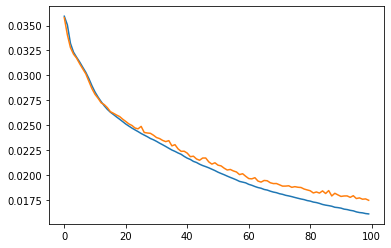

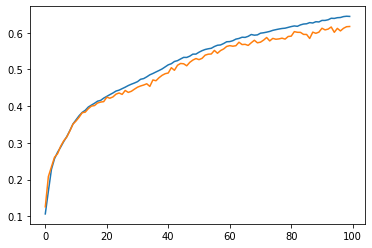

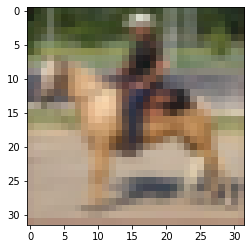

actual_label: 7 predicted_label: 7 actual_class: horse predicted_class: horse


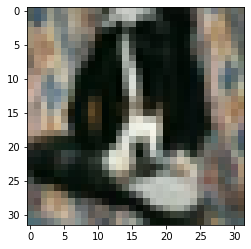

actual_label: 5 predicted_label: 9 actual_class: dog predicted_class: truck


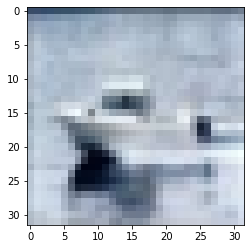

actual_label: 8 predicted_label: 8 actual_class: ship predicted_class: ship


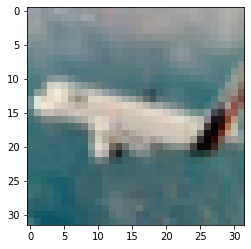

actual_label: 0 predicted_label: 0 actual_class: plane predicted_class: plane


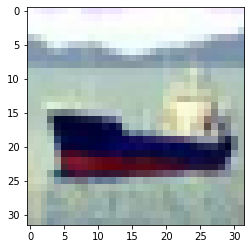

actual_label: 8 predicted_label: 8 actual_class: ship predicted_class: ship


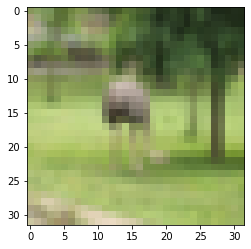

actual_label: 2 predicted_label: 4 actual_class: bird predicted_class: deer


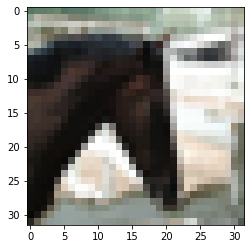

actual_label: 7 predicted_label: 7 actual_class: horse predicted_class: horse


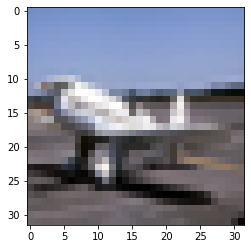

actual_label: 0 predicted_label: 0 actual_class: plane predicted_class: plane


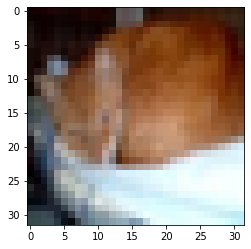

actual_label: 3 predicted_label: 3 actual_class: cat predicted_class: cat


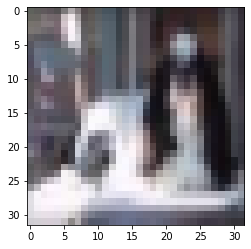

actual_label: 5 predicted_label: 3 actual_class: dog predicted_class: cat

 test loss: 0.017357111516984026 test acc: 0.613156847133758 correct: 6161 incorrect: 3839


In [ ]:
batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

torch.manual_seed(42)
validation_size = 5000
train_size = len(trainset)-validation_size
train_set, validation_set = random_split(trainset, [train_size, validation_size])


train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True,num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=64,shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False)

print("trainset:",len(train_set))
print("validationset:",len(validation_set))
print("testset:",len(test_set))

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



dataiter = iter(train_dataloader)
images, labels = dataiter.next()


def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(labels)


class ConvolutionNetwork1(nn.Module):

  def __init__(self):
    super(ConvolutionNetwork1,self).__init__()
    
    self.flatten_shape =  64*14*14

    self.conv = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5,stride=1),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5,stride=1),
          nn.MaxPool2d(kernel_size=2,stride=1),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5,stride=1),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5,stride=1),
          nn.MaxPool2d(kernel_size=2,stride=1)
    )

    self.fc = nn.Sequential( 
        nn.Linear(in_features=self.flatten_shape, out_features=128),
        nn.Linear(in_features=128, out_features=200),
        nn.Linear(in_features=200, out_features=64),
        nn.Linear(in_features=64, out_features=10)
    )

  def forward(self,x):
    x = self.conv(x)
    flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
    print("ff:",x.shape,flat_features.shape)
    x=self.fc(flat_features)
    return x

  def forward(self,x):
    x = self.conv(x)
    flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
    # print("ff:",x.shape,flat_features.shape)
    x=self.fc(flat_features)
    return x


device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        correct = 0
        incorrect = 0
        for imgs,lbls in dataloader:
            imgs = imgs
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls).item()
            correct += torch.sum(test_pred == lbls).item()
            incorrect += torch.sum(test_pred != lbls).item()

        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))
        
        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img.unsqueeze(0))
              pred_lbl = out
              imshow(img.cpu().detach())
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp,"actual_class:",classes[actual_lbl_disp],"predicted_class:",classes[pred_lbl_disp])

                        
            return test_loss,test_acc,correct,incorrect
    
    return test_loss,test_acc,correct,incorrect


from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 100
learning_rate = 0.0001

model = ConvolutionNetwork1().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  train_correct = 0
  train_incorrect = 0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      train_correct += torch.sum(torch.argmax(out, dim=1) == lbls).item()
      train_incorrect += torch.sum(torch.argmax(out, dim=1) != lbls).item()
      running_acc += acc.item()

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  val_loss,val_acc,correct,incorrect = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size),"train_correct:",train_correct,"train_incorrect:",train_incorrect," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"correct:",correct,"incorrect:",incorrect,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()

model.eval()
test_loss,test_acc,test_correct,test_incorrect = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc,"correct:",test_correct,"incorrect:",test_incorrect)


**(b)**

**maxpool = (2,2)**

**stride = 1**

**Conv-Pool-BatchNormalization-ReLU-Conv-Pool-BatchNormalization-ReLU-FC-FC**

Files already downloaded and verified
Files already downloaded and verified
trainset: 45000
validationset: 5000
testset: 10000


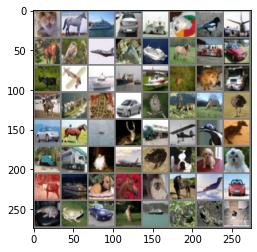

tensor([3, 7, 8, 1, 8, 5, 2, 0, 7, 2, 0, 2, 8, 7, 9, 1, 4, 0, 8, 8, 0, 4, 5, 9,
        7, 8, 6, 1, 2, 4, 5, 2, 1, 7, 8, 4, 9, 0, 2, 2, 9, 9, 3, 0, 6, 5, 5, 5,
        4, 8, 5, 7, 5, 7, 0, 1, 3, 6, 1, 4, 8, 6, 6, 3])
cuda


100%|██████████| 704/704 [00:18<00:00, 38.28it/s, batch_loss=1.7890043258666992]



epoch: 0  Train Loss: 0.032201513208829885  Train Accuracy: 0.2721280184659091 train_correct: 12261 train_incorrect: 32739  Validation Loss: 0.029093507182183145  Validation Accuracy: 0.3368275316455696 correct: 1703 incorrect: 3297 



100%|██████████| 704/704 [00:18<00:00, 38.09it/s, batch_loss=1.5890089273452759]



epoch: 1  Train Loss: 0.027644498186418787  Train Accuracy: 0.37202592329545453 train_correct: 16762 train_incorrect: 28238  Validation Loss: 0.02667482350540312  Validation Accuracy: 0.3791534810126582 correct: 1917 incorrect: 3083 



100%|██████████| 704/704 [00:22<00:00, 30.89it/s, batch_loss=1.68299400806427]



epoch: 2  Train Loss: 0.025813202818178317  Train Accuracy: 0.4060724431818182 train_correct: 18296 train_incorrect: 26704  Validation Loss: 0.02535820389284363  Validation Accuracy: 0.4131724683544304 correct: 2089 incorrect: 2911 



100%|██████████| 704/704 [00:20<00:00, 35.10it/s, batch_loss=1.660011887550354]



epoch: 3  Train Loss: 0.02455532889474522  Train Accuracy: 0.4367453835227273 train_correct: 19678 train_incorrect: 25322  Validation Loss: 0.024327261491289623  Validation Accuracy: 0.4363132911392405 correct: 2206 incorrect: 2794 



100%|██████████| 704/704 [00:23<00:00, 30.24it/s, batch_loss=1.3544697761535645]



epoch: 4  Train Loss: 0.02353699683920819  Train Accuracy: 0.4634011008522727 train_correct: 20879 train_incorrect: 24121  Validation Loss: 0.023484378463671178  Validation Accuracy: 0.45747626582278483 correct: 2313 incorrect: 2687 



100%|██████████| 704/704 [00:18<00:00, 37.86it/s, batch_loss=1.5953586101531982]



epoch: 5  Train Loss: 0.022753510158509016  Train Accuracy: 0.4812899502840909 train_correct: 21685 train_incorrect: 23315  Validation Loss: 0.022832176070424575  Validation Accuracy: 0.47488132911392406 correct: 2401 incorrect: 2599 



100%|██████████| 704/704 [00:18<00:00, 37.72it/s, batch_loss=1.5967141389846802]



epoch: 6  Train Loss: 0.022072702601276847  Train Accuracy: 0.4972256747159091 train_correct: 22403 train_incorrect: 22597  Validation Loss: 0.022297139385644392  Validation Accuracy: 0.4853639240506329 correct: 2454 incorrect: 2546 



100%|██████████| 704/704 [00:18<00:00, 37.48it/s, batch_loss=2.1416420936584473]



epoch: 7  Train Loss: 0.02154160375093025  Train Accuracy: 0.5111860795454546 train_correct: 23032 train_incorrect: 21968  Validation Loss: 0.02182029333861568  Validation Accuracy: 0.49980221518987344 correct: 2527 incorrect: 2473 



100%|██████████| 704/704 [00:18<00:00, 37.67it/s, batch_loss=1.4505906105041504]



epoch: 8  Train Loss: 0.020992454966868867  Train Accuracy: 0.5229714133522727 train_correct: 23563 train_incorrect: 21437  Validation Loss: 0.021335972402291962  Validation Accuracy: 0.5104825949367089 correct: 2581 incorrect: 2419 



100%|██████████| 704/704 [00:19<00:00, 36.58it/s, batch_loss=1.7694576978683472]



epoch: 9  Train Loss: 0.02048018075319388  Train Accuracy: 0.5370649857954546 train_correct: 24198 train_incorrect: 20802  Validation Loss: 0.02085665859800728  Validation Accuracy: 0.5261075949367089 correct: 2660 incorrect: 2340 



100%|██████████| 704/704 [00:18<00:00, 37.15it/s, batch_loss=1.2246193885803223]



epoch: 10  Train Loss: 0.01998652635666076  Train Accuracy: 0.5472301136363636 train_correct: 24656 train_incorrect: 20344  Validation Loss: 0.020465936488177204  Validation Accuracy: 0.5326344936708861 correct: 2693 incorrect: 2307 



100%|██████████| 704/704 [00:18<00:00, 37.44it/s, batch_loss=1.173382043838501]



epoch: 11  Train Loss: 0.01953074525094549  Train Accuracy: 0.5591264204545454 train_correct: 25192 train_incorrect: 19808  Validation Loss: 0.019985967964122567  Validation Accuracy: 0.549248417721519 correct: 2777 incorrect: 2223 



100%|██████████| 704/704 [00:18<00:00, 37.49it/s, batch_loss=1.3555939197540283]



epoch: 12  Train Loss: 0.01902724003726193  Train Accuracy: 0.5705122514204546 train_correct: 25705 train_incorrect: 19295  Validation Loss: 0.019770685795553123  Validation Accuracy: 0.5528085443037974 correct: 2795 incorrect: 2205 



100%|██████████| 704/704 [00:18<00:00, 37.31it/s, batch_loss=0.5837199091911316]



epoch: 13  Train Loss: 0.018595050484608775  Train Accuracy: 0.5812322443181818 train_correct: 26188 train_incorrect: 18812  Validation Loss: 0.019407337165991717  Validation Accuracy: 0.5605221518987342 correct: 2834 incorrect: 2166 



100%|██████████| 704/704 [00:18<00:00, 37.50it/s, batch_loss=0.5667362809181213]



epoch: 14  Train Loss: 0.018189983630277726  Train Accuracy: 0.5892666903409091 train_correct: 26550 train_incorrect: 18450  Validation Loss: 0.01911039552592401  Validation Accuracy: 0.567246835443038 correct: 2868 incorrect: 2132 



100%|██████████| 704/704 [00:19<00:00, 36.36it/s, batch_loss=0.9051262140274048]



epoch: 15  Train Loss: 0.017896229909224945  Train Accuracy: 0.5963689630681818 train_correct: 26870 train_incorrect: 18130  Validation Loss: 0.01855392502974483  Validation Accuracy: 0.5814873417721519 correct: 2940 incorrect: 2060 



100%|██████████| 704/704 [00:18<00:00, 37.39it/s, batch_loss=1.3471910953521729]



epoch: 16  Train Loss: 0.01758874229827515  Train Accuracy: 0.6056019176136364 train_correct: 27286 train_incorrect: 17714  Validation Loss: 0.01860953165996301  Validation Accuracy: 0.5795094936708861 correct: 2930 incorrect: 2070 



100%|██████████| 704/704 [00:18<00:00, 37.36it/s, batch_loss=0.9840449094772339]



epoch: 17  Train Loss: 0.017326361436227507  Train Accuracy: 0.6116166548295454 train_correct: 27557 train_incorrect: 17443  Validation Loss: 0.01818743678210657  Validation Accuracy: 0.5888053797468354 correct: 2977 incorrect: 2023 



100%|██████████| 704/704 [00:18<00:00, 37.45it/s, batch_loss=1.2931495904922485]



epoch: 18  Train Loss: 0.017030351188044402  Train Accuracy: 0.6184303977272727 train_correct: 27864 train_incorrect: 17136  Validation Loss: 0.01811860446358406  Validation Accuracy: 0.5949367088607594 correct: 3008 incorrect: 1992 



100%|██████████| 704/704 [00:18<00:00, 37.77it/s, batch_loss=0.8593842387199402]



epoch: 19  Train Loss: 0.016849361604809845  Train Accuracy: 0.6224032315340909 train_correct: 28043 train_incorrect: 16957  Validation Loss: 0.018058086651129814  Validation Accuracy: 0.5909810126582279 correct: 2988 incorrect: 2012 



100%|██████████| 704/704 [00:18<00:00, 37.27it/s, batch_loss=1.0805706977844238]



epoch: 20  Train Loss: 0.016602072385880587  Train Accuracy: 0.6294833096590909 train_correct: 28362 train_incorrect: 16638  Validation Loss: 0.017725695089637478  Validation Accuracy: 0.6002768987341772 correct: 3035 incorrect: 1965 



100%|██████████| 704/704 [00:18<00:00, 37.36it/s, batch_loss=0.8522089123725891]



epoch: 21  Train Loss: 0.016401026531556537  Train Accuracy: 0.6337446732954546 train_correct: 28554 train_incorrect: 16446  Validation Loss: 0.017639864071071903  Validation Accuracy: 0.599881329113924 correct: 3033 incorrect: 1967 



100%|██████████| 704/704 [00:18<00:00, 37.36it/s, batch_loss=1.0518696308135986]



epoch: 22  Train Loss: 0.016221565329363908  Train Accuracy: 0.6358087713068182 train_correct: 28647 train_incorrect: 16353  Validation Loss: 0.01787927516889346  Validation Accuracy: 0.5943433544303798 correct: 3005 incorrect: 1995 



100%|██████████| 704/704 [00:19<00:00, 36.38it/s, batch_loss=0.5467806458473206]



epoch: 23  Train Loss: 0.015973623901531522  Train Accuracy: 0.6451526988636364 train_correct: 29068 train_incorrect: 15932  Validation Loss: 0.01723686722401954  Validation Accuracy: 0.609375 correct: 3081 incorrect: 1919 



100%|██████████| 704/704 [00:19<00:00, 36.59it/s, batch_loss=1.3070627450942993]



epoch: 24  Train Loss: 0.01581985083810816  Train Accuracy: 0.6463734019886364 train_correct: 29123 train_incorrect: 15877  Validation Loss: 0.01724584709522845  Validation Accuracy: 0.6123417721518988 correct: 3096 incorrect: 1904 



100%|██████████| 704/704 [00:19<00:00, 35.81it/s, batch_loss=0.9825912714004517]



epoch: 25  Train Loss: 0.01562076428936879  Train Accuracy: 0.6526988636363636 train_correct: 29408 train_incorrect: 15592  Validation Loss: 0.01731095079898457  Validation Accuracy: 0.6125395569620253 correct: 3097 incorrect: 1903 



100%|██████████| 704/704 [00:18<00:00, 37.52it/s, batch_loss=1.0470776557922363]



epoch: 26  Train Loss: 0.015432804652267474  Train Accuracy: 0.6561612215909091 train_correct: 29564 train_incorrect: 15436  Validation Loss: 0.017227253640848626  Validation Accuracy: 0.6068037974683544 correct: 3068 incorrect: 1932 



100%|██████████| 704/704 [00:18<00:00, 38.02it/s, batch_loss=0.37514305114746094]



epoch: 27  Train Loss: 0.015296373960816047  Train Accuracy: 0.6584694602272727 train_correct: 29668 train_incorrect: 15332  Validation Loss: 0.016876066280411012  Validation Accuracy: 0.6184731012658228 correct: 3127 incorrect: 1873 



100%|██████████| 704/704 [00:18<00:00, 37.79it/s, batch_loss=0.8637106418609619]



epoch: 28  Train Loss: 0.015128342350098219  Train Accuracy: 0.6633078835227273 train_correct: 29886 train_incorrect: 15114  Validation Loss: 0.016831816197667694  Validation Accuracy: 0.6240110759493671 correct: 3155 incorrect: 1845 



100%|██████████| 704/704 [00:18<00:00, 37.88it/s, batch_loss=0.9254175424575806]



epoch: 29  Train Loss: 0.01498117923620157  Train Accuracy: 0.6684348366477273 train_correct: 30117 train_incorrect: 14883  Validation Loss: 0.01696067147805721  Validation Accuracy: 0.6149129746835443 correct: 3109 incorrect: 1891 



100%|██████████| 704/704 [00:18<00:00, 37.55it/s, batch_loss=0.5760970711708069]



epoch: 30  Train Loss: 0.01481483344766523  Train Accuracy: 0.6720525568181818 train_correct: 30280 train_incorrect: 14720  Validation Loss: 0.016603014962394025  Validation Accuracy: 0.6246044303797469 correct: 3158 incorrect: 1842 



100%|██████████| 704/704 [00:18<00:00, 37.75it/s, batch_loss=0.7987387776374817]



epoch: 31  Train Loss: 0.014704523966594768  Train Accuracy: 0.6743607954545454 train_correct: 30384 train_incorrect: 14616  Validation Loss: 0.016588057815745662  Validation Accuracy: 0.6307357594936709 correct: 3189 incorrect: 1811 



100%|██████████| 704/704 [00:18<00:00, 37.93it/s, batch_loss=1.0335772037506104]



epoch: 32  Train Loss: 0.014575232479149814  Train Accuracy: 0.6768465909090909 train_correct: 30496 train_incorrect: 14504  Validation Loss: 0.016601850655920142  Validation Accuracy: 0.6251977848101266 correct: 3161 incorrect: 1839 



100%|██████████| 704/704 [00:18<00:00, 37.37it/s, batch_loss=1.575670838356018]



epoch: 33  Train Loss: 0.014422087231650949  Train Accuracy: 0.6800648082386364 train_correct: 30641 train_incorrect: 14359  Validation Loss: 0.016494631991261922  Validation Accuracy: 0.6293512658227848 correct: 3182 incorrect: 1818 



100%|██████████| 704/704 [00:19<00:00, 36.44it/s, batch_loss=1.331811785697937]



epoch: 34  Train Loss: 0.014278993346537887  Train Accuracy: 0.6833052201704546 train_correct: 30787 train_incorrect: 14213  Validation Loss: 0.016483373161924036  Validation Accuracy: 0.6299446202531646 correct: 3185 incorrect: 1815 



100%|██████████| 704/704 [00:19<00:00, 36.86it/s, batch_loss=1.4086689949035645]



epoch: 35  Train Loss: 0.014155628986455586  Train Accuracy: 0.6863680752840909 train_correct: 30925 train_incorrect: 14075  Validation Loss: 0.016375382419062567  Validation Accuracy: 0.6287579113924051 correct: 3179 incorrect: 1821 



100%|██████████| 704/704 [00:19<00:00, 36.36it/s, batch_loss=1.3780829906463623]



epoch: 36  Train Loss: 0.014028798734546977  Train Accuracy: 0.6896528764204546 train_correct: 31073 train_incorrect: 13927  Validation Loss: 0.01640652909969227  Validation Accuracy: 0.6348892405063291 correct: 3210 incorrect: 1790 



100%|██████████| 704/704 [00:19<00:00, 36.62it/s, batch_loss=1.4614301919937134]



epoch: 37  Train Loss: 0.013877307063508355  Train Accuracy: 0.6921608664772727 train_correct: 31186 train_incorrect: 13814  Validation Loss: 0.016333629235719578  Validation Accuracy: 0.6342958860759493 correct: 3207 incorrect: 1793 



100%|██████████| 704/704 [00:19<00:00, 36.91it/s, batch_loss=1.2215187549591064]



epoch: 38  Train Loss: 0.013741763206780888  Train Accuracy: 0.6950905539772727 train_correct: 31318 train_incorrect: 13682  Validation Loss: 0.016225864757088166  Validation Accuracy: 0.6339003164556962 correct: 3205 incorrect: 1795 



100%|██████████| 704/704 [00:19<00:00, 36.64it/s, batch_loss=0.83978271484375]



epoch: 39  Train Loss: 0.013636837389309552  Train Accuracy: 0.697021484375 train_correct: 31405 train_incorrect: 13595  Validation Loss: 0.016234873027741153  Validation Accuracy: 0.6366693037974683 correct: 3219 incorrect: 1781 



100%|██████████| 704/704 [00:19<00:00, 36.66it/s, batch_loss=0.36669954657554626]



epoch: 40  Train Loss: 0.013505499662476888  Train Accuracy: 0.7018155184659091 train_correct: 31621 train_incorrect: 13379  Validation Loss: 0.016178030874344367  Validation Accuracy: 0.6354825949367089 correct: 3213 incorrect: 1787 



100%|██████████| 704/704 [00:19<00:00, 36.69it/s, batch_loss=0.9908453822135925]



epoch: 41  Train Loss: 0.01340990353888959  Train Accuracy: 0.7046564275568182 train_correct: 31749 train_incorrect: 13251  Validation Loss: 0.016124505254946932  Validation Accuracy: 0.6402294303797469 correct: 3237 incorrect: 1763 



100%|██████████| 704/704 [00:19<00:00, 36.71it/s, batch_loss=1.1510686874389648]



epoch: 42  Train Loss: 0.013248515856420536  Train Accuracy: 0.7074973366477273 train_correct: 31877 train_incorrect: 13123  Validation Loss: 0.01633338738657251  Validation Accuracy: 0.6323180379746836 correct: 3197 incorrect: 1803 



100%|██████████| 704/704 [00:19<00:00, 36.66it/s, batch_loss=0.6020853519439697]



epoch: 43  Train Loss: 0.013146186575547537  Train Accuracy: 0.7081187855113636 train_correct: 31905 train_incorrect: 13095  Validation Loss: 0.016278908776614486  Validation Accuracy: 0.6370648734177216 correct: 3221 incorrect: 1779 



100%|██████████| 704/704 [00:19<00:00, 36.37it/s, batch_loss=1.572925329208374]



epoch: 44  Train Loss: 0.013042375161603559  Train Accuracy: 0.7117365056818182 train_correct: 32068 train_incorrect: 12932  Validation Loss: 0.016106520355030705  Validation Accuracy: 0.6370648734177216 correct: 3221 incorrect: 1779 



100%|██████████| 704/704 [00:18<00:00, 37.37it/s, batch_loss=0.7308831810951233]



epoch: 45  Train Loss: 0.012916365669463465  Train Accuracy: 0.7144220525568182 train_correct: 32189 train_incorrect: 12811  Validation Loss: 0.01621001522657992  Validation Accuracy: 0.6372626582278481 correct: 3222 incorrect: 1778 



100%|██████████| 704/704 [00:19<00:00, 36.96it/s, batch_loss=0.8549484014511108]



epoch: 46  Train Loss: 0.012804965521685186  Train Accuracy: 0.7157315340909091 train_correct: 32248 train_incorrect: 12752  Validation Loss: 0.01618940196931362  Validation Accuracy: 0.6362737341772152 correct: 3217 incorrect: 1783 



100%|██████████| 704/704 [00:19<00:00, 36.89it/s, batch_loss=1.298852562904358]



epoch: 47  Train Loss: 0.012759781757433137  Train Accuracy: 0.7165305397727273 train_correct: 32284 train_incorrect: 12716  Validation Loss: 0.016258475158505047  Validation Accuracy: 0.6368670886075949 correct: 3220 incorrect: 1780 



100%|██████████| 704/704 [00:19<00:00, 36.98it/s, batch_loss=1.0260781049728394]



epoch: 48  Train Loss: 0.012614733743248507  Train Accuracy: 0.721923828125 train_correct: 32527 train_incorrect: 12473  Validation Loss: 0.016388504435838776  Validation Accuracy: 0.6366693037974683 correct: 3219 incorrect: 1781 



100%|██████████| 704/704 [00:19<00:00, 36.74it/s, batch_loss=1.7162632942199707]



epoch: 49  Train Loss: 0.012553365516148253  Train Accuracy: 0.7223899147727273 train_correct: 32548 train_incorrect: 12452  Validation Loss: 0.016175862142368207  Validation Accuracy: 0.6366693037974683 correct: 3219 incorrect: 1781 



100%|██████████| 704/704 [00:19<00:00, 36.53it/s, batch_loss=1.4011517763137817]



epoch: 50  Train Loss: 0.012430364345412025  Train Accuracy: 0.7248091264204546 train_correct: 32657 train_incorrect: 12343  Validation Loss: 0.01674453160855212  Validation Accuracy: 0.6279667721518988 correct: 3175 incorrect: 1825 



100%|██████████| 704/704 [00:19<00:00, 36.64it/s, batch_loss=0.6386168599128723]



epoch: 51  Train Loss: 0.012292202474120793  Train Accuracy: 0.7277610085227273 train_correct: 32790 train_incorrect: 12210  Validation Loss: 0.016257239128404027  Validation Accuracy: 0.638251582278481 correct: 3227 incorrect: 1773 



100%|██████████| 704/704 [00:19<00:00, 36.43it/s, batch_loss=0.6830259561538696]



epoch: 52  Train Loss: 0.012195222419078082  Train Accuracy: 0.7296919389204546 train_correct: 32877 train_incorrect: 12123  Validation Loss: 0.016113985836788823  Validation Accuracy: 0.642998417721519 correct: 3251 incorrect: 1749 



100%|██████████| 704/704 [00:18<00:00, 37.06it/s, batch_loss=0.6951373219490051]



epoch: 53  Train Loss: 0.012089537739071106  Train Accuracy: 0.7329323508522727 train_correct: 33023 train_incorrect: 11977  Validation Loss: 0.016434610479428798  Validation Accuracy: 0.6339003164556962 correct: 3205 incorrect: 1795 



100%|██████████| 704/704 [00:19<00:00, 36.76it/s, batch_loss=0.5282626152038574]



epoch: 54  Train Loss: 0.012017666532218836  Train Accuracy: 0.7352627840909091 train_correct: 33128 train_incorrect: 11872  Validation Loss: 0.0162146982465741  Validation Accuracy: 0.6380537974683544 correct: 3226 incorrect: 1774 



100%|██████████| 704/704 [00:19<00:00, 36.42it/s, batch_loss=0.9610508680343628]



epoch: 55  Train Loss: 0.011898798047199803  Train Accuracy: 0.73583984375 train_correct: 33154 train_incorrect: 11846  Validation Loss: 0.01631611408783665  Validation Accuracy: 0.6364715189873418 correct: 3218 incorrect: 1782 



100%|██████████| 704/704 [00:19<00:00, 35.91it/s, batch_loss=0.6809155941009521]



epoch: 56  Train Loss: 0.011803390421184966  Train Accuracy: 0.7405450994318182 train_correct: 33366 train_incorrect: 11634  Validation Loss: 0.01649778392873233  Validation Accuracy: 0.6360759493670886 correct: 3216 incorrect: 1784 



100%|██████████| 704/704 [00:19<00:00, 35.92it/s, batch_loss=0.8490382432937622]



epoch: 57  Train Loss: 0.011702437107239595  Train Accuracy: 0.7434969815340909 train_correct: 33499 train_incorrect: 11501  Validation Loss: 0.016326984567449816  Validation Accuracy: 0.6418117088607594 correct: 3245 incorrect: 1755 



100%|██████████| 704/704 [00:19<00:00, 36.73it/s, batch_loss=0.37605366110801697]



epoch: 58  Train Loss: 0.011627686815865507  Train Accuracy: 0.7433638139204546 train_correct: 33493 train_incorrect: 11507  Validation Loss: 0.016409844608057902  Validation Accuracy: 0.6307357594936709 correct: 3189 incorrect: 1811 



100%|██████████| 704/704 [00:19<00:00, 37.04it/s, batch_loss=0.7761654257774353]



epoch: 59  Train Loss: 0.011524653685972391  Train Accuracy: 0.7455166903409091 train_correct: 33590 train_incorrect: 11410  Validation Loss: 0.01628153292532963  Validation Accuracy: 0.6396360759493671 correct: 3234 incorrect: 1766 



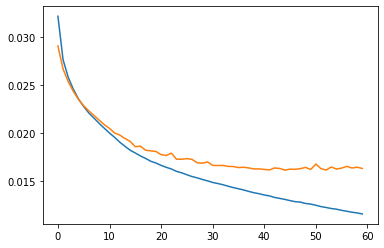

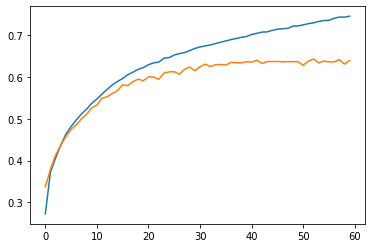

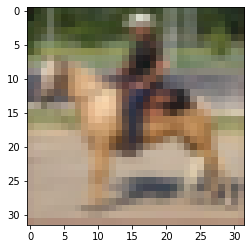

actual_label: 7 predicted_label: 7 actual_class: plane predicted_class: plane


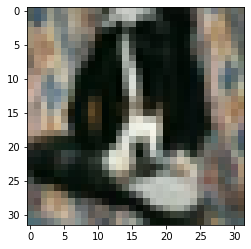

actual_label: 5 predicted_label: 3 actual_class: dog predicted_class: car


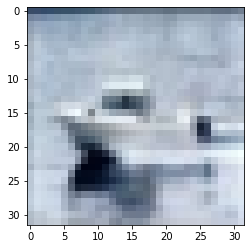

actual_label: 8 predicted_label: 2 actual_class: horse predicted_class: ship


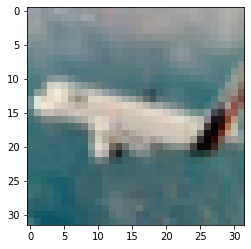

actual_label: 0 predicted_label: 0 actual_class: cat predicted_class: cat


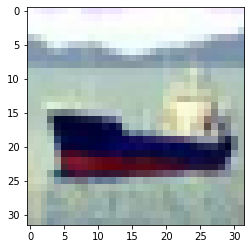

actual_label: 8 predicted_label: 6 actual_class: horse predicted_class: bird


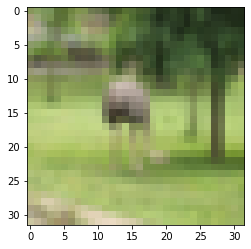

actual_label: 2 predicted_label: 7 actual_class: ship predicted_class: plane


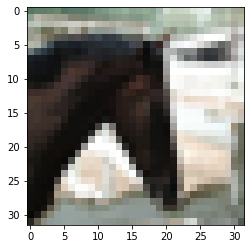

actual_label: 7 predicted_label: 7 actual_class: plane predicted_class: plane


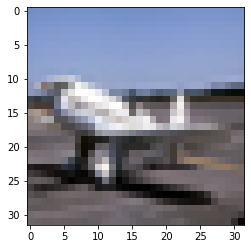

actual_label: 0 predicted_label: 0 actual_class: cat predicted_class: cat


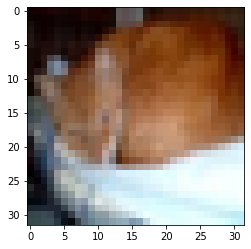

actual_label: 3 predicted_label: 3 actual_class: car predicted_class: car


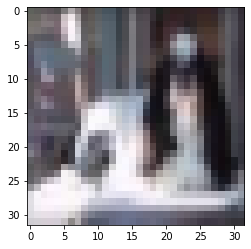

actual_label: 5 predicted_label: 3 actual_class: dog predicted_class: car

 test loss: 0.016486534095446394 test acc: 0.6377388535031847 correct: 6408 incorrect: 3592


In [ ]:
batch_szie=64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

torch.manual_seed(42)
validation_size = 5000
train_size = len(trainset)-validation_size
train_set, validation_set = random_split(trainset, [train_size, validation_size])


train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True,num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=64,shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False)

print("trainset:",len(train_set))
print("validationset:",len(validation_set))
print("testset:",len(test_set))

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


dataiter = iter(train_dataloader)
images, labels = dataiter.next()


def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(labels)

class ConvolutionNetwork1(nn.Module):

  def __init__(self):
    super(ConvolutionNetwork1,self).__init__()
    
    self.flatten_shape =  16*22*22

    self.conv = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5,stride=1),
          nn.MaxPool2d(kernel_size=(2,2),stride=1),
          nn.BatchNorm2d(8),
          nn.ReLU(True),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5,stride=1),
          nn.MaxPool2d(kernel_size=(2,2),stride=1),
          nn.BatchNorm2d(16),
          nn.ReLU(True)
    )

    self.fc = nn.Sequential( 
        nn.Linear(in_features=self.flatten_shape, out_features=128),
        nn.Linear(in_features=128, out_features=200),
        nn.Linear(in_features=200, out_features=10)
    )

  def forward(self,x):
    x = self.conv(x)
    flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
    # print("ff:",x.shape,flat_features.shape)
    x=self.fc(flat_features)
    return x


device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        correct = 0
        incorrect = 0
        for imgs,lbls in dataloader:
            imgs = imgs
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls).item()
            correct += torch.sum(test_pred == lbls).item()
            incorrect += torch.sum(test_pred != lbls).item()

        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))
        
        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img.unsqueeze(0))
              pred_lbl = out
              imshow(img.cpu().detach())
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp,"actual_class:",classes[actual_lbl_disp],"predicted_class:",classes[pred_lbl_disp])

                        
            return test_loss,test_acc,correct,incorrect
    
    return test_loss,test_acc,correct,incorrect


from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 60
learning_rate = 0.0001

model = ConvolutionNetwork1().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  train_correct = 0
  train_incorrect = 0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      train_correct += torch.sum(torch.argmax(out, dim=1) == lbls).item()
      train_incorrect += torch.sum(torch.argmax(out, dim=1) != lbls).item()
      running_acc += acc.item()

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  val_loss,val_acc,correct,incorrect = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size),"train_correct:",train_correct,"train_incorrect:",train_incorrect," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"correct:",correct,"incorrect:",incorrect,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()

model.eval()
test_loss,test_acc,test_correct,test_incorrect = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc,"correct:",test_correct,"incorrect:",test_incorrect)




**(c)**

**not used - maxpool**

**stride = 1**

**Conv-BatchNormalization-ReLU-Conv-BatchNormalization-ReLU-FC-FC**

Files already downloaded and verified
Files already downloaded and verified
trainset: 45000
validationset: 5000
testset: 10000


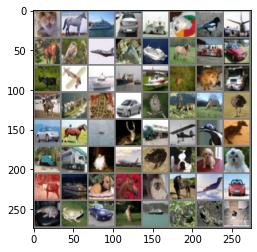

tensor([3, 7, 8, 1, 8, 5, 2, 0, 7, 2, 0, 2, 8, 7, 9, 1, 4, 0, 8, 8, 0, 4, 5, 9,
        7, 8, 6, 1, 2, 4, 5, 2, 1, 7, 8, 4, 9, 0, 2, 2, 9, 9, 3, 0, 6, 5, 5, 5,
        4, 8, 5, 7, 5, 7, 0, 1, 3, 6, 1, 4, 8, 6, 6, 3])
cuda


100%|██████████| 704/704 [00:18<00:00, 38.47it/s, batch_loss=1.7322864532470703]



epoch: 0  Train Loss: 0.03204743850404735  Train Accuracy: 0.28211558948863635 train_correct: 12711 train_incorrect: 32289  Validation Loss: 0.029541403220235546  Validation Accuracy: 0.32654272151898733 correct: 1651 incorrect: 3349 



100%|██████████| 704/704 [00:18<00:00, 38.48it/s, batch_loss=2.043246030807495]



epoch: 1  Train Loss: 0.028053810899357566  Train Accuracy: 0.37025035511363635 train_correct: 16682 train_incorrect: 28318  Validation Loss: 0.02695923548521875  Validation Accuracy: 0.3803401898734177 correct: 1923 incorrect: 3077 



100%|██████████| 704/704 [00:18<00:00, 37.59it/s, batch_loss=1.8801321983337402]



epoch: 2  Train Loss: 0.025973892117194322  Train Accuracy: 0.4100008877840909 train_correct: 18473 train_incorrect: 26527  Validation Loss: 0.025360273692426803  Validation Accuracy: 0.4183148734177215 correct: 2115 incorrect: 2885 



100%|██████████| 704/704 [00:18<00:00, 38.51it/s, batch_loss=1.9340925216674805]



epoch: 3  Train Loss: 0.024511575505708937  Train Accuracy: 0.4402077414772727 train_correct: 19834 train_incorrect: 25166  Validation Loss: 0.024207326477464243  Validation Accuracy: 0.43769778481012656 correct: 2213 incorrect: 2787 



100%|██████████| 704/704 [00:18<00:00, 38.36it/s, batch_loss=1.8068498373031616]



epoch: 4  Train Loss: 0.023343036755580793  Train Accuracy: 0.46568714488636365 train_correct: 20982 train_incorrect: 24018  Validation Loss: 0.02322610974594762  Validation Accuracy: 0.46281645569620256 correct: 2340 incorrect: 2660 



100%|██████████| 704/704 [00:18<00:00, 38.69it/s, batch_loss=1.3405708074569702]



epoch: 5  Train Loss: 0.022479321021819487  Train Accuracy: 0.4867498224431818 train_correct: 21931 train_incorrect: 23069  Validation Loss: 0.022621114137051982  Validation Accuracy: 0.4723101265822785 correct: 2388 incorrect: 2612 



100%|██████████| 704/704 [00:18<00:00, 38.67it/s, batch_loss=1.4454079866409302]



epoch: 6  Train Loss: 0.021826899017799984  Train Accuracy: 0.501708984375 train_correct: 22605 train_incorrect: 22395  Validation Loss: 0.02202952931387515  Validation Accuracy: 0.48417721518987344 correct: 2448 incorrect: 2552 



100%|██████████| 704/704 [00:18<00:00, 38.33it/s, batch_loss=1.7108460664749146]



epoch: 7  Train Loss: 0.021299260885412383  Train Accuracy: 0.5137606534090909 train_correct: 23148 train_incorrect: 21852  Validation Loss: 0.021644924967726575  Validation Accuracy: 0.495253164556962 correct: 2504 incorrect: 2496 



100%|██████████| 704/704 [00:18<00:00, 37.95it/s, batch_loss=2.24692440032959]



epoch: 8  Train Loss: 0.02084842053855854  Train Accuracy: 0.527587890625 train_correct: 23771 train_incorrect: 21229  Validation Loss: 0.02125644867744627  Validation Accuracy: 0.5073180379746836 correct: 2565 incorrect: 2435 



100%|██████████| 704/704 [00:18<00:00, 38.13it/s, batch_loss=1.0866271257400513]



epoch: 9  Train Loss: 0.020422959930411624  Train Accuracy: 0.5375754616477273 train_correct: 24221 train_incorrect: 20779  Validation Loss: 0.02092555153501939  Validation Accuracy: 0.509493670886076 correct: 2576 incorrect: 2424 



100%|██████████| 704/704 [00:18<00:00, 38.31it/s, batch_loss=1.1397616863250732]



epoch: 10  Train Loss: 0.020028383120502855  Train Accuracy: 0.5452104048295454 train_correct: 24565 train_incorrect: 20435  Validation Loss: 0.020641066251864917  Validation Accuracy: 0.5219541139240507 correct: 2639 incorrect: 2361 



100%|██████████| 704/704 [00:18<00:00, 38.35it/s, batch_loss=1.2436615228652954]



epoch: 11  Train Loss: 0.019640850785601124  Train Accuracy: 0.5551091974431818 train_correct: 25011 train_incorrect: 19989  Validation Loss: 0.020343188219998455  Validation Accuracy: 0.5300632911392406 correct: 2680 incorrect: 2320 



100%|██████████| 704/704 [00:18<00:00, 37.61it/s, batch_loss=1.6738648414611816]



epoch: 12  Train Loss: 0.019302113726470536  Train Accuracy: 0.5621004971590909 train_correct: 25326 train_incorrect: 19674  Validation Loss: 0.020084825827728345  Validation Accuracy: 0.5361946202531646 correct: 2711 incorrect: 2289 



100%|██████████| 704/704 [00:18<00:00, 37.72it/s, batch_loss=1.3592653274536133]



epoch: 13  Train Loss: 0.018935087949185716  Train Accuracy: 0.5710671164772727 train_correct: 25730 train_incorrect: 19270  Validation Loss: 0.019864402805702595  Validation Accuracy: 0.5419303797468354 correct: 2740 incorrect: 2260 



100%|██████████| 704/704 [00:19<00:00, 37.04it/s, batch_loss=1.2308709621429443]



epoch: 14  Train Loss: 0.01860162949279501  Train Accuracy: 0.5795676491477273 train_correct: 26113 train_incorrect: 18887  Validation Loss: 0.01958856342619733  Validation Accuracy: 0.546875 correct: 2765 incorrect: 2235 



100%|██████████| 704/704 [00:18<00:00, 38.07it/s, batch_loss=1.1652610301971436]



epoch: 15  Train Loss: 0.018256065325906755  Train Accuracy: 0.5875799005681818 train_correct: 26474 train_incorrect: 18526  Validation Loss: 0.019465290151442154  Validation Accuracy: 0.549248417721519 correct: 2777 incorrect: 2223 



100%|██████████| 704/704 [00:18<00:00, 37.66it/s, batch_loss=0.7391196489334106]



epoch: 16  Train Loss: 0.017941512274608776  Train Accuracy: 0.5946155894886364 train_correct: 26791 train_incorrect: 18209  Validation Loss: 0.019375550230564195  Validation Accuracy: 0.5547863924050633 correct: 2805 incorrect: 2195 



100%|██████████| 704/704 [00:18<00:00, 38.35it/s, batch_loss=0.9772271513938904]



epoch: 17  Train Loss: 0.017632154017602177  Train Accuracy: 0.6024724786931818 train_correct: 27145 train_incorrect: 17855  Validation Loss: 0.018930051393241068  Validation Accuracy: 0.5650712025316456 correct: 2857 incorrect: 2143 



100%|██████████| 704/704 [00:18<00:00, 38.81it/s, batch_loss=0.8497533202171326]



epoch: 18  Train Loss: 0.017331500024407764  Train Accuracy: 0.6104181463068182 train_correct: 27503 train_incorrect: 17497  Validation Loss: 0.01904834617117915  Validation Accuracy: 0.5587420886075949 correct: 2825 incorrect: 2175 



100%|██████████| 704/704 [00:18<00:00, 37.60it/s, batch_loss=1.0706398487091064]



epoch: 19  Train Loss: 0.017051946742206135  Train Accuracy: 0.6177867542613636 train_correct: 27835 train_incorrect: 17165  Validation Loss: 0.01852892147070622  Validation Accuracy: 0.568631329113924 correct: 2875 incorrect: 2125 



100%|██████████| 704/704 [00:18<00:00, 37.50it/s, batch_loss=1.316788673400879]



epoch: 20  Train Loss: 0.016788828625894068  Train Accuracy: 0.6235795454545454 train_correct: 28096 train_incorrect: 16904  Validation Loss: 0.018666064449220518  Validation Accuracy: 0.5717958860759493 correct: 2891 incorrect: 2109 



100%|██████████| 704/704 [00:18<00:00, 37.97it/s, batch_loss=1.5324549674987793]



epoch: 21  Train Loss: 0.01652541567587336  Train Accuracy: 0.6283735795454546 train_correct: 28312 train_incorrect: 16688  Validation Loss: 0.018112714543844326  Validation Accuracy: 0.5838607594936709 correct: 2952 incorrect: 2048 



100%|██████████| 704/704 [00:18<00:00, 37.90it/s, batch_loss=1.1144933700561523]



epoch: 22  Train Loss: 0.016276528466154228  Train Accuracy: 0.6363414417613636 train_correct: 28671 train_incorrect: 16329  Validation Loss: 0.018051793445137482  Validation Accuracy: 0.5880142405063291 correct: 2973 incorrect: 2027 



100%|██████████| 704/704 [00:18<00:00, 38.67it/s, batch_loss=0.8277217745780945]



epoch: 23  Train Loss: 0.016059133998086592  Train Accuracy: 0.639892578125 train_correct: 28831 train_incorrect: 16169  Validation Loss: 0.017928071249323555  Validation Accuracy: 0.5870253164556962 correct: 2968 incorrect: 2032 



100%|██████████| 704/704 [00:18<00:00, 38.15it/s, batch_loss=0.892069935798645]



epoch: 24  Train Loss: 0.01583643573262221  Train Accuracy: 0.6442649147727273 train_correct: 29028 train_incorrect: 15972  Validation Loss: 0.01779051595426436  Validation Accuracy: 0.5917721518987342 correct: 2992 incorrect: 2008 



100%|██████████| 704/704 [00:18<00:00, 37.95it/s, batch_loss=2.041125535964966]



epoch: 25  Train Loss: 0.01562575262373271  Train Accuracy: 0.6507235440340909 train_correct: 29319 train_incorrect: 15681  Validation Loss: 0.017702380395671236  Validation Accuracy: 0.596123417721519 correct: 3014 incorrect: 1986 



100%|██████████| 704/704 [00:18<00:00, 38.21it/s, batch_loss=0.7936035990715027]



epoch: 26  Train Loss: 0.015357158951122652  Train Accuracy: 0.6588245738636364 train_correct: 29684 train_incorrect: 15316  Validation Loss: 0.01759211412524875  Validation Accuracy: 0.6010680379746836 correct: 3039 incorrect: 1961 



100%|██████████| 704/704 [00:18<00:00, 37.84it/s, batch_loss=1.5259864330291748]



epoch: 27  Train Loss: 0.015187532830168493  Train Accuracy: 0.6620871803977273 train_correct: 29831 train_incorrect: 15169  Validation Loss: 0.017627622896828985  Validation Accuracy: 0.5994857594936709 correct: 3031 incorrect: 1969 



100%|██████████| 704/704 [00:18<00:00, 37.58it/s, batch_loss=1.1949691772460938]



epoch: 28  Train Loss: 0.014991601825882257  Train Accuracy: 0.6668146306818182 train_correct: 30044 train_incorrect: 14956  Validation Loss: 0.017565458541429494  Validation Accuracy: 0.6020569620253164 correct: 3044 incorrect: 1956 



100%|██████████| 704/704 [00:18<00:00, 37.08it/s, batch_loss=0.7461909055709839]



epoch: 29  Train Loss: 0.014784072880336846  Train Accuracy: 0.6712757457386364 train_correct: 30245 train_incorrect: 14755  Validation Loss: 0.017538220102934144  Validation Accuracy: 0.6129351265822784 correct: 3099 incorrect: 1901 



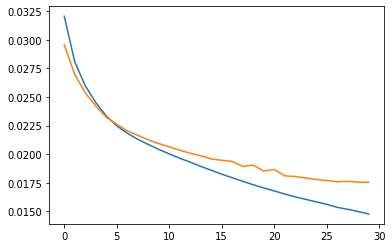

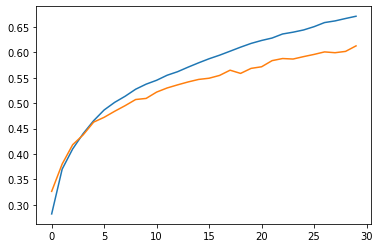

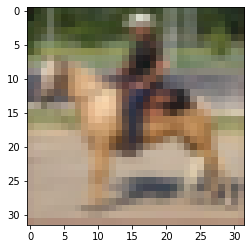

actual_label: 7 predicted_label: 7 actual_class: plane predicted_class: plane


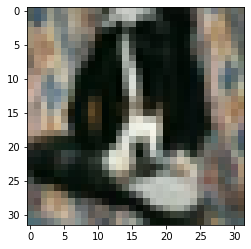

actual_label: 5 predicted_label: 9 actual_class: dog predicted_class: bird


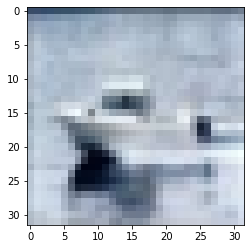

actual_label: 8 predicted_label: 2 actual_class: horse predicted_class: ship


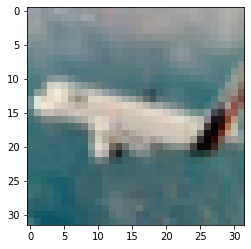

actual_label: 0 predicted_label: 1 actual_class: cat predicted_class: horse


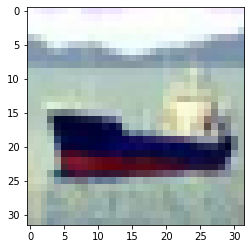

actual_label: 8 predicted_label: 8 actual_class: horse predicted_class: horse


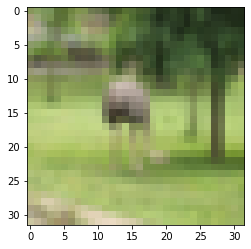

actual_label: 2 predicted_label: 7 actual_class: ship predicted_class: plane


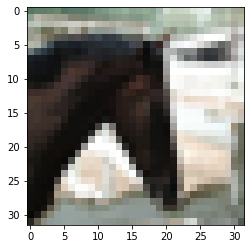

actual_label: 7 predicted_label: 4 actual_class: plane predicted_class: ship


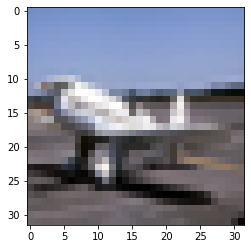

actual_label: 0 predicted_label: 0 actual_class: cat predicted_class: cat


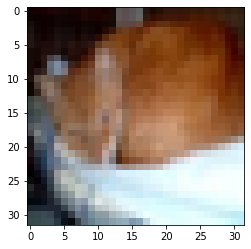

actual_label: 3 predicted_label: 3 actual_class: car predicted_class: car


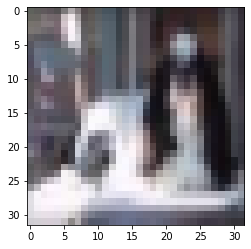

actual_label: 5 predicted_label: 3 actual_class: dog predicted_class: car

 test loss: 0.017238762081381243 test acc: 0.6161425159235668 correct: 6191 incorrect: 3809


In [ ]:
batch_size=64
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

torch.manual_seed(42)
validation_size = 5000
train_size = len(trainset)-validation_size
train_set, validation_set = random_split(trainset, [train_size, validation_size])


train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True,num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=64,shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False)

print("trainset:",len(train_set))
print("validationset:",len(validation_set))
print("testset:",len(test_set))

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


dataiter = iter(train_dataloader)
images, labels = dataiter.next()


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(labels)

class ConvolutionNetwork1(nn.Module):

  def __init__(self):
    super(ConvolutionNetwork1,self).__init__()
    
    self.flatten_shape =  16*24*24

    self.conv = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5,stride=1),
          nn.BatchNorm2d(8),
          nn.ReLU(True),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5,stride=1),
          nn.BatchNorm2d(16),
          nn.ReLU(True)
    )

    self.fc = nn.Sequential( 
        nn.Linear(in_features=self.flatten_shape, out_features=128),
        nn.Linear(in_features=128, out_features=200),
        nn.Linear(in_features=200, out_features=10)
    )

  def forward(self,x):
    x = self.conv(x)
    flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
    # print("ff:",x.shape,flat_features.shape)
    x=self.fc(flat_features)
    return x

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def test(dataloader,model,criterion,purpose="test"):

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        correct = 0
        incorrect = 0
        for imgs,lbls in dataloader:
            imgs = imgs
            lbls = lbls.long()

            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_acc += torch.sum(test_pred == lbls).item()
            correct += torch.sum(test_pred == lbls).item()
            incorrect += torch.sum(test_pred != lbls).item()

        test_loss = test_loss/float(len(dataloader)*batch_size)
        test_acc = float(float(test_acc)/float(len(dataloader)*batch_size))
        
        if purpose == "test": 

            for i in range(10):
              img = imgs[i]
              actual_lbl = lbls[i]
              out = model(img.unsqueeze(0))
              pred_lbl = out
              imshow(img.cpu().detach())
              actual_lbl_disp = actual_lbl.item()
              pred_lbl_disp = torch.argmax(pred_lbl).item()
              print("actual_label:",actual_lbl_disp,"predicted_label:",pred_lbl_disp,"actual_class:",classes[actual_lbl_disp],"predicted_class:",classes[pred_lbl_disp])

                        
            return test_loss,test_acc,correct,incorrect
    
    return test_loss,test_acc,correct,incorrect


from tqdm import tqdm
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

num_epochs = 30
learning_rate = 0.0001
batch_size=64

model = ConvolutionNetwork1().to(device)
# print("model:",model)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  train_correct = 0
  train_incorrect = 0
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs
      lbls = lbls.long()

      imgs = imgs.to(device)
      lbls = lbls.to(device)
      out = model(imgs)
      loss = criterion(out,lbls)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      acc = torch.sum(torch.argmax(out, dim=1) == lbls)
      train_correct += torch.sum(torch.argmax(out, dim=1) == lbls).item()
      train_incorrect += torch.sum(torch.argmax(out, dim=1) != lbls).item()
      running_acc += acc.item()

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  val_loss,val_acc,correct,incorrect = test(valid_dataloader,model,criterion,purpose="valid")
  
  train_loss.append(running_loss/float(len(train_dataloader)*batch_size))
  train_acc.append(running_acc/float(len(train_dataloader)*batch_size))
  
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader)*batch_size)," Train Accuracy:",running_acc/float(len(train_dataloader)*batch_size),"train_correct:",train_correct,"train_incorrect:",train_incorrect," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"correct:",correct,"incorrect:",incorrect,"\n")

plt.plot(np.arange(num_epochs),train_loss)
plt.plot(np.arange(num_epochs),validation_loss)
plt.show()

plt.plot(np.arange(num_epochs),train_acc)
plt.plot(np.arange(num_epochs),validation_acc)
plt.show()

model.eval()
test_loss,test_acc,test_correct,test_incorrect = test(test_dataloader,model,criterion,purpose="test")
print("\n","test loss:",test_loss,"test acc:",test_acc,"correct:",test_correct,"incorrect:",test_incorrect)


